# Building a 5000 dimensional Logistic Regression and Softmax Regression Sentiment Classifier Based on the Netflix Large Movie Review dataset
The final exercise in Chapter 5 suggests implementing a final project for sentiment analysis. "Sentiment analysis can be considered a binary classification problem. The input is natural language text, and the output is a binary decision that infers positive or negative sentiment." The chapter end suggests taking a look at some datasets in particular the [Large Movie Review Dataset](http://mng.bz/60nj). The excercise also suggests visiting the Kaggle challenge for [Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial). 

The Kaggle tutorial is excellent, and I've borrowed big pieces from it. The main differences in the Kaggle tutorial are that they use Scikit-Learn and Random Forrest, and there is no Tensorflow in it. They also use Pandas and assume that the train data is a 25000 * 5000 column Pandas data frame, and that each vertical slice / column in the frame is the full term frequency feature set counts for word X1, word X2.... word XN.

I've made a few changes to the tutorial besides using Tensorflow. I outline them below:

   1. Instead of using [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), I used [Tika Python](http://github.com/chrismattmann/tika-python) to clean the review text. Should be obvious why...
   2. I added [TQDM](https://github.com/tqdm/tqdm) progress bars on the most important iterations. 
   3. I added some plots here and there, including looking at the term frequency distribution for the first 100 words in the 5000 word vocabulary, and a plot for the ROC curve.
   4. I added computation of precision and recall, and TP, TN, FP, FN
   5. I added saving for the model weights. 
   
I have a feeling I made this harder than it needed to be &#9786; That said, I couldn't even visualize based on the example given in the book for 2d logistic regresion what 5000d logistic regression looked like. So, I made a visual of it to hopefully help others when they are similarly thinking about it. I think once I learn more about Tensorflow, I will be able to clean this code up some more too. 

<img src="../figs/ch06-final-bow-model.png" width="400" height="200" alt="Bag of Word Model in 5000 dimensions"/>

Here are some immensely useful references I found along the way. FWIW, my Nd logreg classifier is <b>~87%</b> accurate. The softmax reg classifier is <b>~81%</b> Not bad!

## Useful References

   1. [Plot ROC Curve for Binary Classification](https://qiita.com/bmj0114/items/460424c110a8ce22d945) by @bmj0114
   2. [Intersecting Lists and Finding their Indices](https://stackoverflow.com/questions/12570417/python-finding-corresponding-indices-for-an-intersection-of-two-lists) by mgilson
   3. [An Introduction to Bag of Words](https://medium.freecodecamp.org/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04) by Free Code Camp.
   4. [Bag of Words Meets Popcorn Tutorial](https://www.kaggle.com/c/word2vec-nlp-tutorial/overview) by Kaggle.
   5. [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) by Stanford.
   6. [What Bag of Words Looks Like Visually](https://bit.ly/2KCTYGe) by Unknown.
   7. [Working with Bag of Words - Tensorflow Cookbook](https://github.com/nfmcclure/tensorflow_cookbook/blob/master/07_Natural_Language_Processing/02_Working_with_Bag_of_Words/02_bag_of_words.ipynb) by Nick F. Mcclure.


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tika import parser
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
import re
import math
from tqdm.notebook import tqdm
from os import listdir
from os.path import isfile, join
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/mattmann/nltk_data...
[nltk_data]    |   Package movie_review

True

In [2]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = parser.from_buffer( "<html>" + raw_review + "</html>" )["content"]
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [3]:
train = pd.read_csv("../data/word2vec-nlp-tutorial/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [4]:
train.shape

(25000, 3)

In [5]:
train.columns.values

array(['id', 'sentiment', 'review'], dtype=object)

In [6]:
train.head()

id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...

In [7]:
parsed = parser.from_buffer("<html>"+train["review"][0]+"</html>")
print(train["review"][0])
print(parsed["content"])

2020-08-01 13:07:15,413 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/n5/1d_k3z4s2293q8ntx_n8sw54mm5n_8/T/tika-server.jar.
I0801 13:07:15.413117 4576171456 tika.py:796] Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /var/folders/n5/1d_k3z4s2293q8ntx_n8sw54mm5n_8/T/tika-server.jar.
2020-08-01 13:07:20,185 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/n5/1d_k3z4s2293q8ntx_n8sw54mm5n_8/T/tika-server.jar.md5.
I0801 13:07:20.185200 4576171456 tika.py:796] Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /var/folders/n5/1d_k3z4s2293q8ntx_n8sw54mm5n_8/T/tika-server.jar.md5.
2020-08-01 13:07:22,484 [MainThread  ] [WARNI]  Failed to see startup lo

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [8]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in tqdm(range( 0, num_reviews )):
    # Call our function for each one, and add the result to the list of
    # clean reviews
    clean_train_reviews.append( review_to_words( train["review"][i] ) )

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [9]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

In [10]:
print(train_data_features.shape)

(25000, 5000)


In [11]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
print("size %d %s " % (len(vocab), vocab))

size 5000 ['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abusive', 'abysmal', 'academy', 'accent', 'accents', 'accept', 'acceptable', 'accepted', 'access', 'accident', 'accidentally', 'accompanied', 'accomplished', 'according', 'account', 'accuracy', 'accurate', 'accused', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'activities', 'actor', 'actors', 'actress', 'actresses', 'acts', 'actual', 'actually', 'ad', 'adam', 'adams', 'adaptation', 'adaptations', 'adapted', 'add', 'added', 'adding', 'addition', 'adds', 'adequate', 'admire', 'admit', 'admittedly', 'adorable', 'adult', 'adults', 'advance', 'advanced', 'advantage', 'adventure', 'adventures', 'advertising', 'advice', 'advise', 'affair', 'affect', 'affected', 'afford', 'aforementioned', 'afraid', 'africa', 'african', 'afternoon', 'afterwards', 'age', 'aged', 'agent', 'agents', 'ages', 'aging', 

In [12]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
for tag, count in zip(vocab, dist):
    print("%d, %s" % (count, tag))

187, abandoned
125, abc
108, abilities
454, ability
1259, able
85, abraham
116, absence
83, absent
352, absolute
1485, absolutely
306, absurd
192, abuse
91, abusive
98, abysmal
297, academy
485, accent
203, accents
300, accept
130, acceptable
144, accepted
92, access
318, accident
200, accidentally
88, accompanied
124, accomplished
296, according
186, account
81, accuracy
284, accurate
123, accused
179, achieve
139, achieved
124, achievement
90, acid
971, across
1251, act
660, acted
6494, acting
3355, action
311, actions
83, activities
2389, actor
4488, actors
1219, actress
369, actresses
394, acts
793, actual
4240, actually
148, ad
303, adam
98, adams
454, adaptation
80, adaptations
154, adapted
810, add
440, added
166, adding
347, addition
337, adds
113, adequate
124, admire
621, admit
134, admittedly
101, adorable
511, adult
376, adults
101, advance
90, advanced
153, advantage
510, adventure
204, adventures
91, advertising
259, advice
90, advise
346, affair
93, affect
113, affected


892, cheap
92, cheated
103, cheating
770, check
80, checked
139, checking
114, cheek
158, cheese
634, cheesy
490, chemistry
96, chess
93, chest
92, chicago
233, chick
80, chicken
89, chicks
230, chief
1324, child
356, childhood
117, childish
1510, children
169, chilling
189, china
337, chinese
530, choice
171, choices
227, choose
85, chooses
99, choreographed
115, choreography
99, chorus
202, chose
232, chosen
421, chris
183, christ
373, christian
79, christianity
92, christians
623, christmas
415, christopher
97, christy
143, chuck
406, church
123, cia
233, cinderella
1494, cinema
412, cinematic
101, cinematographer
985, cinematography
103, circle
218, circumstances
88, cities
125, citizen
1197, city
140, civil
93, civilization
222, claim
100, claimed
205, claims
173, claire
204, clark
893, class
106, classes
1828, classic
88, classical
233, classics
80, claus
243, clean
786, clear
899, clearly
533, clever
94, cleverly
840, clich
96, cliche
112, cliff
93, climactic
422, climax
110, cl

500, impressive
97, improve
115, improved
85, improvement
79, inability
95, inane
90, inappropriate
115, incident
376, include
272, included
321, includes
1052, including
138, incoherent
87, incompetent
89, incomprehensible
131, increasingly
563, incredible
628, incredibly
722, indeed
314, independent
180, india
406, indian
122, indians
181, indie
237, individual
126, individuals
83, inducing
80, indulgent
345, industry
175, inept
131, inevitable
82, inevitably
148, infamous
78, infected
94, inferior
211, influence
107, influenced
335, information
107, ingredients
209, initial
178, initially
210, inner
154, innocence
416, innocent
110, innovative
241, insane
600, inside
187, insight
162, inspector
169, inspiration
348, inspired
135, inspiring
121, installment
289, instance
104, instant
128, instantly
2191, instead
86, instinct
213, insult
128, insulting
82, integrity
176, intellectual
327, intelligence
535, intelligent
388, intended
344, intense
158, intensity
117, intent
132, intentio

1516, supposed
365, supposedly
2686, sure
417, surely
192, surface
102, surfing
716, surprise
802, surprised
204, surprises
302, surprising
466, surprisingly
208, surreal
134, surrounded
134, surrounding
106, survival
260, survive
91, survived
104, surviving
85, survivor
101, survivors
186, susan
301, suspect
156, suspects
84, suspend
741, suspense
192, suspenseful
88, suspicious
160, sutherland
113, swear
112, swedish
572, sweet
83, swim
97, swimming
97, switch
195, sword
114, symbolism
229, sympathetic
199, sympathy
111, synopsis
370, system
181, table
79, tacky
97, tad
99, tag
3510, take
987, taken
2192, takes
955, taking
790, tale
933, talent
586, talented
268, talents
166, tales
842, talk
126, talked
955, talking
220, talks
121, tall
111, tame
80, tank
115, tap
234, tape
82, tarantino
211, target
291, tarzan
174, task
437, taste
78, tastes
95, taught
91, taxi
315, taylor
136, tea
137, teach
314, teacher
82, teaching
824, team
138, tear
324, tears
82, tech
305, technical
195, techn

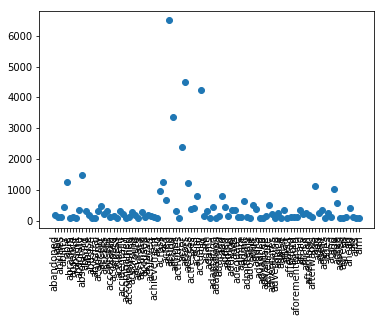

In [13]:
# plot the word count for first 100 words
plt.scatter(vocab[0:99], dist[0:99])
plt.xticks(vocab[0:99], rotation='vertical')
plt.show()

In [14]:
# set up Tensorflow nD logistic regression
learning_rate = 0.1
training_epochs = 2000

In [15]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [16]:
Y = tf.placeholder(tf.float32, shape=(None,), name="y")
w = tf.Variable([0.] * (len(train_data_features)+1), name="w", trainable=True)
print(w.shape)

(25001,)


In [17]:
ys = train['sentiment'].values

In [18]:
Xs = {}
for i in range(train_data_features.shape[1]):
    Xs["X"+str(i)] = tf.placeholder(tf.float32, shape=(None,), name="x"+str(i))

In [19]:
linear = w[0]
for i in range(0, train_data_features.shape[1]):
    linear = linear + (w[i+1] * Xs["X"+str(i)])
y_model = tf.sigmoid(linear)

In [20]:
cost = tf.reduce_mean(-tf.log(y_model * Y + (1 - y_model) * (1 - Y)))
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [21]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    prev_err = 0
    for epoch in tqdm(range(training_epochs)):
        feed_dict = {}
        for i in range(train_data_features.shape[1]):
            feed_dict[Xs["X"+str(i)]] = train_data_features[:, i, None].reshape(len(train_data_features))
        feed_dict[Y] = ys
        err, _ = sess.run([cost, train_op], feed_dict=feed_dict)
        print(epoch, err)
        if abs(prev_err - err) < 0.0001:
            break
        prev_err = err
    
    w_val = sess.run(w, feed_dict)
    save_path = saver.save(sess, "../models/en-netflix-binary-sentiment.ckpt")

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


0 0.6931475
1 0.68367267
2 0.67517424
3 0.6673778
4 0.6601468
5 0.6533886
6 0.6470343
7 0.64103085
8 0.6353368
9 0.62991923
10 0.62475115
11 0.6198105
12 0.6150785
13 0.6105392
14 0.6061786
15 0.6019846
16 0.59794647
17 0.59405404
18 0.5902991
19 0.58667326
20 0.5831693
21 0.5797805
22 0.5765007
23 0.5733241
24 0.57024544
25 0.5672598
26 0.5643625
27 0.5615493
28 0.5588163
29 0.55615956
30 0.5535756
31 0.55106133
32 0.5486133
33 0.546229
34 0.54390526
35 0.54163986
36 0.53943014
37 0.537274
38 0.535169
39 0.5331134
40 0.5311051
41 0.52914226
42 0.5272231
43 0.5253461
44 0.5235097
45 0.5217122
46 0.5199523
47 0.51822865
48 0.51654017
49 0.5148855
50 0.5132633
51 0.51167256
52 0.5101124
53 0.5085817
54 0.5070795
55 0.50560474
56 0.5041569
57 0.5027348
58 0.50133777
59 0.499965
60 0.49861583
61 0.49728957
62 0.49598548
63 0.49470282
64 0.4934411
65 0.4921997
66 0.49097803
67 0.48977554
68 0.48859173
69 0.4874259
70 0.48627788
71 0.48514712
72 0.4840329
73 0.482935
74 0.481853
75 0.4807864

569 0.3361943
570 0.3360846
571 0.33597508
572 0.33586586
573 0.3357568
574 0.3356481
575 0.33553946
576 0.3354311
577 0.33532292
578 0.335215
579 0.33510736
580 0.33499983
581 0.3348925
582 0.33478546
583 0.33467856
584 0.334572
585 0.3344655
586 0.33435938
587 0.3342533
588 0.33414757
589 0.33404186
590 0.3339366
591 0.3338314
592 0.3337264
593 0.3336217
594 0.3335171
595 0.33341283
596 0.33330867
597 0.3332047
598 0.33310097
599 0.3329974
600 0.33289415
601 0.33279103
602 0.33268812
603 0.33258536
604 0.3324828
605 0.33238044
606 0.3322783
607 0.33217642
608 0.33207464
609 0.33197314
610 0.33187172
611 0.3317706
612 0.3316696
613 0.3315689
614 0.33146828
615 0.33136788
616 0.33126768
617 0.33116767
618 0.3310678


In [22]:
print(w_val)
print(np.max(w_val))

[ 0.0028774  -0.00082148  0.01867105 ...  0.          0.
  0.        ]
0.49940136


In [23]:
def predict(test_review, vocab, weights, threshold=0.5):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    # our log reg model
    test_linear = weights[0]
    for i in range(0, train_data_features.shape[1]):
        test_linear = test_linear + (weights[i+1] * test_feature_vec[i])
    y_test = sigmoid(test_linear)
    
    # here it is the prediction
    return np.greater(y_test, threshold).astype(float)

In [24]:
test = pd.read_csv("../data/word2vec-nlp-tutorial/testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [25]:
test.head()

id                                             review
0  "12311_10"  "Naturally in a film who's main themes are of ...
1    "8348_2"  "This movie is a disaster within a disaster fi...
2    "5828_4"  "All in all, this is a movie for kids. We saw ...
3    "7186_2"  "Afraid of the Dark left me with the impressio...
4   "12128_7"  "A very accurate depiction of small time mob l...

In [26]:
#try it out on new data
new_neg_review = "Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!"
new_pos_review = "I think that this is a fantastic movie, it really "

In [27]:
new_neg_review_c = review_to_words(new_neg_review)
new_pos_review_c = review_to_words(new_pos_review)
print(new_neg_review_c)
print(new_pos_review_c)         

man movie really sucked terrible could possibly watch movie
think fantastic movie really


In [28]:
predict(new_neg_review, vocab, w_val)

0.0

In [29]:
predict(new_pos_review, vocab, w_val)

1.0

In [30]:
# Generate Kaggle Submission
# Create an empty list and append the clean reviews one by one
num_reviews = len(test["review"])
result = [] 
for i in tqdm(range(0, num_reviews)):
    r = predict(test["review"][i], vocab, w_val)
    result.append(r)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv( "../data/cache/Bag_of_Words_model.csv", index=False, quoting=3 )

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [31]:
# test on unseen samples from IMDB movie reviews and compute TP, TN, FP, FN and precision + accuracy
pos_test_path = "../data/aclImdb/test/pos/"
neg_test_path = "../data/aclImdb/test/neg/"
only_pos_files = [f for f in listdir(pos_test_path) if isfile(join(pos_test_path, f))]
only_neg_files = [f for f in listdir(neg_test_path) if isfile(join(neg_test_path, f))]

only_pos_file_contents = []
for i in range(0, len(only_pos_files)):
    with open(pos_test_path + only_pos_files[i], 'r') as file:
        r_data = file.read()
        only_pos_file_contents.append(r_data)
        
only_neg_file_contents = []
for i in range(0, len(only_neg_files)):
    with open(neg_test_path + only_neg_files[i], 'r') as file:
        r_data = file.read()
        only_neg_file_contents.append(r_data)

In [32]:
TP = 0.
TN = 0.
FP = 0.
FN = 0.
predictions_test = np.zeros(len(only_pos_file_contents) * 2)

In [33]:
for i in tqdm(range(0, len(only_pos_file_contents))):
    sent = predict(only_pos_file_contents[i], vocab, w_val)
    predictions_test[i] = sent
    if sent == 1.:
        TP += 1
    elif sent == 0.:
        FN += 1

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [34]:
for i in tqdm(range(0, len(only_neg_file_contents))):
    sent = predict(only_neg_file_contents[i], vocab, w_val)
    predictions_test[len(only_neg_file_contents)+i] = sent
    if sent == 0.:
        TN += 1
    elif sent == 1.:
        FP += 1

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [35]:
precision = (TP) / (TP + FP)

In [36]:
recall = (TP) / (TP + FN)

In [37]:
print("precision %f recall %f" % (precision, recall))

precision 0.859793 recall 0.875200


In [38]:
print(TP)
print(TN)
print(FP)
print(FN)

10940.0
10716.0
1784.0
1560.0


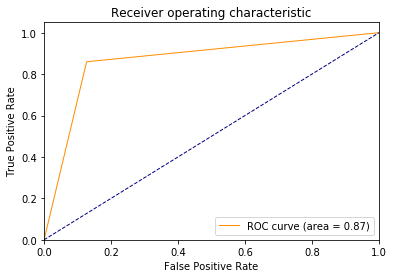

In [39]:
outcome_test = np.ones(len(only_pos_files))
outcome_test = np.append(outcome_test, np.zeros(len(only_neg_files)))

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Try Softmax Regression
Chapter 6 in the book teaches us also about softmax regression. The big difference with softmax is that we can predict more than 2 classes (N output classes) and to do so, we set up an equation like Y = WX + B, where W are the weights (num_features * num_labels), X is the input feature data (num_train * num_features), and B the offset constant (num_labels) and Y is the one-hot encoded class labels we are trying to predict (num_labels). Y, X, W and B are matrices. The book also teaches us to use batch training, so we'll set all that up here. One interesting property is that Softmax natively provides class confidence for each prediction. This could be done with n-d logistic regression by estimating tthe difference from absolute 0 or 1 for the predicted y_model value and then divide by 0.5.

In [40]:
learning_rate = 0.01
training_epochs = 1000
num_labels = 2
batch_size = 100

In [41]:
def softmax_feat_vec_from_review(test_review, vocab):
    #assumption: review is clean
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    
    ex_data_features = n_vectorizer.fit_transform([test_review])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]
     
    
    return test_feature_vec


In [42]:
num_pos_labels = len(train.loc[train['sentiment'] == 1.])
num_neg_labels = len(train.loc[train['sentiment'] == 0.])
lab_mat = []
for i in range(len(train['sentiment'])):
    if train['sentiment'][i] == 1.0:
        #lab_mat = lab_mat + [[1., 0.]]
        lab_mat = lab_mat + [[0., 1.]]
    elif train['sentiment'][i] == 0.0:
        #lab_mat = lab_mat + [[0., 1.]]
        lab_mat = lab_mat + [[1., 0.]]

labels = np.matrix(lab_mat)
print(labels)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [43]:
xs = train_data_features.astype(float)
train_size, num_features = xs.shape
print(xs.shape)
print(labels.shape)

(25000, 5000)
(25000, 2)


In [44]:
#shuffle the labels so that the system doesn't learn that the order of the data matters
arr = np.arange(xs.shape[0])
np.random.shuffle(arr)
xs = xs[arr, :]
labels = labels[arr, :]

In [45]:
X = tf.placeholder("float", shape=[None, num_features])
Y = tf.placeholder("float", shape=[None, num_labels])
W = tf.Variable(tf.zeros([num_features, num_labels]))
b = tf.Variable(tf.zeros([num_labels]))
y_model = tf.nn.softmax(tf.matmul(X, W) + b)

In [46]:
# sometimes the result of y_model can be 0, and log0 is NaN, so account for it
# see: https://stackoverflow.com/questions/38538635/tensorflow-returning-nan-when-implementing-logistic-regression
cost = -tf.reduce_sum(Y * tf.log(tf.maximum(y_model, 1e-15))) 
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

W0801 14:36:49.161425 4576171456 deprecation.py:323] From /Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [47]:
correct_prediction = tf.equal(tf.argmax(y_model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [48]:
test_reviews = []
clean_test_reviews = []
test_reviews.extend(only_pos_file_contents)
test_reviews.extend(only_neg_file_contents)

In [49]:
for i in tqdm(range(len(test_reviews))):
    test_review_c = review_to_words(test_reviews[i])
    clean_test_reviews.append(test_review_c)

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [50]:
test_xs = np.zeros((len(clean_test_reviews), num_features))
for i in tqdm(range(len(clean_test_reviews))):
    test_xs[i] = softmax_feat_vec_from_review(clean_test_reviews[i], vocab)

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [51]:
test_xs.shape

(25000, 5000)

In [52]:
test_labels = np.matrix([[0., 1.]] * len(only_pos_file_contents) + [[1., 0.]] * len(only_neg_file_contents))

In [53]:
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for step in tqdm(range(training_epochs * train_size // batch_size)):
        offset = (step * batch_size) % train_size
        batch_xs = xs[offset:(offset + batch_size), :]
        batch_labels = labels[offset:(offset + batch_size)]
        err, _ = sess.run([cost, train_op], feed_dict={X: batch_xs, Y: batch_labels})
        print (step, err)            
    
    W_val = sess.run(W)
    print('w', W_val)
    b_val = sess.run(b)
    print('b', b_val)
    print("accuracy", accuracy.eval(feed_dict={X: test_xs, Y: test_labels}))
    save_path = saver.save(sess, "../models/ch4-softmax-netflix-sentiment.ckpt")
    print("Model saved in path: %s" % save_path)

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0 69.31472
1 106.74745
2 414.41934
3 343.7433
4 469.84332
5 430.18042
6 216.59464
7 301.3204
8 443.99664
9 145.37758
10 174.1239
11 148.9679
12 165.37924
13 214.17737
14 262.96085
15 329.4206
16 291.69232
17 233.84465
18 120.105705
19 258.1784
20 262.59372
21 169.1226
22 123.42656
23 59.314316
24 76.08208
25 91.98783
26 68.30967
27 63.660027
28 51.87973
29 39.50642
30 59.205532
31 77.48151
32 50.525368
33 46.791477
34 78.309746
35 85.614555
36 115.68465
37 155.94525
38 127.9302
39 66.44824
40 134.42035
41 144.72467
42 146.328
43 125.55395
44 65.55469
45 47.375214
46 65.23802
47 58.486816
48 84.28678
49 100.45094
50 75.58545
51 58.386402
52 47.54345
53 49.13742
54 63.16799
55 68.374016
56 63.39197
57 38.744347
58 36.50276
59 55.657677
60 77.53899
61 61.327576
62 40.255287
63 30.214489
64 48.890236
65 46.03263
66 49.10743
67 45.209507
68 38.880203
69 36.58856
70 43.66295
71 50.578632
72 36.655388
73 46.158424
74 53.287117
75 91.767204
76 238.22765
77 188.9162
78 137.19911
79 83.14932
80 

645 16.894463
646 20.995234
647 29.624413
648 12.188312
649 23.42166
650 19.774288
651 34.56781
652 35.994022
653 39.10574
654 28.493427
655 22.531345
656 10.6755495
657 30.395538
658 18.562696
659 26.598312
660 27.761925
661 25.302532
662 33.699135
663 17.34677
664 39.905632
665 50.119896
666 40.28463
667 45.54713
668 57.912773
669 48.920937
670 49.975258
671 32.05292
672 40.54813
673 42.9354
674 33.461365
675 40.078217
676 45.35833
677 30.286846
678 39.866962
679 27.620712
680 19.416586
681 16.169449
682 26.815308
683 32.535294
684 33.112564
685 53.24428
686 12.294331
687 18.738848
688 24.565498
689 32.61981
690 28.14474
691 21.165222
692 15.8842945
693 47.408703
694 24.992702
695 30.13361
696 24.217854
697 18.685575
698 25.668219
699 34.874043
700 48.82782
701 22.715385
702 14.7971325
703 23.624702
704 20.533886
705 21.54411
706 51.877544
707 38.35612
708 39.05253
709 39.824097
710 60.615795
711 55.733967
712 15.5752945
713 34.20728
714 24.452631
715 22.63576
716 21.366447
717 29.66

1285 40.40378
1286 27.379742
1287 24.10862
1288 18.76337
1289 23.96349
1290 24.084917
1291 20.216846
1292 30.135757
1293 33.298267
1294 25.24702
1295 27.273205
1296 26.27616
1297 31.997223
1298 28.042442
1299 45.24557
1300 39.377396
1301 29.554241
1302 23.619137
1303 16.828278
1304 19.130932
1305 31.62088
1306 30.676008
1307 15.226379
1308 15.319308
1309 29.165043
1310 29.321493
1311 29.431671
1312 22.695948
1313 22.235338
1314 24.494837
1315 18.27264
1316 25.371094
1317 25.480587
1318 16.468159
1319 22.968582
1320 21.641724
1321 20.134226
1322 26.321619
1323 35.912945
1324 42.469448
1325 29.855064
1326 15.594444
1327 17.845339
1328 17.848824
1329 21.351467
1330 19.510565
1331 19.182608
1332 17.275017
1333 27.441242
1334 10.224665
1335 19.347471
1336 20.057285
1337 16.895144
1338 16.923931
1339 27.326132
1340 10.893486
1341 23.485802
1342 9.701131
1343 13.355179
1344 14.422586
1345 23.426483
1346 34.200905
1347 22.069054
1348 16.057226
1349 29.226677
1350 16.089031
1351 12.74207
1352 3

1895 9.4838085
1896 10.844532
1897 20.315678
1898 7.9738765
1899 19.59368
1900 12.951872
1901 26.013699
1902 21.567919
1903 19.336296
1904 14.981488
1905 16.545025
1906 7.657792
1907 23.377737
1908 13.482294
1909 21.622257
1910 18.84689
1911 22.780268
1912 22.42574
1913 22.422989
1914 41.568718
1915 29.338884
1916 25.187649
1917 27.841276
1918 40.5608
1919 36.025665
1920 36.720535
1921 23.532318
1922 23.441505
1923 39.22013
1924 26.287926
1925 28.805897
1926 28.370163
1927 23.426033
1928 22.542728
1929 20.41959
1930 14.178131
1931 11.891541
1932 19.631525
1933 28.374668
1934 20.287235
1935 31.92012
1936 9.644252
1937 13.586698
1938 15.961689
1939 22.463871
1940 20.098576
1941 17.193367
1942 17.198107
1943 36.45522
1944 23.998482
1945 21.902931
1946 11.692572
1947 15.940163
1948 21.889454
1949 25.254585
1950 24.978294
1951 15.984057
1952 7.5963864
1953 14.395257
1954 16.030357
1955 13.852249
1956 33.804867
1957 27.069195
1958 29.275913
1959 21.944386
1960 17.054066
1961 33.72098
1962 13

2455 13.756014
2456 31.630182
2457 26.476337
2458 28.30211
2459 19.622227
2460 14.455959
2461 29.24997
2462 12.57841
2463 28.51866
2464 11.792571
2465 12.251006
2466 13.450024
2467 18.72025
2468 15.74679
2469 26.35733
2470 17.645792
2471 22.674015
2472 27.437595
2473 34.32573
2474 36.52052
2475 36.257843
2476 18.221647
2477 26.29606
2478 18.121134
2479 18.462738
2480 15.409275
2481 14.805003
2482 26.482975
2483 20.498936
2484 42.543694
2485 26.174313
2486 26.18771
2487 25.358221
2488 17.580593
2489 13.502203
2490 18.233437
2491 17.152296
2492 23.431108
2493 22.396198
2494 20.250526
2495 12.454037
2496 15.969536
2497 22.780874
2498 26.22888
2499 10.856455
2500 19.685356
2501 32.14904
2502 14.079578
2503 28.183924
2504 17.837423
2505 22.93839
2506 23.869013
2507 13.074522
2508 24.44617
2509 17.326223
2510 21.08415
2511 18.067905
2512 18.972996
2513 24.571566
2514 13.05126
2515 15.526487
2516 17.455688
2517 25.446564
2518 12.325848
2519 21.783249
2520 17.332212
2521 31.158619
2522 15.3355

3044 18.99705
3045 22.549976
3046 21.028118
3047 23.269596
3048 24.589949
3049 26.55712
3050 16.846027
3051 12.09927
3052 14.392566
3053 13.837021
3054 16.641218
3055 24.028599
3056 27.187916
3057 16.556826
3058 14.74831
3059 23.257544
3060 18.588497
3061 24.599957
3062 20.640032
3063 16.37598
3064 19.064835
3065 15.000706
3066 20.798473
3067 20.387346
3068 13.129666
3069 13.587016
3070 17.121107
3071 14.7694
3072 14.2151165
3073 12.038469
3074 13.081843
3075 12.29427
3076 15.538677
3077 14.05945
3078 17.726727
3079 17.67871
3080 17.969313
3081 16.748661
3082 18.855732
3083 19.217663
3084 8.687965
3085 16.179138
3086 14.637955
3087 13.701792
3088 15.32913
3089 18.695562
3090 10.056023
3091 15.869983
3092 8.691138
3093 11.816034
3094 11.920421
3095 20.14219
3096 29.111359
3097 16.736107
3098 16.152
3099 25.96164
3100 14.55973
3101 6.782145
3102 32.077534
3103 16.430052
3104 18.876066
3105 10.582157
3106 12.443062
3107 33.71643
3108 15.386327
3109 15.081417
3110 14.26427
3111 31.2428
311

3655 13.8563795
3656 8.571352
3657 20.07924
3658 10.584511
3659 19.340933
3660 15.015304
3661 23.871475
3662 18.589317
3663 16.080679
3664 28.45946
3665 13.657059
3666 17.84314
3667 17.643942
3668 18.807518
3669 22.687138
3670 20.052729
3671 11.984366
3672 15.34762
3673 27.709658
3674 17.194542
3675 23.744755
3676 24.002953
3677 19.126707
3678 16.212595
3679 15.321403
3680 10.102062
3681 9.5779705
3682 16.144672
3683 25.59185
3684 19.00149
3685 26.461111
3686 9.412704
3687 10.314969
3688 13.408948
3689 19.356335
3690 17.012447
3691 15.234241
3692 13.893103
3693 31.85095
3694 22.00512
3695 19.685251
3696 9.539077
3697 14.825233
3698 15.9355955
3699 20.77869
3700 19.163029
3701 13.855022
3702 6.385021
3703 13.951936
3704 12.112429
3705 11.573456
3706 27.615004
3707 19.603077
3708 20.077625
3709 17.958477
3710 12.45902
3711 27.461735
3712 11.403519
3713 25.662003
3714 10.40199
3715 10.648134
3716 12.32039
3717 17.92573
3718 14.1613655
3719 19.63049
3720 17.995892
3721 22.370483
3722 25.46

4262 14.958767
4263 21.239012
4264 12.290455
4265 14.936721
4266 16.588598
4267 23.634148
4268 12.60177
4269 22.254614
4270 16.620298
4271 28.411118
4272 16.293373
4273 9.681866
4274 19.70836
4275 16.239126
4276 8.99909
4277 23.421822
4278 11.635212
4279 12.0104685
4280 13.133621
4281 12.899208
4282 21.439062
4283 16.304253
4284 20.918488
4285 28.843155
4286 15.998482
4287 24.908585
4288 13.036437
4289 18.891289
4290 18.491413
4291 12.659156
4292 20.86087
4293 27.606358
4294 17.153467
4295 20.492073
4296 18.343674
4297 20.204376
4298 22.106186
4299 25.939192
4300 16.078608
4301 8.835149
4302 13.206659
4303 13.79189
4304 15.2910385
4305 17.48928
4306 22.102528
4307 14.333222
4308 12.525965
4309 18.611664
4310 14.583235
4311 20.215544
4312 18.20984
4313 14.565368
4314 17.041683
4315 14.621555
4316 20.017056
4317 17.437798
4318 12.733212
4319 11.930258
4320 15.040141
4321 11.0615425
4322 13.569258
4323 11.340561
4324 13.801515
4325 9.992081
4326 14.9883
4327 13.162037
4328 16.112654
4329 

4849 24.781704
4850 13.581354
4851 6.4263334
4852 26.675072
4853 12.794219
4854 15.121462
4855 10.507629
4856 11.09148
4857 30.050762
4858 13.184696
4859 14.222633
4860 13.506678
4861 25.919159
4862 18.866447
4863 15.098867
4864 14.633697
4865 16.969454
4866 15.033335
4867 15.871461
4868 15.9549885
4869 11.6062975
4870 11.224384
4871 12.562562
4872 20.134132
4873 19.688522
4874 19.699347
4875 19.531736
4876 17.685677
4877 17.293919
4878 11.619602
4879 15.088548
4880 12.615257
4881 20.390125
4882 21.171146
4883 11.641543
4884 18.363237
4885 11.786887
4886 13.807893
4887 16.272865
4888 13.692936
4889 12.851084
4890 13.138143
4891 21.646017
4892 21.599934
4893 12.048506
4894 18.81369
4895 7.605769
4896 10.380615
4897 17.639797
4898 5.727993
4899 15.080508
4900 9.571963
4901 21.628355
4902 15.491192
4903 12.93622
4904 11.223093
4905 14.364949
4906 8.151794
4907 18.605556
4908 9.475079
4909 19.330301
4910 13.925467
4911 22.75207
4912 17.027954
4913 16.343752
4914 27.331818
4915 12.312004
49

5461 24.978485
5462 10.7648115
5463 23.587627
5464 9.408081
5465 9.633074
5466 10.631011
5467 15.601282
5468 13.856222
5469 16.893047
5470 15.339677
5471 18.826597
5472 23.119776
5473 23.862835
5474 24.329975
5475 21.924707
5476 10.964748
5477 17.829035
5478 11.68765
5479 16.256304
5480 12.8538
5481 13.895821
5482 23.712498
5483 15.998611
5484 35.96161
5485 21.867851
5486 20.37144
5487 21.932503
5488 11.958694
5489 10.6550045
5490 15.233479
5491 14.522043
5492 15.771587
5493 19.104572
5494 17.396524
5495 10.593556
5496 13.849027
5497 20.579563
5498 23.515368
5499 8.801577
5500 17.529287
5501 21.63564
5502 10.526539
5503 21.901295
5504 15.102948
5505 20.824345
5506 19.17963
5507 11.561034
5508 22.886005
5509 14.753046
5510 14.845142
5511 14.740074
5512 13.877176
5513 22.38517
5514 11.583318
5515 15.009172
5516 15.508592
5517 23.14116
5518 12.230837
5519 21.757479
5520 14.039526
5521 25.756367
5522 13.369053
5523 9.38488
5524 19.567448
5525 15.471696
5526 7.3888607
5527 20.380646
5528 10

6048 19.92398
6049 24.366402
6050 14.912702
6051 7.6016035
6052 11.805788
6053 12.473383
6054 14.857195
6055 16.177433
6056 21.429329
6057 13.83917
6058 12.053979
6059 17.86339
6060 13.282538
6061 17.807917
6062 16.653095
6063 13.051991
6064 16.052677
6065 13.924683
6066 18.900597
6067 16.408075
6068 12.031746
6069 10.921911
6070 13.998747
6071 10.000788
6072 12.435279
6073 9.910035
6074 11.955793
6075 8.561024
6076 14.075131
6077 12.120776
6078 15.3725815
6079 15.896276
6080 16.134705
6081 12.580534
6082 18.99855
6083 15.500776
6084 7.706072
6085 12.502726
6086 13.104628
6087 12.919846
6088 13.595795
6089 16.317554
6090 7.5763884
6091 11.96019
6092 7.746047
6093 9.633317
6094 10.209396
6095 20.542786
6096 24.255777
6097 13.149546
6098 15.343529
6099 23.59497
6100 13.395962
6101 5.996152
6102 24.045097
6103 12.573687
6104 14.425891
6105 10.347563
6106 10.801243
6107 27.953627
6108 12.476822
6109 13.440556
6110 13.002281
6111 25.076424
6112 18.838673
6113 14.169325
6114 13.339455
6115 1

6609 13.197809
6610 13.343901
6611 24.181898
6612 18.0164
6613 14.009781
6614 13.564796
6615 15.31682
6616 14.446415
6617 14.611585
6618 15.241231
6619 10.260118
6620 10.085666
6621 11.134697
6622 19.260649
6623 18.899296
6624 18.495369
6625 17.493538
6626 15.841425
6627 16.209175
6628 10.831255
6629 13.6372795
6630 11.725016
6631 18.695148
6632 19.292469
6633 11.330716
6634 16.27224
6635 11.155635
6636 13.024049
6637 15.292532
6638 12.937662
6639 12.09586
6640 13.057673
6641 20.171434
6642 20.604557
6643 11.513827
6644 17.284874
6645 7.319998
6646 10.509589
6647 16.822388
6648 5.1277018
6649 14.024631
6650 9.042452
6651 20.779383
6652 14.486162
6653 11.244112
6654 10.231379
6655 13.066974
6656 8.690307
6657 17.564716
6658 8.541013
6659 18.55897
6660 12.843283
6661 22.208641
6662 16.080814
6663 16.245825
6664 26.024147
6665 11.663147
6666 14.672424
6667 14.575487
6668 18.545424
6669 21.63138
6670 19.223438
6671 10.321083
6672 11.617129
6673 22.289486
6674 16.188229
6675 21.045223
6676 

7164 25.556087
7165 11.417537
7166 14.376923
7167 14.151886
7168 17.165073
7169 20.52232
7170 18.65275
7171 10.382605
7172 11.708008
7173 21.68901
7174 15.543533
7175 20.647598
7176 19.787416
7177 17.217735
7178 15.033571
7179 13.700705
7180 8.236981
7181 8.156172
7182 14.190449
7183 23.980507
7184 18.242882
7185 20.994715
7186 8.55895
7187 8.20783
7188 11.755613
7189 15.444706
7190 12.670918
7191 14.679231
7192 11.4205065
7193 29.966946
7194 22.751059
7195 17.320679
7196 8.31838
7197 15.229069
7198 11.455332
7199 18.069792
7200 15.688771
7201 12.812397
7202 5.3590546
7203 12.821092
7204 9.200424
7205 10.837804
7206 25.068682
7207 17.555973
7208 15.6829405
7209 14.927899
7210 9.979959
7211 23.289227
7212 10.872563
7213 21.675116
7214 8.556287
7215 9.191119
7216 9.662708
7217 14.050054
7218 13.818887
7219 15.52556
7220 13.601013
7221 17.3673
7222 21.505402
7223 20.787102
7224 22.097986
7225 20.13742
7226 10.102243
7227 16.283987
7228 11.03087
7229 14.969896
7230 12.011677
7231 13.458801

7720 13.251022
7721 17.053888
7722 21.197552
7723 20.162344
7724 21.919594
7725 19.783867
7726 9.873406
7727 15.906637
7728 11.141096
7729 14.9819355
7730 11.996636
7731 13.428153
7732 21.729681
7733 15.381699
7734 33.816254
7735 20.765661
7736 19.426434
7737 21.13724
7738 10.59515
7739 9.611789
7740 14.372953
7741 13.234927
7742 13.777061
7743 17.659067
7744 17.062086
7745 9.264878
7746 10.951582
7747 17.978714
7748 22.985447
7749 8.395975
7750 16.129488
7751 17.977154
7752 11.307333
7753 19.476954
7754 14.405367
7755 19.767944
7756 16.72015
7757 11.466423
7758 21.931173
7759 14.145608
7760 13.200544
7761 13.348391
7762 12.743768
7763 20.724504
7764 10.226517
7765 14.97282
7766 14.485677
7767 20.962864
7768 11.697779
7769 21.409588
7770 12.650414
7771 23.726177
7772 14.792191
7773 8.590568
7774 18.545002
7775 14.957983
7776 7.3077555
7777 18.802547
7778 9.883989
7779 10.734472
7780 11.463363
7781 11.676754
7782 17.554737
7783 13.139327
7784 18.922497
7785 26.760506
7786 12.750836
7787

8356 9.973612
8357 24.382317
8358 11.302414
8359 12.631397
8360 13.052687
8361 22.811712
8362 17.53086
8363 13.340347
8364 12.556912
8365 14.488163
8366 14.131082
8367 13.598036
8368 14.336175
8369 9.375668
8370 9.411449
8371 9.9687805
8372 18.452667
8373 18.230919
8374 17.587593
8375 16.237703
8376 14.855502
8377 15.479892
8378 10.442687
8379 12.512613
8380 11.087166
8381 17.308365
8382 18.277885
8383 11.073422
8384 14.946127
8385 10.765753
8386 12.415638
8387 14.595927
8388 12.368147
8389 11.500822
8390 12.621161
8391 19.077145
8392 19.638306
8393 10.944792
8394 15.884756
8395 6.991046
8396 10.580595
8397 16.171453
8398 4.7226133
8399 13.160036
8400 8.610448
8401 20.043797
8402 14.162378
8403 10.12351
8404 9.389584
8405 12.174156
8406 8.835991
8407 16.618916
8408 7.8884134
8409 17.67302
8410 12.095881
8411 21.320194
8412 15.237452
8413 16.977398
8414 25.270176
8415 10.937298
8416 13.892185
8417 13.580281
8418 17.36256
8419 20.98396
8420 18.391613
8421 10.081423
8422 11.208933
8423 20

8921 10.154389
8922 11.208569
8923 20.2774
8924 15.232358
8925 19.544876
8926 18.011387
8927 15.460972
8928 14.350113
8929 13.152161
8930 7.484761
8931 7.5887313
8932 13.878307
8933 23.825659
8934 17.956665
8935 19.209593
8936 8.255207
8937 7.524594
8938 11.205313
8939 14.9399395
8940 12.019899
8941 14.476348
8942 10.787674
8943 29.107315
8944 22.635277
8945 16.837502
8946 8.007779
8947 15.274914
8948 9.947529
8949 16.727745
8950 14.599123
8951 12.397678
8952 5.0078964
8953 12.271634
8954 8.622558
8955 10.331432
8956 24.651142
8957 16.946726
8958 14.702484
8959 14.136496
8960 9.746864
8961 22.674702
8962 10.655246
8963 20.226831
8964 8.122484
8965 8.842426
8966 9.17712
8967 13.001862
8968 13.59717
8969 14.456495
8970 12.254223
8971 16.037386
8972 20.531845
8973 19.206966
8974 21.05039
8975 19.425692
8976 9.667856
8977 15.806627
8978 10.75786
8979 13.977985
8980 11.490177
8981 13.162828
8982 20.593046
8983 14.7165
8984 33.524155
8985 20.348915
8986 19.401484
8987 20.633724
8988 9.942752

9543 24.30552
9544 14.1630745
9545 15.834565
9546 13.99257
9547 16.680872
9548 16.496569
9549 20.886383
9550 12.610638
9551 6.154841
9552 8.896713
9553 10.307592
9554 14.144805
9555 15.183706
9556 19.853344
9557 12.858979
9558 10.078019
9559 16.57483
9560 11.594417
9561 15.232904
9562 14.820579
9563 11.026489
9564 14.930465
9565 12.507378
9566 17.725452
9567 14.939971
9568 11.223337
9569 9.435017
9570 12.633053
9571 9.386934
9572 11.032853
9573 7.934925
9574 8.902916
9575 7.193872
9576 12.963382
9577 9.761555
9578 15.362677
9579 14.981047
9580 15.444821
9581 10.156769
9582 18.848627
9583 12.587889
9584 7.3631654
9585 11.26124
9586 12.38159
9587 12.5098095
9588 11.82159
9589 14.02907
9590 6.143053
9591 10.026916
9592 6.649625
9593 8.768586
9594 9.508078
9595 19.484161
9596 21.308338
9597 10.855333
9598 14.142124
9599 20.814346
9600 12.399094
9601 4.96237
9602 21.114426
9603 11.227669
9604 12.909382
9605 10.413677
9606 9.790831
9607 23.07964
9608 11.093262
9609 12.201836
9610 12.444937
9

10102 20.374863
10103 11.130858
10104 12.738396
10105 10.41249
10106 9.644772
10107 22.533947
10108 10.883711
10109 12.278491
10110 12.420137
10111 22.024885
10112 17.306686
10113 12.8370285
10114 11.763763
10115 14.020888
10116 13.859796
10117 12.930157
10118 13.602509
10119 8.845181
10120 9.106018
10121 9.437889
10122 17.684544
10123 17.650345
10124 16.82271
10125 15.601624
10126 13.792135
10127 14.576456
10128 9.899815
10129 11.707972
10130 10.614189
10131 16.09268
10132 18.020384
10133 10.671394
10134 14.204954
10135 10.679517
10136 12.0827
10137 14.124736
10138 11.68898
10139 11.231853
10140 12.468042
10141 18.242249
10142 19.161507
10143 10.462745
10144 14.539102
10145 6.792065
10146 10.831541
10147 15.914265
10148 4.4141793
10149 12.416016
10150 8.246628
10151 19.634388
10152 14.048279
10153 9.548133
10154 8.651911
10155 11.745989
10156 8.849679
10157 16.045364
10158 7.454981
10159 17.134262
10160 11.524051
10161 20.750313
10162 14.498755
10163 16.88314
10164 24.390673
10165 10.

10661 20.81074
10662 14.494503
10663 16.69738
10664 24.262989
10665 9.911699
10666 13.351031
10667 12.709452
10668 16.487537
10669 20.336899
10670 18.045261
10671 9.988018
10672 10.833601
10673 19.492554
10674 15.400001
10675 18.621082
10676 16.70877
10677 14.151953
10678 13.907035
10679 12.897348
10680 7.0238776
10681 7.282751
10682 13.647563
10683 23.615261
10684 17.640476
10685 17.33272
10686 8.032234
10687 7.1329694
10688 10.687571
10689 14.682537
10690 11.527874
10691 14.208725
10692 10.061805
10693 28.264416
10694 22.794687
10695 16.49157
10696 7.789854
10697 14.816515
10698 9.164035
10699 16.0087
10700 13.731905
10701 12.131538
10702 4.621004
10703 11.815428
10704 8.142258
10705 9.859788
10706 24.232212
10707 16.387016
10708 13.671116
10709 13.559973
10710 9.399028
10711 22.497372
10712 10.288806
10713 19.318598
10714 7.993766
10715 8.465399
10716 8.782864
10717 12.097225
10718 13.468252
10719 13.67237
10720 11.662441
10721 15.357868
10722 19.707724
10723 18.174028
10724 19.9066

11215 8.369698
11216 8.77392
11217 11.943925
11218 13.406915
11219 13.498793
11220 11.341866
11221 15.0775795
11222 19.410011
11223 17.931316
11224 19.546347
11225 18.743626
11226 8.98878
11227 15.309111
11228 10.410399
11229 13.124875
11230 10.7045765
11231 12.818453
11232 19.00298
11233 14.115055
11234 32.221733
11235 19.592407
11236 18.993198
11237 20.120712
11238 9.377719
11239 8.321238
11240 13.33023
11241 12.0119915
11242 12.158844
11243 16.036594
11244 16.015274
11245 8.534204
11246 9.443262
11247 16.582195
11248 22.063843
11249 7.746564
11250 15.396814
11251 15.055173
11252 11.266265
11253 16.775314
11254 13.528849
11255 18.975855
11256 15.4969225
11257 11.50985
11258 20.2494
11259 13.64897
11260 12.278141
11261 11.933708
11262 11.535994
11263 19.607628
11264 9.2880945
11265 15.320354
11266 13.59283
11267 20.394539
11268 10.591454
11269 20.081497
11270 10.890957
11271 20.692705
11272 11.6636505
11273 8.364059
11274 18.046703
11275 14.063308
11276 6.2681665
11277 17.116556
11278

11796 12.910446
11797 15.21698
11798 15.723599
11799 20.417797
11800 11.794774
11801 5.8508244
11802 8.286746
11803 9.811316
11804 13.8659725
11805 15.147554
11806 19.203953
11807 12.81452
11808 9.170642
11809 15.203593
11810 10.5653515
11811 14.567757
11812 13.864746
11813 9.981813
11814 14.657384
11815 11.970959
11816 17.009161
11817 14.39723
11818 11.0478525
11819 9.075611
11820 11.824636
11821 8.908838
11822 10.66148
11823 7.5714364
11824 8.771206
11825 6.764368
11826 12.836445
11827 8.947457
11828 14.689539
11829 14.413811
11830 15.140393
11831 9.460733
11832 18.856258
11833 11.400145
11834 7.261775
11835 10.722289
11836 12.127316
11837 12.4394245
11838 11.183685
11839 13.016411
11840 5.7763267
11841 9.683437
11842 6.173123
11843 8.355834
11844 9.072165
11845 18.739681
11846 20.218199
11847 10.265581
11848 13.796593
11849 19.491388
11850 12.151782
11851 4.7489386
11852 19.357224
11853 10.711764
11854 12.330523
11855 10.450657
11856 9.335736
11857 20.737782
11858 10.561555
11859 11

12318 11.064226
12319 9.145989
12320 11.571514
12321 8.741938
12322 10.749484
12323 7.492187
12324 8.803094
12325 6.660195
12326 12.898415
12327 9.006946
12328 14.110819
12329 14.4232
12330 15.0802355
12331 9.597294
12332 18.745804
12333 11.280825
12334 7.1521864
12335 10.499658
12336 12.190437
12337 12.45009
12338 11.048224
12339 12.982714
12340 5.7014923
12341 9.743324
12342 6.091177
12343 8.310997
12344 9.147249
12345 18.665567
12346 19.994358
12347 10.183904
12348 13.702572
12349 19.206547
12350 12.141153
12351 4.804009
12352 18.829105
12353 10.61587
12354 12.105977
12355 10.39675
12356 9.200087
12357 20.264679
12358 10.384899
12359 11.737858
12360 12.1161
12361 20.773245
12362 16.89004
12363 12.511188
12364 11.166019
12365 13.669181
12366 13.676528
12367 12.28458
12368 13.100963
12369 8.292921
12370 8.685877
12371 8.753432
12372 16.881615
12373 16.725477
12374 15.641499
12375 14.967531
12376 13.068611
12377 13.834524
12378 9.698195
12379 10.810738
12380 10.274597
12381 15.113838
1

12908 6.882813
12909 16.610733
12910 10.888723
12911 20.400543
12912 13.944692
12913 16.789669
12914 23.809435
12915 9.2990265
12916 12.865221
12917 12.063365
12918 16.20029
12919 20.290058
12920 17.89664
12921 9.904931
12922 10.414942
12923 18.4978
12924 15.300535
12925 17.673918
12926 15.9184
12927 13.221768
12928 13.470854
12929 12.440163
12930 6.558387
12931 6.862467
12932 13.48669
12933 23.515224
12934 17.344812
12935 15.95613
12936 7.718708
12937 6.7237835
12938 10.2656975
12939 14.448353
12940 11.106325
12941 13.924971
12942 9.407427
12943 27.254316
12944 22.812695
12945 16.177057
12946 7.4063025
12947 14.205441
12948 8.337493
12949 15.192372
12950 13.013229
12951 11.749118
12952 4.2920837
12953 11.297924
12954 7.7636647
12955 9.353016
12956 23.826534
12957 15.993748
12958 13.016326
12959 12.833565
12960 8.85664
12961 21.717072
12962 10.082498
12963 18.260162
12964 7.744038
12965 8.131407
12966 8.50485
12967 11.276126
12968 13.255148
12969 12.867895
12970 10.914129
12971 14.6208

13490 12.932473
13491 11.509663
13492 11.454328
13493 15.068802
13494 15.516632
13495 7.9936767
13496 8.883356
13497 15.891037
13498 21.521784
13499 7.4077187
13500 14.885308
13501 13.930496
13502 10.724654
13503 15.557714
13504 13.035038
13505 18.645098
13506 14.684169
13507 11.36099
13508 19.425201
13509 13.525561
13510 11.906627
13511 11.14394
13512 11.083636
13513 19.190737
13514 8.904629
13515 15.535485
13516 13.00278
13517 20.050243
13518 9.941373
13519 19.369324
13520 10.403101
13521 19.385014
13522 11.120401
13523 7.998723
13524 17.626614
13525 13.716888
13526 6.2950945
13527 16.58134
13528 9.708402
13529 9.861753
13530 10.417228
13531 10.467318
13532 15.367496
13533 11.269982
13534 16.813726
13535 24.404558
13536 11.317341
13537 17.235558
13538 9.374153
13539 16.60888
13540 18.741282
13541 9.743094
13542 13.471715
13543 22.672733
13544 13.629966
13545 14.032093
13546 12.668896
13547 15.269266
13548 15.56248
13549 20.164558
13550 11.460129
13551 5.6383657
13552 7.9710464
13553 

14040 18.89887
14041 9.353403
14042 13.238652
14043 22.752739
14044 13.408785
14045 13.84971
14046 12.364088
14047 14.804964
14048 15.130039
14049 19.934525
14050 11.284804
14051 5.586172
14052 7.861548
14053 9.387003
14054 13.56039
14055 14.489095
14056 19.13451
14057 12.635869
14058 8.667724
14059 14.672501
14060 10.180107
14061 13.686317
14062 13.473946
14063 9.422943
14064 14.360197
14065 11.356104
14066 16.867071
14067 13.758282
14068 10.950548
14069 8.784803
14070 11.13789
14071 8.470022
14072 10.478382
14073 7.0592375
14074 8.289493
14075 6.4619575
14076 12.581229
14077 8.306622
14078 14.063583
14079 14.232011
14080 14.863789
14081 8.903392
14082 18.612633
14083 10.748707
14084 6.8715243
14085 10.34081
14086 11.925029
14087 12.311126
14088 10.71128
14089 12.456574
14090 5.353736
14091 9.181744
14092 5.7738633
14093 8.033525
14094 8.823708
14095 18.302486
14096 19.215408
14097 9.720095
14098 13.597484
14099 18.2412
14100 11.83448
14101 4.5593367
14102 18.161745
14103 10.339572
14

14563 9.403613
14564 14.210307
14565 11.234341
14566 16.74228
14567 13.523257
14568 10.942816
14569 8.811032
14570 10.946433
14571 8.365532
14572 10.48576
14573 7.041547
14574 8.265735
14575 6.3306293
14576 12.600159
14577 8.2457285
14578 13.747105
14579 14.183277
14580 14.763136
14581 8.909647
14582 18.603271
14583 10.596635
14584 6.756156
14585 10.187617
14586 11.968657
14587 12.305246
14588 10.641405
14589 12.234609
14590 5.3444843
14591 9.198858
14592 5.751384
14593 7.9506626
14594 8.792305
14595 18.189516
14596 19.036995
14597 9.638265
14598 13.494823
14599 18.002039
14600 11.849354
14601 4.5483966
14602 17.910915
14603 10.286144
14604 11.664024
14605 10.189066
14606 8.842066
14607 18.32283
14608 10.126648
14609 11.369703
14610 11.730768
14611 19.849667
14612 16.268154
14613 12.347734
14614 10.685198
14615 13.523094
14616 13.507879
14617 11.725046
14618 13.029247
14619 8.219952
14620 8.335896
14621 8.099683
14622 16.143543
14623 15.899664
14624 14.877226
14625 14.392492
14626 12.4

15089 12.285967
15090 5.2523108
15091 9.156482
15092 5.6723146
15093 7.8868675
15094 8.842963
15095 18.151693
15096 18.832909
15097 9.552358
15098 13.436541
15099 17.740967
15100 11.829897
15101 4.537719
15102 17.608894
15103 10.179228
15104 11.381949
15105 10.132006
15106 8.741596
15107 17.974033
15108 10.037979
15109 11.305416
15110 11.719294
15111 19.645954
15112 16.143383
15113 12.287987
15114 10.514851
15115 13.448227
15116 13.423357
15117 11.773809
15118 12.894005
15119 8.055353
15120 8.230196
15121 8.049013
15122 16.006355
15123 15.661429
15124 14.626593
15125 14.199199
15126 12.269349
15127 13.01609
15128 9.640385
15129 10.094674
15130 9.851057
15131 14.340708
15132 17.332207
15133 10.1356735
15134 12.599859
15135 9.947746
15136 11.520361
15137 13.110438
15138 10.686798
15139 10.527853
15140 11.695595
15141 16.725101
15142 17.920479
15143 9.477201
15144 12.374525
15145 6.4892745
15146 11.314721
15147 15.075691
15148 3.9345293
15149 10.929135
15150 7.4228783
15151 18.64569
15152

15655 10.966748
15656 8.886988
15657 14.283126
15658 6.477477
15659 16.338526
15660 10.308651
15661 19.965792
15662 13.117781
15663 16.828474
15664 23.454695
15665 8.725971
15666 12.386248
15667 11.274885
15668 15.502274
15669 20.019169
15670 17.825502
15671 9.729183
15672 10.078861
15673 17.487871
15674 15.033333
15675 16.654707
15676 15.257736
15677 12.567692
15678 13.2809
15679 11.929696
15680 6.124078
15681 6.4806437
15682 13.326958
15683 23.484505
15684 16.958763
15685 15.147896
15686 7.428959
15687 6.3290625
15688 9.792717
15689 14.234814
15690 10.703602
15691 13.673939
15692 8.777609
15693 26.20441
15694 22.673195
15695 15.93608
15696 7.062509
15697 13.48136
15698 7.65766
15699 14.216706
15700 12.300592
15701 11.446703
15702 4.0460773
15703 10.817701
15704 7.394578
15705 8.904869
15706 23.402618
15707 15.418373
15708 12.211118
15709 12.297247
15710 8.458962
15711 21.248861
15712 9.731671
15713 17.11916
15714 7.5359936
15715 7.823722
15716 8.304791
15717 10.466654
15718 12.948683

16187 6.271125
16188 9.727128
16189 14.217255
16190 10.668669
16191 13.622575
16192 8.677351
16193 26.058197
16194 22.648855
16195 15.87344
16196 6.956102
16197 13.319981
16198 7.5913515
16199 14.057906
16200 12.221179
16201 11.395831
16202 4.0306883
16203 10.736319
16204 7.3570814
16205 8.833013
16206 23.284
16207 15.290918
16208 12.0638275
16209 12.234572
16210 8.409576
16211 21.160484
16212 9.688827
16213 16.927578
16214 7.50358
16215 7.7754536
16216 8.296462
16217 10.348001
16218 12.889766
16219 12.036479
16220 10.314983
16221 14.018729
16222 17.469143
16223 16.614058
16224 17.279512
16225 17.402126
16226 8.185642
16227 14.7050495
16228 9.825482
16229 11.894087
16230 9.524279
16231 12.006111
16232 16.535767
16233 13.18495
16234 28.852964
16235 18.419094
16236 18.190159
16237 19.218016
16238 8.469803
16239 7.246084
16240 12.671276
16241 11.066747
16242 10.776014
16243 14.125355
16244 14.986866
16245 7.903966
16246 8.687698
16247 15.506454
16248 21.084362
16249 7.014723
16250 14.4839

16759 13.456794
16760 11.295651
16761 10.218744
16762 10.638604
16763 19.056358
16764 8.466751
16765 15.820602
16766 12.773998
16767 18.419933
16768 10.012508
16769 18.608307
16770 10.048954
16771 18.017075
16772 11.13806
16773 7.0954313
16774 16.802605
16775 13.385126
16776 5.704902
16777 15.693013
16778 9.007944
16779 9.453819
16780 9.826029
16781 10.212843
16782 14.548196
16783 10.709812
16784 16.221096
16785 23.072586
16786 10.455315
16787 17.883787
16788 9.035558
16789 15.873955
16790 18.607193
16791 8.93537
16792 12.483449
16793 22.156593
16794 13.309349
16795 12.871105
16796 11.549692
16797 13.535593
16798 15.046189
16799 20.602076
16800 10.388553
16801 5.337221
16802 7.8061986
16803 9.221006
16804 13.356468
16805 13.943964
16806 18.856537
16807 12.646406
16808 8.31509
16809 13.96574
16810 9.835261
16811 12.799639
16812 13.238007
16813 9.119765
16814 13.697198
16815 10.627428
16816 16.55479
16817 12.856335
16818 10.906012
16819 8.738899
16820 10.270491
16821 8.130887
16822 10.26

17324 7.7170663
17325 6.0588675
17326 12.255539
17327 7.7536893
17328 13.141525
17329 14.046229
17330 14.422234
17331 8.486643
17332 18.41864
17333 9.803412
17334 6.546579
17335 9.861215
17336 11.825969
17337 12.196323
17338 9.946883
17339 11.574861
17340 5.029557
17341 8.929169
17342 5.4556947
17343 7.5412188
17344 8.533507
17345 17.747211
17346 18.030931
17347 9.18811
17348 13.26079
17349 16.79655
17350 11.688639
17351 4.35198
17352 16.883879
17353 9.941792
17354 10.983198
17355 9.951237
17356 8.426737
17357 16.750685
17358 9.7500725
17359 11.053262
17360 11.481125
17361 18.752213
17362 15.830111
17363 12.223244
17364 10.097152
17365 13.314891
17366 13.325213
17367 11.342471
17368 12.5847435
17369 7.740819
17370 7.970313
17371 7.6277304
17372 15.493923
17373 14.915293
17374 13.796118
17375 13.869031
17376 11.802343
17377 12.437155
17378 9.528511
17379 9.453129
17380 9.5856
17381 13.782486
17382 17.287777
17383 9.907634
17384 12.1067095
17385 9.613298
17386 11.309247
17387 12.714775
1

17867 11.262444
17868 12.504799
17869 7.6646886
17870 7.9287863
17871 7.572205
17872 15.371616
17873 14.746034
17874 13.650277
17875 13.803987
17876 11.693693
17877 12.319025
17878 9.491674
17879 9.380325
17880 9.53849
17881 13.676202
17882 17.257296
17883 9.874635
17884 12.00795
17885 9.548329
17886 11.285304
17887 12.626591
17888 10.225312
17889 10.268511
17890 11.315298
17891 16.062805
17892 17.359129
17893 9.072322
17894 11.665403
17895 6.408388
17896 11.592136
17897 14.719836
17898 3.769095
17899 10.267296
17900 7.0742064
17901 18.35723
17902 12.053893
17903 8.176853
17904 7.014229
17905 10.700218
17906 8.857738
17907 13.859554
17908 6.213622
17909 16.087276
17910 9.930162
17911 19.684511
17912 12.6454735
17913 16.97704
17914 23.319246
17915 8.296481
17916 12.03147
17917 10.855925
17918 15.1677475
17919 19.94629
17920 17.778261
17921 9.781414
17922 9.816704
17923 16.740349
17924 14.915493
17925 16.008926
17926 14.85936
17927 11.995908
17928 12.993566
17929 11.604423
17930 5.858841

18450 11.749438
18451 11.066253
18452 3.808959
18453 10.426387
18454 7.1533575
18455 8.540367
18456 23.058498
18457 15.103626
18458 11.7150135
18459 11.761473
18460 8.024668
18461 20.694
18462 9.510782
18463 16.322304
18464 7.305792
18465 7.529329
18466 8.087187
18467 9.864965
18468 12.646891
18469 11.591808
18470 9.798203
18471 13.524719
18472 16.699566
18473 16.333086
18474 16.421162
18475 16.984858
18476 7.939002
18477 14.577198
18478 9.543518
18479 11.436439
18480 9.14316
18481 11.626029
18482 15.608473
18483 12.812638
18484 27.707825
18485 18.11438
18486 17.972271
18487 18.824955
18488 8.142799
18489 6.857933
18490 12.259564
18491 10.54448
18492 10.37616
18493 13.631809
18494 14.582837
18495 7.481689
18496 8.272928
18497 14.863611
18498 20.69642
18499 6.7636566
18500 13.887389
18501 12.428779
18502 9.872931
18503 13.912869
18504 12.1334305
18505 18.065903
18506 13.600734
18507 11.097513
18508 18.039425
18509 13.283567
18510 11.177654
18511 9.799596
18512 10.410605
18513 18.530014


19000 13.869283
19001 12.110152
19002 9.213661
19003 13.702727
19004 12.026268
19005 18.126139
19006 13.492811
19007 11.040373
19008 17.956799
19009 13.339097
19010 11.120493
19011 9.687063
19012 10.351359
19013 18.59893
19014 8.315372
19015 15.983006
19016 12.243916
19017 18.597385
19018 9.229251
19019 17.896252
19020 9.649198
19021 17.158594
19022 10.185603
19023 7.340907
19024 16.676308
19025 13.111761
19026 5.7519054
19027 15.263561
19028 9.138407
19029 9.338693
19030 9.625868
19031 9.715638
19032 14.197843
19033 10.34099
19034 15.616251
19035 22.329739
19036 10.36186
19037 17.340813
19038 8.900796
19039 15.849281
19040 18.377262
19041 8.788036
19042 11.950951
19043 21.7384
19044 12.89426
19045 12.323364
19046 11.364356
19047 13.835887
19048 14.29841
19049 19.571184
19050 10.18177
19051 5.134241
19052 7.3428106
19053 8.799407
19054 13.074581
19055 13.7927265
19056 18.72328
19057 12.403145
19058 7.8530636
19059 13.669245
19060 9.547209
19061 12.435197
19062 12.850737
19063 8.517313


19551 5.105509
19552 7.3224955
19553 8.753719
19554 13.038844
19555 13.688374
19556 18.723671
19557 12.388994
19558 7.828179
19559 13.580269
19560 9.494193
19561 12.33651
19562 12.840687
19563 8.479357
19564 13.496599
19565 10.136059
19566 16.623436
19567 12.389186
19568 10.836912
19569 8.44384
19570 9.714595
19571 7.7044954
19572 10.18711
19573 6.343464
19574 7.6958513
19575 5.97721
19576 12.091905
19577 7.327943
19578 12.598751
19579 13.798237
19580 14.246745
19581 8.113522
19582 18.169674
19583 9.541514
19584 6.215291
19585 9.70882
19586 11.662226
19587 12.089093
19588 9.703648
19589 11.257726
19590 4.7305436
19591 8.54131
19592 5.195403
19593 7.3873634
19594 8.292204
19595 17.65303
19596 17.250755
19597 8.89892
19598 13.284534
19599 15.7909155
19600 11.478039
19601 4.189025
19602 16.209991
19603 9.715738
19604 10.418125
19605 9.730339
19606 8.256035
19607 15.92836
19608 9.474773
19609 10.785792
19610 11.099358
19611 18.177376
19612 15.1587105
19613 12.264486
19614 9.722194
19615 13

20104 10.311087
20105 9.685989
20106 8.203428
20107 15.784704
20108 9.427935
20109 10.740368
20110 11.044981
20111 18.036488
20112 15.062235
20113 12.268032
20114 9.655188
20115 13.201446
20116 13.125629
20117 10.981071
20118 12.734645
20119 7.8154554
20120 7.664869
20121 7.246728
20122 14.789454
20123 13.957546
20124 13.102528
20125 13.313822
20126 11.23131
20127 11.899793
20128 9.609167
20129 8.994432
20130 9.290872
20131 13.498007
20132 16.926785
20133 9.62617
20134 11.664286
20135 9.231834
20136 11.207769
20137 12.27508
20138 10.004941
20139 10.109521
20140 10.983864
20141 15.729704
20142 16.974745
20143 8.947496
20144 10.924607
20145 6.4261856
20146 11.808059
20147 14.458679
20148 3.6654332
20149 9.899652
20150 6.9073086
20151 18.049324
20152 11.763843
20153 7.9727545
20154 6.7091904
20155 10.345264
20156 8.827538
20157 13.325516
20158 5.996448
20159 16.068455
20160 9.5666065
20161 19.527815
20162 12.051739
20163 16.938116
20164 23.14107
20165 8.0403385
20166 11.783182
20167 10.39

20660 9.502031
20661 19.48972
20662 11.95056
20663 16.964735
20664 23.129955
20665 7.958604
20666 11.732041
20667 10.295713
20668 14.526002
20669 19.883991
20670 17.75009
20671 9.605158
20672 9.615433
20673 15.873169
20674 14.675806
20675 15.179498
20676 14.394018
20677 11.482201
20678 12.771839
20679 11.232845
20680 5.603384
20681 5.964728
20682 13.076822
20683 23.501143
20684 16.537304
20685 14.302013
20686 7.0259824
20687 5.8538694
20688 9.128694
20689 14.054489
20690 10.22482
20691 13.296273
20692 7.968154
20693 24.548801
20694 22.064556
20695 15.583273
20696 6.579145
20697 12.368803
20698 6.7493954
20699 12.833389
20700 11.398003
20701 10.874255
20702 3.7139752
20703 10.156631
20704 6.982998
20705 8.284372
20706 22.738045
20707 14.660527
20708 11.14926
20709 11.566715
20710 7.8263936
20711 20.465103
20712 9.318832
20713 15.722306
20714 7.2307744
20715 7.3568897
20716 8.008736
20717 9.477875
20718 12.441452
20719 11.228016
20720 9.644804
20721 13.314114
20722 16.065144
20723 16.056

21193 24.415657
21194 21.983196
21195 15.550822
21196 6.5387487
21197 12.27249
21198 6.671233
21199 12.720295
21200 11.320874
21201 10.823423
21202 3.6819756
21203 10.095497
21204 6.9421844
21205 8.230965
21206 22.701836
21207 14.606558
21208 11.058146
21209 11.501461
21210 7.7702622
21211 20.401379
21212 9.272243
21213 15.609499
21214 7.206073
21215 7.3147507
21216 7.98593
21217 9.388796
21218 12.404842
21219 11.149001
21220 9.594682
21221 13.254043
21222 15.930965
21223 16.002678
21224 15.806513
21225 16.299461
21226 7.6976604
21227 14.407493
21228 9.369485
21229 11.223607
21230 8.630003
21231 11.255438
21232 14.865166
21233 12.565487
21234 26.105852
21235 17.692242
21236 17.819372
21237 18.470095
21238 7.863044
21239 6.5998077
21240 12.175416
21241 10.250733
21242 9.855889
21243 12.930175
21244 14.224306
21245 7.505552
21246 8.192558
21247 14.582265
21248 20.408344
21249 6.4199495
21250 13.488401
21251 11.659809
21252 8.720146
21253 13.291047
21254 11.6475525
21255 17.950743
21256 1

21740 12.125574
21741 10.156293
21742 9.777351
21743 12.852081
21744 14.171431
21745 7.4797354
21746 8.155363
21747 14.492671
21748 20.321783
21749 6.373815
21750 13.51779
21751 11.689642
21752 8.566788
21753 13.167543
21754 11.572665
21755 17.976376
21756 13.267543
21757 10.854871
21758 17.431503
21759 13.3027115
21760 10.77
21761 9.097097
21762 10.13248
21763 18.469135
21764 8.0955715
21765 16.179575
21766 12.216421
21767 17.772503
21768 9.417774
21769 17.23906
21770 9.433904
21771 16.457937
21772 10.044331
21773 6.9321404
21774 16.144497
21775 12.91904
21776 5.335901
21777 14.845351
21778 8.723035
21779 9.17765
21780 9.242237
21781 9.530495
21782 13.811922
21783 10.061793
21784 15.242598
21785 21.349667
21786 9.854223
21787 17.6045
21788 8.541751
21789 15.434293
21790 18.135187
21791 8.357888
21792 11.4100895
21793 21.489044
21794 12.665358
21795 11.612976
21796 10.821363
21797 13.067605
21798 14.116398
21799 19.921658
21800 9.563656
21801 4.963442
21802 7.2443833
21803 8.694128
218

22294 12.6208725
22295 11.491007
22296 10.753202
22297 12.987236
22298 14.086733
22299 19.867321
22300 9.504423
22301 4.9123573
22302 7.1999993
22303 8.653873
22304 12.926
22305 13.425274
22306 18.141336
22307 12.312408
22308 7.5155025
22309 13.211487
22310 9.345057
22311 11.768633
22312 12.62118
22313 8.244988
22314 12.963276
22315 9.652975
22316 16.275642
22317 11.832825
22318 10.83763
22319 8.444568
22320 9.065342
22321 7.561995
22322 9.877434
22323 6.154513
22324 7.366943
22325 5.7176924
22326 11.880545
22327 7.021512
22328 12.085432
22329 13.686451
22330 13.91176
22331 7.873056
22332 18.081732
22333 9.027111
22334 6.029887
22335 9.508375
22336 11.557153
22337 11.966604
22338 9.286423
22339 10.606989
22340 4.584777
22341 8.416952
22342 5.047396
22343 7.111732
22344 8.0931835
22345 17.335974
22346 16.480818
22347 8.6225815
22348 13.123356
22349 14.815795
22350 11.44029
22351 4.035713
22352 15.640483
22353 9.569117
22354 10.028175
22355 9.485251
22356 7.9344745
22357 15.328988
22358 

22845 17.299664
22846 16.34848
22847 8.578242
22848 13.109174
22849 14.644125
22850 11.425108
22851 4.0153847
22852 15.549111
22853 9.530636
22854 9.96856
22855 9.444019
22856 7.8838625
22857 15.22242
22858 9.244867
22859 10.587805
22860 10.886169
22861 17.250418
22862 14.878733
22863 12.186452
22864 9.230234
22865 13.005972
22866 12.9743
22867 10.706285
22868 12.231091
22869 7.2703266
22870 7.4825144
22871 6.9823046
22872 14.454936
22873 13.32058
22874 12.274122
22875 13.208583
22876 10.794871
22877 11.3102
22878 9.27209
22879 8.488032
22880 9.036274
22881 12.805193
22882 17.065853
22883 9.45478
22884 11.234747
22885 9.004731
22886 11.077934
22887 11.819439
22888 9.593376
22889 9.992222
22890 10.796253
22891 15.251537
22892 16.556845
22893 8.528215
22894 10.573371
22895 6.404706
22896 12.044493
22897 14.145882
22898 3.5382943
22899 9.340107
22900 6.5974813
22901 17.926323
22902 11.349605
22903 7.8240848
22904 6.414902
22905 10.097293
22906 8.80802
22907 13.005284
22908 5.77293
22909 1

23415 7.5634146
23416 11.405195
23417 9.928192
23418 14.248872
23419 19.828167
23420 17.681477
23421 9.683309
23422 9.373249
23423 15.098095
23424 14.571545
23425 14.59383
23426 14.044512
23427 10.86562
23428 12.503574
23429 10.939438
23430 5.3937054
23431 5.7261987
23432 12.976782
23433 23.441711
23434 16.30804
23435 13.756456
23436 6.7053337
23437 5.657553
23438 8.826997
23439 13.957445
23440 9.920282
23441 13.149458
23442 7.6323037
23443 23.717068
23444 21.665346
23445 15.4579735
23446 6.5558224
23447 12.024884
23448 6.289237
23449 12.283476
23450 10.968203
23451 10.515524
23452 3.5332704
23453 9.897081
23454 6.7901745
23455 8.019817
23456 22.58073
23457 14.500778
23458 10.868449
23459 11.121988
23460 7.446738
23461 20.007658
23462 9.158977
23463 15.162304
23464 7.0824776
23465 7.1267385
23466 7.856367
23467 9.072763
23468 12.163787
23469 10.803354
23470 9.208005
23471 12.882962
23472 15.3216305
23473 15.822516
23474 15.12737
23475 15.969475
23476 7.526336
23477 14.324951
23478 9.14

23987 18.040749
23988 7.5690026
23989 6.284991
23990 11.816657
23991 9.70854
23992 9.492697
23993 12.626577
23994 13.838026
23995 7.207123
23996 7.9118357
23997 14.012511
23998 20.007145
23999 6.1981535
24000 13.086262
24001 11.440128
24002 9.269501
24003 12.857401
24004 11.208016
24005 17.555763
24006 12.81965
24007 10.807995
24008 17.016882
24009 13.101384
24010 10.634416
24011 8.762148
24012 9.968857
24013 18.017021
24014 7.9594784
24015 16.294462
24016 11.793971
24017 18.046556
24018 8.656422
24019 16.79444
24020 9.10596
24021 16.00977
24022 9.53458
24023 7.044091
24024 16.036137
24025 12.728805
24026 5.460389
24027 14.497885
24028 8.8580885
24029 9.044256
24030 9.137389
24031 9.209003
24032 13.6190815
24033 9.758684
24034 14.64317
24035 20.639479
24036 9.751856
24037 17.44152
24038 8.527878
24039 15.261962
24040 17.690243
24041 8.321414
24042 11.109925
24043 21.147213
24044 12.418721
24045 11.202267
24046 10.706396
24047 13.214033
24048 13.758482
24049 19.366945
24050 9.408852
240

24556 18.154163
24557 12.128946
24558 7.2287097
24559 12.943528
24560 9.123718
24561 11.530485
24562 12.375458
24563 7.8452168
24564 12.826845
24565 9.355499
24566 16.40704
24567 11.535676
24568 10.826414
24569 8.229148
24570 8.712582
24571 7.2448473
24572 9.89401
24573 5.997899
24574 7.4077454
24575 5.6476884
24576 11.671231
24577 6.7328453
24578 11.63732
24579 13.537265
24580 13.741135
24581 7.635195
24582 17.811771
24583 8.886853
24584 5.768015
24585 9.401146
24586 11.45075
24587 11.845562
24588 9.104868
24589 10.379971
24590 4.364961
24591 8.110943
24592 4.863071
24593 7.0068636
24594 7.8979845
24595 17.323572
24596 15.879182
24597 8.442856
24598 13.162737
24599 13.97714
24600 11.27528
24601 3.935018
24602 15.149285
24603 9.395132
24604 9.560692
24605 9.289274
24606 7.7987165
24607 14.873385
24608 9.100327
24609 10.422895
24610 10.656441
24611 16.896782
24612 14.425636
24613 12.254688
24614 9.0530815
24615 12.942535
24616 12.854677
24617 10.569107
24618 12.431695
24619 7.3955874
24

25109 10.388695
25110 10.624484
25111 16.788836
25112 14.329421
25113 12.255665
25114 8.992212
25115 12.912089
25116 12.814207
25117 10.539986
25118 12.4176
25119 7.364023
25120 7.2796
25121 6.7794533
25122 14.018541
25123 12.724644
25124 11.846762
25125 12.81325
25126 10.4444065
25127 10.97541
25128 9.329104
25129 8.245794
25130 8.85786
25131 12.68016
25132 16.779535
25133 9.292256
25134 10.968472
25135 8.776649
25136 11.036323
25137 11.492256
25138 9.436792
25139 9.896171
25140 10.541147
25141 15.021027
25142 16.247898
25143 8.404357
25144 10.022954
25145 6.4656925
25146 12.209409
25147 13.90137
25148 3.4669163
25149 9.04413
25150 6.473377
25151 17.664696
25152 11.18751
25153 7.677774
25154 6.216077
25155 9.800757
25156 8.768854
25157 12.636316
25158 5.6096563
25159 15.869762
25160 8.936719
25161 19.183712
25162 11.176947
25163 17.131418
25164 23.072586
25165 7.4453635
25166 11.284817
25167 9.643847
25168 13.819586
25169 19.808685
25170 17.649841
25171 9.563998
25172 9.290924
25173 1

25672 9.259462
25673 14.483187
25674 14.407999
25675 14.059994
25676 13.73082
25677 10.514952
25678 12.352538
25679 10.708867
25680 5.2467813
25681 5.581012
25682 12.860491
25683 23.544338
25684 16.213326
25685 13.566365
25686 6.632593
25687 5.532812
25688 8.5288315
25689 13.941746
25690 9.786207
25691 13.047631
25692 7.3682976
25693 23.192554
25694 21.35145
25695 15.314278
25696 6.358629
25697 11.606057
25698 6.0708914
25699 11.898161
25700 10.708401
25701 10.332405
25702 3.465911
25703 9.707275
25704 6.670409
25705 7.8459396
25706 22.349218
25707 14.153013
25708 10.431904
25709 10.970955
25710 7.280635
25711 19.781385
25712 9.035664
25713 14.709294
25714 7.0166216
25715 6.991103
25716 7.8060923
25717 8.784336
25718 11.995441
25719 10.550769
25720 9.087799
25721 12.703581
25722 14.838148
25723 15.612965
25724 14.801743
25725 15.475958
25726 7.384371
25727 14.237436
25728 9.037218
25729 10.855749
25730 7.9620557
25731 10.624227
25732 13.840553
25733 12.157675
25734 24.01913
25735 17.15

26236 17.567814
26237 17.787365
26238 7.4232492
26239 6.1580105
26240 11.816176
26241 9.535961
26242 9.163791
26243 12.185438
26244 13.641743
26245 7.2738686
26246 7.8931875
26247 13.820575
26248 19.802794
26249 5.9671655
26250 12.877123
26251 10.990252
26252 8.3737335
26253 12.511545
26254 10.864245
26255 17.52808
26256 12.706068
26257 10.638187
26258 16.741564
26259 13.147507
26260 10.402525
26261 8.41205
26262 9.8486595
26263 18.064991
26264 7.799801
26265 16.411604
26266 11.784193
26267 17.271442
26268 9.061213
26269 16.412045
26270 9.003356
26271 15.592318
26272 9.466107
26273 6.769062
26274 15.630385
26275 12.605717
26276 5.1430683
26277 14.269051
26278 8.533841
26279 8.925537
26280 8.851286
26281 9.097254
26282 13.383138
26283 9.640583
26284 14.544157
26285 19.963387
26286 9.433497
26287 17.650372
26288 8.258583
26289 15.000272
26290 17.449274
26291 7.9885435
26292 10.736195
26293 21.105646
26294 12.202045
26295 10.691615
26296 10.323653
26297 12.633802
26298 13.667904
26299 19.

26834 5.6311874
26835 9.28824
26836 11.3824
26837 11.735023
26838 8.813527
26839 9.941017
26840 4.2862344
26841 8.043538
26842 4.7717037
26843 6.8086276
26844 7.774054
26845 17.151325
26846 15.365127
26847 8.27862
26848 13.051054
26849 13.337414
26850 11.284602
26851 3.8376114
26852 14.85956
26853 9.306059
26854 9.334673
26855 9.135698
26856 7.5726147
26857 14.553593
26858 8.997208
26859 10.328324
26860 10.576361
26861 16.371765
26862 14.280094
26863 12.194345
26864 8.758871
26865 12.791143
26866 12.746102
26867 10.392233
26868 12.080191
26869 6.9991117
26870 7.193922
26871 6.660433
26872 13.894495
26873 12.468118
26874 11.364092
26875 12.822821
26876 10.2470665
26877 10.692246
26878 9.099192
26879 7.965643
26880 8.71766
26881 12.251607
26882 16.946756
26883 9.172005
26884 10.743702
26885 8.655107
26886 10.961532
26887 11.242464
26888 9.207941
26889 9.842547
26890 10.437774
26891 14.747505
26892 16.02367
26893 8.169983
26894 9.923181
26895 6.4372787
26896 12.355108
26897 13.730127
2689

27431 5.4558306
27432 12.815674
27433 23.52192
27434 16.075272
27435 13.253073
27436 6.441804
27437 5.4389086
27438 8.392037
27439 13.905319
27440 9.593431
27441 12.97936
27442 7.2158957
27443 22.717972
27444 21.08351
27445 15.237095
27446 6.376175
27447 11.456195
27448 5.833494
27449 11.656208
27450 10.489303
27451 10.115494
27452 3.3829818
27453 9.5972395
27454 6.5705247
27455 7.709354
27456 22.297705
27457 14.108566
27458 10.326403
27459 10.747632
27460 7.0837855
27461 19.498093
27462 8.965543
27463 14.420162
27464 6.9202647
27465 6.8698015
27466 7.716288
27467 8.58995
27468 11.834372
27469 10.322517
27470 8.815033
27471 12.46049
27472 14.4606085
27473 15.491306
27474 14.367174
27475 15.241005
27476 7.282585
27477 14.194019
27478 8.895386
27479 10.690472
27480 7.7696724
27481 10.37585
27482 13.484619
27483 11.989545
27484 23.397732
27485 16.97868
27486 17.484486
27487 17.594288
27488 7.296639
27489 6.0315046
27490 11.5970745
27491 9.270793
27492 9.045884
27493 12.1809025
27494 13.47

27969 10.268352
27970 8.761374
27971 12.408385
27972 14.370611
27973 15.451793
27974 14.287077
27975 15.154308
27976 7.255918
27977 14.179686
27978 8.868604
27979 10.663542
27980 7.7084928
27981 10.316835
27982 13.394993
27983 11.956727
27984 23.186058
27985 16.93478
27986 17.458412
27987 17.535673
27988 7.262067
27989 6.0011606
27990 11.583242
27991 9.217681
27992 8.987517
27993 12.123839
27994 13.424583
27995 7.079029
27996 7.7243266
27997 13.487393
27998 19.574532
27999 5.8677855
28000 12.607368
28001 10.918366
28002 8.942031
28003 12.315365
28004 10.609453
28005 17.227463
28006 12.393568
28007 10.612263
28008 16.487902
28009 12.993042
28010 10.341637
28011 8.215122
28012 9.747322
28013 17.747753
28014 7.740981
28015 16.474697
28016 11.474614
28017 17.63179
28018 8.380232
28019 16.107546
28020 8.803482
28021 15.354259
28022 9.122664
28023 6.8457947
28024 15.571629
28025 12.47337
28026 5.289089
28027 14.007906
28028 8.6595745
28029 8.8543415
28030 8.793087
28031 8.859177
28032 13.241

28563 7.4589396
28564 12.384127
28565 8.879962
28566 16.305138
28567 10.967676
28568 10.810281
28569 8.092588
28570 8.058164
28571 6.9496326
28572 9.694851
28573 5.8132634
28574 7.219768
28575 5.4353456
28576 11.383884
28577 6.3837686
28578 10.985785
28579 13.401137
28580 13.34185
28581 7.3878193
28582 17.551266
28583 8.501808
28584 5.4492173
28585 9.227767
28586 11.3126745
28587 11.626827
28588 8.722511
28589 9.866501
28590 4.147131
28591 7.8193665
28592 4.650577
28593 6.765274
28594 7.644822
28595 17.202549
28596 14.979206
28597 8.181927
28598 13.092485
28599 12.781674
28600 11.153904
28601 3.773902
28602 14.523048
28603 9.199004
28604 8.980586
28605 8.997126
28606 7.502073
28607 14.295097
28608 8.887536
28609 10.191424
28610 10.390173
28611 16.060215
28612 13.889528
28613 12.253049
28614 8.626911
28615 12.712923
28616 12.630883
28617 10.296313
28618 12.24184
28619 7.090003
28620 7.0568485
28621 6.5360594
28622 13.6027775
28623 12.094093
28624 11.099471
28625 12.522666
28626 10.01463

29154 5.9197693
29155 9.430033
29156 8.719845
29157 12.239442
29158 5.3720374
29159 15.752503
29160 8.534694
29161 19.003887
29162 10.590132
29163 17.26485
29164 23.061861
29165 7.0729685
29166 10.975719
29167 9.158559
29168 13.237359
29169 19.787397
29170 17.547964
29171 9.516053
29172 9.048014
29173 13.61503
29174 14.2214775
29175 13.411079
29176 13.358261
29177 9.964911
29178 12.110472
29179 10.393121
29180 5.0454674
29181 5.3702793
29182 12.723906
29183 23.61438
29184 16.02706
29185 13.123237
29186 6.4127526
29187 5.3658333
29188 8.162219
29189 13.897952
29190 9.505411
29191 12.913086
29192 7.0296097
29193 22.361351
29194 20.843857
29195 15.134929
29196 6.235338
29197 11.183329
29198 5.703027
29199 11.437231
29200 10.32814
29201 9.991055
29202 3.3376544
29203 9.466471
29204 6.489979
29205 7.59863
29206 22.141209
29207 13.85354
29208 10.015468
29209 10.645287
29210 6.971068
29211 19.331745
29212 8.890572
29213 14.116344
29214 6.888351
29215 6.7801056
29216 7.701895
29217 8.4007435
2

29698 5.656207
29699 11.38002
29700 10.278981
29701 9.942664
29702 3.3228097
29703 9.438499
29704 6.468126
29705 7.5678353
29706 22.109818
29707 13.813303
29708 9.961452
29709 10.6040325
29710 6.929987
29711 19.267769
29712 8.8765335
29713 14.036155
29714 6.8696585
29715 6.7538486
29716 7.6872177
29717 8.353497
29718 11.6881485
29719 10.122794
29720 8.728801
29721 12.307078
29722 14.061468
29723 15.304726
29724 14.110037
29725 14.814578
29726 7.1685123
29727 14.127986
29728 8.815754
29729 10.635344
29730 7.4511347
29731 10.147245
29732 13.172602
29733 11.875742
29734 22.358425
29735 16.747416
29736 17.410862
29737 17.356949
29738 7.1802797
29739 5.930394
29740 11.620225
29741 9.12599
29742 8.765778
29743 11.80624
29744 13.3216095
29745 7.149625
29746 7.7278433
29747 13.36014
29748 19.417248
29749 5.7093325
29750 12.5233345
29751 10.658319
29752 8.166793
29753 12.089681
29754 10.3835125
29755 17.26267
29756 12.372453
29757 10.477209
29758 16.347149
29759 13.058936
29760 10.174904
29761 

30242 8.7141285
30243 11.756548
30244 13.276604
30245 7.1311245
30246 7.7048445
30247 13.298783
30248 19.367298
30249 5.6750007
30250 12.44872
30251 10.579979
30252 8.170456
30253 12.042446
30254 10.317335
30255 17.204704
30256 12.321869
30257 10.457551
30258 16.29156
30259 13.038848
30260 10.144085
30261 7.9328566
30262 9.647554
30263 17.799187
30264 7.609466
30265 16.562672
30266 11.469487
30267 17.011055
30268 8.785167
30269 15.7506485
30270 8.714464
30271 15.004944
30272 9.029626
30273 6.6525664
30274 15.229965
30275 12.362268
30276 5.0074553
30277 13.836917
30278 8.388653
30279 8.763521
30280 8.541937
30281 8.755093
30282 13.059093
30283 9.3407755
30284 13.985741
30285 18.885845
30286 9.130324
30287 17.661562
30288 8.0399685
30289 14.660826
30290 16.845524
30291 7.707443
30292 10.271061
30293 20.889807
30294 11.803107
30295 10.035706
30296 9.967899
30297 12.326506
30298 13.332907
30299 19.30115
30300 8.589668
30301 4.487
30302 6.6816998
30303 8.163678
30304 12.449945
30305 12.7458

30774 15.1813755
30775 12.332638
30776 4.991496
30777 13.787523
30778 8.369875
30779 8.7507515
30780 8.50228
30781 8.714487
30782 13.019903
30783 9.307521
30784 13.917641
30785 18.760704
30786 9.095171
30787 17.658195
30788 8.011631
30789 14.623499
30790 16.775978
30791 7.672388
30792 10.223324
30793 20.871399
30794 11.753107
30795 9.964408
30796 9.924782
30797 12.294323
30798 13.287706
30799 19.272757
30800 8.538843
30801 4.4699135
30802 6.6571484
30803 8.140172
30804 12.421756
30805 12.710722
30806 17.257143
30807 11.863447
30808 6.7229104
30809 12.295403
30810 8.862691
30811 10.77576
30812 11.956075
30813 7.3213363
30814 12.107577
30815 8.661183
30816 16.059341
30817 10.670212
30818 10.817103
30819 8.106692
30820 7.7064285
30821 6.8874564
30822 9.473617
30823 5.7702255
30824 7.055057
30825 5.2979293
30826 11.257123
30827 6.234688
30828 10.745956
30829 13.382576
30830 13.0950985
30831 7.303774
30832 17.525887
30833 8.232706
30834 5.3305864
30835 9.14949
30836 11.245654
30837 11.50942

31303 8.116779
31304 12.39684
31305 12.671105
31306 17.211016
31307 11.840553
31308 6.687417
31309 12.244047
31310 8.83494
31311 10.734908
31312 11.921486
31313 7.2797055
31314 12.061512
31315 8.61624
31316 16.053902
31317 10.60469
31318 10.813347
31319 8.087732
31320 7.6376085
31321 6.8552027
31322 9.444754
31323 5.7518263
31324 7.037789
31325 5.2796674
31326 11.232463
31327 6.198305
31328 10.676542
31329 13.372435
31330 13.047746
31331 7.28245
31332 17.496717
31333 8.194314
31334 5.2957573
31335 9.134949
31336 11.228373
31337 11.480463
31338 8.446145
31339 9.452076
31340 4.0530376
31341 7.7226815
31342 4.5446672
31343 6.572933
31344 7.5144873
31345 17.07687
31346 14.452566
31347 8.024688
31348 13.007886
31349 12.164259
31350 11.143023
31351 3.6747396
31352 14.250565
31353 9.11701
31354 8.723277
31355 8.832327
31356 7.275652
31357 13.984466
31358 8.7861
31359 10.0862665
31360 10.28384
31361 15.531121
31362 13.68471
31363 12.200584
31364 8.329079
31365 12.547072
31366 12.519309
31367 1

31837 11.451397
31838 8.407825
31839 9.4010105
31840 4.030023
31841 7.688757
31842 4.521279
31843 6.547779
31844 7.484901
31845 17.07011
31846 14.362685
31847 8.000457
31848 13.002863
31849 12.056814
31850 11.128317
31851 3.659757
31852 14.193108
31853 9.097373
31854 8.667209
31855 8.799852
31856 7.2442017
31857 13.926712
31858 8.767607
31859 10.064538
31860 10.255045
31861 15.444372
31862 13.625147
31863 12.200258
31864 8.289854
31865 12.521929
31866 12.499271
31867 10.075447
31868 11.930212
31869 6.706914
31870 6.901376
31871 6.360123
31872 13.354759
31873 11.704242
31874 10.422994
31875 12.409018
31876 9.703154
31877 10.079479
31878 8.883521
31879 7.4591856
31880 8.381823
31881 11.674297
31882 16.82621
31883 8.877512
31884 10.241373
31885 8.28826
31886 10.843006
31887 10.615057
31888 8.8203945
31889 9.700043
31890 10.03174
31891 14.214655
31892 15.439104
31893 7.7962413
31894 9.296473
31895 6.48526
31896 12.683645
31897 13.261694
31898 3.2329187
31899 8.119972
31900 5.9388595
31901 

32391 14.166663
32392 15.385188
32393 7.7621307
32394 9.241788
32395 6.489011
32396 12.713273
32397 13.217411
32398 3.2185695
32399 8.0654745
32400 5.9068775
32401 17.397682
32402 10.406658
32403 7.426103
32404 5.7208624
32405 9.196037
32406 8.6885605
32407 12.0523205
32408 5.211644
32409 15.605094
32410 8.268288
32411 18.860182
32412 10.226648
32413 17.432121
32414 23.160332
32415 6.757679
32416 10.7265415
32417 8.843679
32418 12.916655
32419 19.804138
32420 17.448233
32421 9.507695
32422 8.850389
32423 12.896746
32424 14.038116
32425 12.913441
32426 13.135939
32427 9.55319
32428 11.900454
32429 10.124147
32430 4.880481
32431 5.187999
32432 12.637408
32433 23.649635
32434 15.814691
32435 12.69775
32436 6.175065
32437 5.231168
32438 7.9263773
32439 13.862631
32440 9.213859
32441 12.813805
32442 6.7942677
32443 21.607218
32444 20.371172
32445 14.9802
32446 6.199541
32447 10.905331
32448 5.381357
32449 11.091373
32450 10.013334
32451 9.665743
32452 3.2400043
32453 9.307532
32454 6.340846

32984 21.253912
32985 16.471409
32986 17.258812
32987 16.966679
32988 6.9562187
32989 5.7347
32990 11.352222
32991 8.723102
32992 8.46797
32993 11.641806
32994 13.019071
32995 6.9469404
32996 7.5332603
32997 12.913141
32998 19.066105
32999 5.5275555
33000 12.081104
33001 10.398039
33002 8.616112
33003 11.787626
33004 9.980795
33005 16.834148
33006 11.963062
33007 10.392466
33008 15.989889
33009 12.869633
33010 10.041465
33011 7.682102
33012 9.52748
33013 17.484169
33014 7.5178547
33015 16.637718
33016 11.126339
33017 17.264172
33018 8.111282
33019 15.407048
33020 8.490871
33021 14.744434
33022 8.688777
33023 6.6450777
33024 15.067322
33025 12.187183
33026 5.1248507
33027 13.505201
33028 8.451565
33029 8.645933
33030 8.427349
33031 8.488668
33032 12.855325
33033 9.096938
33034 13.409375
33035 18.210655
33036 9.003233
33037 17.600122
33038 8.04143
33039 14.494791
33040 16.369183
33041 7.5966825
33042 10.01225
33043 20.64807
33044 11.524099
33045 9.743339
33046 9.8521
33047 12.322356
3304

33535 18.097246
33536 8.969727
33537 17.606483
33538 8.019081
33539 14.458601
33540 16.294245
33541 7.562873
33542 9.961828
33543 20.630814
33544 11.477438
33545 9.679117
33546 9.812017
33547 12.278143
33548 13.036556
33549 18.98756
33550 8.369561
33551 4.363258
33552 6.5217037
33553 7.933552
33554 12.241392
33555 12.4634495
33556 17.230404
33557 11.703927
33558 6.5206337
33559 12.058004
33560 8.6856
33561 10.593397
33562 11.744743
33563 7.056537
33564 11.9088
33565 8.420565
33566 16.179476
33567 10.363508
33568 10.784346
33569 7.9298506
33570 7.3771076
33571 6.6377053
33572 9.454265
33573 5.6448865
33574 7.0229406
33575 5.2166486
33576 11.066927
33577 6.037036
33578 10.310715
33579 13.299479
33580 12.844973
33581 7.1685295
33582 17.295845
33583 8.107648
33584 5.109306
33585 9.073059
33586 11.159471
33587 11.335328
33588 8.332319
33589 9.367115
33590 3.9275284
33591 7.4987392
33592 4.4285154
33593 6.5134664
33594 7.3703995
33595 17.13469
33596 14.058534
33597 7.932708
33598 13.026789
3

34089 9.324641
34090 3.9081402
34091 7.4687977
34092 4.408614
34093 6.490415
34094 7.344976
34095 17.131931
34096 13.976907
34097 7.9111075
34098 13.020592
34099 11.566821
34100 11.002493
34101 3.5988858
34102 13.866224
34103 8.996584
34104 8.312962
34105 8.64808
34106 7.1548586
34107 13.677626
34108 8.672244
34109 9.930294
34110 10.078836
34111 15.090374
34112 13.241205
34113 12.23935
34114 8.15997
34115 12.40456
34116 12.365282
34117 9.98203
34118 12.027716
34119 6.734681
34120 6.7669053
34121 6.2399683
34122 13.0884285
34123 11.377323
34124 10.140759
34125 12.115403
34126 9.466366
34127 9.836473
34128 8.8696785
34129 7.322441
34130 8.257933
34131 11.570283
34132 16.61859
34133 8.802605
34134 10.060354
34135 8.142841
34136 10.821154
34137 10.360573
34138 8.719057
34139 9.644598
34140 9.840868
34141 14.046627
34142 15.191655
34143 7.6858544
34144 8.963266
34145 6.544656
34146 12.783015
34147 13.055691
34148 3.1851962
34149 7.927975
34150 5.8495197
34151 17.237114
34152 10.339926
34153

34646 12.809845
34647 13.013139
34648 3.1715293
34649 7.878314
34650 5.819397
34651 17.219
34652 10.29782
34653 7.3473926
34654 5.597536
34655 9.006161
34656 8.648857
34657 11.838638
34658 5.1135826
34659 15.617311
34660 8.073661
34661 18.8302
34662 9.916672
34663 17.422396
34664 23.035933
34665 6.6597934
34666 10.628765
34667 8.611483
34668 12.53404
34669 19.784994
34670 17.376106
34671 9.41044
34672 8.757558
34673 12.4983425
34674 13.9154625
34675 12.560619
34676 12.895428
34677 9.285477
34678 11.780306
34679 9.958384
34680 4.7816386
34681 5.099347
34682 12.541635
34683 23.741001
34684 15.739374
34685 12.511326
34686 6.1268344
34687 5.1567774
34688 7.689771
34689 13.851635
34690 9.091496
34691 12.745071
34692 6.601389
34693 21.186022
34694 20.08183
34695 14.868449
34696 6.081436
34697 10.660161
34698 5.243192
34699 10.896606
34700 9.847517
34701 9.50524
34702 3.183434
34703 9.17379
34704 6.2538443
34705 7.28003
34706 21.855034
34707 13.451087
34708 9.473265
34709 10.229774
34710 6.56

35204 6.234285
35205 7.254061
35206 21.831343
35207 13.417994
35208 9.429755
35209 10.196112
35210 6.537186
35211 18.581882
35212 8.723795
35213 13.223078
35214 6.6788864
35215 6.4890914
35216 7.5521426
35217 7.873454
35218 11.31858
35219 9.636526
35220 8.307836
35221 11.854371
35222 13.19972
35223 14.9085245
35224 13.346101
35225 14.001315
35226 6.933422
35227 14.013882
35228 8.574737
35229 10.415041
35230 6.874528
35231 9.600295
35232 12.4792385
35233 11.559026
35234 20.359959
35235 16.270584
35236 17.18721
35237 16.752625
35238 6.868188
35239 5.6551247
35240 11.362667
35241 8.608659
35242 8.248456
35243 11.340598
35244 12.911842
35245 6.973384
35246 7.507625
35247 12.729046
35248 18.84737
35249 5.375022
35250 11.957996
35251 10.154162
35252 7.9800653
35253 11.5722
35254 9.749289
35255 16.800644
35256 11.916082
35257 10.258633
35258 15.854721
35259 12.906275
35260 9.873441
35261 7.458378
35262 9.4397135
35263 17.52915
35264 7.408114
35265 16.698677
35266 11.116237
35267 16.791203
352

35762 9.420635
35763 17.505203
35764 7.389675
35765 16.709743
35766 11.08289
35767 16.773891
35768 8.455866
35769 15.016342
35770 8.389933
35771 14.400636
35772 8.548809
35773 6.5050445
35774 14.747989
35775 12.0557
35776 4.8617425
35777 13.335995
35778 8.217781
35779 8.559145
35780 8.185276
35781 8.35774
35782 12.681648
35783 8.998761
35784 13.298986
35785 17.630596
35786 8.7808695
35787 17.693264
35788 7.797663
35789 14.2493305
35790 15.988903
35791 7.388068
35792 9.739885
35793 20.682226
35794 11.305777
35795 9.321354
35796 9.553346
35797 11.935895
35798 13.006387
35799 19.047262
35800 8.102857
35801 4.2745924
35802 6.4327664
35803 7.932338
35804 12.173162
35805 12.350818
35806 16.807571
35807 11.621669
35808 6.3965926
35809 11.86868
35810 8.666414
35811 10.3695545
35812 11.633602
35813 6.9243
35814 11.685207
35815 8.259787
35816 15.947947
35817 10.111003
35818 10.789783
35819 7.9246206
35820 7.0918365
35821 6.5760803
35822 9.249187
35823 5.620639
35824 6.8981814
35825 5.111646
3582

36317 10.059215
36318 10.785758
36319 7.906801
36320 7.036766
36321 6.5474586
36322 9.227573
36323 5.607393
36324 6.8832955
36325 5.0946836
36326 10.932945
36327 5.880171
36328 10.072657
36329 13.298073
36330 12.562128
36331 7.0926046
36332 17.266647
36333 7.849297
36334 4.9789543
36335 9.008975
36336 11.083014
36337 11.187304
36338 8.104562
36339 9.024214
36340 3.8445497
36341 7.4062486
36342 4.3326683
36343 6.348128
36344 7.255279
36345 17.05189
36346 13.631176
36347 7.8070397
36348 12.965804
36349 11.247589
36350 10.994721
36351 3.5337365
36352 13.721453
36353 8.953024
36354 8.164303
36355 8.53319
36356 6.986056
36357 13.46706
36358 8.609405
36359 9.868135
36360 10.003513
36361 14.731979
36362 13.110133
36363 12.189312
36364 7.951827
36365 12.2862
36366 12.305306
36367 9.833523
36368 11.814253
36369 6.4799166
36370 6.685589
36371 6.144705
36372 12.975117
36373 11.201967
36374 9.736166
36375 12.077759
36376 9.300917
36377 9.635726
36378 8.693489
36379 7.094079
36380 8.120359
36381 11

36881 11.191009
36882 16.716255
36883 8.644459
36884 9.837482
36885 7.9689317
36886 10.732012
36887 10.084018
36888 8.508991
36889 9.579049
36890 9.657939
36891 13.7421665
36892 14.911655
36893 7.484035
36894 8.807928
36895 6.5244675
36896 12.955813
36897 12.83633
36898 3.098219
36899 7.629632
36900 5.6476593
36901 17.221584
36902 10.035917
36903 7.3075104
36904 5.485978
36905 8.870079
36906 8.627949
36907 11.76722
36908 5.02295
36909 15.516331
36910 7.922661
36911 18.744028
36912 9.720308
36913 17.535875
36914 23.11827
36915 6.4639854
36916 10.472765
36917 8.437171
36918 12.368754
36919 19.809736
36920 17.294308
36921 9.38548
36922 8.634481
36923 12.124157
36924 13.784275
36925 12.279301
36926 12.794632
36927 9.07509
36928 11.653856
36929 9.789808
36930 4.684243
36931 4.9958196
36932 12.499296
36933 23.764837
36934 15.589972
36935 12.251819
36936 5.9811516
36937 5.080949
36938 7.5763044
36939 13.833317
36940 8.897652
36941 12.690169
36942 6.478238
36943 20.719906
36944 19.761633
36945

37447 10.471133
37448 5.0263357
37449 10.668484
37450 9.635343
37451 9.264965
37452 3.1254995
37453 9.07529
37454 6.1467085
37455 7.135629
37456 21.757154
37457 13.340981
37458 9.304199
37459 10.047365
37460 6.3926454
37461 18.275846
37462 8.681698
37463 12.919855
37464 6.566719
37465 6.391279
37466 7.4689727
37467 7.707829
37468 11.163191
37469 9.436158
37470 8.054781
37471 11.652454
37472 12.894543
37473 14.75667
37474 13.012305
37475 13.718546
37476 6.850461
37477 13.982644
37478 8.466054
37479 10.307455
37480 6.714546
37481 9.390103
37482 12.221364
37483 11.427774
37484 19.73581
37485 16.110157
37486 17.08285
37487 16.50351
37488 6.7284727
37489 5.5474825
37490 11.186331
37491 8.365063
37492 8.083202
37493 11.293227
37494 12.733608
37495 6.836873
37496 7.388671
37497 12.455586
37498 18.62244
37499 5.2751226
37500 11.654258
37501 10.024832
37502 8.403765
37503 11.407011
37504 9.52326
37505 16.483507
37506 11.642591
37507 10.217941
37508 15.641422
37509 12.757784
37510 9.810776
37511

38024 14.632642
38025 11.920071
38026 4.9915876
38027 13.089145
38028 8.277733
38029 8.45697
38030 8.121118
38031 8.175816
38032 12.534296
38033 8.821819
38034 12.839551
38035 17.167
38036 8.688038
38037 17.666086
38038 7.8249927
38039 14.148942
38040 15.598082
38041 7.308519
38042 9.563054
38043 20.490238
38044 11.093241
38045 9.166468
38046 9.485513
38047 11.918655
38048 12.844521
38049 18.873156
38050 7.9942703
38051 4.207608
38052 6.3526797
38053 7.780913
38054 12.042221
38055 12.151124
38056 16.807278
38057 11.49831
38058 6.2583694
38059 11.7055855
38060 8.534977
38061 10.2566395
38062 11.470872
38063 6.7482266
38064 11.533267
38065 8.101032
38066 16.052847
38067 9.890257
38068 10.746411
38069 7.7842255
38070 6.870739
38071 6.3948474
38072 9.245985
38073 5.5260468
38074 6.870143
38075 5.052688
38076 10.813514
38077 5.786251
38078 9.802328
38079 13.252285
38080 12.396846
38081 7.0268383
38082 17.133945
38083 7.8025236
38084 4.8491426
38085 8.969882
38086 11.033765
38087 11.069743
3

38598 12.973303
38599 10.895123
38600 10.880215
38601 3.4860349
38602 13.446622
38603 8.873261
38604 7.857563
38605 8.396998
38606 6.9060626
38607 13.259195
38608 8.535461
38609 9.748749
38610 9.851255
38611 14.42065
38612 12.780323
38613 12.210594
38614 7.8486195
38615 12.166467
38616 12.175779
38617 9.755543
38618 11.876808
38619 6.4863286
38620 6.573186
38621 6.0446806
38622 12.755909
38623 10.942856
38624 9.506031
38625 11.821397
38626 9.098251
38627 9.425391
38628 8.657688
38629 6.9850855
38630 8.012167
38631 11.135883
38632 16.544754
38633 8.615417
38634 9.722118
38635 7.872712
38636 10.718997
38637 9.914705
38638 8.452667
38639 9.542609
38640 9.526744
38641 13.632519
38642 14.735239
38643 7.4091244
38644 8.58209
38645 6.5720716
38646 13.008831
38647 12.686325
38648 3.0698442
38649 7.5182047
38650 5.596404
38651 17.08445
38652 9.977476
38653 7.247769
38654 5.4072094
38655 8.745116
38656 8.593531
38657 11.616736
38658 4.9616604
38659 15.527202
38660 7.784926
38661 18.730965
38662 

39178 11.546052
39179 9.641861
39180 4.6012697
39181 4.9231253
39182 12.416332
39183 23.844095
39184 15.510213
39185 12.072851
39186 5.9399986
39187 5.0162897
39188 7.371987
39189 13.824223
39190 8.780596
39191 12.628441
39192 6.309458
39193 20.341885
39194 19.484844
39195 14.6600065
39196 5.96989
39197 10.311921
39198 4.9458838
39199 10.552071
39200 9.531828
39201 9.154222
39202 3.0820725
39203 8.979914
39204 6.0895777
39205 7.0626163
39206 21.64822
39207 13.170699
39208 9.111328
39209 9.946472
39210 6.3008356
39211 18.092289
39212 8.646458
39213 12.684755
39214 6.546396
39215 6.329056
39216 7.4653864
39217 7.5847154
39218 11.077756
39219 9.333299
39220 8.041052
39221 11.577471
39222 12.68333
39223 14.632254
39224 12.886401
39225 13.476812
39226 6.7914658
39227 13.947742
39228 8.431833
39229 10.287851
39230 6.527294
39231 9.265939
39232 12.073293
39233 11.364078
39234 19.109673
39235 15.964762
39236 17.026361
39237 16.352692
39238 6.675423
39239 5.497616
39240 11.208483
39241 8.302181

39741 8.267224
39742 7.901734
39743 11.038666
39744 12.649748
39745 6.842322
39746 7.3600554
39747 12.276117
39748 18.396404
39749 5.152566
39750 11.55344
39751 9.827403
39752 7.847808
39753 11.22135
39754 9.335211
39755 16.444304
39756 11.604325
39757 10.1000395
39758 15.538781
39759 12.786631
39760 9.664019
39761 7.1136785
39762 9.275929
39763 17.32817
39764 7.2490573
39765 16.784916
39766 10.824957
39767 16.651928
39768 8.247981
39769 14.568813
39770 8.195017
39771 14.049909
39772 8.262304
39773 6.407134
39774 14.436648
39775 11.843639
39776 4.774431
39777 13.02554
39778 8.111082
39779 8.418662
39780 7.966362
39781 8.111517
39782 12.443975
39783 8.786353
39784 12.849401
39785 16.870605
39786 8.55892
39787 17.718668
39788 7.648899
39789 13.991565
39790 15.368256
39791 7.194768
39792 9.40893
39793 20.565239
39794 10.976365
39795 8.912288
39796 9.289785
39797 11.668292
39798 12.83946
39799 18.917376
39800 7.801749
39801 4.146559
39802 6.2838445
39803 7.7973423
39804 11.992108
39805 12.

40312 11.372877
40313 6.624935
40314 11.341799
40315 7.975459
40316 15.830365
40317 9.669616
40318 10.744766
40319 7.766424
40320 6.633707
40321 6.332477
40322 9.060612
40323 5.508869
40324 6.7689342
40325 4.967875
40326 10.718126
40327 5.673401
40328 9.653351
40329 13.267982
40330 12.168581
40331 6.981028
40332 17.134933
40333 7.6051064
40334 4.761093
40335 8.929797
40336 10.976097
40337 10.9536
40338 7.870855
40339 8.748039
40340 3.705893
40341 7.1800737
40342 4.1869144
40343 6.1911883
40344 7.0693316
40345 17.063076
40346 13.085363
40347 7.6636
40348 12.933394
40349 10.729333
40350 10.876789
40351 3.4418275
40352 13.372955
40353 8.8509445
40354 7.7811046
40355 8.32041
40356 6.7793097
40357 13.111968
40358 8.493579
40359 9.712376
40360 9.799621
40361 14.180326
40362 12.703445
40363 12.164081
40364 7.6977253
40365 12.085703
40366 12.146824
40367 9.640905
40368 11.7173815
40369 6.297935
40370 6.522524
40371 5.9810133
40372 12.694022
40373 10.846027
40374 9.227556
40375 11.812361
40376 

40876 8.95664
40877 9.266853
40878 8.505077
40879 6.7912683
40880 7.887415
40881 10.854944
40882 16.631077
40883 8.490389
40884 9.56796
40885 7.738645
40886 10.640032
40887 9.720346
40888 8.300329
40889 9.490664
40890 9.381405
40891 13.392778
40892 14.51977
40893 7.2657566
40894 8.486471
40895 6.546651
40896 13.138823
40897 12.522495
40898 3.0034485
40899 7.3054085
40900 5.4450865
40901 17.088736
40902 9.736989
40903 7.215173
40904 5.309987
40905 8.617842
40906 8.569147
40907 11.564146
40908 4.882769
40909 15.436509
40910 7.651397
40911 18.65551
40912 9.338276
40913 17.614025
40914 23.064653
40915 6.2442803
40916 10.27442
40917 8.128799
40918 11.944272
40919 19.809593
40920 17.145678
40921 9.258379
40922 8.458287
40923 11.614532
40924 13.570271
40925 11.801094
40926 12.5328665
40927 8.720676
40928 11.457143
40929 9.518993
40930 4.5342197
40931 4.8539963
40932 12.393425
40933 23.857922
40934 15.39012
40935 11.893978
40936 5.836045
40937 4.9649816
40938 7.3122225
40939 13.811256
40940 8.

41475 13.218377
41476 6.7179193
41477 13.922342
41478 8.339819
41479 10.195467
41480 6.3907156
41481 9.084396
41482 11.8518915
41483 11.249962
41484 18.575432
41485 15.817654
41486 16.925823
41487 16.123016
41488 6.551812
41489 5.4107885
41490 11.062861
41491 8.097419
41492 7.793562
41493 11.032123
41494 12.52658
41495 6.7415857
41496 7.2778115
41497 12.082705
41498 18.237762
41499 5.0859365
41500 11.309792
41501 9.74412
41502 8.249024
41503 11.116571
41504 9.18672
41505 16.184433
41506 11.39687
41507 10.076813
41508 15.383031
41509 12.657357
41510 9.629623
41511 7.013569
41512 9.222002
41513 17.138647
41514 7.2113543
41515 16.807514
41516 10.61138
41517 16.883274
41518 7.746039
41519 14.460877
41520 8.079819
41521 13.992863
41522 8.102801
41523 6.3871365
41524 14.360622
41525 11.739301
41526 4.9092426
41527 12.837574
41528 8.172287
41529 8.33521
41530 7.9357805
41531 7.9830666
41532 12.336802
41533 8.65309
41534 12.477534
41535 16.55043
41536 8.493854
41537 17.701265
41538 7.690553
41

42010 9.608372
42011 6.9809475
42012 9.205475
42013 17.121317
42014 7.19508
42015 16.814388
42016 10.582884
42017 16.866806
42018 7.7271757
42019 14.411442
42020 8.05955
42021 13.955235
42022 8.07335
42023 6.3742595
42024 14.323589
42025 11.713829
42026 4.898041
42027 12.803961
42028 8.158155
42029 8.318523
42030 7.911033
42031 7.95702
42032 12.310051
42033 8.630249
42034 12.42808
42035 16.46927
42036 8.467577
42037 17.705524
42038 7.6723456
42039 13.908924
42040 14.989666
42041 7.120346
42042 9.254989
42043 20.388952
42044 10.777458
42045 8.794319
42046 9.226536
42047 11.626632
42048 12.717241
42049 18.79639
42050 7.7046795
42051 4.0905046
42052 6.222087
42053 7.667548
42054 11.877045
42055 11.895603
42056 16.454155
42057 11.31564
42058 6.0587134
42059 11.433428
42060 8.424723
42061 10.007404
42062 11.249729
42063 6.5088067
42064 11.229971
42065 7.8706865
42066 15.926018
42067 9.514572
42068 10.696978
42069 7.654929
42070 6.4911327
42071 6.201784
42072 9.0688
42073 5.4340787
42074 6.7

42559 11.40185
42560 8.41217
42561 9.979027
42562 11.223593
42563 6.4808903
42564 11.193743
42565 7.8447676
42566 15.909094
42567 9.47036
42568 10.689703
42569 7.6388197
42570 6.447752
42571 6.178968
42572 9.047155
42573 5.4231625
42574 6.7338233
42575 4.9127874
42576 10.583806
42577 5.578881
42578 9.362689
42579 13.229845
42580 11.946352
42581 6.9201417
42582 17.023125
42583 7.5316467
42584 4.6249948
42585 8.887452
42586 10.915902
42587 10.809738
42588 7.787069
42589 8.710402
42590 3.6249886
42591 7.011301
42592 4.109658
42593 6.1480937
42594 6.951875
42595 17.135687
42596 12.81456
42597 7.60301
42598 12.933547
42599 10.455729
42600 10.769684
42601 3.4022923
42602 13.133233
42603 8.786259
42604 7.5096874
42605 8.197161
42606 6.706285
42607 12.930557
42608 8.431622
42609 9.601231
42610 9.662316
42611 13.90313
42612 12.412108
42613 12.172321
42614 7.608858
42615 11.967383
42616 12.019874
42617 9.571371
42618 11.755996
42619 6.290969
42620 6.4251122
42621 5.8944016
42622 12.5031805
42623

43109 9.583563
43110 9.639389
43111 13.84294
43112 12.36858
43113 12.166759
43114 7.5808706
43115 11.943338
43116 12.001087
43117 9.549295
43118 11.741544
43119 6.26793
43120 6.407915
43121 5.8768387
43122 12.473737
43123 10.590657
43124 8.978237
43125 11.556789
43126 8.782109
43127 9.083086
43128 8.452833
43129 6.70304
43130 7.7913465
43131 10.758831
43132 16.468159
43133 8.454337
43134 9.437665
43135 7.626111
43136 10.61071
43137 9.533768
43138 8.228121
43139 9.448159
43140 9.235169
43141 13.247005
43142 14.3109
43143 7.1674776
43144 8.262466
43145 6.588722
43146 13.200413
43147 12.346003
43148 2.968029
43149 7.1762314
43150 5.375267
43151 16.956419
43152 9.647762
43153 7.148823
43154 5.2235255
43155 8.484411
43156 8.525092
43157 11.414539
43158 4.817726
43159 15.42515
43160 7.497578
43161 18.631374
43162 9.116783
43163 17.605669
43164 22.937893
43165 6.1795225
43166 10.198854
43167 7.962162
43168 11.657066
43169 19.782045
43170 17.061604
43171 9.163638
43172 8.373408
43173 11.402436

43649 7.141665
43650 5.3524714
43651 16.943466
43652 9.612978
43653 7.138446
43654 5.204734
43655 8.457232
43656 8.517004
43657 11.39444
43658 4.803233
43659 15.413564
43660 7.4678016
43661 18.62072
43662 9.076932
43663 17.614756
43664 22.930832
43665 6.155731
43666 10.176216
43667 7.92935
43668 11.612904
43669 19.780914
43670 17.042341
43671 9.147018
43672 8.352756
43673 11.354678
43674 13.445098
43675 11.504944
43676 12.317779
43677 8.480936
43678 11.3365135
43679 9.352325
43680 4.4465623
43681 4.7778835
43682 12.309225
43683 23.93652
43684 15.280205
43685 11.683109
43686 5.7837105
43687 4.893223
43688 7.105153
43689 13.801585
43690 8.495701
43691 12.520456
43692 6.0567474
43693 19.595844
43694 18.909355
43695 14.458773
43696 5.868158
43697 10.012905
43698 4.7017617
43699 10.259458
43700 9.26371
43701 8.840448
43702 2.9952016
43703 8.814406
43704 5.946778
43705 6.8756676
43706 21.458878
43707 12.925465
43708 8.807972
43709 9.699113
43710 6.0725393
43711 17.552176
43712 8.581108
43713

44234 17.807262
44235 15.61308
44236 16.82558
44237 15.890312
44238 6.4627905
44239 5.337124
44240 11.047178
44241 7.98089
44242 7.6085725
44243 10.786252
44244 12.434227
44245 6.719785
44246 7.2354484
44247 11.863272
44248 17.964592
44249 4.9648094
44250 11.187083
44251 9.547188
44252 7.734004
44253 10.916032
44254 8.993142
44255 16.10931
44256 11.336191
44257 9.954359
44258 15.270889
44259 12.667123
44260 9.479678
44261 6.8252406
44262 9.124652
44263 17.156864
44264 7.1043367
44265 16.844929
44266 10.55218
44267 16.549616
44268 8.038599
44269 14.119231
44270 8.009598
44271 13.709961
44272 7.9892807
44273 6.305214
44274 14.117342
44275 11.612463
44276 4.6882553
44277 12.720305
44278 8.004908
44279 8.271719
44280 7.7523212
44281 7.8678703
44282 12.204115
44283 8.573421
44284 12.386612
44285 16.148998
44286 8.333093
44287 17.741463
44288 7.499504
44289 13.7409725
44290 14.6902275
44291 7.008683
44292 9.081623
44293 20.448917
44294 10.632734
44295 8.538089
44296 9.022351
44297 11.383445


44795 8.5011215
44796 8.994301
44797 11.352731
44798 12.685164
44799 18.806479
44800 7.474803
44801 4.0119295
44802 6.1262608
44803 7.656499
44804 11.782555
44805 11.775639
44806 16.079594
44807 11.196745
44808 5.95044
44809 11.265988
44810 8.413835
44811 9.821951
44812 11.138999
44813 6.3683476
44814 11.025244
44815 7.744287
44816 15.692041
44817 9.277097
44818 10.678452
44819 7.612472
44820 6.2489386
44821 6.11694
44822 8.879856
44823 5.408105
44824 6.64914
44825 4.843005
44826 10.495533
44827 5.47886
44828 9.236736
44829 13.253373
44830 11.721088
44831 6.8838425
44832 17.030592
44833 7.3571568
44834 4.54751
44835 8.855418
44836 10.861747
44837 10.6975155
44838 7.6398993
44839 8.483411
44840 3.5725284
44841 6.95057
44842 4.042543
44843 6.0340385
44844 6.87591
44845 17.098444
44846 12.561975
44847 7.52348
44848 12.895687
44849 10.28653
44850 10.74332
44851 3.3554206
44852 13.0378
44853 8.75959
44854 7.4095526
44855 8.105162
44856 6.5677214
44857 12.757487
44858 8.381435
44859 9.551292

45357 12.720545
45358 8.369861
45359 9.534203
45360 9.562369
45361 13.581546
45362 12.251493
45363 12.114597
45364 7.423005
45365 11.848761
45366 11.96095
45367 9.421915
45368 11.599908
45369 6.090125
45370 6.347123
45371 5.80279
45372 12.39105
45373 10.477911
45374 8.695631
45375 11.514223
45376 8.657605
45377 8.954086
45378 8.315998
45379 6.5371313
45380 7.677409
45381 10.519484
45382 16.535612
45383 8.34026
45384 9.307797
45385 7.5022726
45386 10.53126
45387 9.366482
45388 8.098146
45389 9.398828
45390 9.09544
45391 13.023447
45392 14.10771
45393 7.0453286
45394 8.178914
45395 6.561449
45396 13.313369
45397 12.194559
45398 2.90903
45399 6.9953547
45400 5.244422
45401 16.960564
45402 9.42946
45403 7.1213894
45404 5.138655
45405 8.365521
45406 8.496128
45407 11.374651
45408 4.7496223
45409 15.341688
45410 7.380026
45411 18.562298
45412 8.970327
45413 17.68988
45414 22.994183
45415 6.0333166
45416 10.072335
45417 7.827267
45418 11.53106
45419 19.798492
45420 16.972809
45421 9.10187
454

45900 5.223718
45901 16.947504
45902 9.397023
45903 7.1114335
45904 5.1210403
45905 8.339216
45906 8.487507
45907 11.355551
45908 4.7361994
45909 15.330712
45910 7.3518176
45911 18.552137
45912 8.932912
45913 17.697638
45914 22.985985
45915 6.0118837
45916 10.050953
45917 7.796272
45918 11.489004
45919 19.796398
45920 16.95344
45921 9.08396
45922 8.255617
45923 11.133987
45924 13.3211975
45925 11.292596
45926 12.246198
45927 8.34572
45928 11.235617
45929 9.208814
45930 4.3727593
45931 4.706957
45932 12.279448
45933 23.95883
45934 15.138248
45935 11.492489
45936 5.681798
45937 4.8364754
45938 7.0323863
45939 13.787047
45940 8.33889
45941 12.472328
45942 5.9675393
45943 19.237886
45944 18.610878
45945 14.35572
45946 5.845026
45947 9.894762
45948 4.576336
45949 10.115044
45950 9.1341505
45951 8.683676
45952 2.9672284
45953 8.761696
45954 5.879279
45955 6.786127
45956 21.388172
45957 12.856583
45958 8.710006
45959 9.59664
45960 5.9702873
45961 17.268665
45962 8.557497
45963 11.84764
45964 

46448 4.554393
46449 10.0866165
46450 9.1084175
46451 8.653076
46452 2.9588685
46453 8.745564
46454 5.8655157
46455 6.768429
46456 21.368656
46457 12.831743
46458 8.680714
46459 9.572944
46460 5.948772
46461 17.210812
46462 8.551876
46463 11.788506
46464 6.2907887
46465 6.0819035
46466 7.2953343
46467 7.159361
46468 10.673466
46469 8.839298
46470 7.5476937
46471 11.127789
46472 11.921066
46473 14.159438
46474 12.161058
46475 12.671481
46476 6.5705433
46477 13.858966
46478 8.206578
46479 10.066369
46480 6.0432296
46481 8.754109
46482 11.44812
46483 11.052926
46484 17.393368
46485 15.477055
46486 16.728119
46487 15.679638
46488 6.354789
46489 5.2686286
46490 10.931947
46491 7.8138533
46492 7.486052
46493 10.755597
46494 12.312104
46495 6.626001
46496 7.1581492
46497 11.6498575
46498 17.774862
46499 4.8861666
46500 10.921152
46501 9.442456
46502 8.07821
46503 10.797452
46504 8.836287
46505 15.836525
46506 11.131981
46507 9.913113
46508 15.105996
46509 12.53199
46510 9.429524
46511 6.71274

46992 7.4581227
46993 10.730443
46994 12.292791
46995 6.6146975
46996 7.1471534
46997 11.608284
46998 17.729897
46999 4.868058
47000 10.884548
47001 9.414837
47002 8.062172
47003 10.767752
47004 8.804692
47005 15.803403
47006 11.107748
47007 9.897357
47008 15.080494
47009 12.519516
47010 9.410938
47011 6.685502
47012 9.045205
47013 16.961401
47014 7.0398545
47015 16.868177
47016 10.3055725
47017 16.725636
47018 7.5515723
47019 13.942893
47020 7.876269
47021 13.604927
47022 7.8041296
47023 6.255015
47024 13.974955
47025 11.464191
47026 4.792673
47027 12.495783
47028 8.027791
47029 8.160788
47030 7.684379
47031 7.713877
47032 12.0591755
47033 8.416042
47034 11.962038
47035 15.740904
47036 8.221634
47037 17.738401
47038 7.5019913
47039 13.648737
47040 14.257124
47041 6.9245853
47042 8.918259
47043 20.274355
47044 10.414202
47045 8.413725
47046 8.936322
47047 11.290251
47048 12.599611
47049 18.732634
47050 7.3899717
47051 3.965898
47052 6.0802717
47053 7.5477247
47054 11.681609
47055 11.60

47558 5.8219485
47559 11.112598
47560 8.298545
47561 9.723142
47562 10.979844
47563 6.2227087
47564 10.849048
47565 7.614152
47566 15.725954
47567 9.060064
47568 10.604043
47569 7.479188
47570 6.0564003
47571 5.9652557
47572 8.836869
47573 5.3187513
47574 6.5973516
47575 4.7798014
47576 10.350718
47577 5.386744
47578 8.937361
47579 13.222496
47580 11.442703
47581 6.829386
47582 16.94343
47583 7.262598
47584 4.410329
47585 8.811052
47586 10.790309
47587 10.532906
47588 7.543592
47589 8.427031
47590 3.4932873
47591 6.7812757
47592 3.9646497
47593 5.9802494
47594 6.746868
47595 17.179073
47596 12.282356
47597 7.4568195
47598 12.884239
47599 10.032496
47600 10.62874
47601 3.3144174
47602 12.798234
47603 8.70084
47604 7.138689
47605 7.9735537
47606 6.4793735
47607 12.563576
47608 8.31728
47609 9.431563
47610 9.4390745
47611 13.3405
47612 11.998821
47613 12.109893
47614 7.3456173
47615 11.73514
47616 11.83816
47617 9.359289
47618 11.616562
47619 6.072555
47620 6.264154
47621 5.7284546
47622 

48108 8.306553
48109 9.415432
48110 9.417444
48111 13.288687
48112 11.959983
48113 12.102888
48114 7.3211365
48115 11.7129135
48116 11.8206835
48117 9.33908
48118 11.603165
48119 6.0520773
48120 6.249287
48121 5.7129216
48122 12.199263
48123 10.26309
48124 8.488607
48125 11.292259
48126 8.477895
48127 8.762102
48128 8.228497
48129 6.4389696
48130 7.570079
48131 10.393049
48132 16.37873
48133 8.296274
48134 9.169722
48135 7.377125
48136 10.483725
48137 9.173059
48138 8.015503
48139 9.3514805
48140 8.939687
48141 12.845299
48142 13.873515
48143 6.929718
48144 7.961686
48145 6.5947657
48146 13.379317
48147 11.99732
48148 2.8689358
48149 6.856246
48150 5.161475
48151 16.836197
48152 9.315292
48153 7.0489774
48154 5.047515
48155 8.226345
48156 8.439592
48157 11.229662
48158 4.6842566
48159 15.30622
48160 7.2167134
48161 18.526806
48162 8.747091
48163 17.69003
48164 22.86452
48165 5.959259
48166 9.981561
48167 7.6551557
48168 11.248117
48169 19.763449
48170 16.867785
48171 8.992272
48172 8.1

48662 8.713388
48663 17.697735
48664 22.856955
48665 5.9392147
48666 9.960821
48667 7.6268535
48668 11.210989
48669 19.760662
48670 16.8483
48671 8.9747305
48672 8.156346
48673 10.938446
48674 13.208709
48675 11.045788
48676 12.058263
48677 8.137592
48678 11.127687
48679 9.05751
48680 4.2983847
48681 4.645215
48682 12.206358
48683 24.02417
48684 15.02428
48685 11.298495
48686 5.636715
48687 4.7722073
48688 6.8552847
48689 13.779878
48690 8.209602
48691 12.403465
48692 5.8122463
48693 18.873892
48694 18.292248
48695 14.243727
48696 5.764428
48697 9.722017
48698 4.477627
48699 9.974872
48700 9.00388
48701 8.530892
48702 2.910121
48703 8.654754
48704 5.8081756
48705 6.6971517
48706 21.269657
48707 12.687339
48708 8.525177
48709 9.456477
48710 5.854696
48711 16.969236
48712 8.525234
48713 11.527409
48714 6.2595825
48715 6.0190067
48716 7.2802463
48717 7.0490713
48718 10.573609
48719 8.724308
48720 7.517297
48721 11.039877
48722 11.721857
48723 14.021666
48724 12.020842
48725 12.444609
4872

49207 12.665286
49208 8.49954
49209 9.433773
49210 5.834635
49211 16.91214
49212 8.52027
49213 11.470529
49214 6.245661
49215 6.004805
49216 7.2711287
49217 7.0255613
49218 10.549145
49219 8.695683
49220 7.4932914
49221 11.014956
49222 11.6792555
49223 13.991449
49224 11.9822235
49225 12.397858
49226 6.4976044
49227 13.822417
49228 8.158056
49229 10.017471
49230 5.844335
49231 8.60158
49232 11.258227
49233 10.962972
49234 16.7966
49235 15.285242
49236 16.624376
49237 15.460288
49238 6.2727203
49239 5.2051983
49240 10.912391
49241 7.712072
49242 7.332061
49243 10.549244
49244 12.233876
49245 6.5927753
49246 7.117806
49247 11.439676
49248 17.511143
49249 4.7875195
49250 10.81837
49251 9.2790165
49252 7.621132
49253 10.616751
49254 8.67526
49255 15.766105
49256 11.080776
49257 9.802744
49258 15.012413
49259 12.535523
49260 9.299143
49261 6.5550747
49262 8.965371
49263 16.991863
49264 6.9560957
49265 16.887283
49266 10.2654705
49267 16.464314
49268 7.8312616
49269 13.667342
49270 7.8369055

49737 15.418797
49738 6.254723
49739 5.193182
49740 10.900058
49741 7.687519
49742 7.3068104
49743 10.52755
49744 12.215646
49745 6.5805817
49746 7.1070433
49747 11.39904
49748 17.46744
49749 4.771303
49750 10.783427
49751 9.254314
49752 7.61043
49753 10.588801
49754 8.646333
49755 15.733419
49756 11.057322
49757 9.78808
49758 14.988387
49759 12.522503
49760 9.28232
49761 6.530483
49762 8.949815
49763 16.976583
49764 6.9418964
49765 16.890347
49766 10.237633
49767 16.45697
49768 7.811801
49769 13.624403
49770 7.821277
49771 13.34709
49772 7.7099576
49773 6.1904306
49774 13.764172
49775 11.341192
49776 4.595913
49777 12.400015
49778 7.8911057
49779 8.107208
49780 7.52914
49781 7.607338
49782 11.940876
49783 8.341202
49784 11.877148
49785 15.423521
49786 8.084425
49787 17.757444
49788 7.337
49789 13.480761
49790 13.904503
49791 6.8179555
49792 8.734265
49793 20.312498
49794 10.249157
49795 8.171549
49796 8.730096
49797 11.054642
49798 12.573862
49799 18.740873
49800 7.192687
49801 3.8984

50277 12.3734045
50278 7.881468
50279 8.093008
50280 7.5106196
50281 7.585368
50282 11.918274
50283 8.321368
50284 11.833678
50285 15.364658
50286 8.063091
50287 17.758165
50288 7.323137
50289 13.459173
50290 13.835886
50291 6.8023195
50292 8.705162
50293 20.3
50294 10.216225
50295 8.142088
50296 8.705188
50297 11.025687
50298 12.564489
50299 18.736372
50300 7.166569
50301 3.8879857
50302 5.98088
50303 7.5284915
50304 11.566454
50305 11.46166
50306 15.6735
50307 10.940546
50308 5.7332897
50309 10.976299
50310 8.295691
50311 9.568705
50312 10.886459
50313 6.09882
50314 10.668779
50315 7.5147057
50316 15.49338
50317 8.858588
50318 10.57091
50319 7.4306602
50320 5.858224
50321 5.8851137
50322 8.66887
50323 5.2931905
50324 6.513642
50325 4.7113905
50326 10.246403
50327 5.2821617
50328 8.792648
50329 13.2513075
50330 11.168047
50331 6.7928624
50332 16.949165
50333 7.085774
50334 4.322955
50335 8.777506
50336 10.726446
50337 10.400081
50338 7.3937674
50339 8.204617
50340 3.4350977
50341 6.70

50807 10.917406
50808 5.715105
50809 10.952326
50810 8.285836
50811 9.547896
50812 10.865089
50813 6.0762835
50814 10.637899
50815 7.4961357
50816 15.47378
50817 8.823677
50818 10.559841
50819 7.414545
50820 5.8263597
50821 5.865567
50822 8.650273
50823 5.283057
50824 6.501853
50825 4.700408
50826 10.224881
50827 5.2661104
50828 8.755394
50829 13.251608
50830 11.117454
50831 6.7857485
50832 16.943748
50833 7.0626383
50834 4.3042364
50835 8.770883
50836 10.714293
50837 10.374053
50838 7.373068
50839 8.181109
50840 3.4237905
50841 6.6799355
50842 3.8763714
50843 5.850853
50844 6.6377883
50845 17.171743
50846 11.977824
50847 7.3613195
50848 12.842016
50849 9.835061
50850 10.563959
50851 3.2608054
50852 12.659651
50853 8.666786
50854 6.9957175
50855 7.8519955
50856 6.3142776
50857 12.341264
50858 8.251055
50859 9.356171
50860 9.318812
50861 13.017157
50862 11.812508
50863 12.041843
50864 7.1610594
50865 11.6066
50866 11.769373
50867 9.203321
50868 11.473752
50869 5.883437
50870 6.1818733
5

51363 12.034468
51364 7.1389313
51365 11.585565
51366 11.752556
51367 9.184462
51368 11.462428
51369 5.8657155
51370 6.168043
51371 5.6160374
51372 12.07447
51373 10.111538
51374 8.173504
51375 11.197915
51376 8.313894
51377 8.601717
51378 8.059774
51379 6.253388
51380 7.427294
51381 10.12862
51382 16.406446
51383 8.165497
51384 9.015937
51385 7.2200913
51386 10.37897
51387 8.968607
51388 7.8688407
51389 9.287623
51390 8.75626
51391 12.563509
51392 13.602436
51393 6.783428
51394 7.8361707
51395 6.5646453
51396 13.505237
51397 11.792412
51398 2.8004599
51399 6.6499653
51400 5.014288
51401 16.816036
51402 9.06126
51403 7.006516
51404 4.942563
51405 8.069398
51406 8.386237
51407 11.164629
51408 4.6035166
51409 15.203851
51410 7.0635476
51411 18.441721
51412 8.559979
51413 17.775385
51414 22.893833
51415 5.798387
51416 9.826565
51417 7.4835644
51418 11.071245
51419 19.761765
51420 16.739204
51421 8.884895
51422 8.05197
51423 10.726284
51424 13.071262
51425 10.820183
51426 11.971661
51427 7

51899 6.624023
51900 4.9967837
51901 16.805004
51902 9.032569
51903 6.9973445
51904 4.9275765
51905 8.046512
51906 8.376486
51907 11.148725
51908 4.592655
51909 15.191806
51910 7.039153
51911 18.431787
51912 8.52925
51913 17.781792
51914 22.885368
51915 5.7807875
51916 9.807031
51917 7.4574842
51918 11.037001
51919 19.757566
51920 16.71965
51921 8.866833
51922 8.034335
51923 10.6935215
51924 13.049765
51925 10.7808695
51926 11.94849
51927 7.966575
51928 11.000336
51929 8.872274
51930 4.2083626
51931 4.5647087
51932 12.1622505
51933 24.057037
51934 14.836168
51935 11.06767
51936 5.5263796
51937 4.7017183
51938 6.753422
51939 13.761982
51940 8.020771
51941 12.331383
51942 5.692753
51943 18.44477
51944 17.885475
51945 14.10311
51946 5.720227
51947 9.563309
51948 4.337775
51949 9.795045
51950 8.843828
51951 8.339138
51952 2.8724327
51953 8.581124
51954 5.725543
51955 6.590728
51956 21.169964
51957 12.580732
51958 8.3906
51959 9.328609
51960 5.7310524
51961 16.58832
51962 8.4966755
51963 11

52436 5.5146265
52437 4.6913385
52438 6.732445
52439 13.76008
52440 7.996097
52441 12.319589
52442 5.6717677
52443 18.38481
52444 17.826506
52445 14.082789
52446 5.7105184
52447 9.537644
52448 4.3200617
52449 9.770229
52450 8.821202
52451 8.312472
52452 2.8650427
52453 8.567234
52454 5.7137613
52455 6.575983
52456 21.153309
52457 12.559759
52458 8.36681
52459 9.307756
52460 5.712827
52461 16.533138
52462 8.492079
52463 11.108908
52464 6.12869
52465 5.913813
52466 7.1906877
52467 6.8797517
52468 10.384733
52469 8.503759
52470 7.273922
52471 10.838164
52472 11.417366
52473 13.797537
52474 11.714735
52475 12.114822
52476 6.413765
52477 13.796774
52478 8.073808
52479 9.920386
52480 5.6930046
52481 8.418753
52482 11.026454
52483 10.84538
52484 16.336279
52485 15.095341
52486 16.489296
52487 15.18446
52488 6.143378
52489 5.12686
52490 10.79916
52491 7.529474
52492 7.1790495
52493 10.478085
52494 12.100011
52495 6.4936695
52496 7.0360765
52497 11.168881
52498 17.253365
52499 4.687354
52500 10

52972 11.379372
52973 13.768608
52974 11.680974
52975 12.072673
52976 6.401539
52977 13.792178
52978 8.063806
52979 9.908606
52980 5.6665754
52981 8.393367
52982 10.993877
52983 10.829299
52984 16.262897
52985 15.064652
52986 16.469368
52987 15.144762
52988 6.1267815
52989 5.1160803
52990 10.789009
52991 7.5079436
52992 7.1559906
52993 10.45703
52994 12.084068
52995 6.4829764
52996 7.026791
52997 11.130464
52998 17.211771
52999 4.6724377
53000 10.472684
53001 9.113916
53002 7.881269
53003 10.437969
53004 8.463486
53005 15.42811
53006 10.843336
53007 9.71619
53008 14.799045
53009 12.371857
53010 9.2053585
53011 6.3915825
53012 8.861319
53013 16.795727
53014 6.868849
53015 16.90369
53016 9.989348
53017 16.597418
53018 7.3672175
53019 13.430616
53020 7.6956663
53021 13.231535
53022 7.5314765
53023 6.1288795
53024 13.601622
53025 11.178909
53026 4.679647
53027 12.183607
53028 7.892726
53029 7.99102
53030 7.4545894
53031 7.457494
53032 11.789495
53033 8.186573
53034 11.464802
53035 15.0315


53572 8.5999775
53573 5.201208
53574 6.4496937
53575 4.644705
53576 10.096438
53577 5.1957603
53578 8.497998
53579 13.226259
53580 10.833424
53581 6.7462945
53582 16.890059
53583 6.9760923
53584 4.190468
53585 8.731233
53586 10.643645
53587 10.222565
53588 7.2907534
53589 8.13165
53590 3.3605924
53591 6.5371385
53592 3.8142052
53593 5.8040032
53594 6.519886
53595 17.254894
53596 11.746983
53597 7.303657
53598 12.824167
53599 9.637879
53600 10.456111
53601 3.227109
53602 12.45731
53603 8.623455
53604 6.76937
53605 7.737807
53606 6.2356553
53607 12.173462
53608 8.194693
53609 9.247639
53610 9.187127
53611 12.763466
53612 11.558605
53613 12.018412
53614 7.0701027
53615 11.48005
53616 11.636087
53617 9.127612
53618 11.460987
53619 5.8414354
53620 6.098131
53621 5.551955
53622 11.929523
53623 9.956469
53624 8.040863
53625 11.031202
53626 8.187593
53627 8.462521
53628 7.9817023
53629 6.1919684
53630 7.3520126
53631 10.04197
53632 16.274498
53633 8.139867
53634 8.920593
53635 7.131382
53636 1

54105 7.7195907
54106 6.2166576
54107 12.143045
54108 8.18498
54109 9.233246
54110 9.16686
54111 12.71941
54112 11.524269
54113 12.010144
54114 7.0487833
54115 11.45993
54116 11.619968
54117 9.109336
54118 11.448482
54119 5.823552
54120 6.085415
54121 5.5381007
54122 11.906284
54123 9.930792
54124 8.004103
54125 11.008838
54126 8.163129
54127 8.437529
54128 7.959226
54129 6.1712775
54130 7.3333845
54131 10.012323
54132 16.26472
54133 8.126353
54134 8.899948
54135 7.110421
54136 10.324932
54137 8.808603
54138 7.7981305
54139 9.245311
54140 8.625352
54141 12.39546
54142 13.392142
54143 6.6764894
54144 7.65888
54145 6.5850043
54146 13.557694
54147 11.612528
54148 2.76654
54149 6.534618
54150 4.941655
54151 16.712618
54152 8.958353
54153 6.9382477
54154 4.865177
54155 7.9521813
54156 8.324405
54157 11.0432205
54158 4.552018
54159 15.154432
54160 6.9219832
54161 18.405037
54162 8.375955
54163 17.774784
54164 22.77287
54165 5.738412
54166 9.74207
54167 7.340251
54168 10.841446
54169 19.71891

54639 9.236859
54640 8.601066
54641 12.359494
54642 13.354042
54643 6.6566763
54644 7.6360416
54645 6.5833817
54646 13.571126
54647 11.581894
54648 2.758707
54649 6.51031
54650 4.924898
54651 16.702997
54652 8.930521
54653 6.929375
54654 4.8511567
54655 7.9308834
54656 8.314283
54657 11.028925
54658 4.5420885
54659 15.141385
54660 6.89917
54661 18.395039
54662 8.348022
54663 17.781153
54664 22.765226
54665 5.721773
54666 9.722939
54667 7.316272
54668 10.811079
54669 19.714134
54670 16.613407
54671 8.763979
54672 7.941871
54673 10.541471
54674 12.950347
54675 10.576626
54676 11.787077
54677 7.7869706
54678 10.905933
54679 8.736874
54680 4.145667
54681 4.515624
54682 12.098875
54683 24.108557
54684 14.7205305
54685 10.892139
54686 5.487919
54687 4.6452265
54688 6.604172
54689 13.757557
54690 7.905343
54691 12.262534
54692 5.5594883
54693 18.13761
54694 17.581726
54695 13.999014
54696 5.6517363
54697 9.413579
54698 4.2568045
54699 9.673191
54700 8.727474
54701 8.2042265
54702 2.8202229
54

55173 10.511889
55174 12.930028
55175 10.540783
55176 11.766101
55177 7.760165
55178 10.888744
55179 8.711687
55180 4.133953
55181 4.505975
55182 12.090531
55183 24.114647
55184 14.695524
55185 10.860615
55186 5.4766307
55187 4.6354475
55188 6.58519
55189 13.755858
55190 7.8817415
55191 12.250736
55192 5.5401354
55193 18.081856
55194 17.524023
55195 13.979317
55196 5.6429205
55197 9.389459
55198 4.2402906
55199 9.649645
55200 8.705748
55201 8.17885
55202 2.8132536
55203 8.475515
55204 5.6529903
55205 6.501999
55206 21.056824
55207 12.422268
55208 8.222399
55209 9.180016
55210 5.614191
55211 16.246555
55212 8.465424
55213 10.816225
55214 6.0877094
55215 5.846895
55216 7.167071
55217 6.7709613
55218 10.268412
55219 8.374893
55220 7.227725
55221 10.735781
55222 11.215178
55223 13.643004
55224 11.561052
55225 11.885811
55226 6.349489
55227 13.767033
55228 8.032555
55229 9.871008
55230 5.527063
55231 8.289834
55232 10.859556
55233 10.764518
55234 15.899479
55235 14.915944
55236 16.382998
55

55712 8.461123
55713 10.764019
55714 6.075282
55715 5.8346686
55716 7.158867
55717 6.751759
55718 10.246017
55719 8.34997
55720 7.2072897
55721 10.714027
55722 11.180033
55723 13.61508
55724 11.529085
55725 11.846833
55726 6.3379164
55727 13.7629795
55728 8.022998
55729 9.859236
55730 5.503045
55731 8.266173
55732 10.828684
55733 10.749117
55734 15.836714
55735 14.886185
55736 16.362934
55737 14.939402
55738 6.051059
55739 5.06131
55740 10.764898
55741 7.4190345
55742 7.0321484
55743 10.289196
55744 12.017042
55745 6.4407935
55746 6.989723
55747 10.932814
55748 16.967417
55749 4.594656
55750 10.387825
55751 8.983349
55752 7.4882336
55753 10.278292
55754 8.331295
55755 15.361855
55756 10.800326
55757 9.619459
55758 14.72107
55759 12.3692875
55760 9.095345
55761 6.2638693
55762 8.767734
55763 16.807657
55764 6.7792373
55765 16.913954
55766 9.914907
55767 16.380604
55768 7.59389
55769 13.136265
55770 7.6532407
55771 12.995443
55772 7.4550705
55773 6.0744963
55774 13.418315
55775 11.06212


56248 16.927773
56249 4.581292
56250 10.356681
56251 8.962684
56252 7.478483
56253 10.25433
56254 8.307371
56255 15.332489
56256 10.780715
56257 9.606033
56258 14.700365
56259 12.35681
56260 9.080899
56261 6.2437587
56262 8.752915
56263 16.794695
56264 6.766272
56265 16.914965
56266 9.888947
56267 16.375017
56268 7.5769124
56269 13.097674
56270 7.640712
56271 12.9677
56272 7.4356728
56273 6.065182
56274 13.391155
56275 11.039733
56276 4.500876
56277 12.082024
56278 7.773096
56279 7.9314723
56280 7.3076496
56281 7.3411036
56282 11.661212
56283 8.097584
56284 11.34568
56285 14.732204
56286 7.82134
56287 17.756573
56288 7.166468
56289 13.222181
56290 13.054803
56291 6.6329103
56292 8.383065
56293 20.144688
56294 9.845404
56295 7.8269353
56296 8.425328
56297 10.689248
56298 12.469766
56299 18.706669
56300 6.8780327
56301 3.7732308
56302 5.8466263
56303 7.4129534
56304 11.341379
56305 11.149409
56306 15.255196
56307 10.665524
56308 5.529443
56309 10.710269
56310 8.18453
56311 9.337795
56312

56843 5.6918545
56844 6.4192667
56845 17.264393
56846 11.491856
56847 7.2203455
56848 12.785039
56849 9.480849
56850 10.38317
56851 3.1829228
56852 12.338942
56853 8.597398
56854 6.65508
56855 7.631567
56856 6.0898438
56857 11.974953
56858 8.133921
56859 9.181765
56860 9.070749
56861 12.489439
56862 11.388416
56863 11.946885
56864 6.9108877
56865 11.365021
56866 11.573925
56867 8.987189
56868 11.3394785
56869 5.6820574
56870 6.0268655
56871 5.462865
56872 11.814363
56873 9.82559
56874 7.7796187
56875 10.940792
56876 8.04214
56877 8.327315
56878 7.820502
56879 6.032127
56880 7.223928
56881 9.815798
56882 16.28479
56883 8.021931
56884 8.7914715
56885 6.9913187
56886 10.23425
56887 8.661528
56888 7.6884227
56889 9.19435
56890 8.48532
56891 12.171429
56892 13.180035
56893 6.568111
56894 7.5738535
56895 6.5515804
56896 13.6509905
56897 11.452701
56898 2.7152138
56899 6.3843517
56900 4.833829
56901 16.70048
56902 8.761066
56903 6.9082856
56904 4.7873135
56905 7.8310547
56906 8.274731
56907 1

57389 9.186176
57390 8.462425
57391 12.137144
57392 13.143448
57393 6.549532
57394 7.5520477
57395 6.5496902
57396 13.663114
57397 11.423019
57398 2.70804
57399 6.36217
57400 4.818652
57401 16.690468
57402 8.735399
57403 6.8996315
57404 4.7741776
57405 7.810768
57406 8.264183
57407 10.985562
57408 4.4837666
57409 15.054483
57410 6.787715
57411 18.323563
57412 8.220461
57413 17.846252
57414 22.79296
57415 5.6036987
57416 9.599825
57417 7.192897
57418 10.694885
57419 19.700844
57420 16.503546
57421 8.671668
57422 7.848628
57423 10.366665
57424 12.8257885
57425 10.3810425
57426 11.709806
57427 7.6679573
57428 10.8102665
57429 8.594564
57430 4.078681
57431 4.4580126
57432 12.068059
57433 24.127144
57434 14.563967
57435 10.72311
57436 5.405403
57437 4.5939164
57438 6.538167
57439 13.7426195
57440 7.763295
57441 12.201208
57442 5.4757576
57443 17.830132
57444 17.249775
57445 13.885551
57446 5.6188498
57447 9.294048
57448 4.1576257
57449 9.535024
57450 8.605109
57451 8.060227
57452 2.7951145


57939 13.7410145
57940 7.74134
57941 12.1893425
57942 5.457438
57943 17.778809
57944 17.193428
57945 13.866432
57946 5.610218
57947 9.27087
57948 4.14271
57949 9.51268
57950 8.584404
57951 8.036301
57952 2.788494
57953 8.424021
57954 5.5930624
57955 6.426673
57956 20.984163
57957 12.3466625
57958 8.128447
57959 9.090857
57960 5.526906
57961 15.943302
57962 8.44369
57963 10.531974
57964 5.994706
57965 5.7787423
57966 7.1031547
57967 6.6657543
57968 10.139795
57969 8.23131
57970 7.0568
57971 10.602033
57972 11.027651
57973 13.488746
57974 11.367655
57975 11.681169
57976 6.285732
57977 13.750834
57978 7.9705987
57979 9.794031
57980 5.4221215
57981 8.157972
57982 10.686935
57983 10.677405
57984 15.622952
57985 14.766023
57986 16.270239
57987 14.759448
57988 5.9685116
57989 5.0149417
57990 10.693414
57991 7.3071065
57992 6.9431305
57993 10.260159
57994 11.936247
57995 6.3787026
57996 6.94034
57997 10.759354
57998 16.812206
57999 4.5349207
58000 10.162984
58001 8.899311
58002 7.7433267
58003

58492 6.9234643
58493 10.241662
58494 11.922511
58495 6.368526
58496 6.9322863
58497 10.7234955
58498 16.773876
58499 4.522237
58500 10.133486
58501 8.879379
58502 7.7300415
58503 10.173294
58504 8.199289
58505 15.115672
58506 10.636026
58507 9.563255
58508 14.573611
58509 12.241421
58510 9.041074
58511 6.1661806
58512 8.699051
58513 16.663986
58514 6.7239437
58515 16.916155
58516 9.714859
58517 16.504566
58518 7.2183127
58519 13.000272
58520 7.559744
58521 12.919739
58522 7.3180647
58523 6.0238457
58524 13.295368
58525 10.933537
58526 4.586754
58527 11.941187
58528 7.78391
58529 7.850696
58530 7.2750154
58531 7.250465
58532 11.564661
58533 7.9973783
58534 11.0602
58535 14.498084
58536 7.7442346
58537 17.751442
58538 7.1727057
58539 13.174284
58540 12.754738
58541 6.5878334
58542 8.29291
58543 20.002594
58544 9.700728
58545 7.771353
58546 8.377296
58547 10.603052
58548 12.430233
58549 18.694735
58550 6.81221
58551 3.7404418
58552 5.8193364
58553 7.337331
58554 11.25802
58555 11.00983
5

59048 12.424612
59049 18.695879
59050 6.790636
59051 3.7320006
59052 5.809514
59053 7.329727
59054 11.240145
59055 10.986642
59056 15.143747
59057 10.545013
59058 5.4275465
59059 10.592358
59060 8.091309
59061 9.269707
59062 10.519109
59063 5.7410927
59064 10.158974
59065 7.223375
59066 15.218077
59067 8.312229
59068 10.330946
59069 7.131637
59070 5.380532
59071 5.5582314
59072 8.398905
59073 5.0982704
59074 6.326379
59075 4.5387096
59076 9.884053
59077 5.0491967
59078 8.151361
59079 13.23369
59080 10.272257
59081 6.6867294
59082 16.869492
59083 6.7433386
59084 4.017397
59085 8.663437
59086 10.510869
59087 9.961208
59088 7.088455
59089 7.8907213
59090 3.25829
59091 6.3401966
59092 3.6954389
59093 5.6619368
59094 6.3284564
59095 17.339132
59096 11.3320675
59097 7.1798778
59098 12.767964
59099 9.344853
59100 10.295195
59101 3.1598797
59102 12.187714
59103 8.569275
59104 6.487243
59105 7.5482054
59106 6.037094
59107 11.854421
59108 8.090766
59109 9.096861
59110 8.97
59111 12.307946
59112 

59599 9.320639
59600 10.280457
59601 3.1542656
59602 12.164839
59603 8.564953
59604 6.463804
59605 7.532089
59606 6.020157
59607 11.827005
59608 8.081573
59609 9.083944
59610 8.9508705
59611 12.26948
59612 11.167352
59613 11.914406
59614 6.8284397
59615 11.250065
59616 11.449256
59617 8.917706
59618 11.315053
59619 5.6393495
59620 5.9550858
59621 5.3927145
59622 11.661752
59623 9.668108
59624 7.6362877
59625 10.775935
59626 7.912144
59627 8.183295
59628 7.7123876
59629 5.9592447
59630 7.140332
59631 9.7077055
59632 16.153942
59633 7.983755
59634 8.691065
59635 6.89371
59636 10.175682
59637 8.524441
59638 7.625264
59639 9.154773
59640 8.373049
59641 12.012478
59642 12.989171
59643 6.4681196
59644 7.4247475
59645 6.561033
59646 13.695655
59647 11.286216
59648 2.6855354
59649 6.2847476
59650 4.7686553
59651 16.610128
59652 8.667114
59653 6.8432374
59654 4.7195673
59655 7.7296104
59656 8.209497
59657 10.893562
59658 4.4502068
59659 15.008301
59660 6.6838064
59661 18.296066
59662 8.089855
5

60146 13.707236
60147 11.25766
60148 2.6786935
60149 6.263787
60150 4.7540765
60151 16.60106
60152 8.642208
60153 6.834865
60154 4.7072053
60155 7.7105837
60156 8.198711
60157 10.880679
60158 4.4416733
60159 14.994745
60160 6.663454
60161 18.28629
60162 8.06597
60163 17.845228
60164 22.682007
60165 5.5536118
60166 9.519426
60167 7.072215
60168 10.506607
60169 19.65166
60170 16.395866
60171 8.5763645
60172 7.7614174
60173 10.237877
60174 12.736387
60175 10.20517
60176 11.567425
60177 7.5091867
60178 10.726622
60179 8.47241
60180 4.0238748
60181 4.4172196
60182 12.0114355
60183 24.16842
60184 14.449104
60185 10.562704
60186 5.371561
60187 4.5435333
60188 6.408739
60189 13.7402
60190 7.6591434
60191 12.132535
60192 5.359046
60193 17.564884
60194 16.960236
60195 13.787939
60196 5.559428
60197 9.15926
60198 4.088235
60199 9.425314
60200 8.49729
60201 7.9379306
60202 2.7474322
60203 8.35401
60204 5.548903
60205 6.3740606
60206 20.915943
60207 12.246405
60208 8.026923
60209 8.990269
60210 5.4

60689 13.73876
60690 7.6381288
60691 12.120713
60692 5.3420916
60693 17.51688
60694 16.905216
60695 13.76935
60696 5.551548
60697 9.137266
60698 4.074206
60699 9.403915
60700 8.47723
60701 7.9150095
60702 2.7412107
60703 8.342496
60704 5.5391097
60705 6.3621445
60706 20.902805
60707 12.229976
60708 8.00881
60709 8.972202
60710 5.4399586
60711 15.670444
60712 8.4187565
60713 10.261306
60714 5.956977
60715 5.718979
60716 7.080884
60717 6.57357
60718 10.029854
60719 8.114357
60720 7.015338
60721 10.507492
60722 10.853699
60723 13.344218
60724 11.231975
60725 11.483349
60726 6.2280006
60727 13.726588
60728 7.9334097
60729 9.745094
60730 5.280427
60731 8.046266
60732 10.537325
60733 10.60354
60734 15.2834835
60735 14.595985
60736 16.1634
60737 14.563522
60738 5.896987
60739 4.964897
60740 10.666607
60741 7.224879
60742 6.836735
60743 10.114321
60744 11.875011
60745 6.3325405
60746 6.9059772
60747 10.571887
60748 16.584698
60749 4.4689107
60750 10.08758
60751 8.788012
60752 7.393072
60753 10

61245 6.322075
61246 6.898182
61247 10.537071
61248 16.54803
61249 4.4572473
61250 10.058873
61251 8.769777
61252 7.3837986
61253 10.029068
61254 8.084354
61255 15.050383
61256 10.597227
61257 9.477232
61258 14.5045595
61259 12.234983
61260 8.944881
61261 6.0574784
61262 8.607603
61263 16.673336
61264 6.6410027
61265 16.918669
61266 9.637109
61267 16.323889
61268 7.4158297
61269 12.727896
61270 7.525822
61271 12.700393
61272 7.254462
61273 5.97458
61274 13.132294
61275 10.823542
61276 4.435972
61277 11.872829
61278 7.6910224
61279 7.8079495
61280 7.1609926
61281 7.161244
61282 11.464035
61283 7.9289875
61284 10.981823
61285 14.29022
61286 7.6379356
61287 17.74126
61288 7.047179
61289 13.050146
61290 12.469601
61291 6.513156
61292 8.14703
61293 20.004715
61294 9.568567
61295 7.607076
61296 8.216196
61297 10.423688
61298 12.407492
61299 18.710804
61300 6.667299
61301 3.6893268
61302 5.7488165
61303 7.3311105
61304 11.159775
61305 10.911621
61306 14.922008
61307 10.442221
61308 5.380128
6

61796 8.196367
61797 10.397811
61798 12.401779
61799 18.712452
61800 6.6474833
61801 3.6814106
61802 5.739606
61803 7.323517
61804 11.141872
61805 10.888901
61806 14.889339
61807 10.420273
61808 5.366063
61809 10.501172
61810 8.0930195
61811 9.155099
61812 10.448595
61813 5.6442947
61814 10.015874
61815 7.1561704
61816 14.989747
61817 8.170252
61818 10.271921
61819 7.079714
61820 5.243009
61821 5.4888864
61822 8.268593
61823 5.0695877
61824 6.2609844
61825 4.490584
61826 9.792731
61827 4.9701757
61828 8.045185
61829 13.263196
61830 9.998566
61831 6.661825
61832 16.883776
61833 6.60955
61834 3.9488537
61835 8.634059
61836 10.4487705
61837 9.847702
61838 6.973612
61839 7.7182765
61840 3.2140417
61841 6.270991
61842 3.6336765
61843 5.574103
61844 6.2511363
61845 17.35104
61846 11.1444
61847 7.1153984
61848 12.735313
61849 9.234144
61850 10.231625
61851 3.1274462
61852 12.104078
61853 8.551912
61854 6.414136
61855 7.4691553
61856 5.923162
61857 11.700444
61858 8.041853
61859 9.05107
61860 

62367 8.806773
62368 11.219727
62369 5.517873
62370 5.9030805
62371 5.3222938
62372 11.574331
62373 9.57485
62374 7.4483333
62375 10.70928
62376 7.8032236
62377 8.088064
62378 7.580181
62379 5.837386
62380 7.041789
62381 9.537993
62382 16.159645
62383 7.8891363
62384 8.598558
62385 6.7871323
62386 10.0866165
62387 8.3960495
62388 7.5287743
62389 9.1065235
62390 8.247936
62391 11.806637
62392 12.793493
62393 6.372027
62394 7.3499126
62395 6.5250387
62396 13.775982
62397 11.136127
62398 2.6408203
62399 6.1555796
62400 4.6765757
62401 16.592993
62402 8.492434
62403 6.815241
62404 4.6506705
62405 7.6191697
62406 8.155802
62407 10.851258
62408 4.3983116
62409 14.923449
62410 6.5827
62411 18.227032
62412 7.978887
62413 17.896442
62414 22.710907
62415 5.4649158
62416 9.421768
62417 6.983302
62418 10.4305725
62419 19.63393
62420 16.304827
62421 8.50235
62422 7.691127
62423 10.109834
62424 12.640672
62425 10.061125
62426 11.514069
62427 7.427885
62428 10.6556225
62429 8.365836
62430 3.9741251
6

62934 14.299297
62935 10.414068
62936 5.300216
62937 4.498582
62938 6.3518534
62939 13.726391
62940 7.5338197
62941 12.070859
62942 5.28555
62943 17.300941
62944 16.64384
62945 13.680774
62946 5.5288277
62947 9.049291
62948 4.0046005
62949 9.299276
62950 8.384826
62951 7.8082237
62952 2.725572
62953 8.306674
62954 5.495531
62955 6.3082128
62956 20.850182
62957 12.17741
62958 7.942586
62959 8.910345
62960 5.3780627
62961 15.435086
62962 8.401019
62963 10.045088
62964 5.88406
62965 5.6681547
62966 7.0309734
62967 6.497192
62968 9.93163
62969 8.008925
62970 6.8819094
62971 10.407159
62972 10.720194
62973 13.2242775
62974 11.092247
62975 11.3364
62976 6.1803584
62977 13.717002
62978 7.887081
62979 9.685167
62980 5.2092648
62981 7.951766
62982 10.410171
62983 10.540055
62984 15.11293
62985 14.480336
62986 16.0725
62987 14.393918
62988 5.8229885
62989 4.923805
62990 10.606688
62991 7.1280313
62992 6.7578325
62993 10.083101
62994 11.806182
62995 6.2789164
62996 6.8639917
62997 10.410818
62998

63504 7.9891562
63505 14.852912
63506 10.469769
63507 9.435448
63508 14.390002
63509 12.128108
63510 8.908217
63511 5.989208
63512 8.556495
63513 16.558184
63514 6.600435
63515 16.915482
63516 9.4784975
63517 16.433277
63518 7.0963326
63519 12.637615
63520 7.4554996
63521 12.654011
63522 7.1472445
63523 5.934591
63524 13.042293
63525 10.724766
63526 4.5099845
63527 11.749449
63528 7.6944823
63529 7.7333837
63530 7.13151
63531 7.0815525
63532 11.374907
63533 7.8402567
63534 10.728542
63535 14.085428
63536 7.5656953
63537 17.733343
63538 7.0485744
63539 13.006206
63540 12.200304
63541 6.4745817
63542 8.067835
63543 19.867899
63544 9.438087
63545 7.557218
63546 8.171621
63547 10.333501
63548 12.377134
63549 18.714745
63550 6.606939
63551 3.6597455
63552 5.7253323
63553 7.2655735
63554 11.08075
63555 10.786257
63556 14.834376
63557 10.348457
63558 5.300279
63559 10.428639
63560 8.022291
63561 9.124929
63562 10.367636
63563 5.584222
63564 9.9219265
63565 7.104631
63566 14.994017
63567 8.080

64068 10.185734
64069 6.9918423
64070 5.1550565
64071 5.4104238
64072 8.22963
64073 5.007755
64074 6.2225323
64075 4.453292
64076 9.70565
64077 4.9339027
64078 7.874813
64079 13.240052
64080 9.765003
64081 6.64211
64082 16.867329
64083 6.5536003
64084 3.8789983
64085 8.603386
64086 10.389461
64087 9.742335
64088 6.9240675
64089 7.690392
64090 3.1780858
64091 6.180587
64092 3.6010425
64093 5.54591
64094 6.1673245
64095 17.423777
64096 11.003973
64097 7.078138
64098 12.71544
64099 9.117302
64100 10.147194
64101 3.10695
64102 11.969183
64103 8.529633
64104 6.266944
64105 7.3946857
64106 5.875411
64107 11.591028
64108 7.9999976
64109 8.973303
64110 8.783022
64111 11.9425125
64112 10.900898
64113 11.830784
64114 6.665249
64115 11.093448
64116 11.3180065
64117 8.772797
64118 11.210805
64119 5.504369
64120 5.8599443
64121 5.2819176
64122 11.474166
64123 9.476217
64124 7.3782234
64125 10.601142
64126 7.728375
64127 7.9989862
64128 7.512534
64129 5.8037214
64130 6.997038
64131 9.484119
64132 16

64631 9.4605255
64632 16.04858
64633 7.862367
64634 8.5256405
64635 6.7161584
64636 10.03849
64637 8.297619
64638 7.4844255
64639 9.076029
64640 8.169671
64641 11.688086
64642 12.652247
64643 6.295276
64644 7.2403364
64645 6.5287848
64646 13.805252
64647 11.008347
64648 2.620495
64649 6.086487
64650 4.630397
64651 16.520258
64652 8.428857
64653 6.7612305
64654 4.601899
64655 7.547534
64656 8.099728
64657 10.768564
64658 4.3692393
64659 14.871265
64660 6.488996
64661 18.199099
64662 7.8644342
64663 17.89082
64664 22.61565
64665 5.433307
64666 9.361084
64667 6.8962336
64668 10.291922
64669 19.58801
64670 16.215534
64671 8.429859
64672 7.623015
64673 10.018028
64674 12.575777
64675 9.93376
64676 11.402968
64677 7.306692
64678 10.59403
64679 8.275534
64680 3.934401
64681 4.3474507
64682 11.945816
64683 24.207253
64684 14.233357
64685 10.318823
64686 5.287392
64687 4.468959
64688 6.2678022
64689 13.727919
64690 7.477558
64691 12.026438
64692 5.213165
64693 17.153822
64694 16.474358
64695 13

65204 5.4555073
65205 6.2609205
65206 20.791378
65207 12.090572
65208 7.856062
65209 8.815588
65210 5.3133283
65211 15.223659
65212 8.380665
65213 9.83988
65214 5.8592525
65215 5.623725
65216 7.0168095
65217 6.431195
65218 9.84697
65219 7.9217844
65220 6.859585
65221 10.336769
65222 10.594136
65223 13.112376
65224 10.994561
65225 11.191564
65226 6.1372814
65227 13.699696
65228 7.859723
65229 9.647579
65230 5.1042686
65231 7.8709383
65232 10.299125
65233 10.484358
65234 14.874708
65235 14.344763
65236 15.9859295
65237 14.241572
65238 5.7689877
65239 4.886098
65240 10.58646
65241 7.067482
65242 6.681423
65243 9.969925
65244 11.761271
65245 6.2403946
65246 6.8391905
65247 10.266627
65248 16.264622
65249 4.369238
65250 9.837057
65251 8.631344
65252 7.310891
65253 9.8657675
65254 7.924291
65255 14.838135
65256 10.464704
65257 9.381258
65258 14.3612795
65259 12.141615
65260 8.846107
65261 5.925175
65262 8.49517
65263 16.58591
65264 6.546009
65265 16.91459
65266 9.445877
65267 16.287724
65268

65763 16.575518
65764 6.53443
65765 16.913708
65766 9.422604
65767 16.283434
65768 7.2827964
65769 12.417873
65770 7.436508
65771 12.472985
65772 7.1081004
65773 5.8966618
65774 12.917486
65775 10.640781
65776 4.3826017
65777 11.705751
65778 7.6222124
65779 7.7039795
65780 7.042549
65781 7.014548
65782 11.2975
65783 7.7892666
65784 10.682987
65785 13.943057
65786 7.4853787
65787 17.7177
65788 6.9466815
65789 12.910604
65790 11.997776
65791 6.4181604
65792 7.9545803
65793 19.868515
65794 9.341789
65795 7.4338694
65796 8.04433
65797 10.195196
65798 12.35824
65799 18.732695
65800 6.496253
65801 3.6206584
65802 5.6690826
65803 7.2660203
65804 11.000105
65805 10.71359
65806 14.631843
65807 10.247416
65808 5.2584076
65809 10.365218
65810 8.0308
65811 9.034972
65812 10.318275
65813 5.511565
65814 9.814325
65815 7.05662
65816 14.794064
65817 7.9786806
65818 10.149261
65819 6.967363
65820 5.0744867
65821 5.372898
65822 8.143248
65823 4.9957175
65824 6.181451
65825 4.4257574
65826 9.652651
65827

66330 9.545724
66331 6.6240454
66332 16.882833
66333 6.4515743
66334 3.8289182
66335 8.579863
66336 10.338469
66337 9.657057
66338 6.8352346
66339 7.552063
66340 3.145534
66341 6.1306868
66342 3.5530615
66343 5.4775257
66344 6.109934
66345 17.434017
66346 10.867254
66347 7.0286007
66348 12.688582
66349 9.039396
66350 10.094693
66351 3.0833523
66352 11.912029
66353 8.51785
66354 6.223586
66355 7.3373594
66356 5.787454
66357 11.473775
66358 7.9610224
66359 8.943641
66360 8.71027
66361 11.794789
66362 10.808954
66363 11.775745
66364 6.57166
66365 11.03055
66366 11.290578
66367 8.684831
66368 11.134693
66369 5.4095316
66370 5.822056
66371 5.226525
66372 11.409382
66373 9.410261
66374 7.2390485
66375 10.554207
66376 7.6465135
66377 7.9316654
66378 7.4072
66379 5.70897
66380 6.920859
66381 9.354291
66382 16.066591
66383 7.797812
66384 8.473737
66385 6.651471
66386 9.9783745
66387 8.223473
66388 7.4227695
66389 9.044761
66390 8.093414
66391 11.557905
66392 12.533259
66393 6.240189
66394 7.206

66895 6.495029
66896 13.866456
66897 10.892428
66898 2.5865378
66899 5.990169
66900 4.5619707
66901 16.50721
66902 8.293519
66903 6.742366
66904 4.5505886
66905 7.46255
66906 8.054759
66907 10.737991
66908 4.3296003
66909 14.801787
66910 6.414467
66911 18.14172
66912 7.7865653
66913 17.936253
66914 22.639198
66915 5.354357
66916 9.268425
66917 6.8155985
66918 10.2227955
66919 19.562698
66920 16.123484
66921 8.357967
66922 7.557068
66923 9.901783
66924 12.487086
66925 9.80164
66926 11.351018
66927 7.233174
66928 10.528499
66929 8.177819
66930 3.8888135
66931 4.3098707
66932 11.925844
66933 24.213572
66934 14.11209
66935 10.208529
66936 5.2315702
66937 4.4357476
66938 6.2307444
66939 13.716312
66940 7.382017
66941 11.97669
66942 5.1612625
66943 16.958607
66944 16.223118
66945 13.538971
66946 5.469878
66947 8.883919
66948 3.9066436
66949 9.140192
66950 8.233931
66951 7.6383753
66952 2.67916
66953 8.219831
66954 5.4245043
66955 6.2227645
66956 20.754044
66957 12.056043
66958 7.8105
66959 8

67470 6.7396894
67471 10.245108
67472 10.474592
67473 12.997622
67474 10.870636
67475 11.058344
67476 6.0932636
67477 13.691898
67478 7.8172736
67479 9.59182
67480 5.040407
67481 7.7864885
67482 10.1830635
67483 10.4271555
67484 14.729639
67485 14.232231
67486 15.896639
67487 14.080356
67488 5.701646
67489 4.848776
67490 10.534521
67491 6.981335
67492 6.6101007
67493 9.936394
67494 11.701069
67495 6.1924963
67496 6.802311
67497 10.115528
67498 16.13046
67499 4.3211794
67500 9.642387
67501 8.559455
67502 7.5028315
67503 9.802246
67504 7.837652
67505 14.65465
67506 10.348878
67507 9.340562
67508 14.255563
67509 12.041578
67510 8.81175
67511 5.862955
67512 8.445963
67513 16.481678
67514 6.506544
67515 16.90865
67516 9.298704
67517 16.382673
67518 7.0064325
67519 12.365074
67520 7.382782
67521 12.450849
67522 7.023446
67523 5.8666315
67524 12.855016
67525 10.567362
67526 4.453245
67527 11.61211
67528 7.628316
67529 7.6453185
67530 7.0274005
67531 6.957523
67532 11.231495
67533 7.7234154
67

68048 12.332832
68049 18.747574
68050 6.439822
68051 3.5931938
68052 5.6477838
68053 7.208015
68054 10.92404
68055 10.599834
68056 14.536216
68057 10.157799
68058 5.1842456
68059 10.28092
68060 7.957463
68061 8.992205
68062 10.228867
68063 5.4410486
68064 9.700767
68065 6.9986296
68066 14.760143
68067 7.8762994
68068 10.060102
68069 6.884993
68070 4.9959536
68071 5.3021827
68072 8.103126
68073 4.9372463
68074 6.1444206
68075 4.390643
68076 9.571687
68077 4.851373
68078 7.6760607
68079 13.243766
68080 9.366255
68081 6.6113214
68082 16.873873
68083 6.4151635
68084 3.7791119
68085 8.555469
68086 10.290515
68087 9.579214
68088 6.803672
68089 7.540681
68090 3.1211228
68091 6.0645413
68092 3.5336213
68093 5.4606853
68094 6.0466223
68095 17.495441
68096 10.768868
68097 7.002639
68098 12.672073
68099 8.955291
68100 10.0278635
68101 3.0692332
68102 11.808644
68103 8.502773
68104 6.1105814
68105 7.283258
68106 5.757662
68107 11.396303
68108 7.928459
68109 8.882741
68110 8.639877
68111 11.677899


68632 15.961582
68633 7.7699914
68634 8.406441
68635 6.58517
68636 9.92854
68637 8.1334
68638 7.3806257
68639 9.014484
68640 8.022349
68641 11.444168
68642 12.401454
68643 6.1672087
68644 7.108755
68645 6.4971905
68646 13.884315
68647 10.797726
68648 2.573357
68649 5.9439945
68650 4.530595
68651 16.448397
68652 8.254543
68653 6.6982417
68654 4.516468
68655 7.4138927
68656 8.00944
68657 10.673542
68658 4.3104515
68659 14.759571
68660 6.3459406
68661 18.122854
68662 7.7030454
68663 17.927296
68664 22.558186
68665 5.3369303
68666 9.225553
68667 6.7549443
68668 10.12188
68669 19.522903
68670 16.053099
68671 8.305703
68672 7.505948
68673 9.838625
68674 12.442474
68675 9.71273
68676 11.265606
68677 7.142625
68678 10.484791
68679 8.114106
68680 3.8612564
68681 4.2918553
68682 11.891014
68683 24.235512
68684 14.046464
68685 10.118837
68686 5.219248
68687 4.408126
68688 6.15411
68689 13.718299
68690 7.329077
68691 11.932884
68692 5.0951157
68693 16.823135
68694 16.060585
68695 13.484171
68696 5

69188 6.140581
69189 13.71717
69190 7.311287
69191 11.921248
69192 5.0810585
69193 16.783766
69194 16.010105
69195 13.46703
69196 5.429556
69197 8.787483
69198 3.862205
69199 9.063867
69200 8.154824
69201 7.5517793
69202 2.6439059
69203 8.161034
69204 5.3873644
69205 6.178892
69206 20.701237
69207 11.978223
69208 7.733548
69209 8.684301
69210 5.210802
69211 14.844715
69212 8.3460245
69213 9.491262
69214 5.778797
69215 5.544941
69216 6.9642563
69217 6.315983
69218 9.693231
69219 7.7640944
69220 6.732729
69221 10.195079
69222 10.386133
69223 12.914665
69224 10.803181
69225 10.955369
69226 6.0623636
69227 13.679621
69228 7.797821
69229 9.5647955
69230 4.9641113
69231 7.7298584
69232 10.103889
69233 10.386677
69234 14.56135
69235 14.127943
69236 15.830314
69237 13.967374
69238 5.662785
69239 4.8214526
69240 10.520487
69241 6.9386425
69242 6.556871
69243 9.849434
69244 11.669296
69245 6.1620665
69246 6.785348
69247 10.010072
69248 15.997273
69249 4.2896986
69250 9.628343
69251 8.504835
6925

69734 14.524836
69735 14.101219
69736 15.811016
69737 13.933857
69738 5.649979
69739 4.813692
69740 10.51254
69741 6.9231744
69742 6.5420904
69743 9.834819
69744 11.658328
69745 6.1524954
69746 6.7789354
69747 9.978943
69748 15.964872
69749 4.280295
69750 9.603111
69751 8.489775
69752 7.2310615
69753 9.697575
69754 7.760437
69755 14.611388
69756 10.327834
69757 9.280348
69758 14.212497
69759 12.041277
69760 8.744499
69761 5.7909055
69762 8.37271
69763 16.496254
69764 6.444027
69765 16.904106
69766 9.241604
69767 16.250689
69768 7.1726437
69769 12.158531
69770 7.3662357
69771 12.279215
69772 6.988821
69773 5.8300886
69774 12.73945
69775 10.487262
69776 4.3386345
69777 11.571293
69778 7.564518
69779 7.616431
69780 6.945972
69781 6.894243
69782 11.156986
69783 7.673432
69784 10.437263
69785 13.6671
69786 7.35892
69787 17.690016
69788 6.861966
69789 12.7962
69790 11.621828
69791 6.3417788
69792 7.796765
69793 19.73858
69794 9.156136
69795 7.2955537
69796 7.9032297
69797 9.999598
69798 12.3

70283 7.659458
70284 10.407752
70285 13.634499
70286 7.343694
70287 17.68617
70288 6.8516436
70289 12.782448
70290 11.577601
70291 6.3327
70292 7.777813
70293 19.721737
70294 9.133915
70295 7.279164
70296 7.8863287
70297 9.975619
70298 12.312042
70299 18.768854
70300 6.3398695
70301 3.5571196
70302 5.5955987
70303 7.207262
70304 10.843598
70305 10.52934
70306 14.349736
70307 10.059547
70308 5.146552
70309 10.225086
70310 7.9640474
70311 8.909737
70312 10.182632
70313 5.3743606
70314 9.601309
70315 6.955184
70316 14.565413
70317 7.786041
70318 10.001828
70319 6.8465724
70320 4.9053144
70321 5.2529345
70322 8.010472
70323 4.914821
70324 6.096653
70325 4.35793
70326 9.50415
70327 4.7955484
70328 7.6118183
70329 13.267686
70330 9.152609
70331 6.594741
70332 16.889606
70333 6.322533
70334 3.7320666
70335 8.531465
70336 10.237995
70337 9.498528
70338 6.721739
70339 7.413005
70340 3.0910544
70341 6.0168753
70342 3.4888997
70343 5.398056
70344 5.991893
70345 17.510628
70346 10.64431
70347 6.95

70849 8.864815
70850 9.957382
70851 3.0438871
70852 11.734623
70853 8.488746
70854 6.05326
70855 7.217638
70856 5.663827
70857 11.264099
70858 7.880762
70859 8.844799
70860 8.551282
70861 11.51251
70862 10.567041
70863 11.688984
70864 6.4304547
70865 10.8913145
70866 11.166122
70867 8.555796
70868 11.041038
70869 5.297592
70870 5.7384853
70871 5.1244087
70872 11.231577
70873 9.240164
70874 7.0298815
70875 10.390976
70876 7.484682
70877 7.770259
70878 7.2166486
70879 5.57572
70880 6.7949333
70881 9.163288
70882 15.960156
70883 7.699488
70884 8.345588
70885 6.509553
70886 9.85659
70887 8.046038
70888 7.311844
70889 8.97644
70890 7.935098
70891 11.293896
70892 12.259981
70893 6.101788
70894 7.0613365
70895 6.4632683
70896 13.939762
70897 10.68654
70898 2.5424442
70899 5.856698
70900 4.4689827
70901 16.430843
70902 8.130896
70903 6.679758
70904 4.4692917
70905 7.3342066
70906 7.9630775
70907 10.6415615
70908 4.273591
70909 14.691408
70910 6.276255
70911 18.067043
70912 7.6317563
70913 17.9

71409 14.677502
71410 6.259663
71411 18.05778
71412 7.613341
71413 17.972061
71414 22.569553
71415 5.25483
71416 9.120813
71417 6.664735
71418 10.037991
71419 19.482067
71420 15.939504
71421 8.2214985
71422 7.429357
71423 9.710466
71424 12.34394
71425 9.5645
71426 11.197618
71427 7.0559635
71428 10.410391
71429 8.005212
71430 3.8105402
71431 4.2512693
71432 11.864866
71433 24.242916
71434 13.906755
71435 9.994287
71436 5.160729
71437 4.370557
71438 6.1063514
71439 13.706545
71440 7.224228
71441 11.871858
71442 5.033534
71443 16.607435
71444 15.770925
71445 13.3856125
71446 5.4095373
71447 8.7088995
71448 3.8074093
71449 8.971629
71450 8.072414
71451 7.4584785
71452 2.6305938
71453 8.128239
71454 5.351017
71455 6.1346006
71456 20.655392
71457 11.932291
71458 7.6761603
71459 8.630064
71460 5.1597133
71461 14.631939
71462 8.326566
71463 9.304481
71464 5.7176795
71465 5.50076
71466 6.9228797
71467 6.2515454
71468 9.607082
71469 7.67667
71470 6.6236353
71471 10.109888
71472 10.277123
71473 

71980 4.8899093
71981 7.636831
71982 9.973958
71983 10.3232
71984 14.397259
71985 13.991039
71986 15.723303
71987 13.780239
71988 5.5884104
71989 4.7795563
71990 10.466883
71991 6.845687
71992 6.4771857
71993 9.798925
71994 11.605089
71995 6.108963
71996 6.7460713
71997 9.837086
71998 15.838112
71999 4.236825
72000 9.421987
72001 8.422525
72002 7.395899
72003 9.640303
72004 7.682029
72005 14.442226
72006 10.223215
72007 9.2409935
72008 14.115935
72009 11.948837
72010 8.712526
72011 5.7343225
72012 8.325354
72013 16.402975
72014 6.4056034
72015 16.895678
72016 9.106418
72017 16.330997
72018 6.912259
72019 12.07554
72020 7.3101897
72021 12.230641
72022 6.8955784
72023 5.793421
72024 12.658659
72025 10.399834
72026 4.3938594
72027 11.471772
72028 7.558776
72029 7.5513287
72030 6.9194593
72031 6.8279514
72032 11.0778885
72033 7.600295
72034 10.229996
72035 13.5005865
72036 7.2947674
72037 17.67709
72038 6.8559628
72039 12.755782
72040 11.404593
72041 6.3110185
72042 7.7303944
72043 19.6077

72561 8.86899
72562 10.10112
72563 5.3097086
72564 9.493986
72565 6.9026327
72566 14.518979
72567 7.6941824
72568 9.90987
72569 6.769899
72570 4.835462
72571 5.1895494
72572 7.9696302
72573 4.8599215
72574 6.0612936
72575 4.3249025
72576 9.429223
72577 4.76691
72578 7.47314
72579 13.245932
72580 8.931631
72581 6.580798
72582 16.887959
72583 6.2720423
72584 3.676592
72585 8.501102
72586 10.176075
72587 9.4074135
72588 6.678282
72589 7.381977
72590 3.0634203
72591 5.9448366
72592 3.4653244
72593 5.3717165
72594 5.9188547
72595 17.579102
72596 10.528547
72597 6.9227333
72598 12.6216
72599 8.790037
72600 9.892851
72601 3.0309684
72602 11.64033
72603 8.476503
72604 5.9519787
72605 7.168659
72606 5.636152
72607 11.1923
72608 7.8481255
72609 8.788642
72610 8.484983
72611 11.405291
72612 10.451294
72613 11.664133
72614 6.3916245
72615 10.831368
72616 11.087771
72617 8.523771
72618 11.023785
72619 5.281975
72620 5.702691
72621 5.0888824
72622 11.142729
72623 9.158338
72624 6.9723434
72625 10.30

73125 10.285395
73126 7.407077
73127 7.6790595
73128 7.127068
73129 5.530705
73130 6.743418
73131 9.091893
73132 15.861333
73133 7.670479
73134 8.283499
73135 6.4475656
73136 9.805458
73137 7.96375
73138 7.2717104
73139 8.946025
73140 7.8705883
73141 11.185315
73142 12.137778
73143 6.0330977
73144 6.974987
73145 6.4567256
73146 13.965785
73147 10.572383
73148 2.5247483
73149 5.798023
73150 4.4280143
73151 16.366146
73152 8.074041
73153 6.629947
73154 4.428425
73155 7.274623
73156 7.906197
73157 10.570301
73158 4.249312
73159 14.632311
73160 6.196911
73161 18.038273
73162 7.5378566
73163 17.964653
73164 22.495258
73165 5.2383156
73166 9.07834
73167 6.610632
73168 9.949692
73169 19.440838
73170 15.867832
73171 8.173088
73172 7.3801875
73173 9.651186
73174 12.301573
73175 9.483351
73176 11.118916
73177 6.973732
73178 10.369537
73179 7.946452
73180 3.78519
73181 4.2352138
73182 11.832425
73183 24.26131
73184 13.841494
73185 9.910595
73186 5.148696
73187 4.3449144
73188 6.037097
73189 13.70

73688 6.0247345
73689 13.707865
73690 7.158075
73691 11.817421
73692 4.960868
73693 16.44647
73694 15.568551
73695 13.316023
73696 5.3735733
73697 8.61865
73698 3.7667272
73699 8.8993435
73700 7.9968505
73701 7.3764424
73702 2.5980468
73703 8.073908
73704 5.3167725
73705 6.0938783
73706 20.607903
73707 11.863051
73708 7.607987
73709 8.543741
73710 5.1050406
73711 14.4383335
73712 8.305699
73713 9.129665
73714 5.694897
73715 5.4619045
73716 6.909457
73717 6.196744
73718 9.529642
73719 7.5999994
73720 6.60133
73721 10.045155
73722 10.173763
73723 12.700594
73724 10.60636
73725 10.711582
73726 5.983696
73727 13.660472
73728 7.730612
73729 9.475789
73730 4.8224106
73731 7.5848274
73732 9.900494
73733 10.2851305
73734 14.250315
73735 13.890033
73736 15.65791
73737 13.671376
73738 5.5509105
73739 4.7540894
73740 10.451174
73741 6.8039656
73742 6.4294786
73743 9.720851
73744 11.574274
73745 6.077521
73746 6.7298965
73747 9.737417
73748 15.713317
73749 4.2089396
73750 9.407655
73751 8.374707
7

74251 8.360962
74252 7.1530423
74253 9.543785
74254 7.611225
74255 14.395544
74256 10.201473
74257 9.186276
74258 14.075379
74259 11.946085
74260 8.651971
74261 5.6694913
74262 8.254534
74263 16.414347
74264 6.346739
74265 16.888655
74266 9.048728
74267 16.21664
74268 7.0565825
74269 11.883358
74270 7.295574
74271 12.069312
74272 6.8647943
74273 5.758076
74274 12.552341
74275 10.323764
74276 4.292579
74277 11.4333105
74278 7.5030174
74279 7.5225983
74280 6.845351
74281 6.7684474
74282 11.006313
74283 7.5514593
74284 10.180396
74285 13.387093
74286 7.226181
74287 17.652422
74288 6.771161
74289 12.676118
74290 11.244661
74291 6.2631903
74292 7.631872
74293 19.582125
74294 8.963348
74295 7.1544533
74296 7.7565002
74297 9.787128
74298 12.271935
74299 18.811209
74300 6.211244
74301 3.5042412
74302 5.5346603
74303 7.1591988
74304 10.706903
74305 10.375952
74306 14.105275
74307 9.899036
74308 5.054112
74309 10.109931
74310 7.9069967
74311 8.805506
74312 10.070739
74313 5.261814
74314 9.423204

74818 9.845563
74819 6.7314253
74820 4.7540665
74821 5.142601
74822 7.8858533
74823 4.8362794
74824 6.016489
74825 4.294445
74826 9.364305
74827 4.7159734
74828 7.4138556
74829 13.266627
74830 8.727823
74831 6.5656357
74832 16.903793
74833 6.1887383
74834 3.6326194
74835 8.476372
74836 10.121258
74837 9.331471
74838 6.6033006
74839 7.265223
74840 3.0358315
74841 5.8996134
74842 3.4241455
74843 5.3148313
74844 5.866825
74845 17.59911
74846 10.415617
74847 6.8794594
74848 12.594671
74849 8.723533
74850 9.835129
74851 3.0121393
74852 11.58704
74853 8.466161
74854 5.915922
74855 7.1203017
74856 5.5629406
74857 11.09044
74858 7.8091583
74859 8.763332
74860 8.415431
74861 11.281881
74862 10.367241
74863 11.609768
74864 6.3137503
74865 10.776906
74866 11.060049
74867 8.447503
74868 10.95947
74869 5.206029
74870 5.669917
74871 5.038073
74872 11.079342
74873 9.100581
74874 6.863802
74875 10.254435
74876 7.3518295
74877 7.637822
74878 7.052403
74879 5.466082
74880 6.690982
74881 9.005512
74882 1

75381 8.986495
75382 15.852175
75383 7.6052637
75384 8.227943
75385 6.377116
75386 9.7356415
75387 7.883467
75388 7.208396
75389 8.908641
75390 7.790736
75391 11.045524
75392 12.005803
75393 5.9732018
75394 6.9307795
75395 6.4229364
75396 14.015664
75397 10.466286
75398 2.4968348
75399 5.7194376
75400 4.3729267
75401 16.343632
75402 7.962366
75403 6.611633
75404 4.385393
75405 7.2004957
75406 7.8586583
75407 10.536543
75408 4.215143
75409 14.565345
75410 6.1320124
75411 17.98409
75412 7.4725533
75413 18.001175
75414 22.509275
75415 5.174074
75416 8.993936
75417 6.5428133
75418 9.889466
75419 19.403156
75420 15.7737255
75421 8.106781
75422 7.3206806
75423 9.551789
75424 12.224089
75425 9.36969
75426 11.067686
75427 6.9114256
75428 10.311362
75429 7.8634777
75430 3.7461433
75431 4.2039127
75432 11.813076
75433 24.264015
75434 13.728654
75435 9.817406
75436 5.102454
75437 4.316802
75438 6.0046806
75439 13.699186
75440 7.0939636
75441 11.779884
75442 4.9294233
75443 16.31978
75444 15.38856

75964 5.6393394
75965 5.4205112
75966 6.8718224
75967 6.137123
75968 9.44914
75969 7.5201316
75970 6.5032125
75971 9.966045
75972 10.0748625
75973 12.594406
75974 10.505199
75975 10.59864
75976 5.9453993
75977 13.654881
75978 7.6925287
75979 9.426775
75980 4.7695093
75981 7.514654
75982 9.801439
75983 10.237606
75984 14.134005
75985 13.781398
75986 15.571549
75987 13.524002
75988 5.4938116
75989 4.7224135
75990 10.409978
75991 6.732836
75992 6.3695045
75993 9.683038
75994 11.526011
75995 6.0370336
75996 6.699915
75997 9.603352
75998 15.591949
75999 4.1691284
76000 9.2382965
76001 8.311101
76002 7.303705
76003 9.507401
76004 7.555046
76005 14.261553
76006 10.119046
76007 9.158258
76008 14.001012
76009 11.870669
76010 8.631809
76011 5.630043
76012 8.221462
76013 16.338558
76014 6.319661
76015 16.880363
76016 8.944438
76017 16.288784
76018 6.8339844
76019 11.832113
76020 7.252381
76021 12.041534
76022 6.790652
76023 5.7309847
76024 12.49564
76025 10.258633
76026 4.344627
76027 11.357606
7

76546 7.71856
76547 9.69399
76548 12.250682
76549 18.840755
76550 6.1602216
76551 3.4795694
76552 5.515539
76553 7.1123743
76554 10.634722
76555 10.280662
76556 13.999577
76557 9.8172245
76558 4.989456
76559 10.03525
76560 7.843177
76561 8.765877
76562 9.995702
76563 5.2017183
76564 9.321288
76565 6.824093
76566 14.300155
76567 7.5479317
76568 9.769317
76569 6.6719337
76570 4.70659
76571 5.096552
76572 7.858157
76573 4.793034
76574 5.9913006
76575 4.2698994
76576 9.309258
76577 4.6981163
76578 7.3090734
76579 13.245922
76580 8.563821
76581 6.556654
76582 16.905067
76583 6.154756
76584 3.593083
76585 8.452071
76586 10.070797
76587 9.264267
76588 6.5746255
76589 7.2486515
76590 3.0169594
76591 5.8470287
76592 3.4105368
76593 5.2979736
76594 5.8118405
76595 17.655499
76596 10.333179
76597 6.855313
76598 12.575124
76599 8.655741
76600 9.772366
76601 3.0001593
76602 11.499851
76603 8.455946
76604 5.82388
76605 7.0754595
76606 5.5367723
76607 11.02304
76608 7.776303
76609 8.711201
76610 8.35

77122 10.976803
77123 9.009426
77124 6.7918
77125 10.156935
77126 7.2802334
77127 7.5534286
77128 6.9646983
77129 5.4230127
77130 6.642638
77131 8.936614
77132 15.770499
77133 7.58556
77134 8.182319
77135 6.3326263
77136 9.697197
77137 7.8244123
77138 7.180887
77139 8.885365
77140 7.746352
77141 10.968111
77142 11.918592
77143 5.922131
77144 6.867016
77145 6.4172597
77146 14.032688
77147 10.381863
77148 2.4849272
77149 5.679166
77150 4.34429
77151 16.291046
77152 7.9261656
77153 6.5713634
77154 4.356473
77155 7.159515
77156 7.8135915
77157 10.480886
77158 4.19861
77159 14.518145
77160 6.0738215
77161 17.963865
77162 7.4031687
77163 17.995235
77164 22.440687
77165 5.1580114
77166 8.951742
77167 6.493705
77168 9.810616
77169 19.360687
77170 15.7009945
77171 8.061409
77172 7.273196
77173 9.495216
77174 12.183224
77175 9.294287
77176 10.994092
77177 6.835998
77178 10.272441
77179 7.808607
77180 3.7224975
77181 4.1892385
77182 11.782462
77183 24.279549
77184 13.663664
77185 9.738748
77186 5

77696 5.328305
77697 8.476821
77698 3.689622
77699 8.760617
77700 7.86322
77701 7.2286725
77702 2.5601037
77703 8.000521
77704 5.258792
77705 6.0236835
77706 20.530628
77707 11.769402
77708 7.5054684
77709 8.423945
77710 5.0184293
77711 14.094449
77712 8.268454
77713 8.836026
77714 5.6256266
77715 5.3924
77716 6.864009
77717 6.0984097
77718 9.392092
77719 7.4644947
77720 6.4933596
77721 9.918959
77722 10.00149
77723 12.517004
77724 10.445373
77725 10.511738
77726 5.9181747
77727 13.645845
77728 7.6719956
77729 9.400115
77730 4.7089
77731 7.466017
77732 9.732513
77733 10.201572
77734 14.002324
77735 13.682934
77736 15.507088
77737 13.418595
77738 5.4575133
77739 4.698512
77740 10.393232
77741 6.691972
77742 6.3258657
77743 9.61167
77744 11.495939
77745 6.0052614
77746 6.6844134
77747 9.508791
77748 15.473945
77749 4.1438613
77750 9.222935
77751 8.268385
77752 7.093462
77753 9.432976
77754 7.5039597
77755 14.234239
77756 10.10907
77757 9.11733
77758 13.975852
77759 11.875692
77760 8.5857

78271 11.889251
78272 6.7622604
78273 5.696545
78274 12.39672
78275 10.185812
78276 4.2543354
78277 11.320598
78278 7.4510636
78279 7.442787
78280 6.7619033
78281 6.6638436
78282 10.878323
78283 7.449621
78284 9.9673815
78285 13.161127
78286 7.11604
78287 17.614046
78288 6.694078
78289 12.575415
78290 10.945971
78291 6.1987004
78292 7.4950686
78293 19.433815
78294 8.804768
78295 7.039929
78296 7.635832
78297 9.604284
78298 12.2318325
78299 18.861732
78300 6.09101
78301 3.454276
78302 5.477196
78303 7.1141977
78304 10.572344
78305 10.231342
78306 13.866606
78307 9.745023
78308 4.967338
78309 10.00202
78310 7.85173
78311 8.70672
78312 9.966179
78313 5.157146
78314 9.254896
78315 6.7958593
78316 14.143667
78317 7.4912167
78318 9.718614
78319 6.6455383
78320 4.6468678
78321 5.0626163
78322 7.794155
78323 4.7768908
78324 5.9571667
78325 4.2475853
78326 9.260947
78327 4.6589746
78328 7.272706
78329 13.264069
78330 8.4151125
78331 6.545374
78332 16.918625
78333 6.0920696
78334 3.5613625
78335

78831 6.5426345
78832 16.920986
78833 6.0787477
78834 3.5515838
78835 8.426602
78836 10.013525
78837 9.192201
78838 6.5052195
78839 7.140892
78840 2.991354
78841 5.803888
78842 3.372401
78843 5.2456036
78844 5.7619877
78845 17.6793
78846 10.229046
78847 6.814295
78848 12.547817
78849 8.593289
78850 9.712801
78851 2.9831204
78852 11.44759
78853 8.446101
78854 5.7896633
78855 7.030753
78856 5.469557
78857 10.927534
78858 7.7369447
78859 8.687207
78860 8.284262
78861 11.06781
78862 10.180623
78863 11.529018
78864 6.2044783
78865 10.670474
78866 10.957844
78867 8.3445015
78868 10.879423
78869 5.121142
78870 5.605963
78871 4.955523
78872 10.931791
78873 8.970617
78874 6.713683
78875 10.124965
78876 7.2278833
78877 7.5143805
78878 6.894088
78879 5.3638687
78880 6.593729
78881 8.857548
78882 15.7673235
78883 7.5345774
78884 8.142393
78885 6.279727
78886 9.642645
78887 7.7658453
78888 7.132409
78889 8.855897
78890 7.686704
78891 10.862413
78892 11.820262
78893 5.8794966
78894 6.8379397
78895 6

79404 4.316695
79405 7.0900087
79406 7.7653484
79407 10.445496
79408 4.166539
79409 14.452023
79410 6.0126863
79411 17.910982
79412 7.342143
79413 18.028233
79414 22.450296
79415 5.0994544
79416 8.870886
79417 6.4309416
79418 9.753277
79419 19.318073
79420 15.605948
79421 7.998057
79422 7.2161865
79423 9.40217
79424 12.110123
79425 9.187935
79426 10.942595
79427 6.7777853
79428 10.216692
79429 7.7315903
79430 3.686111
79431 4.160338
79432 11.763041
79433 24.280863
79434 13.554409
79435 9.651965
79436 5.0478535
79437 4.266465
79438 5.910211
79439 13.6929865
79440 6.971863
79441 11.689122
79442 4.833178
79443 16.050838
79444 15.025106
79445 13.126308
79446 5.3162284
79447 8.422723
79448 3.654091
79449 8.694852
79450 7.8052177
79451 7.1629896
79452 2.5526125
79453 7.9781246
79454 5.2346506
79455 5.9941006
79456 20.498508
79457 11.739935
79458 7.4666305
79459 8.38764
79460 4.9850807
79461 13.943626
79462 8.251728
79463 8.714046
79464 5.582492
79465 5.361372
79466 6.8345156
79467 6.0539856


79994 11.451738
79995 5.967215
79996 6.656873
79997 9.3821745
79998 15.35712
79999 4.107339
80000 9.065055
80001 8.208069
80002 7.213869
80003 9.38373
80004 7.4373984
80005 14.087651
80006 10.020638
80007 9.08031
80008 13.893709
80009 11.796588
80010 8.557486
80011 5.533884
80012 8.120674
80013 16.278553
80014 6.2369924
80015 16.862154
80016 8.790834
80017 16.249386
80018 6.7601943
80019 11.600915
80020 7.199758
80021 11.85828
80022 6.692848
80023 5.6708155
80024 12.342521
80025 10.123994
80026 4.298379
80027 11.251869
80028 7.445919
80029 7.3950663
80030 6.746522
80031 6.6187663
80032 10.822246
80033 7.4000344
80034 9.8209915
80035 13.049205
80036 7.0722847
80037 17.601625
80038 6.691594
80039 12.548114
80040 10.80615
80041 6.180169
80042 7.452914
80043 19.32548
80044 8.730074
80045 7.0121827
80046 7.613743
80047 9.533944
80048 12.216129
80049 18.888866
80050 6.056233
80051 3.436574
80052 5.4654737
80053 7.076565
80054 10.518024
80055 10.160025
80056 13.787919
80057 9.685272
80058 4.9

80567 7.414033
80568 9.622927
80569 6.5779243
80570 4.5887165
80571 5.009509
80572 7.752928
80573 4.7280073
80574 5.9246755
80575 4.2176685
80576 9.194975
80577 4.6343765
80578 7.1585946
80579 13.244036
80580 8.219093
80581 6.53486
80582 16.92554
80583 6.04574
80584 3.5158458
80585 8.402229
80586 9.961617
80587 9.129386
80588 6.4773984
80589 7.1220064
80590 2.974393
80591 5.756421
80592 3.3606515
80593 5.2285786
80594 5.71048
80595 17.733347
80596 10.152456
80597 6.7906685
80598 12.527122
80599 8.531547
80600 9.65163
80601 2.9719784
80602 11.366812
80603 8.437517
80604 5.706007
80605 6.9896517
80606 5.44459
80607 10.863985
80608 7.7037582
80609 8.638897
80610 8.224022
80611 10.974868
80612 10.08337
80613 11.500505
80614 6.1681304
80615 10.619637
80616 10.888613
80617 8.313417
80618 10.857336
80619 5.1044145
80620 5.5753365
80621 4.923262
80622 10.851494
80623 8.90143
80624 6.6646624
80625 10.049608
80626 7.1758575
80627 7.450385
80628 6.828153
80629 5.3346915
80630 6.5596275
80631 8.80

81140 7.6307306
81141 10.762123
81142 11.712637
81143 5.818313
81144 6.7679596
81145 6.375223
81146 14.095214
81147 10.200109
81148 2.4478574
81149 5.5691185
81150 4.2666893
81151 16.213583
81152 7.7889814
81153 6.5147147
81154 4.289716
81155 7.0516496
81156 7.720765
81157 10.393101
81158 4.150747
81159 14.403282
81160 5.958618
81161 17.889837
81162 7.278083
81163 18.023792
81164 22.38723
81165 5.083575
81166 8.828928
81167 6.386134
81168 9.682517
81169 19.27439
81170 15.532255
81171 7.955408
81172 7.1703873
81173 9.347814
81174 12.070348
81175 9.117384
81176 10.873459
81177 6.7086325
81178 10.179214
81179 7.680182
81180 3.6639543
81181 4.1467586
81182 11.734016
81183 24.29369
81184 13.489613
81185 9.5781
81186 5.035755
81187 4.2437844
81188 5.852275
81189 13.69541
81190 6.9267735
81191 11.647705
81192 4.782997
81193 15.939808
81194 14.885128
81195 13.075386
81196 5.2918577
81197 8.358535
81198 3.6273167
81199 8.644447
81200 7.751404
81201 7.1050587
81202 2.5289192
81203 7.9389396
8120

81689 13.694723
81690 6.9122767
81691 11.63655
81692 4.772026
81693 15.90802
81694 14.841925
81695 13.059777
81696 5.2868824
81697 8.342049
81698 3.6187706
81699 8.628229
81700 7.7358108
81701 7.0878086
81702 2.524605
81703 7.9303284
81704 5.2048187
81705 5.957732
81706 20.457521
81707 11.682893
81708 7.4101224
81709 8.308086
81710 4.9378867
81711 13.766492
81712 8.229828
81713 8.568175
81714 5.560857
81715 5.3263564
81716 6.821162
81717 6.0061665
81718 9.261463
81719 7.33769
81720 6.392722
81721 9.798428
81722 9.842598
81723 12.339098
81724 10.295641
81725 10.325747
81726 5.856253
81727 13.632913
81728 7.61375
81729 9.327409
81730 4.6056757
81731 7.355105
81732 9.575333
81733 10.123861
81734 13.775547
81735 13.479293
81736 15.358557
81737 13.174928
81738 5.369192
81739 4.646601
81740 10.338279
81741 6.586178
81742 6.2299795
81743 9.506517
81744 11.422385
81745 5.9355717
81746 6.6419907
81747 9.292659
81748 15.2453575
81749 4.0842633
81750 9.047972
81751 8.169683
81752 7.0265207
81753 

82248 15.217466
82249 4.0771685
82250 9.026733
82251 8.15782
82252 7.018236
82253 9.300554
82254 7.3759403
82255 14.034468
82256 9.996464
82257 9.033447
82258 13.855978
82259 11.789821
82260 8.507285
82261 5.4792976
82262 8.054711
82263 16.283815
82264 6.1839747
82265 16.851896
82266 8.733549
82267 16.161583
82268 6.867329
82269 11.433094
82270 7.18685
82271 11.714957
82272 6.666024
82273 5.637198
82274 12.2503805
82275 10.054088
82276 4.2183166
82277 11.215792
82278 7.401336
82279 7.365959
82280 6.6832623
82281 6.56499
82282 10.755459
82283 7.3533278
82284 9.766978
82285 12.9536295
82286 7.012746
82287 17.571522
82288 6.6201434
82289 12.479168
82290 10.677132
82291 6.1384354
82292 7.3663397
82293 19.276888
82294 8.656919
82295 6.934165
82296 7.5236464
82297 9.426649
82298 12.19129
82299 18.91921
82300 5.978038
82301 3.4069037
82302 5.422772
82303 7.0715847
82304 10.439823
82305 10.094627
82306 13.633731
82307 9.597763
82308 4.8855705
82309 9.900232
82310 7.797975
82311 8.612476
82312 

82812 9.856319
82813 5.0478115
82814 9.0764885
82815 6.7152433
82816 13.900998
82817 7.3464756
82818 9.549279
82819 6.5396585
82820 4.520482
82821 4.9663944
82822 7.6824408
82823 4.7028193
82824 5.884536
82825 4.1901803
82826 9.134474
82827 4.5910544
82828 7.1059127
82829 13.258642
82830 8.04183
82831 6.521919
82832 16.941523
82833 5.976169
82834 3.4766605
82835 8.375959
82836 9.90164
82837 9.0609045
82838 6.413124
82839 7.0226865
82840 2.9505837
82841 5.7152815
82842 3.3254652
82843 5.180258
82844 5.6625853
82845 17.760574
82846 10.0559025
82847 6.751601
82848 12.49935
82849 8.472601
82850 9.59057
82851 2.956479
82852 11.315189
82853 8.4281
82854 5.672888
82855 6.9481792
82856 5.382845
82857 10.7743
82858 7.6638536
82859 8.615841
82860 8.157452
82861 10.868247
82862 10.006183
82863 11.447154
82864 6.101991
82865 10.571352
82866 10.859135
82867 8.246257
82868 10.800879
82869 5.0422263
82870 5.5459375
82871 4.876405
82872 10.788295
82873 8.849178
82874 6.577367
82875 10.001777
82876 7.1

83376 7.097596
83377 7.384927
83378 6.7240057
83379 5.256872
83380 6.4914722
83381 8.701326
83382 15.657423
83383 7.4467406
83384 8.038757
83385 6.160783
83386 9.5251045
83387 7.624444
83388 7.039749
83389 8.787652
83390 7.561964
83391 10.638882
83392 11.59612
83393 5.766541
83394 6.7282944
83395 6.3422775
83396 14.137026
83397 10.10263
83398 2.4243526
83399 5.5031033
83400 4.2208786
83401 16.18259
83402 7.695859
83403 6.496168
83404 4.25282
83405 6.9864454
83406 7.6720653
83407 10.356144
83408 4.120591
83409 14.337803
83410 5.900839
83411 17.838167
83412 7.2205973
83413 18.053562
83414 22.392412
83415 5.030126
83416 8.751448
83417 6.3279066
83418 9.62747
83419 19.227419
83420 15.436368
83421 7.8950605
83422 7.11562
83423 9.260407
83424 12.00116
83425 9.0176735
83426 10.82147
83427 6.6539083
83428 10.125434
83429 7.608506
83430 3.6300569
83431 4.119987
83432 11.714291
83433 24.29367
83434 13.383708
83435 9.49687
83436 4.9963264
83437 4.219096
83438 5.822055
83439 13.687957
83440 6.8569

83945 12.986638
83946 5.2705708
83947 8.274068
83948 3.578402
83949 8.550209
83950 7.6657066
83951 7.0086775
83952 2.512937
83953 7.899327
83954 5.1760907
83955 5.9222255
83956 20.417702
83957 11.6446
83958 7.361722
83959 8.257759
83960 4.8972845
83961 13.584255
83962 8.20728
83963 8.426879
83964 5.5141106
83965 5.288966
83966 6.78912
83967 5.953534
83968 9.189745
83969 7.2688217
83970 6.311659
83971 9.727836
83972 9.758112
83973 12.239653
83974 10.209966
83975 10.227424
83976 5.8221607
83977 13.628266
83978 7.57757
83979 9.283537
83980 4.5605364
83981 7.2942967
83982 9.48893
83983 10.083473
83984 13.674393
83985 13.372622
83986 15.274792
83987 13.03881
83988 5.3194675
83989 4.6190205
83990 10.303792
83991 6.5249577
83992 6.178117
83993 9.465418
83994 11.38142
83995 5.899518
83996 6.6165056
83997 9.173212
83998 15.132366
83999 4.050712
84000 8.901371
84001 8.112425
84002 7.126171
84003 9.268328
84004 7.327959
84005 13.919922
84006 9.927061
84007 9.006509
84008 13.793048
84009 11.72655


84512 8.010845
84513 16.215473
84514 6.1475544
84515 16.838926
84516 8.62796
84517 16.207798
84518 6.682026
84519 11.354416
84520 7.145624
84521 11.658876
84522 6.590313
84523 5.6056194
84524 12.181093
84525 9.979538
84526 4.2494917
84527 11.141417
84528 7.387399
84529 7.31225
84530 6.657743
84531 6.5107884
84532 10.6872225
84533 7.2964325
84534 9.611572
84535 12.827475
84536 6.9592466
84537 17.55151
84538 6.6051726
84539 12.439258
84540 10.521075
84541 6.1136813
84542 7.310535
84543 19.150942
84544 8.570669
84545 6.8937035
84546 7.48816
84547 9.334419
84548 12.1705475
84549 18.957464
84550 5.9303455
84551 3.3841023
84552 5.4042387
84553 7.032674
84554 10.370016
84555 10.012928
84556 13.52342
84557 9.52308
84558 4.8289433
84559 9.833297
84560 7.7427044
84561 8.573757
84562 9.804559
84563 5.0071507
84564 9.004297
84565 6.6817665
84566 13.854501
84567 7.2906017
84568 9.471412
84569 6.4877453
84570 4.48027
84571 4.9277506
84572 7.653368
84573 4.66494
84574 5.861204
84575 4.1678886
84576 9

85072 7.641303
85073 4.657202
85074 5.8534846
85075 4.16183
85076 9.072681
85077 4.567882
85078 7.003883
85079 13.239822
85080 7.86446
85081 6.5128284
85082 16.951668
85083 5.9317727
85084 3.4355512
85085 8.345071
85086 9.833703
85087 8.986726
85088 6.3749485
85089 6.9869547
85090 2.930502
85091 5.6621995
85092 3.309658
85093 5.154994
85094 5.602681
85095 17.822273
85096 9.964144
85097 6.7207093
85098 12.471392
85099 8.40222
85100 9.515782
85101 2.9430008
85102 11.224907
85103 8.418791
85104 5.583833
85105 6.90107
85106 5.3485155
85107 10.695974
85108 7.621103
85109 8.563031
85110 8.084575
85111 10.758074
85112 9.897029
85113 11.406717
85114 6.0545616
85115 10.513166
85116 10.782818
85117 8.203417
85118 10.7672
85119 5.0155277
85120 5.51046
85121 4.835902
85122 10.694523
85123 8.771481
85124 6.5159254
85125 9.9179
85126 7.049477
85127 7.3262663
85128 6.660763
85129 5.2285204
85130 6.459276
85131 8.653624
85132 15.585386
85133 7.424698
85134 7.997849
85135 6.1200075
85136 9.486054
85137

85633 7.414995
85634 7.9869814
85635 6.107399
85636 9.473161
85637 7.557933
85638 7.003416
85639 8.755467
85640 7.509409
85641 10.542717
85642 11.495428
85643 5.7093945
85644 6.665824
85645 6.3255677
85646 14.1611185
85647 10.00559
85648 2.4089856
85649 5.4544406
85650 4.185837
85651 16.12325
85652 7.6461573
85653 6.4532204
85654 4.220051
85655 6.9379377
85656 7.6166
85657 10.295914
85658 4.0998
85659 14.273521
85660 5.837458
85661 17.80671
85662 7.1471148
85663 18.053925
85664 22.328081
85665 5.0058355
85666 8.695001
85667 6.2749386
85668 9.549389
85669 19.170801
85670 15.340366
85671 7.8426094
85672 7.0593567
85673 9.190941
85674 11.948931
85675 8.931179
85676 10.741812
85677 6.5764256
85678 10.077942
85679 7.5456824
85680 3.6026387
85681 4.102512
85682 11.68083
85683 24.304893
85684 13.297912
85685 9.409301
85686 4.977664
85687 4.1921153
85688 5.7590914
85689 13.689819
85690 6.800019
85691 11.547979
85692 4.6877766
85693 15.661203
85694 14.506825
85695 12.936609
85696 5.2489243
8569

86194 14.466235
86195 12.921433
86196 5.244403
86197 8.198165
86198 3.5455236
86199 8.486189
86200 7.5997906
86201 6.9369392
86202 2.4873557
86203 7.8545074
86204 5.14839
86205 5.887835
86206 20.379034
86207 11.593108
86208 7.3101606
86209 8.181745
86210 4.853651
86211 13.416136
86212 8.18469
86213 8.296071
86214 5.49279
86215 5.2556024
86216 6.7755203
86217 5.9086933
86218 9.122253
86219 7.204272
86220 6.287262
86221 9.668666
86222 9.677708
86223 12.145135
86224 10.138781
86225 10.131195
86226 5.790343
86227 13.619865
86228 7.54817
86229 9.248872
86230 4.5003552
86231 7.238286
86232 9.410095
86233 10.042788
86234 13.541076
86235 13.253698
86236 15.194169
86237 12.911092
86238 5.275292
86239 4.5921407
86240 10.279501
86241 6.4736156
86242 6.130043
86243 9.392527
86244 11.344236
86245 5.8601375
86246 6.5973897
86247 9.0638485
86248 14.999614
86249 4.0229506
86250 8.861719
86251 8.066599
86252 6.952673
86253 9.191322
86254 7.270364
86255 13.863571
86256 9.901278
86257 8.96278
86258 13.75

86757 8.95418
86758 13.743889
86759 11.709012
86760 8.435733
86761 5.384196
86762 7.94783
86763 16.216993
86764 6.0975246
86765 16.82733
86766 8.571405
86767 16.13291
86768 6.768896
86769 11.199711
86770 7.1328607
86771 11.525623
86772 6.5643024
86773 5.572913
86774 12.096018
86775 9.912604
86776 4.1801786
86777 11.105919
86778 7.3477106
86779 7.2827373
86780 6.5997963
86781 6.4597516
86782 10.6230135
86783 7.251034
86784 9.554808
86785 12.7393055
86786 6.9041615
86787 17.519163
86788 6.5404205
86789 12.374981
86790 10.405137
86791 6.074981
86792 7.2301917
86793 19.090439
86794 8.50205
86795 6.824208
86796 7.4067435
86797 9.232521
86798 12.144772
86799 18.990904
86800 5.8585253
86801 3.3564274
86802 5.364731
86803 7.025825
86804 10.293146
86805 9.949259
86806 13.378705
86807 9.440268
86808 4.7988663
86809 9.791888
86810 7.7390656
86811 8.510967
86812 9.764906
86813 4.9573755
86814 8.9270115
86815 6.647827
86816 13.683369
86817 7.228012
86818 9.393705
86819 6.4496307
86820 4.417473
8682

87356 5.292468
87357 10.612246
87358 7.580541
87359 8.540555
87360 8.019707
87361 10.658977
87362 9.823383
87363 11.354092
87364 5.9940586
87365 10.467825
87366 10.751901
87367 8.140772
87368 10.714318
87369 4.9598417
87370 5.4824886
87371 4.791172
87372 10.631006
87373 8.721607
87374 6.4382277
87375 9.869869
87376 6.988818
87377 7.2772694
87378 6.580421
87379 5.168229
87380 6.4062843
87381 8.570483
87382 15.559186
87383 7.371335
87384 7.9517174
87385 6.060411
87386 9.422995
87387 7.5069876
87388 6.961702
87389 8.726422
87390 7.4584084
87391 10.450615
87392 11.409348
87393 5.672657
87394 6.6388574
87395 6.298861
87396 14.19248
87397 9.93335
87398 2.3914933
87399 5.405932
87400 4.152506
87401 16.098486
87402 7.576508
87403 6.441056
87404 4.193208
87405 6.889048
87406 7.579231
87407 10.268237
87408 4.076937
87409 14.223002
87410 5.7957287
87411 17.76536
87412 7.1066275
87413 18.07748
87414 22.335281
87415 4.9653406
87416 8.635496
87417 6.2327127
87418 9.510515
87419 19.131868
87420 15.26

87919 19.119623
87920 15.243677
87921 7.7856383
87922 7.0068526
87923 9.109262
87924 11.883678
87925 8.838257
87926 10.689083
87927 6.5250354
87928 10.025955
87929 7.4793673
87930 3.5713184
87931 4.0779314
87932 11.660534
87933 24.303402
87934 13.195563
87935 9.333424
87936 4.9414477
87937 4.1689243
87938 5.7295084
87939 13.683697
87940 6.7351246
87941 11.500336
87942 4.650952
87943 15.526975
87944 14.315582
87945 12.865707
87946 5.233554
87947 8.148563
87948 3.5163536
87949 8.427538
87950 7.5481033
87951 6.878071
87952 2.479941
87953 7.8319273
87954 5.1276264
87955 5.8618464
87956 20.348988
87957 11.566362
87958 7.2747803
87959 8.145422
87960 4.82458
87961 13.281103
87962 8.166359
87963 8.196779
87964 5.457292
87965 5.2275743
87966 6.7508087
87967 5.8695827
87968 9.069473
87969 7.154302
87970 6.2251015
87971 9.615693
87972 9.616809
87973 12.069919
87974 10.076204
87975 10.05995
87976 5.765111
87977 13.6168375
87978 7.5198345
87979 9.215744
87980 4.4695644
87981 7.1937428
87982 9.34693

88475 10.03978
88476 5.7581587
88477 13.615488
88478 7.512588
88479 9.207432
88480 4.458744
88481 7.1815596
88482 9.329792
88483 10.005719
88484 13.4457445
88485 13.1477375
88486 15.111874
88487 12.780784
88488 5.228915
88489 4.566493
88490 10.247804
88491 6.416721
88492 6.0819287
88493 9.349908
88494 11.306152
88495 5.825925
88496 6.5739
88497 8.952116
88498 14.890366
88499 3.9923944
88500 8.727694
88501 8.0126295
88502 7.0298977
88503 9.147248
88504 7.2134767
88505 13.738188
88506 9.826677
88507 8.927765
88508 13.68667
88509 11.65246
88510 8.418264
88511 5.351928
88512 7.9162593
88513 16.162727
88514 6.071018
88515 16.81631
88516 8.491831
88517 16.172752
88518 6.6164913
88519 11.146696
88520 7.1011705
88521 11.487553
88522 6.505022
88523 5.5497184
88524 12.046532
88525 9.856788
88526 4.2085004
88527 11.049701
88528 7.3378444
88529 7.241325
88530 6.5830717
88531 6.4196844
88532 10.572119
88533 7.2091546
88534 9.435974
88535 12.646457
88536 6.865345
88537 17.502825
88538 6.5315695
8853

89009 11.644526
89010 8.410793
89011 5.3420544
89012 7.9046354
89013 16.156324
89014 6.0616436
89015 16.813374
89016 8.475374
89017 16.168482
89018 6.608552
89019 11.121462
89020 7.095837
89021 11.466531
89022 6.494717
89023 5.542855
89024 12.03028
89025 9.841786
89026 4.2035275
89027 11.038631
89028 7.331796
89029 7.2326245
89030 6.573992
89031 6.408606
89032 10.55805
89033 7.198538
89034 9.414663
89035 12.624802
89036 6.8540144
89037 17.496468
89038 6.522563
89039 12.33437
89040 10.265761
89041 6.0513515
89042 7.1766863
89043 18.965769
89044 8.422619
89045 6.784641
89046 7.3720665
89047 9.141443
89048 12.123594
89049 19.03242
89050 5.8121624
89051 3.3344965
89052 5.3460803
89053 6.9906535
89054 10.224316
89055 9.873849
89056 13.267424
89057 9.369365
89058 4.746516
89059 9.729024
89060 7.6885467
89061 8.472193
89062 9.706904
89063 4.908722
89064 8.841219
89065 6.6085134
89066 13.601066
89067 7.162383
89068 9.295676
89069 6.390685
89070 4.3679914
89071 4.8414984
89072 7.5476027
89073 4

89549 19.041092
89550 5.7994576
89551 3.3291552
89552 5.3397937
89553 6.986077
89554 10.208269
89555 9.858854
89556 13.239492
89557 9.352804
89558 4.7376614
89559 9.717781
89560 7.682623
89561 8.461144
89562 9.696448
89563 4.898237
89564 8.823718
89565 6.600624
89566 13.572844
89567 7.148758
89568 9.2758465
89569 6.380178
89570 4.3560953
89571 4.832261
89572 7.536237
89573 4.5889764
89574 5.786048
89575 4.108854
89576 8.956459
89577 4.5061655
89578 6.862947
89579 13.23345
89580 7.548408
89581 6.4931817
89582 16.980295
89583 5.825836
89584 3.3613572
89585 8.286737
89586 9.7001295
89587 8.852869
89588 6.2790203
89589 6.859289
89590 2.890284
89591 5.5752916
89592 3.263391
89593 5.085492
89594 5.500869
89595 17.9124
89596 9.789429
89597 6.65325
89598 12.414027
89599 8.282425
89600 9.380234
89601 2.9165134
89602 11.090404
89603 8.401707
89604 5.471176
89605 6.820106
89606 5.259656
89607 10.538225
89608 7.5373816
89609 8.492262
89610 7.9501295
89611 10.556545
89612 9.724062
89613 11.312202
8

90101 2.9137125
90102 11.075869
90103 8.399893
90104 5.459188
90105 6.8115435
90106 5.250186
90107 10.521282
90108 7.5280247
90109 8.48468
90110 7.9354954
90111 10.535017
90112 9.70562
90113 11.30167
90114 5.9373856
90115 10.404125
90116 10.669851
90117 8.087182
90118 10.669821
90119 4.9245777
90120 5.442981
90121 4.7432275
90122 10.524864
90123 8.637588
90124 6.3672934
90125 9.778983
90126 6.918008
90127 7.1981306
90128 6.4858766
90129 5.119329
90130 6.3552766
90131 8.492348
90132 15.468222
90133 7.3295627
90134 7.892178
90135 5.997187
90136 9.358938
90137 7.4306097
90138 6.9167914
90139 8.685678
90140 7.396026
90141 10.33522
90142 11.29222
90143 5.608061
90144 6.572294
90145 6.274022
90146 14.223026
90147 9.821109
90148 2.3726807
90149 5.348161
90150 4.1110477
90151 16.029373
90152 7.5142593
90153 6.3940935
90154 4.155406
90155 6.8314314
90156 7.5132523
90157 10.20018
90158 4.051523
90159 14.143517
90160 5.7242713
90161 17.72333
90162 7.0250835
90163 18.08237
90164 22.269653
90165 4.

90659 14.129065
90660 5.7121515
90661 17.714031
90662 7.0120087
90663 18.085445
90664 22.263182
90665 4.92581
90666 8.551353
90667 6.162014
90668 9.412833
90669 19.048811
90670 15.125021
90671 7.724719
90672 6.9413733
90673 9.02645
90674 11.819906
90675 8.738279
90676 10.599693
90677 6.4418335
90678 9.968788
90679 7.4070997
90680 3.5396018
90681 4.0571284
90682 11.622825
90683 24.311562
90684 13.089507
90685 9.234946
90686 4.91667
90687 4.1383896
90688 5.663207
90689 13.685293
90690 6.668083
90691 11.438944
90692 4.5906224
90693 15.36887
90694 14.113658
90695 12.786737
90696 5.2057624
90697 8.061823
90698 3.4781342
90699 8.350887
90700 7.4714155
90701 6.793764
90702 2.4527626
90703 7.7815037
90704 5.0960197
90705 5.8218513
90706 20.303507
90707 11.510351
90708 7.216826
90709 8.058985
90710 4.7754183
90711 13.084888
90712 8.13784
90713 8.052338
90714 5.429207
90715 5.1881127
90716 6.7321205
90717 5.817037
90718 8.990706
90719 7.079641
90720 6.189024
90721 9.54434
90722 9.52564
90723 11.

91189 13.684931
91190 6.655362
91191 11.428143
91192 4.5813603
91193 15.3405075
91194 14.075867
91195 12.771983
91196 5.201683
91197 8.047112
91198 3.4709725
91199 8.33625
91200 7.4576116
91201 6.7783213
91202 2.4490767
91203 7.7735395
91204 5.0904293
91205 5.814739
91206 20.295261
91207 11.501551
91208 7.2068357
91209 8.045553
91210 4.7670765
91211 13.049238
91212 8.132529
91213 8.02687
91214 5.4223943
91215 5.18079
91216 6.727414
91217 5.8071833
91218 8.976534
91219 7.0662856
91220 6.1785245
91221 9.530833
91222 9.509467
91223 11.936563
91224 9.976916
91225 9.931202
91226 5.721076
91227 13.606832
91228 7.4749007
91229 9.165176
91230 4.3950963
91231 7.116828
91232 9.239433
91233 9.959858
91234 13.301671
91235 13.006926
91236 15.014854
91237 12.630213
91238 5.1769905
91239 4.536028
91240 10.217402
91241 6.3555145
91242 6.0274453
91243 9.270537
91244 11.262092
91245 5.7799535
91246 6.551155
91247 8.826542
91248 14.73937
91249 3.9609363
91250 8.666725
91251 7.9606495
91252 6.87263
91253 

91758 13.627037
91759 11.624826
91760 8.363612
91761 5.286899
91762 7.83348
91763 16.147022
91764 6.0054407
91765 16.797703
91766 8.403506
91767 16.102522
91768 6.665233
91769 10.955818
91770 7.077422
91771 11.323473
91772 6.458297
91773 5.5043516
91774 11.936267
91775 9.762827
91776 4.1404386
91777 10.992373
91778 7.2906337
91779 7.1939096
91780 6.5125003
91781 6.349289
91782 10.4826765
91783 7.144059
91784 9.333473
91785 12.521697
91786 6.792143
91787 17.455702
91788 6.4557877
91789 12.262953
91790 10.13459
91791 6.009145
91792 7.088567
91793 18.871643
91794 8.342461
91795 6.7116976
91796 7.287394
91797 9.023759
91798 12.091881
91799 19.077614
91800 5.734002
91801 3.303564
91802 5.30369
91803 6.9770417
91804 10.133148
91805 9.797149
91806 13.104086
91807 9.2754
91808 4.7083364
91809 9.677892
91810 7.6753154
91811 8.402859
91812 9.657858
91813 4.852414
91814 8.751374
91815 6.568257
91816 13.40988
91817 7.091246
91818 9.1936
91819 6.342327
91820 4.299332
91821 4.7931447
91822 7.477681


92301 3.2984502
92302 5.297768
92303 6.97226
92304 10.117326
92305 9.782454
92306 13.077143
92307 9.259481
92308 4.699581
92309 9.666813
92310 7.6690216
92311 8.392293
92312 9.647547
92313 4.8423815
92314 8.734453
92315 6.560549
92316 13.38248
92317 7.0781994
92318 9.173297
92319 6.3319044
92320 4.2880983
92321 4.784192
92322 7.466977
92323 4.5553236
92324 5.7437596
92325 4.0784044
92326 8.888443
92327 4.464009
92328 6.8003387
92329 13.239912
92330 7.377871
92331 6.4807796
92332 16.999765
92333 5.7575316
92334 3.31911
92335 8.252023
92336 9.617961
92337 8.777479
92338 6.2152205
92339 6.7646484
92340 2.8659883
92341 5.5292883
92342 3.2300682
92343 5.0377417
92344 5.445897
92345 17.956911
92346 9.688368
92347 6.610653
92348 12.378581
92349 8.217344
92350 9.301809
92351 2.901089
92352 11.02491
92353 8.391282
92354 5.4263306
92355 6.77658
92356 5.199943
92357 10.443509
92358 7.486745
92359 8.462313
92360 7.8725615
92361 10.443019
92362 9.635525
92363 11.250056
92364 5.88249
92365 10.361654

92845 17.96736
92846 9.670469
92847 6.6034994
92848 12.372038
92849 8.204952
92850 9.286714
92851 2.8984294
92852 11.010469
92853 8.389518
92854 5.4143934
92855 6.7683916
92856 5.1911135
92857 10.427244
92858 7.4773083
92859 8.454772
92860 7.858185
92861 10.422285
92862 9.617559
92863 11.239636
92864 5.871792
92865 10.351513
92866 10.62572
92867 8.018291
92868 10.611212
92869 4.867285
92870 5.4098845
92871 4.692045
92872 10.443943
92873 8.577212
92874 6.285568
92875 9.717165
92876 6.8485317
92877 7.139241
92878 6.3949633
92879 5.055225
92880 6.2969255
92881 8.401337
92882 15.423762
92883 7.2714443
92884 7.838638
92885 5.9298854
92886 9.286895
92887 7.3566294
92888 6.860301
92889 8.641144
92890 7.325489
92891 10.206229
92892 11.169902
92893 5.5526743
92894 6.52658
92895 6.2368283
92896 14.264155
92897 9.713303
92898 2.349318
92899 5.282262
92900 4.0656166
92901 15.978528
92902 7.4254556
92903 6.3680706
92904 4.117279
92905 6.764103
92906 7.452955
92907 10.149453
92908 4.020175
92909 14.

93408 4.0151825
93409 14.050212
93410 5.649337
93411 17.655783
93412 6.947872
93413 18.111204
93414 22.250385
93415 4.8755026
93416 8.468045
93417 6.1026807
93418 9.348929
93419 18.981007
93420 15.0058155
93421 7.660413
93422 6.879848
93423 8.935107
93424 11.746343
93425 8.634264
93426 10.531833
93427 6.3809495
93428 9.907883
93429 7.3331823
93430 3.5051787
93431 4.030657
93432 11.595825
93433 24.308495
93434 12.970603
93435 9.147819
93436 4.8780375
93437 4.1115427
93438 5.6247234
93439 13.680542
93440 6.5958304
93441 11.381046
93442 4.546745
93443 15.21446
93444 13.9003725
93445 12.703964
93446 5.1872644
93447 7.9853
93448 3.4379091
93449 8.267291
93450 7.396086
93451 6.7081537
93452 2.4378211
93453 7.7426233
93454 5.065924
93455 5.7834272
93456 20.257874
93457 11.467493
93458 7.16353
93459 7.995072
93460 4.731901
93461 12.888495
93462 8.107958
93463 7.91492
93464 5.384519
93465 5.1470966
93466 6.7007
93467 5.7612896
93468 8.913486
93469 7.007371
93470 6.114566
93471 9.4679
93472 9.43

93952 2.4341617
93953 7.734675
93954 5.0605755
93955 5.7765427
93956 20.249739
93957 11.45896
93958 7.153841
93959 7.981632
93960 4.7238617
93961 12.854158
93962 8.10253
93963 7.8910923
93964 5.378191
93965 5.139988
93966 6.696272
93967 5.7518153
93968 8.899817
93969 6.9945693
93970 6.104952
93971 9.454788
93972 9.422579
93973 11.823678
93974 9.889802
93975 9.828205
93976 5.684163
93977 13.601389
93978 7.432519
93979 9.118179
93980 4.3472013
93981 7.052589
93982 9.149359
93983 9.918227
93984 13.189
93985 12.877179
93986 14.916603
93987 12.479397
93988 5.1246266
93989 4.5070257
93990 10.182306
93991 6.2916164
93992 5.9734774
93993 9.214529
93994 11.218649
93995 5.739747
93996 6.5253267
93997 8.700975
93998 14.608652
93999 3.927694
94000 8.529121
94001 7.9005623
94002 6.915424
94003 9.010231
94004 7.0843105
94005 13.525751
94006 9.710121
94007 8.836599
94008 13.564943
94009 11.568295
94010 8.340114
94011 5.2477036
94012 7.7906713
94013 16.094376
94014 5.9700246
94015 16.783012
94016 8.31

94535 12.399246
94536 6.734995
94537 17.42289
94538 6.4263773
94539 12.210059
94540 9.987203
94541 5.980027
94542 7.023508
94543 18.726036
94544 8.255095
94545 6.662211
94546 7.2416553
94547 8.91414
94548 12.06443
94549 19.130909
94550 5.6768236
94551 3.2775002
94552 5.278691
94553 6.9411707
94554 10.049517
94555 9.713666
94556 12.965772
94557 9.192894
94558 4.6522703
94559 9.608831
94560 7.6243153
94561 8.353022
94562 9.595629
94563 4.7978306
94564 8.655373
94565 6.5242314
94566 13.290126
94567 7.018548
94568 9.074648
94569 6.27822
94570 4.242782
94571 4.74345
94572 7.426434
94573 4.516265
94574 5.7153473
94575 4.0531473
94576 8.833832
94577 4.442456
94578 6.7205496
94579 13.224135
94580 7.2425437
94581 6.4740076
94582 17.01423
94583 5.7163486
94584 3.285127
94585 8.220553
94586 9.544957
94587 8.7135315
94588 6.179345
94589 6.725604
94590 2.8493114
94591 5.4863663
94592 3.2167428
94593 5.0123534
94594 5.3941793
94595 18.013674
94596 9.6088505
94597 6.580865
94598 12.348679
94599 8.158

95124 6.233513
95125 9.647099
95126 6.794649
95127 7.0789742
95128 6.3226757
95129 5.0183334
95130 6.2582607
95131 8.341171
95132 15.350697
95133 7.238164
95134 7.792529
95135 5.881278
95136 9.236263
95137 7.2986937
95138 6.825783
95139 8.607175
95140 7.2779408
95141 10.117338
95142 11.081234
95143 5.5035133
95144 6.4771457
95145 6.2151365
95146 14.287767
95147 9.627176
95148 2.3349319
95149 5.23865
95150 4.0342455
95151 15.920802
95152 7.3790493
95153 6.3310804
95154 4.0887117
95155 6.720601
95156 7.399947
95157 10.095414
95158 4.0005946
95159 13.999109
95160 5.6069345
95161 17.630156
95162 6.898465
95163 18.11234
95164 22.20509
95165 4.8586526
95166 8.426643
95167 6.068694
95168 9.298574
95169 18.934063
95170 14.929592
95171 7.624831
95172 6.8397393
95173 8.886278
95174 11.708378
95175 8.575775
95176 10.474839
95177 6.330531
95178 9.872948
95179 7.290889
95180 3.4870188
95181 4.019224
95182 11.571197
95183 24.312202
95184 12.905657
95185 9.088541
95186 4.8644156
95187 4.092964
95188 

95720 6.087289
95721 9.411845
95722 9.369808
95723 11.754528
95724 9.840879
95725 9.764294
95726 5.66179
95727 13.596123
95728 7.4085555
95729 9.092685
95730 4.309596
95731 7.0139394
95732 9.096205
95733 9.890854
95734 13.102139
95735 12.788142
95736 14.856343
95737 12.388235
95738 5.093399
95739 4.489003
95740 10.163915
95741 6.254777
95742 5.9416037
95743 9.164609
95744 11.191578
95745 5.711027
95746 6.5120945
95747 8.627363
95748 14.515554
95749 3.9098315
95750 8.50096
95751 7.872098
95752 6.802488
95753 8.958676
95754 7.0455933
95755 13.481474
95756 9.690193
95757 8.806599
95758 13.538521
95759 11.561417
95760 8.311041
95761 5.2146683
95762 7.745139
95763 16.093685
95764 5.9345894
95765 16.772709
95766 8.278063
95767 16.07911
95768 6.5861545
95769 10.771585
95770 7.0357866
95771 11.167906
95772 6.378109
95773 5.451529
95774 11.816689
95775 9.64815
95776 4.110457
95777 10.907175
95778 7.246575
95779 7.125371
95780 6.446357
95781 6.265306
95782 10.375327
95783 7.0630283
95784 9.16608

96333 5.6743755
96334 3.259975
96335 8.198301
96336 9.490854
96337 8.668758
96338 6.139578
96339 6.6649327
96340 2.8346357
96341 5.459869
96342 3.1954858
96343 4.98214
96344 5.3619184
96345 18.040718
96346 9.548588
96347 6.55417
96348 12.325832
96349 8.120785
96350 9.181416
96351 2.8804524
96352 10.911596
96353 8.377553
96354 5.333365
96355 6.713184
96356 5.131307
96357 10.316134
96358 7.411004
96359 8.403297
96360 7.7591934
96361 10.281315
96362 9.495724
96363 11.166679
96364 5.799054
96365 10.282761
96366 10.547919
96367 7.94367
96368 10.54719
96369 4.8125343
96370 5.3661385
96371 4.631667
96372 10.327566
96373 8.49122
96374 6.196971
96375 9.624367
96376 6.764203
96377 7.0567427
96378 6.2840347
96379 4.9881287
96380 6.2315397
96381 8.299547
96382 15.337674
96383 7.2100053
96384 7.77017
96385 5.8510923
96386 9.203121
96387 7.266987
96388 6.7991138
96389 8.586232
96390 7.2458096
96391 10.058718
96392 11.027001
96393 5.4812994
96394 6.4607797
96395 6.1963124
96396 14.307327
96397 9.5804

96870 5.360028
96871 4.6232
96872 10.311092
96873 8.479288
96874 6.184803
96875 9.61138
96876 6.752445
96877 7.045268
96878 6.2686305
96879 4.978821
96880 6.222443
96881 8.285341
96882 15.325391
96883 7.20135
96884 7.7605963
96885 5.8400984
96886 9.1913395
96887 7.254535
96888 6.7905626
96889 8.578347
96890 7.2347064
96891 10.038118
96892 11.007139
96893 5.4713936
96894 6.451709
96895 6.190463
96896 14.313351
96897 9.56197
96898 2.3205328
96899 5.1987047
96900 4.007063
96901 15.888123
96902 7.3240685
96903 6.316968
96904 4.065916
96905 6.679048
96906 7.362515
96907 10.06456
96908 3.9809754
96909 13.949385
96910 5.569579
96911 17.591528
96912 6.8611727
96913 18.129883
96914 22.200966
96915 4.8265796
96916 8.373926
96917 6.032997
96918 9.261231
96919 18.889717
96920 14.853337
96921 7.5852
96922 6.8022637
96923 8.8297205
96924 11.662092
96925 8.512239
96926 10.433928
96927 6.2961664
96928 9.834436
96929 7.246028
96930 3.4660263
96931 4.0026593
96932 11.554973
96933 24.307747
96934 12.8300

97421 7.574731
97422 6.791376
97423 8.814991
97424 11.650241
97425 8.495259
97426 10.420073
97427 6.284466
97428 9.824031
97429 7.2339163
97430 3.4606123
97431 3.9987793
97432 11.549147
97433 24.307392
97434 12.810119
97435 9.021541
97436 4.8340464
97437 4.0722275
97438 5.5536985
97439 13.679684
97440 6.5004478
97441 11.295671
97442 4.476671
97443 14.997445
97444 13.6186
97445 12.589529
97446 5.156484
97447 7.8728733
97448 3.385153
97449 8.156458
97450 7.2924013
97451 6.591384
97452 2.409342
97453 7.679781
97454 5.0242558
97455 5.729371
97456 20.193321
97457 11.401136
97458 7.0878778
97459 7.8884935
97460 4.6692276
97461 12.61993
97462 8.063993
97463 7.731805
97464 5.335045
97465 5.091096
97466 6.6658006
97467 5.6871786
97468 8.806481
97469 6.9074464
97470 6.039611
97471 9.364618
97472 9.317954
97473 11.684253
97474 9.787958
97475 9.702758
97476 5.6391215
97477 13.593096
97478 7.381219
97479 9.063252
97480 4.2826796
97481 6.97488
97482 9.041755
97483 9.866306
97484 13.036684
97485 12.7

97974 9.773779
97975 9.685379
97976 5.632808
97977 13.591944
97978 7.373875
97979 9.055511
97980 4.2738385
97981 6.9640245
97982 9.026814
97983 9.859105
97984 13.015575
97985 12.683306
97986 14.777164
97987 12.269722
97988 5.052762
97989 4.466685
97990 10.1363945
97991 6.2050524
97992 5.900033
97993 9.119728
97994 11.157528
97995 5.6796904
97996 6.4920425
97997 8.530754
97998 14.412601
97999 3.8845158
98000 8.393315
98001 7.825165
98002 6.834427
98003 8.917177
98004 6.9968348
98005 13.377857
98006 9.6290455
98007 8.773203
98008 13.481255
98009 11.51115
98010 8.288502
98011 5.1775484
98012 7.702423
98013 16.047146
98014 5.899495
98015 16.75763
98016 8.199661
98017 16.09518
98018 6.4741316
98019 10.6926775
98020 7.006035
98021 11.1027
98022 6.320748
98023 5.423799
98024 11.757008
98025 9.583946
98026 4.1190357
98027 10.852249
98028 7.2275352
98029 7.0819407
98030 6.4192433
98031 6.219218
98032 10.316218
98033 7.0175886
98034 9.052815
98035 12.266772
98036 6.6642346
98037 17.372568
98038 

98526 4.1146164
98527 10.842557
98528 7.221973
98529 7.0738792
98530 6.411091
98531 6.2092285
98532 10.303395
98533 7.0080543
98534 9.033827
98535 12.248482
98536 6.6544304
98537 17.365147
98538 6.3595195
98539 12.121553
98540 9.80401
98541 5.9311275
98542 6.918628
98543 18.54336
98544 8.141352
98545 6.579698
98546 7.1539464
98547 8.754673
98548 12.020344
98549 19.206272
98550 5.5840445
98551 3.238347
98552 5.2319264
98553 6.906148
98554 9.924781
98555 9.603329
98556 12.753954
98557 9.072178
98558 4.5877285
98559 9.525677
98560 7.5788045
98561 8.269276
98562 9.519539
98563 4.7230372
98564 8.528858
98565 6.466034
98566 13.063768
98567 6.921546
98568 8.910431
98569 6.2005267
98570 4.158875
98571 4.676776
98572 7.3434134
98573 4.4604373
98574 5.661834
98575 4.010873
98576 8.740307
98577 4.394621
98578 6.6161313
98579 13.215099
98580 7.0295296
98581 6.460653
98582 17.042591
98583 5.63428
98584 3.2282712
98585 8.166615
98586 9.415804
98587 8.608528
98588 6.104361
98589 6.6245027
98590 2.818

99061 8.258968
99062 9.5102625
99063 4.7140102
99064 8.51352
99065 6.458926
99066 13.035477
99067 6.9098177
99068 8.889737
99069 6.1910458
99070 4.1487823
99071 4.6686983
99072 7.333317
99073 4.4536057
99074 5.6553345
99075 4.005725
99076 8.728893
99077 4.3888197
99078 6.6036043
99079 13.213869
99080 7.004713
99081 6.4591026
99082 17.0462
99083 5.624339
99084 3.2214005
99085 8.15982
99086 9.399347
99087 8.595786
99088 6.095257
99089 6.6122136
99090 2.8153458
99091 5.412545
99092 3.1783924
99093 4.949707
99094 5.303484
99095 18.10574
99096 9.456703
99097 6.517853
99098 12.28874
99099 8.055208
99100 9.096689
99101 2.867178
99102 10.827717
99103 8.369198
99104 5.259519
99105 6.6705446
99106 5.0923147
99107 10.233961
99108 7.3580356
99109 8.356785
99110 7.6820874
99111 10.17322
99112 9.397572
99113 11.112146
99114 5.747606
99115 10.229075
99116 10.47698
99117 7.891646
99118 10.501679
99119 4.778414
99120 5.3315268
99121 4.587128
99122 10.230326
99123 8.420519
99124 6.1355715
99125 9.546123

99597 6.510968
99598 12.282032
99599 8.044073
99600 9.081902
99601 2.8647838
99602 10.814614
99603 8.367569
99604 5.24924
99605 6.6633606
99606 5.0841875
99607 10.218909
99608 7.348547
99609 8.350105
99610 7.668564
99611 10.1544285
99612 9.381691
99613 11.101639
99614 5.7377844
99615 10.2200575
99616 10.466618
99617 7.881249
99618 10.4926
99619 4.770871
99620 5.325663
99621 4.578837
99622 10.214347
99623 8.409259
99624 6.123831
99625 9.533758
99626 6.6897316
99627 6.978448
99628 6.185406
99629 4.9336576
99630 6.1762586
99631 8.212789
99632 15.245077
99633 7.1588926
99634 7.707368
99635 5.782589
99636 9.129869
99637 7.1876493
99638 6.7481384
99639 8.535753
99640 7.1777935
99641 9.931677
99642 10.903282
99643 5.415919
99644 6.398384
99645 6.1611595
99646 14.342787
99647 9.46193
99648 2.3029792
99649 5.146903
99650 3.9702132
99651 15.819332
99652 7.266402
99653 6.276704
99654 4.032758
99655 6.6269073
99656 7.2997165
99657 10.002602
99658 3.9569278
99659 13.869562
99660 5.50815
99661 17.54

100140 7.166986
100141 9.911625
100142 10.884155
100143 5.406535
100144 6.389999
100145 6.15512
100146 14.34872
100147 9.444095
100148 2.299533
100149 5.1370726
100150 3.9633763
100151 15.807847
100152 7.2543745
100153 6.2707796
100154 4.026758
100155 6.6168337
100156 7.2887025
100157 9.992376
100158 3.9521968
100159 13.855219
100160 5.4975443
100161 17.536293
100162 6.7801695
100163 18.140858
100164 22.14037
100165 4.7887163
100166 8.2931595
100167 5.9729958
100168 9.179738
100169 18.802471
100170 14.710973
100171 7.5201383
100172 6.7316437
100173 8.738373
100174 11.588949
100175 8.406141
100176 10.338909
100177 6.216627
100178 9.7686825
100179 7.1700172
100180 3.4327617
100181 3.97995
100182 11.514197
100183 24.306885
100184 12.705099
100185 8.936241
100186 4.8088427
100187 4.045402
100188 5.499982
100189 13.681725
100190 6.439563
100191 11.236812
100192 4.427128
100193 14.85248
100194 13.439976
100195 12.513718
100196 5.1343517
100197 7.796288
100198 3.3515992
100199 8.08546
100200 

100693 14.8265
100694 13.406989
100695 12.499759
100696 5.130911
100697 7.783083
100698 3.3454463
100699 8.072199
100700 7.2125893
100701 6.5017586
100702 2.384291
100703 7.6271667
100704 4.992132
100705 5.6869183
100706 20.142014
100707 11.347448
100708 7.029158
100709 7.797396
100710 4.6199512
100711 12.413779
100712 8.027733
100713 7.595378
100714 5.3014774
100715 5.0478
100716 6.641842
100717 5.6311245
100718 8.723358
100719 6.8300114
100720 5.992406
100721 9.284779
100722 9.226131
100723 11.558008
100724 9.699011
100725 9.591888
100726 5.5987725
100727 13.585033
100728 7.334485
100729 9.014834
100730 4.223541
100731 6.905799
100732 8.947315
100733 9.819493
100734 12.89551
100735 12.548668
100736 14.683332
100737 12.131268
100738 5.005435
100739 4.440196
100740 10.106674
100741 6.1483545
100742 5.8524733
100743 9.050959
100744 11.116284
100745 5.6379566
100746 6.4710693
100747 8.421022
100748 14.277355
100749 3.85748
100750 8.326702
100751 7.780362
100752 6.72656
100753 8.848743
10

101199 8.059006
101200 7.200572
101201 6.4880877
101202 2.3811378
101203 7.619693
101204 4.987333
101205 5.6805406
101206 20.134071
101207 11.33996
101208 7.0203967
101209 7.784691
101210 4.612766
101211 12.382466
101212 8.022009
101213 7.575115
101214 5.2955294
101215 5.0410914
101216 6.6375217
101217 5.6224017
101218 8.710832
101219 6.8184204
101220 5.9832535
101221 9.272363
101222 9.212377
101223 11.538674
101224 9.685311
101225 9.575357
101226 5.5926094
101227 13.583964
101228 7.3270626
101229 9.007187
101230 4.2154064
101231 6.895324
101232 8.932978
101233 9.812631
101234 12.875638
101235 12.524932
101236 14.666197
101237 12.106266
101238 4.996908
101239 4.4354973
101240 10.101074
101241 6.138016
101242 5.843895
101243 9.039804
101244 11.108924
101245 5.630845
101246 6.4670925
101247 8.401203
101248 14.254097
101249 3.8524697
101250 8.309812
101251 7.771537
101252 6.719066
101253 8.838154
101254 6.929275
101255 13.275322
101256 9.576113
101257 8.722087
101258 13.422984
101259 11.4

101743 9.0287075
101744 11.101582
101745 5.6237764
101746 6.4631352
101747 8.38154
101748 14.230961
101749 3.8475082
101750 8.293021
101751 7.762783
101752 6.7115955
101753 8.827627
101754 6.9191394
101755 13.257139
101756 9.566008
101757 8.714584
101758 13.412802
101759 11.472356
101760 8.239968
101761 5.114518
101762 7.617519
101763 16.0172
101764 5.8327637
101765 16.733742
101766 8.103811
101767 16.045216
101768 6.473657
101769 10.512107
101770 6.9769373
101771 10.944494
101772 6.2644916
101773 5.37538
101774 11.649782
101775 9.483918
101776 4.0681276
101777 10.787628
101778 7.1826305
101779 7.026559
101780 6.3526134
101781 6.1459327
101782 10.221865
101783 6.9481626
101784 8.929481
101785 12.139723
101786 6.591896
101787 17.312778
101788 6.2981014
101789 12.046187
101790 9.671876
101791 5.889884
101792 6.8317714
101793 18.4019
101794 8.056043
101795 6.511569
101796 7.077333
101797 8.627977
101798 11.982569
101799 19.267324
101800 5.5072303
101801 3.2069013
101802 5.190819
101803 6.

102282 10.209457
102283 6.9389157
102284 8.910494
102285 12.122221
102286 6.5826263
102287 17.305075
102288 6.2905884
102289 12.035509
102290 9.651029
102291 5.884302
102292 6.8197484
102293 18.377438
102294 8.042714
102295 6.5023136
102296 7.0677075
102297 8.608967
102298 11.976998
102299 19.277224
102300 5.496596
102301 3.2023673
102302 5.1854496
102303 6.879352
102304 9.807909
102305 9.505871
102306 12.556843
102307 8.962304
102308 4.535046
102309 9.456006
102310 7.5464807
102311 8.188448
102312 9.454803
102313 4.6573143
102314 8.419052
102315 6.4147825
102316 12.834136
102317 6.836974
102318 8.758168
102319 6.1349535
102320 4.082652
102321 4.617978
102322 7.2656374
102323 4.4131947
102324 5.612584
102325 3.9732969
102326 8.655915
102327 4.348658
102328 6.5335846
102329 13.211222
102330 6.8540072
102331 6.448703
102332 17.070091
102333 5.5579987
102334 3.1778696
102335 8.116105
102336 9.292017
102337 8.515957
102338 6.0334864
102339 6.5244484
102340 2.7915235
102341 5.364195
102342 

102792 6.807809
102793 18.352879
102794 8.029468
102795 6.4931107
102796 7.058153
102797 8.590028
102798 11.971415
102799 19.287169
102800 5.486026
102801 3.1978507
102802 5.180107
102803 6.8748226
102804 9.792799
102805 9.492855
102806 12.531742
102807 8.948454
102808 4.5273066
102809 9.445956
102810 7.5405064
102811 8.178601
102812 9.445774
102813 4.6487875
102814 8.40435
102815 6.407873
102816 12.806742
102817 6.8258076
102818 8.737041
102819 6.1256704
102820 4.073244
102821 4.610268
102822 7.2561674
102823 4.40644
102824 5.6064467
102825 3.9683518
102826 8.644928
102827 4.3432665
102828 6.5214643
102829 13.209586
102830 6.831748
102831 6.4473934
102832 17.07378
102833 5.548718
102834 3.1713552
102835 8.10917
102836 9.2750225
102837 8.5037365
102838 6.0250244
102839 6.5132093
102840 2.7881236
102841 5.3566437
102842 3.144897
102843 4.896323
102844 5.2336984
102845 18.178024
102846 9.336543
102847 6.4656267
102848 12.238539
102849 7.975054
102850 8.987982
102851 2.8495843
102852 10.7

103333 5.5394907
103334 3.1648803
103335 8.1022215
103336 9.257971
103337 8.491588
103338 6.016604
103339 6.5020294
103340 2.784752
103341 5.3491564
103342 3.1412542
103343 4.88993
103344 5.224235
103345 18.188625
103346 9.320925
103347 6.458978
103348 12.23177
103349 7.964369
103350 8.973232
103351 2.8473253
103352 10.724472
103353 8.355048
103354 5.1837497
103355 6.612764
103356 5.0212297
103357 10.10741
103358 7.277796
103359 8.306572
103360 7.5698504
103361 10.018919
103362 9.270926
103363 11.021175
103364 5.664279
103365 10.155996
103366 10.397585
103367 7.8013363
103368 10.422762
103369 4.7113705
103370 5.283596
103371 4.5169196
103372 10.100638
103373 8.331515
103374 6.0362754
103375 9.44792
103376 6.605669
103377 6.902556
103378 6.0780315
103379 4.8637877
103380 6.1093783
103381 8.108067
103382 15.1666565
103383 7.0917406
103384 7.6404543
103385 5.702963
103386 9.042433
103387 7.100128
103388 6.6836014
103389 8.4751425
103390 7.0961256
103391 9.780583
103392 10.760584
103393 5.

103873 8.32069
103874 6.0255365
103875 9.4357605
103876 6.5948267
103877 6.892038
103878 6.064094
103879 4.855363
103880 6.101061
103881 8.094965
103882 15.154535
103883 7.0835104
103884 7.6315374
103885 5.692855
103886 9.031319
103887 7.0887837
103888 6.675682
103889 8.467151
103890 7.085862
103891 9.761522
103892 10.742465
103893 5.33986
103894 6.3324466
103895 6.1076894
103896 14.394132
103897 9.313317
103898 2.2734356
103899 5.063647
103900 3.9128485
103901 15.723719
103902 7.1613774
103903 6.231414
103904 3.9828267
103905 6.540612
103906 7.2078495
103907 9.91914
103908 3.9160147
103909 13.748535
103910 5.4211717
103911 17.46199
103912 6.699115
103913 18.165411
103914 22.101759
103915 4.735253
103916 8.193553
103917 5.905198
103918 9.098102
103919 18.702293
103920 14.546203
103921 7.444218
103922 6.6543593
103923 8.63032
103924 11.500088
103925 8.284079
103926 10.242444
103927 6.1409664
103928 9.690703
103929 7.0835705
103930 3.3937712
103931 3.9507856
103932 11.473736
103933 24.29

104404 3.9771948
104405 6.531188
104406 7.1970005
104407 9.908922
104408 3.9115336
104409 13.734259
104410 5.411097
104411 17.452684
104412 6.688074
104413 18.167873
104414 22.094637
104415 4.729017
104416 8.181067
104417 5.8966
104418 9.087026
104419 18.688728
104420 14.524159
104421 7.434589
104422 6.6441574
104423 8.616622
104424 11.488823
104425 8.268535
104426 10.228968
104427 6.1305637
104428 9.680578
104429 7.072519
104430 3.388894
104431 3.9472704
104432 11.467962
104433 24.2956
104434 12.53484
104435 8.816053
104436 4.7606277
104437 4.007776
104438 5.438632
104439 13.68085
104440 6.3442698
104441 11.149126
104442 4.3640633
104443 14.635231
104444 13.16276
104445 12.395561
104446 5.1074
104447 7.6878724
104448 3.3001916
104449 7.9732246
104450 7.12426
104451 6.4005084
104452 2.363462
104453 7.573519
104454 4.957061
104455 5.640087
104456 20.082224
104457 11.294585
104458 6.9649167
104459 7.7074122
104460 4.567989
104461 12.182461
104462 7.9840474
104463 7.448102
104464 5.254536

104949 7.9606304
104950 7.1128654
104951 6.3875136
104952 2.3603618
104953 7.5661025
104954 4.9525156
104955 5.633946
104956 20.074337
104957 11.287391
104958 6.956568
104959 7.6947637
104960 4.5611315
104961 12.152736
104962 7.978197
104963 7.429404
104964 5.249058
104965 4.9910784
104966 6.6032352
104967 5.5575867
104968 8.619269
104969 6.7341323
104970 5.9095297
104971 9.179754
104972 9.112335
104973 11.394971
104974 9.584257
104975 9.455313
104976 5.5470467
104977 13.576579
104978 7.27072
104979 8.949728
104980 4.1590185
104981 6.81824
104982 8.827766
104983 9.763189
104984 12.734938
104985 12.35001
104986 14.538081
104987 11.9219265
104988 4.9342995
104989 4.4012566
104990 10.058895
104991 6.0616484
104992 5.780869
104993 8.960842
104994 11.054744
104995 5.5798745
104996 6.437229
104997 8.256065
104998 14.085754
104999 3.8154685
105000 8.170986
105001 7.7040243
105002 6.698058
105003 8.765614
105004 6.854916
105005 13.1320305
105006 9.493839
105007 8.667187
105008 13.34308
105009 

105489 4.3968124
105490 10.053484
105491 6.0517797
105492 5.7727704
105493 8.949829
105494 11.047577
105495 5.5730047
105496 6.4334664
105497 8.237516
105498 14.063154
105499 3.8108053
105500 8.155764
105501 7.6958494
105502 6.6886463
105503 8.755293
105504 6.8452654
105505 13.1150875
105506 9.484468
105507 8.65983
105508 13.333559
105509 11.412104
105510 8.202591
105511 5.057109
105512 7.5435333
105513 15.962564
105514 5.77361
105515 16.708433
105516 7.9972878
105517 16.038727
105518 6.372342
105519 10.369781
105520 6.9383497
105521 10.820591
105522 6.1897764
105523 5.330393
105524 11.554624
105525 9.384796
105526 4.055497
105527 10.712975
105528 7.14607
105529 6.9642763
105530 6.301464
105531 6.074763
105532 10.129794
105533 6.879439
105534 8.778819
105535 12.007402
105536 6.524205
105537 17.255816
105538 6.248497
105539 11.969128
105540 9.515626
105541 5.8508406
105542 6.7470145
105543 18.208647
105544 7.9562397
105545 6.44664
105546 7.013212
105547 8.487566
105548 11.941471
105549 

106047 8.469081
106048 11.935789
106049 19.353828
106050 5.4217486
106051 3.1697395
106052 5.1488
106053 6.8420143
106054 9.696741
106055 9.409069
106056 12.373112
106057 8.862106
106058 4.4745727
106059 9.377952
106060 7.4956393
106061 8.118172
106062 9.385954
106063 4.5946493
106064 8.309231
106065 6.3628864
106066 12.64052
106067 6.754158
106068 8.59656
106069 6.0637865
106070 4.015472
106071 4.561175
106072 7.198019
106073 4.36122
106074 5.568442
106075 3.9366193
106076 8.575014
106077 4.311204
106078 6.439395
106079 13.194633
106080 6.693327
106081 6.4401693
106082 17.098068
106083 5.492112
106084 3.1301835
106085 8.063235
106086 9.162299
106087 8.425428
106088 5.9739776
106089 6.4481926
106090 2.7672362
106091 5.307969
106092 3.1245294
106093 4.857499
106094 5.171598
106095 18.250572
106096 9.23662
106097 6.4235926
106098 12.194164
106099 7.9056745
106100 8.891284
106101 2.835244
106102 10.650193
106103 8.3470335
106104 5.122514
106105 6.575628
106106 4.9839926
106107 10.030687
1

106582 17.101845
106583 5.4831285
106584 3.1240067
106585 8.056245
106586 9.144911
106587 8.413803
106588 5.965728
106589 6.4370365
106590 2.7640035
106591 5.3009295
106592 3.1209285
106593 4.85114
106594 5.162572
106595 18.260983
106596 9.221589
106597 6.4170275
106598 12.187371
106599 7.8954773
106600 8.876752
106601 2.8330815
106602 10.637964
106603 8.345491
106604 5.11325
106605 6.569267
106606 4.9766893
106607 10.01676
106608 7.2157087
106609 8.260467
106610 7.4851933
106611 9.904067
106612 9.171078
106613 10.955198
106614 5.607568
106615 10.10047
106616 10.324602
106617 7.740418
106618 10.368341
106619 4.6709104
106620 5.246652
106621 4.466976
106622 9.994476
106623 8.259551
106624 5.9699554
106625 9.366356
106626 6.536726
106627 6.8328104
106628 5.9888873
106629 4.8123574
106630 6.057575
106631 8.026117
106632 15.081917
106633 7.0409417
106634 7.582533
106635 5.639237
106636 8.972116
106637 7.027759
106638 6.634659
106639 8.423527
106640 7.031838
106641 9.660776
106642 10.646308

107107 10.002908
107108 7.2062397
107109 8.254314
107110 7.472518
107111 9.887032
107112 9.156805
107113 10.944791
107114 5.598765
107115 10.092377
107116 10.314659
107117 7.730689
107118 10.359655
107119 4.6641493
107120 5.2412214
107121 4.459275
107122 9.979044
107123 8.24938
107124 5.959651
107125 9.354766
107126 6.526234
107127 6.8228426
107128 5.975601
107129 4.804143
107130 6.0494785
107131 8.013363
107132 15.070334
107133 7.032768
107134 7.5739527
107135 5.6294584
107136 8.961204
107137 7.01689
107138 6.626882
107139 8.415464
107140 7.021837
107141 9.64223
107142 10.628798
107143 5.2818413
107144 6.279403
107145 6.0702295
107146 14.428152
107147 9.204448
107148 2.25347
107149 5.006535
107150 3.87282
107151 15.642694
107152 7.0952144
107153 6.190462
107154 3.9470325
107155 6.4822187
107156 7.1372137
107157 9.851214
107158 3.8881965
107159 13.65554
107160 5.3562055
107161 17.403664
107162 6.6265974
107163 18.17845
107164 22.048346
107165 4.6980133
107166 8.1154
107167 5.851039
107

107677 6.0626907
107678 9.61595
107679 7.0029454
107680 3.3585587
107681 3.9258826
107682 11.42909
107683 24.287098
107684 12.41095
107685 8.725603
107686 4.729724
107687 3.9791327
107688 5.3856936
107689 13.683366
107690 6.276953
107691 11.081993
107692 4.313903
107693 14.473685
107694 12.968469
107695 12.308735
107696 5.0854187
107697 7.605763
107698 3.2638285
107699 7.893607
107700 7.0517497
107701 6.318096
107702 2.3422303
107703 7.5244656
107704 4.9280443
107705 5.600642
107706 20.031216
107707 11.247393
107708 6.91149
107709 7.6227818
107710 4.5237627
107711 11.993532
107712 7.945915
107713 7.3300247
107714 5.221628
107715 4.956336
107716 6.5827403
107717 5.5136013
107718 8.554737
107719 6.6746264
107720 5.8697248
107721 9.115357
107722 9.042724
107723 11.29226
107724 9.514587
107725 9.371066
107726 5.5146666
107727 13.57044
107728 7.230597
107729 8.910019
107730 4.1166086
107731 6.764004
107732 8.75483
107733 9.727278
107734 12.628874
107735 12.219992
107736 14.4461975
107737 11

108194 12.93874
108195 12.295395
108196 5.082336
108197 7.59361
108198 3.2583003
108199 7.8813305
108200 7.0408554
108201 6.305601
108202 2.3393788
108203 7.5172753
108204 4.923707
108205 5.5947027
108206 20.02332
108207 11.240604
108208 6.9034705
108209 7.6105814
108210 4.517235
108211 11.964964
108212 7.9399242
108213 7.3124657
108214 5.2162056
108215 4.9499965
108216 6.578639
108217 5.5055733
108218 8.54323
108219 6.6640744
108220 5.8613853
108221 9.103604
108222 9.030335
108223 11.273682
108224 9.501984
108225 9.35613
108226 5.508821
108227 13.569426
108228 7.223187
108229 8.9027
108230 4.109513
108231 6.754259
108232 8.741717
108233 9.720982
108234 12.610731
108235 12.196817
108236 14.429481
108237 11.769064
108238 4.8822794
108239 4.372906
108240 10.024423
108241 5.998567
108242 5.72941
108243 8.88793
108244 11.008351
108245 5.534911
108246 6.4134808
108247 8.138546
108248 13.938589
108249 3.7862206
108250 8.083566
108251 7.6541934
108252 6.615107
108253 8.696373
108254 6.7931814

108715 4.9436817
108716 6.57454
108717 5.4975853
108718 8.53179
108719 6.653584
108720 5.8531137
108721 9.091914
108722 9.018042
108723 11.255138
108724 9.489446
108725 9.341288
108726 5.5029907
108727 13.568409
108728 7.2157636
108729 8.895408
108730 4.102463
108731 6.7445707
108732 8.7287035
108733 9.714707
108734 12.592661
108735 12.173678
108736 14.41279
108737 11.74589
108738 4.8744173
108739 4.368655
108740 10.019074
108741 5.9889646
108742 5.7216187
108743 8.877362
108744 11.001338
108745 5.528303
108746 6.409794
108747 8.120797
108748 13.916729
108749 3.7817407
108750 8.0681305
108751 7.6462317
108752 6.607686
108753 8.686657
108754 6.7839165
108755 13.012136
108756 9.429092
108757 8.612151
108758 13.275675
108759 11.377224
108760 8.167765
108761 5.0084686
108762 7.475293
108763 15.932466
108764 5.720339
108765 16.686932
108766 7.9200044
108767 16.0065
108768 6.3524604
108769 10.232081
108770 6.9129133
108771 10.697981
108772 6.140948
108773 5.2907543
108774 11.471748
108775 9.

109275 9.29044
109276 4.0186205
109277 10.650418
109278 7.1054306
109279 6.9095592
109280 6.2433743
109281 6.006852
109282 10.041164
109283 6.8141356
109284 8.656378
109285 11.891136
109286 6.459343
109287 17.191902
109288 6.1885624
109289 11.88673
109290 9.377959
109291 5.8090744
109292 6.658676
109293 18.026869
109294 7.8644195
109295 6.3789473
109296 6.9401083
109297 8.350591
109298 11.898116
109299 19.418747
109300 5.3539867
109301 3.1413662
109302 5.1126494
109303 6.816986
109304 9.599545
109305 9.33013
109306 12.212961
109307 8.7763195
109308 4.430561
109309 9.319199
109310 7.4642134
109311 8.053232
109312 9.332556
109313 4.5435076
109314 8.221694
109315 6.3208995
109316 12.450665
109317 6.687333
109318 8.46024
109319 6.0096974
109320 3.9572296
109321 4.514695
109322 7.137441
109323 4.321675
109324 5.52996
109325 3.9064298
109326 8.507057
109327 4.2757983
109328 6.372998
109329 13.186837
109330 6.5692663
109331 6.4326167
109332 17.122826
109333 5.433369
109334 3.0906801
109335 8.

109814 8.208271
109815 6.314418
109816 12.423269
109817 6.67717
109818 8.438804
109819 6.001137
109820 3.9487617
109821 4.5076876
109822 7.128637
109823 4.3153915
109824 5.5243216
109825 3.9018416
109826 8.496822
109827 4.2707767
109828 6.362232
109829 13.1849785
109830 6.550922
109831 6.431652
109832 17.126677
109833 5.4248753
109834 3.0847676
109835 8.010888
109836 9.030967
109837 8.340238
109838 5.911745
109839 6.3625565
109840 2.7432027
109841 5.257122
109842 3.0965347
109843 4.8091865
109844 5.106089
109845 18.326908
109846 9.125986
109847 6.374426
109848 12.143324
109849 7.8312626
109850 8.783455
109851 2.8193111
109852 10.5624275
109853 8.335264
109854 5.0585136
109855 6.5296416
109856 4.928837
109857 9.92752
109858 7.1544876
109859 8.223342
109860 7.4041247
109861 9.795797
109862 9.081936
109863 10.886926
109864 5.5504985
109865 10.049402
109866 10.263714
109867 7.6764526
109868 10.311236
109869 4.6258106
109870 5.2121615
109871 4.4171524
109872 9.89697
109873 8.1964445
109874 

110358 7.1450415
110359 8.217182
110360 7.391772
110361 9.779373
110362 9.068096
110363 10.876638
110364 5.542155
110365 10.041605
110366 10.253632
110367 7.6671095
110368 10.302801
110369 4.619503
110370 5.206876
110371 4.4097376
110372 9.881608
110373 8.186546
110374 5.893564
110375 9.282532
110376 6.45913
110377 6.7608566
110378 5.891737
110379 4.750785
110380 5.9972186
110381 7.9310436
110382 14.998905
110383 6.9792676
110384 7.51964
110385 5.5668764
110386 8.890703
110387 6.9478903
110388 6.5761623
110389 8.362768
110390 6.957224
110391 9.522771
110392 10.516603
110393 5.2285814
110394 6.2331963
110395 6.030045
110396 14.463575
110397 9.099198
110398 2.2329848
110399 4.949296
110400 3.833527
110401 15.564795
110402 7.0244365
110403 6.1563277
110404 3.9124477
110405 6.4224486
110406 7.069109
110407 9.788054
110408 3.8592777
110409 13.56415
110410 5.295108
110411 17.340178
110412 6.56069
110413 18.196663
110414 22.009035
110415 4.656973
110416 8.035233
110417 5.7982006
110418 8.9594

110889 8.35471
110890 6.9476614
110891 9.505072
110892 10.499911
110893 5.220412
110894 6.2259803
110895 6.0240765
110896 14.468702
110897 9.083348
110898 2.2299953
110899 4.940897
110900 3.827711
110901 15.552345
110902 7.0143824
110903 6.1507297
110904 3.9072804
110905 6.4137278
110906 7.058645
110907 9.778149
110908 3.8550375
110909 13.550087
110910 5.285828
110911 17.330748
110912 6.5504756
110913 18.199001
110914 22.001888
110915 4.6511717
110916 8.023403
110917 5.7903633
110918 8.949189
110919 18.511017
110920 14.236316
110921 7.3143783
110922 6.5159655
110923 8.444371
110924 11.345772
110925 8.074375
110926 10.056051
110927 6.002874
110928 9.550596
110929 6.9349356
110930 3.3284457
110931 3.9034562
110932 11.393127
110933 24.27353
110934 12.284826
110935 8.640835
110936 4.6958046
110937 3.952382
110938 5.341425
110939 13.684574
110940 6.210356
110941 11.016524
110942 4.2694035
110943 14.316534
110944 12.777136
110945 12.222357
110946 5.06629
110947 7.528492
110948 3.2283766
1109

111393 5.212301
111394 6.218815
111395 6.0181036
111396 14.473797
111397 9.067582
111398 2.227016
111399 4.9325447
111400 3.821939
111401 15.539869
111402 7.00439
111403 6.14515
111404 3.9021463
111405 6.4050565
111406 7.04821
111407 9.768257
111408 3.8508143
111409 13.536043
111410 5.2766147
111411 17.321297
111412 6.540334
111413 18.201353
111414 21.994724
111415 4.6454124
111416 8.011628
111417 5.782592
111418 8.939062
111419 18.49727
111420 14.214065
111421 7.3054867
111422 6.5064363
111423 8.43156
111424 11.335016
111425 8.060023
111426 10.042929
111427 5.9936113
111428 9.540712
111429 6.924799
111430 3.324012
111431 3.9002082
111432 11.387402
111433 24.271406
111434 12.265804
111435 8.627928
111436 4.690935
111437 3.9482813
111438 5.334304
111439 13.684962
111440 6.200472
111441 11.006465
111442 4.262478
111443 14.292683
111444 12.748827
111445 12.209298
111446 5.0632725
111447 7.516697
111448 3.2230926
111449 7.8024545
111450 6.9717765
111451 6.226107
111452 2.3221745
111453 7.4

111904 3.8970454
111905 6.3964396
111906 7.037811
111907 9.758394
111908 3.846615
111909 13.522015
111910 5.2674522
111911 17.311829
111912 6.530244
111913 18.203697
111914 21.987576
111915 4.6396728
111916 7.999911
111917 5.774866
111918 8.92898
111919 18.483519
111920 14.191803
111921 7.296646
111922 6.4969573
111923 8.418799
111924 11.324293
111925 8.045748
111926 10.029818
111927 5.9844227
111928 9.530837
111929 6.9147143
111930 3.3196096
111931 3.896991
111932 11.381685
111933 24.269228
111934 12.246795
111935 8.615098
111936 4.6860824
111937 3.9442096
111938 5.3272324
111939 13.685359
111940 6.190642
111941 10.996422
111942 4.255594
111943 14.26892
111944 12.7206955
111945 12.196283
111946 5.060292
111947 7.504969
111948 3.2178566
111949 7.7907114
111950 6.961446
111951 6.2142596
111952 2.3193955
111953 7.464551
111954 4.8921156
111955 5.551137
111956 19.963737
111957 11.191715
111958 6.8448944
111959 7.521688
111960 4.4698253
111961 11.756115
111962 7.894308
111963 7.1857443
111

112444 12.692746
112445 12.183302
112446 5.057313
112447 7.4933023
112448 3.2126422
112449 7.7789984
112450 6.9511795
112451 6.2024755
112452 2.3166351
112453 7.4574604
112454 4.888015
112455 5.545429
112456 19.955803
112457 11.185206
112458 6.8372936
112459 7.509633
112460 4.4636164
112461 11.729139
112462 7.8881774
112463 7.1695347
112464 5.1705437
112465 4.896918
112466 6.5436096
112467 5.438806
112468 8.448104
112469 6.577134
112470 5.790429
112471 9.005329
112472 8.928484
112473 11.117593
112474 9.397347
112475 9.233302
112476 5.4598036
112477 13.560924
112478 7.160063
112479 8.841074
112480 4.0523705
112481 6.673324
112482 8.633373
112483 9.6689415
112484 12.462046
112485 12.002133
112486 14.288218
112487 11.575723
112488 4.8168116
112489 4.337604
112490 9.979267
112491 5.9183526
112492 5.664505
112493 8.800365
112494 10.949431
112495 5.480186
112496 6.3824816
112497 7.9912453
112498 13.756339
112499 3.7488885
112500 7.9502964
112501 7.5868535
112502 6.562723
112503 8.616895
1125

112980 4.045789
112981 6.664035
112982 8.621038
112983 9.662916
112984 12.444759
112985 11.979311
112986 14.271764
112987 11.553577
112988 4.809304
112989 4.3335743
112990 9.97408
112991 5.909154
112992 5.6571164
112993 8.790015
112994 10.942574
112995 5.473795
112996 6.378973
112997 7.9745684
112998 13.735071
112999 3.7446842
113000 7.9361205
113001 7.57943
113002 6.554183
113003 8.607424
113004 6.707488
113005 12.869469
113006 9.347729
113007 8.55241
113008 13.195686
113009 11.321493
113010 8.129795
113011 4.9491596
113012 7.392978
113013 15.880526
113014 5.655756
113015 16.657925
113016 7.816041
113017 15.987189
113018 6.2742534
113019 10.075709
113020 6.8751655
113021 10.5581255
113022 6.0680485
113023 5.241662
113024 11.371944
113025 9.197878
113026 3.9986465
113027 10.58502
113028 7.0682964
113029 6.8528295
113030 6.1929445
113031 5.9411135
113032 9.95455
113033 6.7504215
113034 8.525524
113035 11.775768
113036 6.3979363
113037 17.127956
113038 6.1379023
113039 11.808095
113040 9

113537 17.11909
113538 6.1308265
113539 11.797424
113540 9.226419
113541 5.766314
113542 6.56777
113543 17.805668
113544 7.762598
113545 6.3099484
113546 6.8701444
113547 8.200977
113548 11.849758
113549 19.506962
113550 5.2735615
113551 3.106691
113552 5.071157
113553 6.7791333
113554 9.476721
113555 9.229537
113556 12.01231
113557 8.671688
113558 4.37002
113559 9.238991
113560 7.413827
113561 7.974599
113562 9.261792
113563 4.479791
113564 8.109598
113565 6.266459
113566 12.221333
113567 6.6026626
113568 8.276783
113569 5.9376903
113570 3.8876219
113571 4.4565535
113572 7.064456
113573 4.2687
113574 5.4832444
113575 3.8680484
113576 8.421695
113577 4.234437
113578 6.2825093
113579 13.169508
113580 6.420084
113581 6.425348
113582 17.15591
113583 5.3635488
113584 3.041704
113585 7.957157
113586 8.895688
113587 8.257773
113588 5.855603
113589 6.288409
113590 2.7211542
113591 5.2078757
113592 3.0734634
113593 4.765051
113594 5.041418
113595 18.407831
113596 9.019734
113597 6.3274364
1135

114079 13.16766
114080 6.4036155
114081 6.424544
114082 17.15985
114083 5.355418
114084 3.0361075
114085 7.949992
114086 8.877495
114087 8.247089
114088 5.8480897
114089 6.2783165
114090 2.7182598
114091 5.2016006
114092 3.070273
114093 4.759099
114094 5.033125
114095 18.418385
114096 9.00589
114097 6.3212004
114098 12.08535
114099 7.7494197
114100 8.661133
114101 2.8021855
114102 10.46092
114103 8.322838
114104 4.9815445
114105 6.4794884
114106 4.8735447
114107 9.816463
114108 7.0745144
114109 8.170933
114110 7.300704
114111 9.659026
114112 8.966414
114113 10.799974
114114 5.481717
114115 9.984467
114116 10.177419
114117 7.5987716
114118 10.240619
114119 4.5743427
114120 5.167788
114121 4.3554554
114122 9.766681
114123 8.113543
114124 5.8236103
114125 9.197244
114126 6.385237
114127 6.6887894
114128 5.7992845
114129 4.6948814
114130 5.941085
114131 7.8420944
114132 14.909256
114133 6.9218044
114134 7.4581594
114135 5.4989576
114136 8.813208
114137 6.871646
114138 6.521989
114139 8.302

114627 6.67957
114628 5.787347
114629 4.687468
114630 5.933674
114631 7.83037
114632 14.897848
114633 6.9141216
114634 7.450186
114635 5.4900723
114636 8.802973
114637 6.861746
114638 6.514797
114639 8.294222
114640 6.877723
114641 9.375735
114642 10.378247
114643 5.1605315
114644 6.172925
114645 5.979731
114646 14.505843
114647 8.967197
114648 2.2082353
114649 4.8798647
114650 3.785449
114651 15.457522
114652 6.942033
114653 6.108658
114654 3.8695662
114655 6.3504095
114656 6.9809847
114657 9.704071
114658 3.8240438
114659 13.445091
114660 5.217909
114661 17.260214
114662 6.4752784
114663 18.215704
114664 21.946209
114665 4.6093645
114666 7.936907
114667 5.733509
114668 8.874174
114669 18.407682
114670 14.0690155
114671 7.249175
114672 6.4455414
114673 8.350051
114674 11.266333
114675 7.968913
114676 9.957474
114677 5.934533
114678 9.477064
114679 6.8605003
114680 3.2960384
114681 3.8798432
114682 11.349937
114683 24.256569
114684 12.143284
114685 8.5455475
114686 4.660187
114687 3.92

115184 12.124412
115185 8.533236
115186 4.6553655
115187 3.918117
115188 5.281616
115189 13.688393
115190 6.128325
115191 10.931652
115192 4.211588
115193 14.116545
115194 12.542915
115195 12.112696
115196 5.0411057
115197 7.430001
115198 3.1846595
115199 7.715906
115200 6.8959694
115201 6.139188
115202 2.3013964
115203 7.4185677
115204 4.8659773
115205 5.5144815
115206 19.912075
115207 11.149776
115208 6.7962894
115209 7.443227
115210 4.430066
115211 11.584042
115212 7.8542314
115213 7.082958
115214 5.14392
115215 4.8638477
115216 6.52282
115217 5.3978977
115218 8.389008
115219 6.5231915
115220 5.750293
115221 8.943958
115222 8.865824
115223 11.018738
115224 9.332565
115225 9.157412
115226 5.4288073
115227 13.555116
115228 7.1197176
115229 8.802467
115230 4.016549
115231 6.6227756
115232 8.566473
115233 9.63602
115234 12.367555
115235 11.876898
115236 14.198213
115237 11.4555
115238 4.776018
115239 4.3157644
115240 9.950969
115241 5.8683295
115242 5.624498
115243 8.743459
115244 10.91

115732 8.5545025
115733 9.630152
115734 12.350927
115735 11.854383
115736 14.181886
115737 11.433979
115738 4.7687263
115739 4.3118677
115740 9.945831
115741 5.859358
115742 5.6173434
115743 8.733409
115744 10.905033
115745 5.4390044
115746 6.359967
115747 7.885105
115748 13.619226
115749 3.7221067
115750 7.861748
115751 7.5399942
115752 6.502755
115753 8.555429
115754 6.659914
115755 12.7846155
115756 9.300481
115757 8.514231
115758 13.147966
115759 11.29139
115760 8.105689
115761 4.9121532
115762 7.339271
115763 15.852065
115764 5.6141405
115765 16.63925
115766 7.755116
115767 15.96717
115768 6.2443123
115769 9.9728565
115770 6.8535256
115771 10.465083
115772 6.0265703
115773 5.2100086
115774 11.30893
115775 9.132231
115776 3.977336
115777 10.541195
115778 7.0401483
115779 6.8138666
115780 6.154578
115781 5.8946924
115782 9.892692
115783 6.705139
115784 8.439014
115785 11.697442
115786 6.3546405
115787 17.078217
115788 6.0984464
115789 11.74898
115790 9.152227
115791 5.7434397
115792

116280 6.1479363
116281 5.886365
116282 9.88154
116283 6.6970024
116284 8.423006
116285 11.683268
116286 6.3469453
116287 17.069157
116288 6.09169
116289 11.738373
116290 9.135826
116291 5.7385273
116292 6.5094004
116293 17.663967
116294 7.7000628
116295 6.265855
116296 6.8239303
116297 8.106993
116298 11.81791
116299 19.563707
116300 5.2220297
116301 3.084708
116302 5.0435257
116303 6.7568865
116304 9.39786
116305 9.167181
116306 11.884352
116307 8.606078
116308 4.334118
116309 9.190571
116310 7.384961
116311 7.9234343
116312 9.218548
116313 4.4407315
116314 8.041117
116315 6.2327147
116316 12.067076
116317 6.550673
116318 8.158864
116319 5.894356
116320 3.843859
116321 4.4207115
116322 7.0177736
116323 4.236679
116324 5.453691
116325 3.8442023
116326 8.368193
116327 4.2073045
116328 6.2298813
116329 13.15974
116330 6.3320346
116331 6.4210706
116332 17.177616
116333 5.319083
116334 3.011354
116335 7.917706
116336 8.795229
116337 8.199793
116338 5.8144455
116339 6.232699
116340 2.70539

116848 12.048119
116849 7.69896
116850 8.583418
116851 2.7915244
116852 10.399368
116853 8.314618
116854 4.9373007
116855 6.449082
116856 4.8380966
116857 9.746693
116858 7.023342
116859 8.140055
116860 7.2360935
116861 9.574604
116862 8.8964205
116863 10.743368
116864 5.4385066
116865 9.944807
116866 10.125263
116867 7.548731
116868 10.194777
116869 4.540834
116870 5.140265
116871 4.3165393
116872 9.685675
116873 8.063655
116874 5.773633
116875 9.138126
116876 6.332556
116877 6.6390104
116878 5.734748
116879 4.6543674
116880 5.9006414
116881 7.778138
116882 14.847635
116883 6.8796644
116884 7.414936
116885 5.450677
116886 8.757273
116887 6.817919
116888 6.482542
116889 8.257687
116890 6.8363614
116891 9.299617
116892 10.3069725
116893 5.126535
116894 6.1433897
116895 5.95271
116896 14.527876
116897 8.89957
116898 2.1953425
116899 4.8440256
116900 3.760884
116901 15.4008465
116902 6.898555
116903 6.085306
116904 3.8477542
116905 6.312855
116906 6.9354954
116907 9.661058
116908 3.805471

117404 3.8429866
117405 6.3047457
117406 6.925429
117407 9.651455
117408 3.8014436
117409 13.369162
117410 5.170285
117411 17.206898
117412 6.4230766
117413 18.228983
117414 21.908588
117415 4.578505
117416 7.874219
117417 5.693244
117418 8.82197
117419 18.331802
117420 13.945787
117421 7.2025204
117422 6.3957243
117423 8.28223
117424 11.208576
117425 7.8937316
117426 9.887163
117427 5.8881145
117428 9.423288
117429 6.8076553
117430 3.2729497
117431 3.8626
117432 11.319166
117433 24.241457
117434 12.039591
117435 8.478833
117436 4.6336327
117437 3.9007757
117438 5.2526064
117439 13.690331
117440 6.086124
117441 10.887554
117442 4.182954
117443 14.013386
117444 12.422839
117445 12.055481
117446 5.0286694
117447 7.380041
117448 3.1623259
117449 7.6649857
117450 6.852231
117451 6.088825
117452 2.2901113
117453 7.387782
117454 4.848562
117455 5.489753
117456 19.87589
117457 11.122231
117458 6.7637005
117459 7.391382
117460 4.4036827
117461 11.468622
117462 7.8259277
117463 7.0150023
117464

117944 12.396763
117945 12.042905
117946 5.0259085
117947 7.3690596
117948 3.1574697
117949 7.6538877
117950 6.8426924
117951 6.077861
117952 2.287566
117953 7.380935
117954 4.8447666
117955 5.4843216
117956 19.86783
117957 11.116114
117958 6.7565823
117959 7.3798
117960 4.3978853
117961 11.443472
117962 7.81961
117963 7.000248
117964 5.116999
117965 4.83123
117966 6.501481
117967 5.3578234
117968 8.331774
117969 6.471165
117970 5.708651
117971 8.883438
117972 8.805339
117973 10.921122
117974 9.269278
117975 9.084289
117976 5.3981814
117977 13.549461
117978 7.079237
117979 8.764098
117980 3.983264
117981 6.5734243
117982 8.501429
117983 9.604149
117984 12.277519
117985 11.753859
117986 14.108669
117987 11.338438
117988 4.736393
117989 4.2946434
117990 9.92281
117991 5.819478
117992 5.5855913
117993 8.688957
117994 10.874839
117995 5.4116545
117996 6.344557
117997 7.8140526
117998 13.52714
117999 3.7039995
118000 7.797597
118001 7.5073524
118002 6.471883
118003 8.515425
118004 6.622172


118487 11.3175335
118488 4.729309
118489 4.2908745
118490 9.917776
118491 5.8107357
118492 5.578661
118493 8.679083
118494 10.8681345
118495 5.405607
118496 6.341194
118497 7.798589
118498 13.506788
118499 3.7000659
118500 7.7840595
118501 7.5003443
118502 6.463933
118503 8.5064745
118504 6.6139
118505 12.698976
118506 9.251389
118507 8.476926
118508 13.099707
118509 11.259341
118510 8.084066
118511 4.876701
118512 7.2876554
118513 15.8207035
118514 5.574203
118515 16.620295
118516 7.6944594
118517 15.952676
118518 6.202156
118519 9.877103
118520 6.831029
118521 10.377955
118522 5.983251
118523 5.1793222
118524 11.248774
118525 9.067635
118526 3.9613318
118527 10.496989
118528 7.0130444
118529 6.774628
118530 6.1188397
118531 5.849391
118532 9.831766
118533 6.660757
118534 8.351109
118535 11.620399
118536 6.3128877
118537 17.028046
118538 6.062024
118539 11.690886
118540 9.063236
118541 5.716861
118542 6.463999
118543 17.544489
118544 7.6496506
118545 6.2316484
118546 6.7892084
118547 

119044 7.638672
119045 6.2240877
119046 6.7814364
119047 8.015369
119048 11.786208
119049 19.621256
119050 5.1730957
119051 3.0635543
119052 5.0175333
119053 6.733555
119054 9.320576
119055 9.106213
119056 11.759371
119057 8.543201
119058 4.2979813
119059 9.141817
119060 7.35398
119061 7.874146
119062 9.175471
119063 4.4030123
119064 7.9741626
119065 6.1993937
119066 11.917398
119067 6.5000086
119068 8.039704
119069 5.8513455
119070 3.8023167
119071 4.3860826
119072 6.9729857
119073 4.204838
119074 5.425332
119075 3.8208141
119076 8.316133
119077 4.1815243
119078 6.1772275
119079 13.148052
119080 6.248798
119081 6.4176683
119082 17.199596
119083 5.276927
119084 2.9820812
119085 7.8776946
119086 8.693198
119087 8.143227
119088 5.775541
119089 6.180934
119090 2.6904216
119091 5.141301
119092 3.0396857
119093 4.700954
119094 4.952551
119095 18.524252
119096 8.871395
119097 6.259901
119098 12.017669
119099 7.6585155
119100 8.52002
119101 2.7830572
119102 10.34889
119103 8.308105
119104 4.9

119581 6.4170876
119582 17.203606
119583 5.269354
119584 2.9768567
119585 7.8704
119586 8.674542
119587 8.133132
119588 5.768531
119589 6.1715326
119590 2.6877413
119591 5.135505
119592 3.0367575
119593 4.695259
119594 4.9447303
119595 18.53485
119596 8.8583145
119597 6.2538776
119598 12.01093
119599 7.649684
119600 8.506019
119601 2.7812
119602 10.337926
119603 8.306643
119604 4.892686
119605 6.4195027
119606 4.80486
119607 9.679012
119608 6.9724703
119609 8.10865
119610 7.1728578
119611 9.492465
119612 8.827753
119613 10.687393
119614 5.397274
119615 9.9062195
119616 10.071958
119617 7.500539
119618 10.15006
119619 4.5094404
119620 5.113247
119621 4.2789
119622 9.604666
119623 8.014435
119624 5.726112
119625 9.07921
119626 6.2815943
119627 6.5897775
119628 5.672494
119629 4.615962
119630 5.861841
119631 7.7166524
119632 14.784628
119633 6.839056
119634 7.3726363
119635 5.4043627
119636 8.702955
119637 6.765888
119638 6.444688
119639 8.21311
119640 6.7874627
119641 9.209732
119642 10.

120124 5.71761
120125 9.068719
120126 6.272466
120127 6.5810385
120128 5.661439
120129 4.6090546
120130 5.8548737
120131 7.7056093
120132 14.773421
120133 6.831714
120134 7.3650894
120135 5.3960853
120136 8.69318
120137 6.75661
120138 6.437877
120139 8.204998
120140 6.7786646
120141 9.193619
120142 10.207653
120143 5.0785365
120144 6.101384
120145 5.914549
120146 14.558001
120147 8.804749
120148 2.1775403
120149 4.7944794
120150 3.7268372
120151 15.317123
120152 6.839512
120153 6.05097
120154 3.8173242
120155 6.2611184
120156 6.870623
120157 9.598934
120158 3.7796316
120159 13.293743
120160 5.1240005
120161 17.154034
120162 6.37178
120163 18.241154
120164 21.868328
120165 4.5493603
120166 7.813742
120167 5.654568
120168 8.770881
120169 18.255777
120170 13.821989
120171 7.15756
120172 6.3471313
120173 8.216537
120174 11.152269
120175 7.821045
120176 9.816616
120177 5.842847
120178 9.370268
120179 6.7566586
120180 3.2508109
120181 3.8461378
120182 11.288088
120183 24.225212
120184 11.937

120671 7.149502
120672 6.338449
120673 8.204733
120674 11.1421
120675 7.8080225
120676 9.803906
120677 5.834877
120678 9.360672
120679 6.7475357
120680 3.2468483
120681 3.843161
120682 11.282486
120683 24.222065
120684 11.918797
120685 8.402203
120686 4.603548
120687 3.876184
120688 5.2108116
120689 13.6939
120690 6.027401
120691 10.824502
120692 4.1423035
120693 13.867419
120694 12.256357
120695 11.974361
120696 5.0109186
120697 7.309533
120698 3.1312623
120699 7.593779
120700 6.791361
120701 6.018878
120702 2.2737737
120703 7.343519
120704 4.824291
120705 5.4548187
120706 19.823229
120707 11.082948
120708 6.7181926
120709 7.316617
120710 4.36661
120711 11.3080225
120712 7.784599
120713 6.921274
120714 5.091533
120715 4.799421
120716 6.481017
120717 5.319195
120718 8.276289
120719 6.4208097
120720 5.669701
120721 8.824341
120722 8.747035
120723 10.825005
120724 9.207824
120725 9.013689
120726 5.367997
120727 13.543621
120728 7.039028
120729 8.726441
120730 3.9511135
120731 6.525293
12

121182 11.276895
121183 24.218868
121184 11.900297
121185 8.390692
121186 4.5989456
121187 3.8724809
121188 5.2045927
121189 13.694458
121190 6.018544
121191 10.814907
121192 4.1362166
121193 13.845306
121194 12.231276
121195 11.96199
121196 5.008257
121197 7.298918
121198 3.1265826
121199 7.5829983
121200 6.782219
121201 6.0083685
121202 2.2713554
121203 7.336808
121204 4.8206496
121205 5.4495363
121206 19.815058
121207 11.077044
121208 6.711345
121209 7.305329
121210 4.361045
121211 11.283884
121212 7.7781844
121213 6.907284
121214 5.086948
121215 4.7937
121216 6.4772944
121217 5.312286
121218 8.266373
121219 6.4118443
121220 5.662629
121221 8.813712
121222 8.736638
121223 10.807664
121224 9.196814
121225 9.00112
121226 5.3625517
121227 13.542556
121228 7.031726
121229 8.719637
121230 3.945465
121231 6.516662
121232 8.427265
121233 9.567244
121234 12.173752
121235 11.610107
121236 14.003983
121237 11.204516
121238 4.6910257
121239 4.270594
121240 9.8902025
121241 5.7633853
121242 5.5

121731 6.508067
121732 8.416077
121733 9.561651
121734 12.158138
121735 11.588231
121736 13.987959
121737 11.184301
121738 4.684187
121739 4.266969
121740 9.88521
121741 5.7548966
121742 5.5346036
121743 8.615804
121744 10.825012
121745 5.36697
121746 6.3196783
121747 7.7006826
121748 13.376247
121749 3.675078
121750 7.6980963
121751 7.4559
121752 6.4122114
121753 8.44916
121754 6.561189
121755 12.602107
121756 9.196184
121757 8.43347
121758 13.045031
121759 11.224531
121760 8.059696
121761 4.836172
121762 7.2272
121763 15.785742
121764 5.5277514
121765 16.597841
121766 7.6268663
121767 15.932713
121768 6.16103
121769 9.765424
121770 6.805887
121771 10.275719
121772 5.935073
121773 5.1434584
121774 11.179638
121775 8.993192
121776 3.9402833
121777 10.447184
121778 6.9808397
121779 6.729855
121780 6.076804
121781 5.797552
121782 9.761192
121783 6.6095614
121784 8.252705
121785 11.533862
121786 6.2653084
121787 16.966751
121788 6.018799
121789 11.621672
121790 8.963552
121791 5.685824
12

122291 5.681146
122292 6.389805
122293 17.344967
122294 7.568593
122295 6.175949
122296 6.731983
122297 7.910038
122298 11.748535
122299 19.689083
122300 5.1165986
122301 3.0391405
122302 4.986932
122303 6.7070026
122304 9.230295
122305 9.036389
122306 11.614148
122307 8.471219
122308 4.2572613
122309 9.086315
122310 7.318862
122311 7.816551
122312 9.126167
122313 4.3602896
122314 7.8981276
122315 6.161096
122316 11.738574
122317 6.4423504
122318 7.8991203
122319 5.8027024
122320 3.7547908
122321 4.346718
122322 6.9210863
122323 4.1687307
122324 5.3926377
122325 3.7939663
122326 8.25625
122327 4.151297
122328 6.118534
122329 13.134405
122330 6.1567135
122331 6.414196
122332 17.2258
122333 5.2283764
122334 2.9487038
122335 7.8301363
122336 8.571299
122337 8.078515
122338 5.7305703
122339 6.1206474
122340 2.6732707
122341 5.104445
122342 3.0208514
122343 4.664284
122344 4.9025254
122345 18.593182
122346 8.787578
122347 6.2210493
122348 11.974058
122349 7.6019616
122350 8.429491
122351 2.

122846 8.77491
122847 6.2151475
122848 11.967383
122849 7.5934258
122850 8.415637
122851 2.769394
122852 10.267872
122853 8.297181
122854 4.843179
122855 6.386071
122856 4.766619
122857 9.601171
122858 6.912982
122859 8.073162
122860 7.100128
122861 9.398718
122862 8.749906
122863 10.621304
122864 5.3500795
122865 9.862413
122866 10.010812
122867 7.4444456
122868 10.097544
122869 4.473007
122870 5.082223
122871 4.235613
122872 9.511142
122873 7.9588404
122874 5.671743
122875 9.011866
122876 6.2230773
122877 6.5337505
122878 5.6019897
122879 4.5717993
122880 5.8171625
122881 7.6459265
122882 14.712298
122883 6.7918363
122884 7.324278
122885 5.3515043
122886 8.6401005
122887 6.706502
122888 6.4008827
122889 8.160355
122890 6.730978
122891 9.106412
122892 10.126032
122893 5.03959
122894 6.0675116
122895 5.882439
122896 14.582616
122897 8.726928
122898 2.162903
122899 4.753854
122900 3.699049
122901 15.245768
122902 6.7908382
122903 6.022897
122904 3.7924957
122905 6.218516
122906 6.816822

123408 3.754284
123409 13.205683
123410 5.071228
123411 17.090727
123412 6.313347
123413 18.255655
123414 21.821367
123415 4.5155864
123416 7.74385
123417 5.610423
123418 8.712719
123419 18.16591
123420 13.674961
123421 7.1058693
123422 6.2914424
123423 8.140698
123424 11.086708
123425 7.737561
123426 9.734361
123427 5.79207
123428 9.308128
123429 6.698269
123430 3.225461
123431 3.827023
123432 11.251797
123433 24.203857
123434 11.817293
123435 8.339607
123436 4.578354
123437 3.8560045
123438 5.177123
123439 13.697074
123440 5.979293
123441 10.771993
123442 4.1093426
123443 13.746853
123444 12.120209
123445 11.90678
123446 4.9964876
123447 7.25182
123448 3.1058743
123449 7.535078
123450 6.74179
123451 5.961875
123452 2.2606955
123453 7.306863
123454 4.8045526
123455 5.4259963
123456 19.778074
123457 11.0508
123458 6.6810107
123459 7.255101
123460 4.3363748
123461 11.17707
123462 7.749091
123463 6.845635
123464 5.0665708
123465 4.768207
123466 6.4606657
123467 5.281609
123468 8.22248
12

123965 4.762603
123966 6.4570217
123967 5.2749023
123968 8.212881
123969 6.3634477
123970 5.6243343
123971 8.755892
123972 8.680622
123973 10.713123
123974 9.137182
123975 8.933321
123976 5.3327875
123977 13.536632
123978 6.9916706
123979 8.682499
123980 3.9152713
123981 6.469828
123982 8.366496
123983 9.53678
123984 12.088997
123985 11.490512
123986 13.916101
123987 11.094608
123988 4.6538515
123989 4.2509556
123990 9.862921
123991 5.717174
123992 5.5049963
123993 8.573141
123994 10.795538
123995 5.3410063
123996 6.305071
123997 7.6352787
123998 13.2878895
123999 3.6582701
124000 7.6391983
124001 7.425738
124002 6.3791003
124003 8.410696
124004 6.525807
124005 12.53615
124006 9.158162
124007 8.403894
124008 13.007679
124009 11.200678
124010 8.044111
124011 4.8090653
124012 7.1862893
124013 15.761145
124014 5.4964685
124015 16.582153
124016 7.581402
124017 15.920004
124018 6.130798
124019 9.691174
124020 6.788638
124021 10.207351
124022 5.9019585
124023 5.119108
124024 11.133355
124025

124514 5.4895806
124515 16.578651
124516 7.5715184
124517 15.917097
124518 6.124395
124519 9.674843
124520 6.784873
124521 10.192288
124522 5.894736
124523 5.1137342
124524 11.123211
124525 8.931502
124526 3.9239824
124527 10.405882
124528 6.953944
124529 6.6925597
124530 6.042547
124531 5.7549458
124532 9.702493
124533 6.5672345
124534 8.17121
124535 11.46311
124536 6.226481
124537 16.913881
124538 5.983508
124539 11.563279
124540 8.882437
124541 5.6603236
124542 6.3469133
124543 17.22348
124544 7.52124
124545 6.143809
124546 6.6992836
124547 7.8389883
124548 11.722452
124549 19.736141
124550 5.078842
124551 3.022705
124552 4.966371
124553 6.6885924
124554 9.168745
124555 8.989246
124556 11.515464
124557 8.423101
124558 4.229626
124559 9.048462
124560 7.294244
124561 7.777565
124562 9.092572
124563 4.331769
124564 7.847007
124565 6.135065
124566 11.615816
124567 6.4035892
124568 7.801518
124569 5.769866
124570 3.7231681
124571 4.3204007
124572 6.8861723
124573 4.144301
124574 5.370682

125055 8.978906
125056 11.493707
125057 8.412569
125058 4.223588
125059 9.040152
125060 7.2888184
125061 7.768961
125062 9.085195
125063 4.3255506
125064 7.8358316
125065 6.129345
125066 11.5885
125067 6.395101
125068 7.7798467
125069 5.762681
125070 3.716249
125071 4.3146567
125072 6.878481
125073 4.1389575
125074 5.365856
125075 3.7717934
125076 8.206928
125077 4.1264
125078 6.070323
125079 13.122048
125080 6.083185
125081 6.411889
125082 17.248165
125083 5.1888924
125084 2.9214694
125085 7.7895126
125086 8.467039
125087 8.025328
125088 5.693952
125089 6.0717683
125090 2.6593404
125091 5.0745173
125092 3.0056927
125093 4.6340356
125094 4.861463
125095 18.651773
125096 8.718727
125097 6.1888094
125098 11.937473
125099 7.555516
125100 8.353587
125101 2.7614486
125102 10.220245
125103 8.290691
125104 4.8097897
125105 6.363642
125106 4.7412214
125107 9.548696
125108 6.872175
125109 8.048929
125110 7.050948
125111 9.335637
125112 8.697499
125113 10.575827
125114 5.318565
125115 9.833032
1

125608 6.86315
125609 8.043634
125610 7.040145
125611 9.321835
125612 8.68604
125613 10.565737
125614 5.3116846
125615 9.826612
125616 9.959406
125617 7.398226
125618 10.053721
125619 4.443369
125620 5.0566006
125621 4.200103
125622 9.433082
125623 7.913188
125624 5.627531
125625 8.955996
125626 6.1751156
125627 6.4875336
125628 5.544673
125629 4.5359144
125630 5.7805753
125631 7.588051
125632 14.6515465
125633 6.7529655
125634 7.284523
125635 5.30849
125636 8.5882435
125637 6.6579285
125638 6.3649693
125639 8.11574
125640 6.684525
125641 9.021788
125642 10.046772
125643 5.001831
125644 6.034642
125645 5.85079
125646 14.606178
125647 8.651255
125648 2.1487548
125649 4.71459
125650 3.6722183
125651 15.173598
125652 6.743981
125653 5.9951115
125654 3.7684636
125655 6.1773224
125656 6.763894
125657 9.496315
125658 3.7371464
125659 13.145311
125660 5.035763
125661 17.046759
125662 6.2739058
125663 18.265368
125664 21.788105
125665 4.4930115
125666 7.6967783
125667 5.5808687
125668 8.673513

126162 6.26527
126163 18.267519
126164 21.780716
126165 4.4880495
126166 7.686441
126167 5.5744095
126168 8.66493
126169 18.089848
126170 13.5498905
126171 7.06354
126172 6.2457004
126173 8.078261
126174 11.032322
126175 7.6690884
126176 9.66518
126177 5.7508125
126178 9.256121
126179 6.6505203
126180 3.2047887
126181 3.8113322
126182 11.22118
126183 24.184406
126184 11.716709
126185 8.278763
126186 4.5537233
126187 3.8362658
126188 5.1443253
126189 13.700533
126190 5.9326944
126191 10.720161
126192 4.0773
126193 13.628899
126194 11.988617
126195 11.840293
126196 4.9824066
126197 7.1956086
126198 3.0813131
126199 7.477916
126200 6.6939173
126201 5.9068756
126202 2.247963
126203 7.27067
126204 4.785522
126205 5.3977685
126206 19.732376
126207 11.019274
126208 6.645015
126209 7.194589
126210 4.3070383
126211 11.05064
126212 7.713172
126213 6.7731247
126214 5.042463
126215 4.7376623
126216 6.4407897
126217 5.245204
126218 8.170301
126219 6.3250165
126220 5.594043
126221 8.709452
126222 8.

126683 24.180725
126684 11.698503
126685 8.267884
126686 4.549282
126687 3.8327315
126688 5.138469
126689 13.701185
126690 5.924371
126691 10.710827
126692 4.0715847
126693 13.607737
126694 11.9651375
126695 11.828299
126696 4.9798965
126697 7.1855555
126698 3.076934
126699 7.467667
126700 6.6853876
126701 5.897083
126702 2.2457008
126703 7.2641525
126704 4.782138
126705 5.3926992
126706 19.723993
126707 11.013613
126708 6.6385856
126709 7.1837354
126710 4.3018026
126711 11.028107
126712 7.7065835
126713 6.7602444
126714 5.038155
126715 4.73217
126716 6.437211
126717 5.238699
126718 8.160976
126719 6.3166223
126720 5.587389
126721 8.699228
126722 8.626474
126723 10.619928
126724 9.0790615
126725 8.867729
126726 5.303364
126727 13.53059
126728 6.951849
126729 8.64591
126730 3.8863418
126731 6.4240723
126732 8.30751
126733 9.506852
126734 12.006448
126735 11.372614
126736 13.828924
126737 10.987858
126738 4.6177387
126739 4.231927
126740 9.835987
126741 5.6721134
126742 5.469838
126743 8

127230 3.8812332
127231 6.415857
127232 8.29697
127233 9.501471
127234 11.991669
127235 11.351393
127236 13.813149
127237 10.968761
127238 4.61128
127239 4.228531
127240 9.831121
127241 5.6640396
127242 5.463553
127243 8.512729
127244 10.753343
127245 5.3043847
127246 6.284432
127247 7.544221
127248 13.162672
127249 3.6347542
127250 7.5570517
127251 7.3836117
127252 6.330607
127253 8.356137
127254 6.476082
127255 12.443464
127256 9.104592
127257 8.3617935
127258 12.955078
127259 11.167696
127260 8.022941
127261 4.7710934
127262 7.128106
127263 15.726221
127264 5.4522095
127265 16.559328
127266 7.5183206
127267 15.901083
127268 6.0897055
127269 9.586569
127270 6.764413
127271 10.110613
127272 5.8556194
127273 5.0844345
127274 11.068351
127275 8.871071
127276 3.9076767
127277 10.365765
127278 6.927119
127279 6.6560903
127280 6.0089703
127281 5.7135115
127282 9.644719
127283 6.5257573
127284 8.092333
127285 11.39492
127286 6.1889076
127287 16.859978
127288 5.9487762
127289 11.504753
12729

127773 5.0791607
127774 11.058544
127775 8.860222
127776 3.9047794
127777 10.358566
127778 6.922268
127779 6.6495266
127780 6.002965
127781 5.7060976
127782 9.634309
127783 6.518313
127784 8.078203
127785 11.38275
127786 6.1822004
127787 16.850082
127788 5.9425516
127789 11.494112
127790 8.790611
127791 5.6308136
127792 6.2865887
127793 17.046732
127794 7.4546785
127795 6.0986586
127796 6.653358
127797 7.739044
127798 11.684705
127799 19.803955
127800 5.025797
127801 2.9995055
127802 4.9371786
127803 6.6624093
127804 9.081024
127805 8.922887
127806 11.375274
127807 8.355682
127808 4.190922
127809 8.995055
127810 7.2590685
127811 7.7222137
127812 9.04502
127813 4.292053
127814 7.77549
127815 6.0982304
127816 11.4384365
127817 6.349263
127818 7.6606417
127819 5.7238865
127820 3.6789618
127821 4.2836905
127822 6.8367863
127823 4.1100626
127824 5.339754
127825 3.7501416
127826 8.158794
127827 4.101894
127828 6.023865
127829 13.109386
127830 6.013403
127831 6.409981
127832 17.27063
127833 5

128323 4.104888
128324 5.335084
128325 3.7462618
128326 8.15015
128327 4.0974855
128328 6.015561
128329 13.107029
128330 6.0010757
128331 6.4096766
128332 17.274721
128333 5.1436706
128334 2.8903728
128335 7.7411313
128336 8.342791
128337 7.964291
128338 5.651972
128339 6.015717
128340 2.6434274
128341 5.0406814
128342 2.9882865
128343 4.5989203
128344 4.814503
128345 18.720896
128346 8.639698
128347 6.151327
128348 11.894768
128349 7.5022664
128350 8.264803
128351 2.7503238
128352 10.153058
128353 8.281307
128354 4.7634926
128355 6.3323565
128356 4.7057185
128357 9.474737
128358 6.813867
128359 8.014866
128360 6.981562
128361 9.247144
128362 8.62409
128363 10.510408
128364 5.2744703
128365 9.791976
128366 9.908777
128367 7.352891
128368 10.010286
128369 4.414529
128370 5.031539
128371 4.165535
128372 9.356295
128373 7.869001
128374 5.584703
128375 8.901422
128376 6.128451
128377 6.442564
128378 5.4894047
128379 4.5010824
128380 5.7449565
128381 7.5317383
128382 14.591768
128383 6.7148

128870 5.0270395
128871 4.1593504
128872 9.342455
128873 7.8610897
128874 5.5770493
128875 8.891616
128876 6.120113
128877 6.4345083
128878 5.4795694
128879 4.494873
128880 5.7385855
128881 7.521682
128882 14.580976
128883 6.7080593
128884 7.2388935
128885 5.259466
128886 8.528356
128887 6.602405
128888 6.323637
128889 8.0630245
128890 6.6310353
128891 8.92474
128892 9.955812
128893 4.9588103
128894 5.99724
128895 5.813856
128896 14.632832
128897 8.564453
128898 2.1325395
128899 4.6696978
128900 3.6416552
128901 15.087544
128902 6.6903954
128903 5.9629526
128904 3.7410212
128905 6.1301556
128906 6.702549
128907 9.436903
128908 3.712849
128909 13.059052
128910 4.986079
128911 16.982758
128912 6.2184925
128913 18.279196
128914 21.73976
128915 4.4612164
128916 7.6304007
128917 5.5395064
128918 8.618507
128919 18.01381
128920 13.424231
128921 7.0223284
128922 6.2011805
128923 8.017212
128924 10.97877
128925 7.6024094
128926 9.596547
128927 5.711178
128928 9.204588
128929 6.604148
128930 3.

129410 4.978587
129411 16.972878
129412 6.210126
129413 18.28129
129414 21.732239
129415 4.456416
129416 7.620376
129417 5.533272
129418 8.610208
129419 17.999992
129420 13.401321
129421 7.014963
129422 6.193207
129423 8.00628
129424 10.969128
129425 7.590491
129426 9.58411
129427 5.70413
129428 9.195273
129429 6.5958595
129430 3.1811283
129431 3.7931986
129432 11.185245
129433 24.15968
129434 11.598856
129435 8.209082
129436 4.525101
129437 3.8135202
129438 5.1069536
129439 13.704887
129440 5.879434
129441 10.659859
129442 4.0407305
129443 13.492905
129444 11.838361
129445 11.762986
129446 4.966298
129447 7.1311765
129448 3.0532806
129449 7.412152
129450 6.6393814
129451 5.844284
129452 2.2335207
129453 7.228645
129454 4.763905
129455 5.365159
129456 19.677542
129457 10.982828
129458 6.603898
129459 7.124744
129460 4.2735057
129461 10.906668
129462 7.67017
129463 6.6910853
129464 5.0148187
129465 4.702338
129466 6.417691
129467 5.2035336
129468 8.110641
129469 6.27129
129470 5.551344


129969 6.263208
129970 5.544885
129971 8.633657
129972 8.564674
129973 10.511456
129974 9.012196
129975 8.792866
129976 5.268991
129977 13.5233135
129978 6.9050446
129979 8.603268
129980 3.853826
129981 6.3712964
129982 8.239943
129983 9.47217
129984 11.911797
129985 11.235834
129986 13.726764
129987 10.865519
129988 4.576357
129989 4.2101765
129990 9.804549
129991 5.62026
129992 5.4296103
129993 8.4628
129994 10.718018
129995 5.2742805
129996 6.267325
129997 7.470101
129998 13.059071
129999 3.6154923
130000 7.489322
130001 7.348982
130002 6.290717
130003 8.311069
130004 6.4352746
130005 12.366867
130006 9.0600195
130007 8.3267765
130008 12.911473
130009 11.140644
130010 8.006367
130011 4.740003
130012 7.079835
130013 15.696684
130014 5.415682
130015 16.539848
130016 7.46686
130017 15.885391
130018 6.05525
130019 9.501036
130020 6.7443295
130021 10.031146
130022 5.817262
130023 5.0556145
130024 11.015007
130025 8.811812
130026 3.891967
130027 10.326544
130028 6.9005075
130029 6.620282


130523 5.0504208
130524 11.005458
130525 8.801168
130526 3.8891404
130527 10.319521
130528 6.8956795
130529 6.6138473
130530 5.970396
130531 5.6659765
130532 9.577568
130533 6.4778113
130534 8.001729
130535 11.317173
130536 6.146
130537 16.795156
130538 5.90872
130539 11.435525
130540 8.715925
130541 5.6064425
130542 6.237187
130543 16.895742
130544 7.3998957
130545 6.061698
130546 6.6159306
130547 7.6569395
130548 11.652758
130549 19.861143
130550 4.9823804
130551 2.9803934
130552 4.9130726
130553 6.640483
130554 9.007951
130555 8.868212
130556 11.258894
130557 8.300558
130558 4.159068
130559 8.950814
130560 7.2292995
130561 7.676401
130562 9.005562
130563 4.2597294
130564 7.716922
130565 6.06769
130566 11.2889
130567 6.304704
130568 7.5415
130569 5.686166
130570 3.642947
130571 4.253762
130572 6.796059
130573 4.0819216
130574 5.314291
130575 3.7289662
130576 8.111757
130577 4.07782
130578 5.978785
130579 13.096233
130580 5.946943
130581 6.4085007
130582 17.293194
130583 5.1133375
130

131062 8.998472
131063 4.253969
131064 7.7064605
131065 6.062191
131066 11.261745
131067 6.296732
131068 7.5198636
131069 5.6794195
131070 3.6365314
131071 4.248434
131072 6.7887464
131073 4.076893
131074 5.309737
131075 3.7251658
131076 8.10331
131077 4.0734906
131078 5.970748
131079 13.093804
131080 5.9351897
131081 6.408272
131082 17.297283
131083 5.1066904
131084 2.8649368
131085 7.6998777
131086 8.236957
131087 7.9140515
131088 5.6175966
131089 5.969881
131090 2.630423
131091 5.013238
131092 2.9740806
131093 4.569793
131094 4.7760105
131095 18.779417
131096 8.574709
131097 6.120137
131098 11.859127
131099 7.458491
131100 8.190464
131101 2.7411976
131102 10.097469
131103 8.273391
131104 4.7257037
131105 6.306734
131106 4.67683
131107 9.413845
131108 6.765129
131109 7.9866443
131110 6.924347
131111 9.174503
131112 8.56386
131113 10.455357
131114 5.2384677
131115 9.758444
131116 9.858714
131117 7.308514
131118 9.967245
131119 4.386512
131120 5.007002
131121 4.131887
131122 9.280654
1

131592 2.9715366
131593 4.5645523
131594 4.7691317
131595 18.790056
131596 8.56307
131597 6.1145124
131598 11.852702
131599 7.450657
131600 8.177017
131601 2.739573
131602 10.087492
131603 8.271946
131604 4.7189713
131605 6.3021555
131606 4.6716776
131607 9.402918
131608 6.756324
131609 7.981584
131610 6.9140825
131611 9.161507
131612 8.553095
131613 10.445384
131614 5.232042
131615 9.752464
131616 9.849688
131617 7.30054
131618 9.9594555
131619 4.3814983
131620 5.0025997
131621 4.1258645
131622 9.267031
131623 7.8183627
131624 5.5358143
131625 8.838377
131626 6.074973
131627 6.3908463
131628 5.426574
131629 4.461362
131630 5.7041
131631 7.4672365
131632 14.522129
131633 6.6709948
131634 7.2013874
131635 5.2194953
131636 8.478891
131637 6.556916
131638 6.2896376
131639 8.018483
131640 6.5869327
131641 8.845111
131642 9.881049
131643 4.923663
131644 5.9666443
131645 5.7830625
131646 14.654303
131647 8.493128
131648 2.1192708
131649 4.63294
131650 3.6167145
131651 15.014051
131652 6.6466

132147 8.480372
132148 2.1168988
132149 4.626377
132150 3.6122718
132151 15.00064
132152 6.638788
132153 5.931359
132154 3.714567
132155 6.0845966
132156 6.6424756
132157 9.37836
132158 3.6891239
132159 12.973953
132160 4.9381084
132161 16.91829
132162 6.164775
132163 18.29272
132164 21.69056
132165 4.43046
132166 7.5660105
132167 5.4996057
132168 8.565235
132169 17.924065
132170 13.274904
132171 6.975032
132172 6.150081
132173 7.9468946
132174 10.916559
132175 7.5258574
132176 9.515997
132177 5.6661777
132178 9.144342
132179 6.55105
132180 3.1617465
132181 3.7782106
132182 11.155027
132183 24.137436
132184 11.500015
132185 8.151888
132186 4.501343
132187 3.7946925
132188 5.0763717
132189 13.708787
132190 5.835841
132191 10.609651
132192 4.0107737
132193 13.380693
132194 11.715511
132195 11.698633
132196 4.9530444
132197 7.078232
132198 3.0303607
132199 7.3579698
132200 6.594871
132201 5.7932377
132202 2.2217348
132203 7.19366
132204 4.7463284
132205 5.338151
132206 19.630413
132207 10

132715 4.6678534
132716 6.3950825
132717 5.1633096
132718 8.053036
132719 6.2195444
132720 5.5100017
132721 8.57933
132722 8.514151
132723 10.4210415
132724 8.957099
132725 8.731638
132726 5.2402163
132727 13.517036
132728 6.865723
132729 8.56773
132730 3.8275743
132731 6.327673
132732 8.1844635
132733 9.443331
132734 11.833946
132735 11.122297
132736 13.6410675
132737 10.765169
132738 4.5424347
132739 4.1923456
132740 9.778261
132741 5.5775433
132742 5.3966455
132743 8.413948
132744 10.683001
132745 5.2449217
132746 6.2505293
132747 7.3985415
132748 12.957527
132749 3.5967922
132750 7.42339
132751 7.315295
132752 6.251336
132753 8.266855
132754 6.3955336
132755 12.292004
132756 9.016236
132757 8.292264
132758 12.868714
132759 11.114433
132760 7.99094
132761 4.7098236
132762 7.032379
132763 15.667343
132764 5.379958
132765 16.5202
132766 7.417185
132767 15.869689
132768 6.021658
132769 9.417894
132770 6.7246366
132771 9.953606
132772 5.7798157
132773 5.027215
132774 10.963055
132775 8.

133258 12.861008
133259 11.10974
133260 7.988247
133261 4.7044263
133262 7.0238476
133263 15.662027
133264 5.3735414
133265 16.516603
133266 7.4083276
133267 15.86684
133268 6.0156145
133269 9.403042
133270 6.721093
133271 9.939728
133272 5.773094
133273 5.022096
133274 10.953745
133275 8.743261
133276 3.8738277
133277 10.281392
133278 6.8691816
133279 6.578836
133280 5.9385815
133281 5.6269107
133282 9.521685
133283 6.4381285
133284 7.9273133
133285 11.253755
133286 6.1109104
133287 16.73946
133288 5.8755355
133289 11.376845
133290 8.643893
133291 5.582526
133292 6.1891565
133293 16.743595
133294 7.346464
133295 6.025778
133296 6.579635
133297 7.5770473
133298 11.620829
133299 19.918076
133300 4.9402037
133301 2.9617138
133302 4.8894486
133303 6.61881
133304 8.935896
133305 8.814847
133306 11.144465
133307 8.247086
133308 4.128042
133309 8.907477
133310 7.199618
133311 7.631439
133312 8.966785
133313 4.2285066
133314 7.6600695
133315 6.037703
133316 11.139698
133317 6.261356
133318 7.

133827 4.049899
133828 5.9272823
133829 13.080172
133830 5.8722773
133831 6.4072227
133832 17.319916
133833 5.070799
133834 2.8402584
133835 7.658341
133836 8.130687
133837 7.8650513
133838 5.584179
133839 5.9253535
133840 2.617795
133841 4.986823
133842 2.9602573
133843 4.5411415
133844 4.7386227
133845 18.837862
133846 8.511374
133847 6.08941
133848 11.824022
133849 7.4158373
133850 8.11682
133851 2.7323232
133852 10.043024
133853 8.265449
133854 4.689181
133855 6.2818656
133856 4.648864
133857 9.354377
133858 6.71698
133859 7.959026
133860 6.8684335
133861 9.1038265
133862 8.505289
133863 10.400613
133864 5.203551
133865 9.725944
133866 9.809298
133867 7.265033
133868 9.924559
133869 4.3592377
133870 4.982975
133871 4.09914
133872 9.206237
133873 7.784293
133874 5.5029697
133875 8.795635
133876 6.038949
133877 6.3559246
133878 5.384555
133879 4.4346905
133880 5.6765537
133881 7.423758
133882 14.474644
133883 6.641281
133884 7.171446
133885 5.1877575
133886 8.439187
133887 6.520669
1

134371 4.0932803
134372 9.192818
134373 7.7768345
134374 5.4957857
134375 8.786247
134376 6.031058
134377 6.34826
134378 5.375373
134379 4.42885
134380 5.6705065
134381 7.414236
134382 14.464172
134383 6.6347437
134384 7.164873
134385 5.1808224
134386 8.430464
134387 6.512726
134388 6.256504
134389 7.974003
134390 6.543871
134391 8.767641
134392 9.808195
134393 4.8896136
134394 5.9369955
134395 5.7526875
134396 14.67483
134397 8.423672
134398 2.1063845
134399 4.5972514
134400 3.5925915
134401 14.940036
134402 6.6041217
134403 5.909834
134404 3.696803
134405 6.053973
134406 6.6016307
134407 9.338362
134408 3.673018
134409 12.915705
134410 4.905839
134411 16.873386
134412 6.1285152
134413 18.301914
134414 21.656052
134415 4.4097295
134416 7.5225134
134417 5.472785
134418 8.529329
134419 17.861973
134420 13.170996
134421 6.9431396
134422 6.1156363
134423 7.8992877
134424 10.874138
134425 7.474173
134426 9.460609
134427 5.6361713
134428 9.10306
134429 6.5153127
134430 3.1463103
134431 3.76

134901 14.926517
134902 6.596529
134903 5.9050865
134904 3.6929135
134905 6.0472546
134906 6.592621
134907 9.329536
134908 3.6694746
134909 12.902838
134910 4.89877
134911 16.863375
134912 6.120557
134913 18.303936
134914 21.648336
134915 4.4051833
134916 7.5129757
134917 5.466915
134918 8.521446
134919 17.848183
134920 13.147839
134921 6.9361353
134922 6.1080785
134923 7.8888392
134924 10.86479
134925 7.4628396
134926 9.44834
134927 5.629609
134928 9.093931
134929 6.50748
134930 3.142928
134931 3.7635067
134932 11.124968
134933 24.11404
134934 11.4019575
134935 8.096231
134936 4.4779806
134937 3.776227
134938 5.04671
134939 13.712855
134940 5.7935286
134941 10.560156
134942 3.981675
134943 13.2711315
134944 11.59634
134945 11.635235
134946 4.9401293
134947 7.0266438
134948 3.0081232
134949 7.3050766
134950 6.5517483
134951 5.743852
134952 2.210339
134953 7.1592193
134954 4.729349
134955 5.3116446
134956 19.582567
134957 10.922674
134958 6.5376062
134959 7.010333
134960 4.2192817
13496

135404 3.689042
135405 6.040571
135406 6.583655
135407 9.32072
135408 3.665937
135409 12.88999
135410 4.891744
135411 16.853344
135412 6.1126394
135413 18.30596
135414 21.640583
135415 4.400653
135416 7.503476
135417 5.461072
135418 8.513599
135419 17.834406
135420 13.124664
135421 6.9291706
135422 6.1005597
135423 7.87841
135424 10.855456
135425 7.451549
135426 9.436088
135427 5.6231027
135428 9.084808
135429 6.4996924
135430 3.1395571
135431 3.7608724
135432 11.119517
135433 24.109661
135434 11.384211
135435 8.086265
135436 4.473769
135437 3.7729127
135438 5.0414104
135439 13.713617
135440 5.785964
135441 10.551251
135442 3.9764705
135443 13.2515
135444 11.575045
135445 11.623797
135446 4.9378223
135447 7.0174217
135448 3.0041554
135449 7.295589
135450 6.5440445
135451 5.7350597
135452 2.208314
135453 7.153015
135454 4.726326
135455 5.306884
135456 19.573795
135457 10.91729
135458 6.5317764
135459 7.000179
135460 4.214505
135461 10.65555
135462 7.589523
135463 6.5489635
135464 4.9661

135928 9.075725
135929 6.491938
135930 3.1362083
135931 3.7582312
135932 11.114061
135933 24.105251
135934 11.366493
135935 8.076356
135936 4.4695725
135937 3.7696066
135938 5.0361485
135939 13.714369
135940 5.778446
135941 10.5423565
135942 3.9712968
135943 13.231951
135944 11.553871
135945 11.612406
135946 4.9355254
135947 7.008231
135948 3.0002017
135949 7.2861443
135950 6.5363884
135951 5.726311
135952 2.206297
135953 7.1468167
135954 4.723325
135955 5.302143
135956 19.564997
135957 10.911905
135958 6.5259876
135959 6.9900527
135960 4.209751
135961 10.635429
135962 7.582728
135963 6.53761
135964 4.9622126
135965 4.634172
135966 6.372911
135967 5.1244316
135968 7.9973593
135969 6.169713
135970 5.4698944
135971 8.5164385
135972 8.4563675
135973 10.31582
135974 8.893633
135975 8.661612
135976 5.2065663
135977 13.509488
135978 6.8195944
135979 8.526264
135980 3.7979765
135981 6.277284
135982 8.12083
135983 9.409794
135984 11.74441
135985 10.990855
135986 13.540594
135987 10.650097
1359

136484 11.730867
136485 10.970908
136486 13.525221
136487 10.632727
136488 4.4976726
136489 4.168849
136490 9.742808
136491 5.52091
136492 5.3532057
136493 8.349031
136494 10.635702
136495 5.2061057
136496 6.2280903
136497 7.3048334
136498 12.822304
136499 3.5721135
136500 7.336052
136501 7.270747
136502 6.1987424
136503 8.20789
136504 6.34295
136505 12.192496
136506 8.957632
136507 8.246005
136508 12.8116455
136509 11.079921
136510 7.97163
136511 4.6700106
136512 6.9689684
136513 15.627554
136514 5.332488
136515 16.493074
136516 7.352031
136517 15.848368
136518 5.976773
136519 9.308322
136520 6.6983204
136521 9.851082
136522 5.7300277
136523 4.989191
136524 10.894279
136525 8.676239
136526 3.8562298
136527 10.237429
136528 6.838007
136529 6.5382853
136530 5.9019346
136531 5.582091
136532 9.456682
136533 6.392197
136534 7.8418584
136535 11.181321
136536 6.0707946
136537 16.672749
136538 5.8371444
136539 11.3073635
136540 8.561928
136541 5.5548577
136542 6.134156
136543 16.562393
136544

137023 4.984179
137024 10.885271
137025 8.666064
137026 3.8535619
137027 10.230768
137028 6.8332195
137029 6.532132
137030 5.8963823
137031 5.5753126
137032 9.446785
137033 6.3852262
137034 7.828945
137035 11.170421
137036 6.0647507
137037 16.662413
137038 5.831312
137039 11.296662
137040 8.549614
137041 5.550668
137042 6.1258483
137043 16.53439
137044 7.2756724
137045 5.9783845
137046 6.5319157
137047 7.471632
137048 11.577318
137049 19.99515
137050 4.8846083
137051 2.9369001
137052 4.8580275
137053 6.5896163
137054 8.839315
137055 8.744041
137056 10.991501
137057 8.176659
137058 4.0870185
137059 8.849721
137060 7.1592197
137061 7.571536
137062 8.914918
137063 4.1876354
137064 7.5851493
137065 5.9976177
137066 10.936892
137067 6.204123
137068 7.260928
137069 5.601099
137070 3.5623739
137071 4.186907
137072 6.7032676
137073 4.0184436
137074 5.256502
137075 3.680707
137076 8.004802
137077 4.022505
137078 5.8774996
137079 13.063587
137080 5.801388
137081 6.4063606
137082 17.346674
137083

137570 3.5564146
137571 4.1819754
137572 6.6963015
137573 4.0137253
137574 5.252175
137575 3.6770961
137576 7.996794
137577 4.0183444
137578 5.869993
137579 13.061006
137580 5.7907867
137581 6.4062686
137582 17.350788
137583 5.023469
137584 2.807766
137585 7.6012444
137586 7.985361
137587 7.800103
137588 5.540122
137589 5.8667107
137590 2.6011317
137591 4.9523993
137592 2.9420466
137593 4.502823
137594 4.689302
137595 18.917463
137596 8.427565
137597 6.048224
137598 11.777114
137599 7.359385
137600 8.017577
137601 2.7206326
137602 9.970493
137603 8.254587
137604 4.6412625
137605 6.2490644
137606 4.6121554
137607 9.275543
137608 6.6523294
137609 7.9222584
137610 6.7942066
137611 9.010384
137612 8.42787
137613 10.32647
137614 5.157629
137615 9.683205
137616 9.742912
137617 7.2071695
137618 9.866879
137619 4.323209
137620 4.950967
137621 4.0558653
137622 9.106624
137623 7.729208
137624 5.449996
137625 8.726004
137626 5.980684
137627 6.2992544
137628 5.317053
137629 4.3917
137630 5.631894


138089 5.8590484
138090 2.598954
138091 4.947936
138092 2.939675
138093 4.497777
138094 4.6828685
138095 18.928064
138096 8.416598
138097 6.0427933
138098 11.77095
138099 7.352004
138100 8.004454
138101 2.7191052
138102 9.960976
138103 8.253133
138104 4.6350293
138105 6.2447834
138106 4.607375
138107 9.265212
138108 6.643799
138109 7.917433
138110 6.7844906
138111 8.998173
138112 8.417759
138113 10.316632
138114 5.1516395
138115 9.677644
138116 9.734144
138117 7.1995807
138118 9.859231
138119 4.318508
138120 4.946761
138121 4.0502205
138122 9.093516
138123 7.722012
138124 5.4430804
138125 8.71686
138126 5.973081
138127 6.2918315
138128 5.308282
138129 4.3861074
138130 5.6260605
138131 7.3442626
138132 14.3865385
138133 6.5866146
138134 7.116544
138135 5.1300726
138136 8.366057
138137 6.4544153
138138 6.212654
138139 7.9135113
138140 6.4867096
138141 8.665354
138142 9.71176
138143 4.844885
138144 5.8979664
138145 5.7119675
138146 14.701321
138147 8.33183
138148 2.0893888
138149 4.550183

138616 9.725399
138617 7.1920114
138618 9.851593
138619 4.313817
138620 4.942585
138621 4.044594
138622 9.0804405
138623 7.7148542
138624 5.436201
138625 8.7077675
138626 5.965501
138627 6.2844534
138628 5.299563
138629 4.380535
138630 5.620258
138631 7.335127
138632 14.376318
138633 6.580312
138634 7.11022
138635 5.1234674
138636 8.357601
138637 6.446801
138638 6.2069335
138639 7.905471
138640 6.4792166
138641 8.652013
138642 9.6991415
138643 4.839062
138644 5.892869
138645 5.7066
138646 14.704725
138647 8.319813
138648 2.087171
138649 4.544043
138650 3.5567987
138651 14.824642
138652 6.540868
138653 5.8698854
138654 3.664351
138655 5.997935
138656 6.5260954
138657 9.26391
138658 3.6432333
138659 12.807222
138660 4.8469105
138661 16.787918
138662 6.061988
138663 18.31893
138664 21.589745
138665 4.371743
138666 7.442748
138667 5.423805
138668 8.4635105
138669 17.74493
138670 12.973581
138671 6.884649
138672 6.052561
138673 7.8116274
138674 10.795387
138675 7.379377
138676 9.356796
1386

139133 6.574027
139134 7.103926
139135 5.116901
139136 8.349182
139137 6.4392247
139138 6.201222
139139 7.8974333
139140 6.471754
139141 8.638725
139142 9.686591
139143 4.8332667
139144 5.887808
139145 5.701245
139146 14.708085
139147 8.307867
139148 2.084968
139149 4.5379333
139150 3.552701
139151 14.810987
139152 6.5336156
139153 5.8652477
139154 3.6606345
139155 5.9915037
139156 6.517342
139157 9.255243
139158 3.6397905
139159 12.794592
139160 4.840144
139161 16.777798
139162 6.0543213
139163 18.320911
139164 21.581856
139165 4.3673654
139166 7.4335675
139167 5.4181833
139168 8.4559555
139169 17.731188
139170 12.950252
139171 6.8779254
139172 6.0453024
139173 7.8015127
139174 10.786232
139175 7.368451
139176 9.344642
139177 5.575569
139178 9.017013
139179 6.442458
139180 3.1148427
139181 3.74132
139182 11.078798
139183 24.07576
139184 11.251961
139185 8.013058
139186 4.442615
139187 3.7483346
139188 5.0025783
139189 13.719442
139190 5.7305503
139191 10.485092
139192 3.938281
139193 

139680 3.111615
139681 3.7387536
139682 11.073391
139683 24.071098
139684 11.234446
139685 8.00347
139686 4.4385233
139687 3.7450938
139688 4.9975195
139689 13.720243
139690 5.723329
139691 10.476376
139692 3.9332902
139693 13.08811
139694 11.398624
139695 11.527859
139696 4.918555
139697 6.940627
139698 2.9712722
139699 7.2165766
139700 6.480304
139701 5.6622853
139702 2.1915307
139703 7.1009064
139704 4.701393
139705 5.2670236
139706 19.498213
139707 10.871925
139708 6.483462
139709 6.915412
139710 4.174822
139711 10.488393
139712 7.531562
139713 6.454789
139714 4.933319
139715 4.5962386
139716 6.347851
139717 5.0811744
139718 7.935369
139719 6.1144347
139720 5.4251127
139721 8.445533
139722 8.392126
139723 10.196564
139724 8.822498
139725 8.583747
139726 5.16817
139727 13.5005865
139728 6.7668905
139729 8.4791565
139730 3.7655582
139731 6.220671
139732 8.049817
139733 9.371814
139734 11.644203
139735 10.8430605
139736 13.425805
139737 10.521906
139738 4.4602346
139739 4.149185
13974

140205 5.262404
140206 19.489212
140207 10.86663
140208 6.4779143
140209 6.9056196
140210 4.1702585
140211 10.469275
140212 7.5246954
140213 6.444031
140214 4.9295297
140215 4.5912547
140216 6.344555
140217 5.0755315
140218 7.927277
140219 6.10723
140220 5.419245
140221 8.436215
140222 8.383749
140223 10.18082
140224 8.813183
140225 8.573579
140226 5.1630826
140227 13.499382
140228 6.7599134
140229 8.472937
140230 3.7613697
140231 6.2132516
140232 8.040537
140233 9.366812
140234 11.631083
140235 10.82369
140236 13.410588
140237 10.505173
140238 4.4545803
140239 4.146213
140240 9.707764
140241 5.4660587
140242 5.311369
140243 8.285966
140244 10.58889
140245 5.168583
140246 6.206142
140247 7.215355
140248 12.690746
140249 3.5483263
140250 7.2516246
140251 7.227727
140252 6.1472836
140253 8.150347
140254 6.29214
140255 12.095793
140256 8.900299
140257 8.200642
140258 12.755909
140259 11.046748
140260 7.9542084
140261 4.6316156
140262 6.907
140263 15.587982
140264 5.286422
140265 16.46553


140707 10.86134
140708 6.472409
140709 6.895873
140710 4.165714
140711 10.4502735
140712 7.5178227
140713 6.4333344
140714 4.9257784
140715 4.5862904
140716 6.3412533
140717 5.069915
140718 7.919225
140719 6.100068
140720 5.4134054
140721 8.426928
140722 8.375415
140723 10.165126
140724 8.8039
140725 8.563474
140726 5.157997
140727 13.498186
140728 6.752941
140729 8.466723
140730 3.7572026
140731 6.20584
140732 8.031299
140733 9.361803
140734 11.618011
140735 10.804389
140736 13.395401
140737 10.488527
140738 4.448951
140739 4.143255
140740 9.703117
140741 5.4588795
140742 5.305909
140743 8.27769
140744 10.582676
140745 5.1636724
140746 6.203252
140747 7.203727
140748 12.673482
140749 3.545216
140750 7.240576
140751 7.222099
140752 6.1405106
140753 8.142775
140754 6.2854843
140755 12.0831
140756 8.892756
140757 8.19466
140758 12.748576
140759 11.042408
140760 7.9520087
140761 4.626591
140762 6.8988304
140763 15.582727
140764 5.2803793
140765 16.461826
140766 7.2815914
140767 15.824245


141235 10.78517
141236 13.380215
141237 10.4719515
141238 4.4433527
141239 4.140313
141240 9.698488
141241 5.451729
141242 5.300474
141243 8.269436
141244 10.576466
141245 5.1587934
141246 6.20037
141247 7.1921587
141248 12.656275
141249 3.5421224
141250 7.2295756
141251 7.216499
141252 6.133745
141253 8.135223
141254 6.278858
141255 12.070462
141256 8.885229
141257 8.188688
141258 12.741257
141259 11.038111
141260 7.94985
141261 4.621596
141262 6.8907013
141263 15.577459
141264 5.274358
141265 16.45812
141266 7.2735286
141267 15.821417
141268 5.9215508
141269 9.175394
141270 6.665868
141271 9.72621
141272 5.669047
141273 4.9421253
141274 10.810238
141275 8.580965
141276 3.8313513
141277 10.175205
141278 6.792704
141279 6.480571
141280 5.8501396
141281 5.5190506
141282 9.3636875
141283 6.3269224
141284 7.7216063
141285 11.080181
141286 6.014655
141287 16.573755
141288 5.7825274
141289 11.205535
141290 8.447842
141291 5.515545
141292 6.0569944
141293 16.295004
141294 7.198127
141295 5.9

141741 5.4446106
141742 5.295066
141743 8.261216
141744 10.570282
141745 5.153921
141746 6.197496
141747 7.1806793
141748 12.639137
141749 3.5390482
141750 7.218628
141751 7.210923
141752 6.1270103
141753 8.12769
141754 6.27227
141755 12.057847
141756 8.877721
141757 8.182734
141758 12.733973
141759 11.033822
141760 7.9477243
141761 4.6166296
141762 6.882592
141763 15.572208
141764 5.2683573
141765 16.454405
141766 7.265506
141767 15.8185835
141768 5.91585
141769 9.161767
141770 6.6625032
141771 9.713379
141772 5.6627507
141773 4.9372435
141774 10.8015785
141775 8.571109
141776 3.828792
141777 10.16878
141778 6.7879505
141779 6.4746075
141780 5.844802
141781 5.512581
141782 9.354047
141783 6.3201694
141784 7.7092485
141785 11.069839
141786 6.0089045
141787 16.563255
141788 5.7768703
141789 11.194787
141790 8.436192
141791 5.511477
141792 6.0490866
141793 16.266699
141794 7.1891923
141795 5.920801
141796 6.474106
141797 7.343781
141798 11.522259
141799 20.091667
141800 4.817176
141801 2

142253 8.120178
142254 6.2656965
142255 12.045293
142256 8.870232
142257 8.1768055
142258 12.726695
142259 11.029547
142260 7.945628
142261 4.6116734
142262 6.8745036
142263 15.5669565
142264 5.2623825
142265 16.450682
142266 7.257539
142267 15.81574
142268 5.9101443
142269 9.148202
142270 6.6591415
142271 9.700607
142272 5.656481
142273 4.9323654
142274 10.792947
142275 8.5612955
142276 3.8262343
142277 10.162394
142278 6.7831936
142279 6.468655
142280 5.839492
142281 5.506143
142282 9.3444195
142283 6.3134556
142284 7.6969643
142285 11.059543
142286 6.003186
142287 16.552742
142288 5.771241
142289 11.184043
142290 8.424611
142291 5.50743
142292 6.0412254
142293 16.23835
142294 7.1802864
142295 5.914891
142296 6.4681754
142297 7.3306847
142298 11.516475
142299 20.101753
142300 4.810267
142301 2.9033756
142302 4.815466
142303 6.5495276
142304 8.70734
142305 8.648501
142306 10.7830715
142307 8.082518
142308 4.031906
142309 8.77133
142310 7.102787
142311 7.490275
142312 8.844139
142313 4

142769 9.134712
142770 6.6558
142771 9.687904
142772 5.65024
142773 4.9275093
142774 10.784348
142775 8.551516
142776 3.8236969
142777 10.156022
142778 6.7784357
142779 6.4627104
142780 5.834194
142781 5.499732
142782 9.334813
142783 6.306757
142784 7.684726
142785 11.049313
142786 5.9975033
142787 16.542194
142788 5.7656293
142789 11.1733055
142790 8.413111
142791 5.503385
142792 6.0334044
142793 16.20999
142794 7.1714244
142795 5.9090085
142796 6.4622755
142797 7.3176613
142798 11.510693
142799 20.111816
142800 4.8033834
142801 2.9002478
142802 4.811497
142803 6.545759
142804 8.69495
142805 8.639603
142806 10.763565
142807 8.073805
142808 4.0267906
142809 8.764015
142810 7.097418
142811 7.4826984
142812 8.837487
142813 4.1284943
142814 7.4757514
142815 5.9378853
142816 10.627424
142817 6.1201706
142818 7.014746
142819 5.530297
142820 3.4959254
142821 4.131989
142822 6.6248627
142823 3.9655411
142824 5.207852
142825 3.6399896
142826 7.9146767
142827 3.9752898
142828 5.7933526
142829 1

143334 2.760326
143335 7.512724
143336 7.7626553
143337 7.7043924
143338 5.475712
143339 5.781007
143340 2.5767221
143341 4.9028716
143342 2.915382
143343 4.4456367
143344 4.6171846
143345 19.039175
143346 8.304361
143347 5.986553
143348 11.707693
143349 7.276421
143350 7.8680468
143351 2.7035623
143352 9.862917
143353 8.237799
143354 4.5716443
143355 6.2009783
143356 4.5588336
143357 9.159281
143358 6.555549
143359 7.867733
143360 6.6847734
143361 8.873209
143362 8.314217
143363 10.214058
143364 5.090679
143365 9.621027
143366 9.643347
143367 7.1215043
143368 9.779409
143369 4.2703342
143370 4.903453
143371 3.992492
143372 8.958217
143373 7.6484604
143374 5.3725705
143375 8.622953
143376 5.8953886
143377 6.2158527
143378 5.2191772
143379 4.329081
143380 5.566353
143381 7.2504406
143382 14.280661
143383 6.521645
143384 7.051594
143385 5.062558
143386 8.278847
143387 6.376293
143388 6.153761
143389 7.8292627
143390 6.409489
143391 8.528381
143392 9.582025
143393 4.7853284
143394 5.84576

143858 6.547269
143859 7.8630886
143860 6.6754932
143861 8.861615
143862 8.304607
143863 10.204357
143864 5.085041
143865 9.615797
143866 9.634822
143867 7.114225
143868 9.771852
143869 4.2658734
143870 4.8994064
143871 3.9871445
143872 8.945553
143873 7.6416545
143874 5.3660502
143875 8.614186
143876 5.888198
143877 6.208787
143878 5.2109756
143879 4.323817
143880 5.560815
143881 7.24174
143882 14.270747
143883 6.5155964
143884 7.045568
143885 5.0563393
143886 8.2707205
143887 6.3690634
143888 6.1483006
143889 7.821262
143890 6.402298
143891 8.51569
143892 9.569979
143893 4.7798333
143894 5.84093
143895 5.6510873
143896 14.738564
143897 8.1969595
143898 2.0645473
143899 4.4813423
143900 3.5149307
143901 14.680535
143902 6.4664493
143903 5.821739
143904 3.626147
143905 5.931858
143906 6.4356804
143907 9.173895
143908 3.6076043
143909 12.676044
143910 4.7775264
143911 16.681168
143912 5.98311
143913 18.339386
143914 21.505718
143915 4.3267393
143916 7.3483186
143917 5.366041
143918 8.38

144361 8.850071
144362 8.295036
144363 10.194669
144364 5.07942
144365 9.610592
144366 9.626319
144367 7.106965
144368 9.764302
144369 4.2614236
144370 4.895368
144371 3.9818249
144372 8.932932
144373 7.6348653
144374 5.3595614
144375 8.6054535
144376 5.8810353
144377 6.20175
144378 5.2028046
144379 4.3185787
144380 5.555299
144381 7.2330947
144382 14.260866
144383 6.5095854
144384 7.039575
144385 5.050145
144386 8.262613
144387 6.361857
144388 6.1428657
144389 7.8132706
144390 6.3951383
144391 8.503073
144392 9.557985
144393 4.7743707
144394 5.836114
144395 5.64588
144396 14.741612
144397 8.185559
144398 2.0624514
144399 4.4755306
144400 3.5110707
144401 14.666726
144402 6.459565
144403 5.817224
144404 3.6226115
144405 5.925732
144406 6.4272423
144407 9.165422
144408 3.60427
144409 12.663713
144410 4.7711086
144411 16.670937
144412 5.975782
144413 18.341309
144414 21.49757
144415 4.3225636
144416 7.339552
144417 5.3606977
144418 8.378302
144419 17.587065
144420 12.704228
144421 6.8089

144883 6.5035944
144884 7.0335913
144885 5.043991
144886 8.254553
144887 6.3546786
144888 6.137456
144889 7.8052855
144890 6.388003
144891 8.4904995
144892 9.546022
144893 4.768933
144894 5.8313217
144895 5.6406837
144896 14.744622
144897 8.17421
144898 2.060366
144899 4.4697566
144900 3.5072384
144901 14.652903
144902 6.45271
144903 5.812713
144904 3.6190886
144905 5.9196324
144906 6.418818
144907 9.156979
144908 3.600944
144909 12.651411
144910 4.7647257
144911 16.66068
144912 5.968481
144913 18.343216
144914 21.489412
144915 4.318395
144916 7.330817
144917 5.3553705
144918 8.371076
144919 17.573374
144920 12.68069
144921 6.80256
144922 5.9642057
144923 7.6878157
144924 10.682651
144925 7.246133
144926 9.205952
144927 5.5068073
144928 8.914884
144929 6.35857
144930 3.0786424
144931 3.7122467
144932 11.016867
144933 24.02013
144934 11.052029
144935 7.905565
144936 4.3961816
144937 3.711663
144938 4.945938
144939 13.728837
144940 5.649728
144941 10.386283
144942 3.8823388
144943 12.895

145421 6.796171
145422 5.957354
145423 7.6781716
145424 10.673779
145425 7.235779
145426 9.193973
145427 5.5010405
145428 8.906106
145429 6.351479
145430 3.0755858
145431 3.7097654
145432 11.0114975
145433 24.015093
145434 11.034807
145435 7.8964715
145436 4.3922153
145437 3.7085283
145438 4.941166
145439 13.729687
145440 5.6429396
145441 10.377845
145442 3.877617
145443 12.877131
145444 11.172015
145445 11.401361
145446 4.8935494
145447 6.84136
145448 2.9291024
145449 7.113954
145450 6.3984556
145451 5.5692434
145452 2.1701407
145453 7.0322876
145454 4.669717
145455 5.2147503
145456 19.393215
145457 10.811486
145458 6.421401
145459 6.805176
145460 4.123605
145461 10.275175
145462 7.4522386
145463 6.334857
145464 4.890855
145465 4.5399284
145466 6.3104534
145467 5.0179596
145468 7.8447
145469 6.0339937
145470 5.3592224
145471 8.340093
145472 8.29827
145473 10.018045
145474 8.717514
145475 8.469915
145476 5.1101637
145477 13.486611
145478 6.6872416
145479 8.408348
145480 3.7191386
14548

145958 6.416172
145959 6.7958264
145960 4.119277
145961 10.257301
145962 7.4453163
145963 6.3247986
145964 4.887268
145965 4.5351324
145966 6.30725
145967 5.0126314
145968 7.837054
145969 6.02724
145970 5.353637
145971 8.331099
145972 8.290355
145973 10.002772
145974 8.708598
145975 8.4603195
145976 5.1051617
145977 13.485372
145978 6.680391
145979 8.402273
145980 3.7152839
145981 6.1296625
145982 7.936772
145983 9.309916
145984 11.483885
145985 10.606495
145986 13.2371025
145987 10.318506
145988 4.391552
145989 4.113019
145990 9.654753
145991 5.385269
145992 5.250116
145993 8.192636
145994 10.517881
145995 5.113431
145996 6.1733103
145997 7.085697
145998 12.496
145999 3.5134344
146000 7.1274266
146001 7.164486
146002 6.07051
146003 8.064558
146004 6.2173057
146005 11.952548
146006 8.814744
146007 8.132724
146008 12.672794
146009 10.998192
146010 7.9308577
146011 4.575259
146012 6.814602
146013 15.527721
146014 5.2183094
146015 16.42247
146016 7.1991215
146017 15.794457
146018 5.86799


146481 6.122547
146482 7.9279933
146483 9.305033
146484 11.47139
146485 10.588112
146486 13.222157
146487 10.302765
146488 4.386241
146489 4.110214
146490 9.650176
146491 5.378415
146492 5.2449436
146493 8.184709
146494 10.511744
146495 5.1087623
146496 6.170493
146497 7.0748425
146498 12.479469
146499 3.5104866
146500 7.116909
146501 7.1591396
146502 6.0639563
146503 8.057227
146504 6.210964
146505 11.940365
146506 8.807428
146507 8.126917
146508 12.665696
146509 10.994097
146510 7.929014
146511 4.5704894
146512 6.806714
146513 15.522496
146514 5.212535
146515 16.418667
146516 7.1915083
146517 15.7916
146518 5.862445
146519 9.035574
146520 6.6309433
146521 9.594402
146522 5.6041603
146523 4.89148
146524 10.720863
146525 8.479178
146526 3.804955
146527 10.109005
146528 6.742897
146529 6.4187927
146530 5.795153
146531 5.4526095
146532 9.263619
146533 6.257199
146534 7.5946836
146535 10.974281
146536 5.9557695
146537 16.462713
146538 5.7240705
146539 11.092599
146540 8.3289175
146541 5.4

147012 6.79885
147013 15.517294
147014 5.206774
147015 16.414856
147016 7.1839437
147017 15.788759
147018 5.856903
147019 9.022627
147020 6.627663
147021 9.582197
147022 5.5981045
147023 4.8867273
147024 10.712525
147025 8.469669
147026 3.8024964
147027 10.102839
147028 6.73816
147029 6.4130087
147030 5.790031
147031 5.446461
147032 9.254236
147033 6.2506833
147034 7.5829144
147035 10.9644985
147036 5.950323
147037 16.452059
147038 5.718604
147039 11.081819
147040 8.317966
147041 5.469587
147042 5.968438
147043 15.9677725
147044 7.0975037
147045 5.8600645
147046 6.4133215
147047 7.209615
147048 11.461567
147049 20.19662
147050 4.746298
147051 2.8741317
147052 4.7782855
147053 6.514001
147054 8.59112
147055 8.565387
147056 10.600073
147057 8.001429
147058 3.9842072
147059 8.702776
147060 7.051846
147061 7.4192786
147062 8.781768
147063 4.087331
147064 7.3988733
147065 5.894954
147066 10.399956
147067 6.0608387
147068 6.8346033
147069 5.4803953
147070 3.4494364
147071 4.0937114
147072 6.

147520 6.624395
147521 9.570021
147522 5.5920763
147523 4.881985
147524 10.704224
147525 8.460197
147526 3.80005
147527 10.096689
147528 6.733431
147529 6.4072495
147530 5.78493
147531 5.4403286
147532 9.244867
147533 6.244191
147534 7.571183
147535 10.954754
147536 5.944907
147537 16.441395
147538 5.713155
147539 11.071041
147540 8.307081
147541 5.4656687
147542 5.9609804
147543 15.939151
147544 7.088973
147545 5.854433
147546 6.40768
147547 7.197196
147548 11.455816
147549 20.206507
147550 4.7397375
147551 2.8711133
147552 4.7744493
147553 6.510301
147554 8.579066
147555 8.55681
147556 10.5811
147557 7.9930983
147558 3.979304
147559 8.695694
147560 7.0464945
147561 7.4119396
147562 8.775292
147563 4.0826216
147564 7.390031
147565 5.8899727
147566 10.37327
147567 6.0539923
147568 6.813536
147569 5.474656
147570 3.4441094
147571 4.089333
147572 6.562525
147573 3.9239635
147574 5.169204
147575 3.607675
147576 7.8431206
147577 3.9374082
147578 5.7272377
147579 13.0069475
147580 5.594105


148039 11.060263
148040 8.296244
148041 5.461774
148042 5.953548
148043 15.910511
148044 7.080478
148045 5.848816
148046 6.4020796
148047 7.184872
148048 11.450048
148049 20.216362
148050 4.733205
148051 2.868104
148052 4.770619
148053 6.50661
148054 8.567032
148055 8.548259
148056 10.562212
148057 7.9848156
148058 3.974419
148059 8.688614
148060 7.0411396
148061 7.4046254
148062 8.768846
148063 4.0779414
148064 7.3812413
148065 5.8850017
148066 10.346614
148067 6.0471845
148068 6.7924767
148069 5.468943
148070 3.4388056
148071 4.0849752
148072 6.55607
148073 3.9196982
148074 5.1652164
148075 3.6043406
148076 7.835726
148077 3.9334774
148078 5.7204423
148079 13.00416
148080 5.5849605
148081 6.405916
148082 17.436907
148083 4.899872
148084 2.723134
148085 7.438808
148086 7.5799475
148087 7.628626
148088 5.42514
148089 5.7137604
148090 2.5574913
148091 4.8647285
148092 2.89439
148093 4.399734
148094 4.560568
148095 19.139315
148096 8.207126
148097 5.9368896
148098 11.652853
148099 7.2108

148564 7.372486
148565 5.8800406
148566 10.319958
148567 6.0404043
148568 6.7714634
148569 5.463247
148570 3.4335296
148571 4.080642
148572 6.549649
148573 3.9154413
148574 5.1612244
148575 3.6010194
148576 7.82837
148577 3.9295497
148578 5.7136736
148579 13.00136
148580 5.5758677
148581 6.4059587
148582 17.440979
148583 4.894282
148584 2.719325
148585 7.4309883
148586 7.560831
148587 7.6208143
148588 5.419943
148589 5.7068586
148590 2.5555067
148591 4.860839
148592 2.892227
148593 4.3949738
148594 4.554756
148595 19.149836
148596 8.197117
148597 5.9317293
148598 11.647211
148599 7.204147
148600 7.7343817
148601 2.6888244
148602 9.768236
148603 8.222255
148604 4.5117702
148605 6.1590962
148606 4.512957
148607 9.05765
148608 6.4698095
148609 7.8197393
148610 6.589172
148611 8.753878
148612 8.215246
148613 10.112843
148614 5.032875
148615 9.56749
148616 9.554777
148617 7.0463753
148618 9.700404
148619 4.224382
148620 4.861572
148621 3.9375687
148622 8.827139
148623 7.5783687
148624 5.305

149084 2.7155313
149085 7.4231577
149086 7.541744
149087 7.6130323
149088 5.4147797
149089 5.6999807
149090 2.5535295
149091 4.85699
149092 2.8900826
149093 4.3902197
149094 4.5489755
149095 19.160353
149096 8.187153
149097 5.9265804
149098 11.641602
149099 7.197427
149100 7.7217913
149101 2.687459
149102 9.759384
149103 8.22075
149104 4.506246
149105 6.1551905
149106 4.508713
149107 9.0481825
149108 6.4617867
149109 7.815246
149110 6.5802727
149111 8.742778
149112 8.206046
149113 10.103287
149114 5.027521
149115 9.56254
149116 9.546461
149117 7.039374
149118 9.692915
149119 4.2201076
149120 4.8576508
149121 3.932477
149122 8.814876
149123 7.5718575
149124 5.299388
149125 8.524111
149126 5.814724
149127 6.136347
149128 5.1274824
149129 4.2701135
149130 5.504103
149131 7.1528225
149132 14.168456
149133 6.453639
149134 6.983843
149135 4.9930077
149136 8.187124
149137 6.295009
149138 6.092458
149139 7.737659
149140 6.3284297
149141 8.3861
149142 9.44643
149143 4.7239094
149144 5.791499
14

149611 8.7317295
149612 8.196866
149613 10.093741
149614 5.0221863
149615 9.557604
149616 9.53816
149617 7.0323825
149618 9.68542
149619 4.2158623
149620 4.8537397
149621 3.9274063
149622 8.802648
149623 7.5653706
149624 5.2932014
149625 8.515709
149626 5.807909
149627 6.1296024
149628 5.1197777
149629 4.2651424
149630 5.4988403
149631 7.1445694
149632 14.158895
149633 6.4478655
149634 6.978102
149635 4.9871626
149636 8.179327
149637 6.288139
149638 6.0872765
149639 7.729734
149640 6.321549
149641 8.37409
149642 9.434949
149643 4.7187514
149644 5.786922
149645 5.592018
149646 14.771861
149647 8.06876
149648 2.041049
149649 4.416155
149650 3.4717984
149651 14.520874
149652 6.3891826
149653 5.770422
149654 3.5864387
149655 5.8630133
149656 6.3402605
149657 9.077688
149658 3.569913
149659 12.535999
149660 4.7055497
149661 16.562782
149662 5.9005494
149663 18.361097
149664 21.410688
149665 4.2796555
149666 7.2497683
149667 5.3059115
149668 8.303961
149669 17.443552
149670 12.456233
149671 

150133 6.442129
150134 6.972388
150135 4.981351
150136 8.171553
150137 6.281297
150138 6.0821166
150139 7.7218103
150140 6.3146763
150141 8.362144
150142 9.423492
150143 4.713618
150144 5.782351
150145 5.5869684
150146 14.774569
150147 8.057908
150148 2.0390563
150149 4.4106407
150150 3.46818
150151 14.506903
150152 6.382658
150153 5.766017
150154 3.5830808
150155 5.8571863
150156 6.3321424
150157 9.069436
150158 3.5666933
150159 12.5240135
150160 4.699481
150161 16.552425
150162 5.893549
150163 18.362951
150164 21.402273
150165 4.2756677
150166 7.241421
150167 5.3008223
150168 8.297022
150169 17.42992
150170 12.43252
150171 6.7368155
150172 5.8937883
150173 7.5881586
150174 10.590504
150175 7.139391
150176 9.080801
150177 5.4478755
150178 8.82357
150179 6.2857285
150180 3.047195
150181 3.6865704
150182 10.960787
150183 23.965836
150184 10.87244
150185 7.8120584
150186 4.355133
150187 3.6791236
150188 4.896993
150189 13.7378435
150190 5.580034
150191 10.298715
150192 3.8338068
150193 1

150655 5.8513994
150656 6.324051
150657 9.061205
150658 3.5634995
150659 12.512043
150660 4.6934443
150661 16.542048
150662 5.886568
150663 18.364803
150664 21.393831
150665 4.271689
150666 7.233118
150667 5.295759
150668 8.290132
150669 17.416296
150670 12.4087925
150671 6.730689
150672 5.8872566
150673 7.578862
150674 10.581853
150675 7.1294603
150676 9.068954
150677 5.4424343
150678 8.814967
150679 6.278969
150680 3.0442796
150681 3.6841698
150682 10.955475
150683 23.960508
150684 10.855491
150685 7.803361
150686 4.351285
150687 3.6760654
150688 4.8924603
150689 13.738722
150690 5.5735917
150691 10.290496
150692 3.8293064
150693 12.6945915
150694 10.97616
150695 11.289019
150696 4.871683
150697 6.7549887
150698 2.8927546
150699 7.024226
150700 6.3277006
150701 5.4891996
150702 2.1518068
150703 6.9714327
150704 4.6426725
150705 5.168602
150706 19.294613
150707 10.756864
150708 6.3677664
150709 6.7088675
150710 4.0790887
150711 10.092552
150712 7.379213
150713 6.2319984
150714 4.85384

151161 16.531664
151162 5.87962
151163 18.366663
151164 21.385366
151165 4.267727
151166 7.224841
151167 5.290709
151168 8.283266
151169 17.402664
151170 12.385049
151171 6.724592
151172 5.8807535
151173 7.569599
151174 10.573217
151175 7.119565
151176 9.057123
151177 5.437025
151178 8.806374
151179 6.2722316
151180 3.0413687
151181 3.6817775
151182 10.950163
151183 23.95514
151184 10.838561
151185 7.7946997
151186 4.3474474
151187 3.6730175
151188 4.8879466
151189 13.739603
151190 5.5671654
151191 10.282316
151192 3.8248203
151193 12.677699
151194 10.958023
151195 11.278473
151196 4.8696427
151197 6.746947
151198 2.8893933
151199 7.015849
151200 6.3211374
151201 5.4818068
151202 2.1501176
151203 6.965737
151204 4.640176
151205 5.1642895
151206 19.285095
151207 10.751684
151208 6.3628073
151209 6.699898
151210 4.074959
151211 10.075719
151212 7.3722296
151213 6.2225113
151214 4.8504066
151215 4.4856787
151216 6.2741723
151217 4.9582186
151218 7.758814
151219 5.9584274
151220 5.2963734


151694 10.939957
151695 11.2679405
151696 4.8676186
151697 6.7389493
151698 2.886042
151699 7.007523
151700 6.314613
151701 5.4744434
151702 2.14844
151703 6.960038
151704 4.637698
151705 5.159975
151706 19.275558
151707 10.746501
151708 6.3578568
151709 6.690982
151710 4.070835
151711 10.0589905
151712 7.3652506
151713 6.2130527
151714 4.8469696
151715 4.4810543
151716 6.271063
151717 4.9531846
151718 7.751544
151719 5.9520626
151720 5.2910385
151721 8.229624
151722 8.202023
151723 9.829888
151724 8.608553
151725 8.353172
151726 5.048203
151727 13.471031
151728 6.602474
151729 8.333197
151730 3.6727211
151731 6.0493484
151732 7.8380423
151733 9.25433
151734 11.34306
151735 10.399991
151736 13.066324
151737 10.141886
151738 4.331934
151739 4.0814223
151740 9.602467
151741 5.308154
151742 5.192057
151743 8.103166
151744 10.447687
151745 5.0609875
151746 6.141275
151747 6.964425
151748 12.309449
151749 3.4802427
151750 7.0091324
151751 7.104265
151752 5.996213
151753 7.9814553
151754 6.1

152247 6.954242
152248 12.293589
152249 3.4774303
152250 6.99911
152251 7.0991616
152252 5.9898677
152253 7.9743376
152254 6.1397724
152255 11.803252
152256 8.724674
152257 8.061039
152258 12.585379
152259 10.9483
152260 7.9096622
152261 4.5171013
152262 6.7176127
152263 15.462776
152264 5.147562
152265 16.37428
152266 7.1068068
152267 15.758808
152268 5.7998447
152269 8.890241
152270 6.5936513
152271 9.457198
152272 5.535901
152273 4.837583
152274 10.626583
152275 8.3717985
152276 3.7772362
152277 10.039314
152278 6.68862
152279 6.353411
152280 5.737459
152281 5.3835015
152282 9.157197
152283 6.1835675
152284 7.462363
152285 10.864647
152286 5.894784
152287 16.33963
152288 5.6621594
152289 10.968538
152290 8.206527
152291 5.429055
152292 5.8918686
152293 15.666056
152294 7.009597
152295 5.8020897
152296 6.355419
152297 7.082546
152298 11.4011345
152299 20.299414
152300 4.6789303
152301 2.8429365
152302 4.7385983
152303 6.475526
152304 8.466156
152305 8.476945
152306 10.403808
152307 7

152783 6.1772914
152784 7.4511647
152785 10.855413
152786 5.889639
152787 16.328884
152788 5.656864
152789 10.95773
152790 8.196238
152791 5.4252634
152792 5.884781
152793 15.637176
152794 7.0014124
152795 5.7967052
152796 6.3500447
152797 7.070808
152798 11.395378
152799 20.309103
152800 4.672693
152801 2.8400168
152802 4.734896
152803 6.4719124
152804 8.45444
152805 8.4687
152806 10.3854265
152807 7.907929
152808 3.9290342
152809 8.622528
152810 6.9903116
152811 7.3363566
152812 8.708252
152813 4.0347643
152814 7.2997556
152815 5.838414
152816 10.094232
152817 5.98384
152818 6.594073
152819 5.4159255
152820 3.3897858
152821 4.044796
152822 6.4959345
152823 3.8800874
152824 5.127922
152825 3.5732555
152826 7.7668314
152827 3.896649
152828 5.6573677
152829 12.977285
152830 5.5008535
152831 6.406493
152832 17.475487
152833 4.84772
152834 2.6876025
152835 7.364239
152836 7.399539
152837 7.5555387
152838 5.3767633
152839 5.649418
152840 2.5389838
152841 4.8288183
152842 2.8742604
152843 4

153328 5.650877
153329 12.974415
153330 5.4922805
153331 6.4065695
153332 17.479525
153333 4.842355
153334 2.6839528
153335 7.3563495
153336 7.380722
153337 7.5480013
153338 5.371788
153339 5.6428146
153340 2.5370808
153341 4.825164
153342 2.8721802
153343 4.3503184
153344 4.50085
153345 19.24953
153346 8.104113
153347 5.8832645
153348 11.595026
153349 7.1413755
153350 7.6158547
153351 2.6761427
153352 9.685263
153353 8.207916
153354 4.4603524
153355 6.122588
153356 4.4734893
153357 8.96906
153358 6.3945174
153359 7.777658
153360 6.506028
153361 8.650274
153362 8.129239
153363 10.022557
153364 4.9830914
153365 9.521456
153366 9.476516
153367 6.98081
153368 9.629456
153369 4.1845446
153370 4.8247743
153371 3.8901134
153372 8.712166
153373 7.5176554
153374 5.247746
153375 8.453569
153376 5.757869
153377 6.0798798
153378 5.063281
153379 4.228664
153380 5.4600697
153381 7.0838394
153382 14.088089
153383 6.4053645
153384 6.9358444
153385 4.944237
153386 8.121706
153387 6.237567
153388 6.049

153867 6.974046
153868 9.62201
153869 4.180443
153870 4.8209496
153871 3.8852348
153872 8.7002535
153873 7.511394
153874 5.2418013
153875 8.445412
153876 5.7513294
153877 6.073358
153878 5.0559106
153879 4.223901
153880 5.4549966
153881 7.0758867
153882 14.0787735
153883 6.3997955
153884 6.9303074
153885 4.9386396
153886 8.114127
153887 6.230955
153888 6.0441227
153889 7.662661
153890 6.264016
153891 8.274252
153892 9.339123
153893 4.675948
153894 5.748722
153895 5.549472
153896 14.79404
153897 7.9779186
153898 2.0244431
153899 4.3700843
153900 3.4415834
153901 14.401673
153902 6.3346834
153903 5.7333755
153904 3.558371
153905 5.814266
153906 6.272084
153907 9.008098
153908 3.5429244
153909 12.4349575
153910 4.654866
153911 16.474354
153912 5.841877
153913 18.376741
153914 21.338333
153915 4.246208
153916 7.179965
153917 5.263344
153918 8.245948
153919 17.327812
153920 12.254205
153921 6.691474
153922 5.8454657
153923 7.5192137
153924 10.526057
153925 7.065794
153926 8.992268
153927 5.

154385 4.933075
154386 8.106579
154387 6.2243457
154388 6.0391455
154389 7.654813
154390 6.2573757
154391 8.262771
154392 9.328056
154393 4.671031
154394 5.74432
154395 5.544526
154396 14.796517
154397 7.9674335
154398 2.0225277
154399 4.364773
154400 3.438114
154401 14.387599
154402 6.328397
154403 5.7290726
154404 3.5551376
154405 5.8086348
154406 6.2641907
154407 9.000008
154408 3.5397966
154409 12.4232025
154410 4.6490436
154411 16.46391
154412 5.835104
154413 18.378563
154414 21.329712
154415 4.242341
154416 7.171914
154417 5.2584414
154418 8.239243
154419 17.314219
154420 12.230367
154421 6.685524
154422 5.839129
154423 7.510147
154424 10.517542
154425 7.056132
154426 8.9805155
154427 5.402568
154428 8.751011
154429 6.2291603
154430 3.0227895
154431 3.6663327
154432 10.915683
154433 23.91958
154434 10.729175
154435 7.739285
154436 4.3228006
154437 3.6533608
154438 4.859153
154439 13.745393
154440 5.526232
154441 10.22961
154442 3.796142
154443 12.57
154444 10.842182
154445 11.210

154913 18.380373
154914 21.32105
154915 4.238493
154916 7.163898
154917 5.25354
154918 8.232566
154919 17.300636
154920 12.206517
154921 6.6795936
154922 5.83283
154923 7.5011106
154924 10.509047
154925 7.0465145
154926 8.968773
154927 5.3973684
154928 8.742548
154929 6.222637
154930 3.0199707
154931 3.6639864
154932 10.910393
154933 23.91402
154934 10.712446
154935 7.7309036
154936 4.3190536
154937 3.6503634
154938 4.8548017
154939 13.746291
154940 5.520053
154941 10.221576
154942 3.7918015
154943 12.553747
154944 10.824661
154945 11.200133
154946 4.854579
154947 6.687792
154948 2.864702
154949 6.9541016
154950 6.2729073
154951 5.427499
154952 2.1377509
154953 6.9233856
154954 4.621931
154955 5.1322765
154956 19.213022
154957 10.712823
154958 6.326275
154959 6.633815
154960 4.04449
154961 9.95244
154962 7.319821
154963 6.1528664
154964 4.8249874
154965 4.4513216
154966 6.251066
154967 4.920989
154968 7.7051396
154969 5.9115367
154970 5.2568645
154971 8.173779
154972 8.1541195
154973 9

155460 4.040497
155461 9.936384
155462 7.3128223
155463 6.143781
155464 4.8216567
155465 4.446791
155466 6.248021
155467 4.916127
155468 7.6981225
155469 5.905432
155470 5.251684
155471 8.165283
155472 8.146881
155473 9.719894
155474 8.54554
155475 8.286257
155476 5.01156
155477 13.461523
155478 6.552578
155479 8.288963
155480 3.646639
155481 5.9986267
155482 7.7761507
155483 9.218697
155484 11.254294
155485 10.271188
155486 12.956364
155487 10.031689
155488 4.294776
155489 4.0615826
155490 9.568684
155491 5.2597275
155492 5.1557617
155493 8.04677
155494 10.402292
155495 5.0281143
155496 6.120766
155497 6.8894405
155498 12.192012
155499 3.4594202
155500 6.934945
155501 7.066449
155502 5.9490404
155503 7.9284916
155504 6.1008787
155505 11.728037
155506 8.679009
155507 8.024564
155508 12.541041
155509 10.923419
155510 7.900197
155511 4.48801
155512 6.668504
155513 15.42923
155514 5.112045
155515 16.34863
155516 7.0611057
155517 15.740176
155518 5.765378
155519 8.8114395
155520 6.5729685


156020 6.569817
156021 9.371483
156022 5.492912
156023 4.803266
156024 10.566886
156025 8.303995
156026 3.7597718
156027 9.995303
156028 6.6533337
156029 6.311966
156030 5.7011967
156031 5.340346
156032 9.089556
156033 6.1369886
156034 7.379573
156035 10.796429
156036 5.856834
156037 16.258816
156038 5.622871
156039 10.887446
156040 8.130729
156041 5.400879
156042 5.8394966
156043 15.449066
156044 6.948973
156045 5.7622385
156046 6.315629
156047 6.995897
156048 11.358103
156049 20.371477
156050 4.632803
156051 2.821317
156052 4.711093
156053 6.4485693
156054 8.379134
156055 8.415826
156056 10.267327
156057 7.8571596
156058 3.899002
156059 8.578417
156060 6.955621
156061 7.290847
156062 8.667612
156063 4.0065346
156064 7.2460594
156065 5.8071833
156066 9.922644
156067 5.941861
156068 6.4601064
156069 5.380921
156070 3.3575573
156071 4.0184994
156072 6.455844
156073 3.853928
156074 5.103035
156075 3.5525901
156076 7.7209535
156077 3.8719938
156078 5.615679
156079 12.958571
156080 5.44605

156571 4.0145392
156572 6.4497557
156573 3.8499713
156574 5.099257
156575 3.5494566
156576 7.713981
156577 3.8682408
156578 5.6093674
156579 12.955669
156580 5.4378014
156581 6.4071536
156582 17.505695
156583 4.807998
156584 2.660638
156585 7.3049436
156586 7.2593985
156587 7.499611
156588 5.339981
156589 5.6005373
156590 2.524851
156591 4.8019357
156592 2.8589108
156593 4.3203907
156594 4.465265
156595 19.317442
156596 8.042498
156597 5.8506975
156598 11.560724
156599 7.0997705
156600 7.536115
156601 2.6678064
156602 9.629873
156603 8.197941
156604 4.4265404
156605 6.0982933
156606 4.4475274
156607 8.910141
156608 6.344267
156609 7.749544
156610 6.450892
156611 8.581586
156612 8.072151
156613 9.961492
156614 4.9502754
156615 9.491147
156616 9.423996
156617 6.9372177
156618 9.581163
156619 4.158169
156620 4.800151
156621 3.858804
156622 8.635443
156623 7.4774747
156624 5.209573
156625 8.401005
156626 5.7159195
156627 6.037921
156628 5.0160623
156629 4.198119
156630 5.4274893
156631 7.0

157129 4.1935024
157130 5.4225545
157131 7.0250597
157132 14.01894
157133 6.3641367
157134 6.894875
157135 4.902939
157136 8.06553
157137 6.1885624
157138 6.012204
157139 7.61177
157140 6.2211714
157141 8.200519
157142 9.267952
157143 4.644465
157144 5.7203903
157145 5.51754
157146 14.80963
157147 7.9105124
157148 2.0121622
157149 4.3359804
157150 3.419367
157151 14.309932
157152 6.2943525
157153 5.7055383
157154 3.5375795
157155 5.7780786
157156 6.221278
157157 8.955736
157158 3.522754
157159 12.359094
157160 4.6174555
157161 16.406229
157162 5.7982845
157163 18.388489
157164 21.281744
157165 4.2213335
157166 7.128224
157167 5.231764
157168 8.202766
157169 17.239586
157170 12.099068
157171 6.6531987
157172 5.804824
157173 7.460854
157174 10.471064
157175 7.003685
157176 8.916075
157177 5.374304
157178 8.704717
157179 6.1936216
157180 3.00744
157181 3.653477
157182 10.886602
157183 23.888632
157184 10.637464
157185 7.693508
157186 4.3023105
157187 3.6369224
157188 4.835453
157189 13.75

157682 10.881311
157683 23.88292
157684 10.620878
157685 7.685281
157686 4.2986135
157687 3.633949
157688 4.8312016
157689 13.751292
157690 5.486616
157691 10.177805
157692 3.7682393
157693 12.465864
157694 10.72978
157695 11.143583
157696 4.8437777
157697 6.6455374
157698 2.8471699
157699 6.909831
157700 6.2385473
157701 5.3889294
157702 2.128996
157703 6.892845
157704 4.6090374
157705 5.1092453
157706 19.159412
157707 10.684292
157708 6.3002815
157709 6.5865855
157710 4.0227227
157711 9.865227
157712 7.2813215
157713 6.103449
157714 4.806808
157715 4.426593
157716 6.234378
157717 4.8944993
157718 7.6668797
157719 5.878294
157720 5.2286053
157721 8.127336
157722 8.11468
157723 9.654965
157724 8.508545
157725 8.247173
157726 4.989764
157727 13.455733
157728 6.523009
157729 8.262726
157730 3.6315653
157731 5.9687963
157732 7.7399006
157733 9.19752
157734 11.202124
157735 10.196141
157736 12.890925
157737 9.967358
157738 4.273087
157739 4.0499315
157740 9.548526
157741 5.2313395
157742 5

158236 12.876446
158237 9.953239
158238 4.268323
158239 4.047375
158240 9.544056
158241 5.2250996
158242 5.1298733
158243 8.006353
158244 10.369156
158245 5.00465
158246 6.105891
158247 6.836344
158248 12.107935
158249 3.4445322
158250 6.881958
158251 7.0394025
158252 5.915052
158253 7.890239
158254 6.068669
158255 11.665658
158256 8.6409645
158257 7.99413
158258 12.504079
158259 10.902893
158260 7.8929634
158261 4.4639497
158262 6.6276364
158263 15.400965
158264 5.082651
158265 16.326632
158266 7.023583
158267 15.724315
158268 5.7367077
158269 8.746524
158270 6.5556955
158271 9.321414
158272 5.4676933
158273 4.782998
158274 10.531653
158275 8.264138
158276 3.7495043
158277 9.969391
158278 6.6322107
158279 6.287537
158280 5.6799145
158281 5.315154
158282 9.049635
158283 6.109577
158284 7.331157
158285 10.7566395
158286 5.834707
158287 16.210163
158288 5.59969
158289 10.838732
158290 8.0867
158291 5.3842626
158292 5.8089514
158293 15.318342
158294 6.9133816
158295 5.7389016
158296 6.292

158795 5.733767
158796 6.2872195
158797 6.9344225
158798 11.32667
158799 20.423574
158800 4.599988
158801 2.8057995
158802 4.691324
158803 6.429056
158804 8.316472
158805 8.372002
158806 10.169163
158807 7.8152833
158808 3.8742304
158809 8.541756
158810 6.926323
158811 7.2530813
158812 8.633646
158813 3.9834273
158814 7.2018566
158815 5.7811356
158816 9.778219
158817 5.9071636
158818 6.3480463
158819 5.35203
158820 3.3310814
158821 3.9969554
158822 6.4225807
158823 3.8323717
158824 5.0823536
158825 3.5354877
158826 7.682904
158827 3.8514502
158828 5.5812626
158829 12.942571
158830 5.401282
158831 6.4076076
158832 17.523716
158833 4.7847323
158834 2.6448932
158835 7.2691917
158836 7.17653
158837 7.466785
158838 5.3184786
158839 5.57194
158840 2.51655
158841 4.786388
158842 2.8499105
158843 4.299949
158844 4.44119
158845 19.364304
158846 8.000797
158847 5.8284225
158848 11.537632
158849 7.0715675
158850 7.481554
158851 2.66218
158852 9.59215
158853 8.190938
158854 4.4037333
158855 6.0817

159328 5.5750875
159329 12.939658
159330 5.3932915
159331 6.4077168
159332 17.52771
159333 4.779618
159334 2.641438
159335 7.261239
159336 7.158251
159337 7.459569
159338 5.3137665
159339 5.565666
159340 2.5147295
159341 4.7829885
159342 2.8479295
159343 4.2954254
159344 4.435914
159345 19.3747
159346 7.991622
159347 5.8235016
159348 11.53257
159349 7.0653634
159350 7.469501
159351 2.6609488
159352 9.583844
159353 8.189372
159354 4.3987317
159355 6.0780973
159356 4.426155
159357 8.861303
159358 6.3025675
159359 7.726141
159360 6.4052944
159361 8.524799
159362 8.024897
159363 9.9103155
159364 4.9232683
159365 9.46621
159366 9.380154
159367 6.9011083
159368 9.540424
159369 4.1363797
159370 4.779664
159371 3.8330154
159372 8.571742
159373 7.44429
159374 5.178108
159375 8.357417
159376 5.6814003
159377 6.003235
159378 4.9772882
159379 4.1730013
159380 5.4006166
159381 6.99067
159382 13.978265
159383 6.340002
159384 6.870878
159385 4.8788977
159386 8.03252
159387 6.1598625
159388 5.9906073


159888 5.9858704
159889 7.56896
159890 6.1856337
159891 8.1398115
159892 9.209098
159893 4.618628
159894 5.696982
159895 5.490905
159896 14.821938
159897 7.8548164
159898 2.002021
159899 4.307823
159900 3.4011426
159901 14.231871
159902 6.2611294
159903 5.682281
159904 3.5203927
159905 5.748155
159906 6.1791573
159907 8.911964
159908 3.5060194
159909 12.295866
159910 4.5866537
159911 16.348269
159912 5.762208
159913 18.398272
159914 21.232985
159915 4.200712
159916 7.0854836
159917 5.2056713
159918 8.167004
159919 17.165117
159920 11.967468
159921 6.6214905
159922 5.771302
159923 7.41245
159924 10.4251375
159925 6.952281
159926 8.8519745
159927 5.3467655
159928 8.658903
159929 6.1588783
159930 2.992436
159931 3.6408138
159932 10.857571
159933 23.856876
159934 10.546557
159935 7.648685
159936 4.2821293
159937 3.620646
159938 4.8123145
159939 13.755441
159940 5.4599223
159941 10.142429
159942 3.7493691
159943 12.395854
159944 10.65391
159945 11.097864
159946 4.8350887
159947 6.6116495
15

160432 10.852292
160433 23.851025
160434 10.530123
160435 7.64065
160436 4.2784944
160437 3.6177077
160438 4.8081636
160439 13.756366
160440 5.4540744
160441 10.134634
160442 3.7452247
160443 12.380535
160444 10.637233
160445 11.087759
160446 4.833172
160447 6.604193
160448 2.830102
160449 6.8663917
160450 6.2049937
160451 5.3513675
160452 2.1205087
160453 6.862736
160454 4.596529
160455 5.086561
160456 19.105225
160457 10.655759
160458 6.274935
160459 6.5403895
160460 4.0014353
160461 9.780582
160462 7.242797
160463 6.055355
160464 4.788996
160465 4.402261
160466 6.21789
160467 4.868664
160468 7.6294966
160469 5.845969
160470 5.200871
160471 8.081598
160472 8.076196
160473 9.576647
160474 8.464085
160475 8.200436
160476 4.9632835
160477 13.448642
160478 6.4872284
160479 8.23094
160480 3.6137056
160481 5.932922
160482 7.6964364
160483 9.171857
160484 11.139411
160485 10.106681
160486 12.811491
160487 9.890516
160488 4.2471714
160489 4.0359497
160490 9.523981
160491 5.197303
160492 5.10

160989 4.0334373
160990 9.519527
160991 5.191184
160992 5.104575
160993 7.9666924
160994 10.33614
160995 4.981714
160996 6.0911264
160997 6.784812
160998 12.025585
160999 3.4299374
161000 6.8301125
161001 7.01291
161002 5.881619
161003 7.852414
161004 6.0370626
161005 11.604347
161006 8.603437
161007 7.964055
161008 12.467555
161009 10.882793
161010 7.8863983
161011 4.4403844
161012 6.587383
161013 15.372805
161014 5.053831
161015 16.304277
161016 6.9870663
161017 15.708347
161018 5.708456
161019 8.683129
161020 6.538562
161021 9.261578
161022 5.437387
161023 4.7585177
161024 10.48918
161025 8.216257
161026 3.7371757
161027 9.9382105
161028 6.6064234
161029 6.258107
161030 5.6543775
161031 5.2850227
161032 9.001516
161033 6.0765924
161034 7.2732143
161035 10.70906
161036 5.808291
161037 16.150627
161038 5.571725
161039 10.779189
161040 8.034206
161041 5.364265
161042 5.7724786
161043 15.158177
161044 6.870694
161045 5.7109265
161046 6.2644644
161047 6.885404
161048 11.301054
161049 20.

161539 10.768364
161540 8.0248165
161541 5.3606553
161542 5.7659426
161543 15.129002
161544 6.8630257
161545 5.7058916
161546 6.2594566
161547 6.8746367
161548 11.295355
161549 20.474987
161550 4.567954
161551 2.7905335
161552 4.6718993
161553 6.409768
161554 8.2547655
161555 8.329008
161556 10.072609
161557 7.7743397
161558 3.8499727
161559 8.50568
161560 6.8970866
161561 7.215973
161562 8.600124
161563 3.960991
161564 7.1587114
161565 5.7554464
161566 9.634594
161567 5.87317
161568 6.2372894
161569 5.3237886
161570 3.3052907
161571 3.9760299
161572 6.3899055
161573 3.8112955
161574 5.0619774
161575 3.5187087
161576 7.6455126
161577 3.831192
161578 5.5476065
161579 12.926467
161580 5.35788
161581 6.4082046
161582 17.545609
161583 4.7568474
161584 2.6260834
161585 7.225375
161586 7.076669
161587 7.4273696
161588 5.2927656
161589 5.537742
161590 2.5065944
161591 4.767931
161592 2.8391242
161593 4.275251
161594 4.4123936
161595 19.421429
161596 7.9508142
161597 5.8014965
161598 11.510136

162102 9.53854
162103 8.1806965
162104 4.3716345
162105 6.0582166
162106 4.4053144
162107 8.813309
162108 6.261633
162109 7.7031093
162110 6.3606415
162111 8.469155
162112 7.9785566
162113 9.859576
162114 4.896942
162115 9.441861
162116 9.336906
162117 6.865658
162118 9.499788
162119 4.115053
162120 4.7594676
162121 3.8078475
162122 8.509158
162123 7.41182
162124 5.1473656
162125 8.314592
162126 5.647727
162127 5.9692183
162128 4.939555
162129 4.1485133
162130 5.3743925
162131 6.949495
162132 13.929341
162133 6.311102
162134 6.8421397
162135 4.850188
162136 7.9928164
162137 6.1254773
162138 5.9647794
162139 7.5341687
162140 6.1570206
162141 8.09124
162142 9.161843
162143 4.5980167
162144 5.678176
162145 5.469377
162146 14.831398
162147 7.8100734
162148 1.9939024
162149 4.285255
162150 3.3865893
162151 14.167763
162152 6.2345004
162153 5.6634564
162154 3.5066016
162155 5.7241044
162156 6.1452827
162157 8.876523
162158 3.4925196
162159 12.244806
162160 4.5620236
162161 16.30061
162162 5.

162661 16.289993
162662 5.7268443
162663 18.407942
162664 21.183426
162665 4.180478
162666 7.0436726
162667 5.180091
162668 8.131916
162669 17.090824
162670 11.835601
162671 6.5903935
162672 5.738536
162673 7.3649125
162674 10.379759
162675 6.901862
162676 8.788225
162677 5.319945
162678 8.613573
162679 6.1248913
162680 2.977746
162681 3.6283112
162682 10.828592
162683 23.824343
162684 10.456449
162685 7.604808
162686 4.262253
162687 3.604534
162688 4.789743
162689 13.760557
162690 5.4280844
162691 10.099771
162692 3.7267637
162693 12.31253
162694 10.563193
162695 11.042608
162696 4.824606
162697 6.571017
162698 2.8164592
162699 6.8314257
162700 6.1780996
162701 5.3213367
162702 2.1137486
162703 6.838417
162704 4.586543
162705 5.0682526
162706 19.060513
162707 10.632347
162708 6.254629
162709 6.503317
162710 3.984354
162711 9.713148
162712 7.211294
162713 6.01692
162714 4.774684
162715 4.3826284
162716 6.20454
162717 4.847985
162718 7.5995007
162719 5.820136
162720 5.178581
162721 8.04

163202 2.1122637
163203 6.8330517
163204 4.584354
163205 5.064216
163206 19.050518
163207 10.627134
163208 6.2501783
163209 6.495167
163210 3.9806035
163211 9.698372
163212 7.2042828
163213 6.008479
163214 4.771537
163215 4.378304
163216 6.201584
163217 4.8434343
163218 7.5929112
163219 5.8144913
163220 5.173671
163221 8.036493
163222 8.038586
163223 9.499463
163224 8.420454
163225 8.154802
163226 4.937009
163227 13.44146
163228 6.451891
163229 8.199461
163230 3.5964394
163231 5.8976817
163232 7.6538424
163233 9.146413
163234 11.077774
163235 10.019665
163236 12.732642
163237 9.815516
163238 4.221895
163239 4.0222116
163240 9.499549
163241 5.1639495
163242 5.084277
163243 7.934793
163244 10.309217
163245 4.963329
163246 6.0791645
163247 6.7437325
163248 11.959471
163249 3.418209
163250 6.7885475
163251 6.991597
163252 5.8546314
163253 7.8217745
163254 6.01162
163255 11.554964
163256 8.573147
163257 7.9396963
163258 12.438
163259 10.866672
163260 7.8814883
163261 4.421461
163262 6.55485

163768 5.6806736
163769 8.621202
163770 6.5216208
163771 9.203142
163772 5.4076657
163773 4.7343574
163774 10.447308
163775 8.169265
163776 3.725078
163777 9.907536
163778 6.580684
163779 6.2291465
163780 5.629348
163781 5.255614
163782 8.954135
163783 6.044185
163784 7.2166014
163785 10.662643
163786 5.7825146
163787 16.091051
163788 5.5441484
163789 10.719643
163790 7.983157
163791 5.3445625
163792 5.7369156
163793 14.997563
163794 6.8288436
163795 5.683534
163796 6.237137
163797 6.826923
163798 11.269784
163799 20.51656
163800 4.5423365
163801 2.7782483
163802 4.656232
163803 6.3941383
163804 8.204985
163805 8.294394
163806 9.9947815
163807 7.741487
163808 3.8305287
163809 8.476593
163810 6.873195
163811 7.186068
163812 8.572973
163813 3.9431312
163814 7.124181
163815 5.7346735
163816 9.517751
163817 5.845838
163818 6.147707
163819 5.301166
163820 3.2846766
163821 3.9593549
163822 6.36358
163823 3.794406
163824 5.0455213
163825 3.5052218
163826 7.6153965
163827 3.8148394
163828 5.52

164325 3.502254
164326 7.608759
164327 3.811223
164328 5.5146675
164329 12.910267
164330 5.3157578
164331 6.4088364
164332 17.567379
164333 4.729513
164334 2.607697
164335 7.181408
164336 6.9785376
164337 7.3886633
164338 5.267614
164339 5.5043097
164340 2.4968123
164341 4.7500563
164342 2.8285542
164343 4.250886
164344 4.384254
164345 19.478334
164346 7.901909
164347 5.7748933
164348 11.483396
164349 7.0045767
164350 7.35047
164351 2.6489196
164352 9.502007
164353 8.173499
164354 4.3499794
164355 6.0421743
164356 4.388632
164357 8.774668
164358 6.228718
164359 7.6845064
164360 6.324794
164361 8.424455
164362 7.9412565
164363 9.818401
164364 4.875876
164365 9.42236
164366 9.30193
164367 6.8371463
164368 9.466603
164369 4.097929
164370 4.7431297
164371 3.7876933
164372 8.458763
164373 7.3857613
164374 5.1227293
164375 8.280136
164376 5.6208067
164377 5.941888
164378 4.909436
164379 4.128932
164380 5.3533936
164381 6.916482
164382 13.889975
164383 6.287916
164384 6.8190885
164385 4.82722

164889 7.4918957
164890 6.122595
164891 8.033186
164892 9.105104
164893 4.5734425
164894 5.6555853
164895 5.4433646
164896 14.842218
164897 7.756437
164898 1.9841789
164899 4.25821
164900 3.36924
164901 14.089053
164902 6.202607
164903 5.640691
164904 3.490046
164905 5.69522
164906 6.10458
164907 8.833622
164908 3.476286
164909 12.183218
164910 4.5325923
164911 16.24209
164912 5.6984377
164913 18.415756
164914 21.142231
164915 4.1641903
164916 7.0101285
164917 5.1595626
164918 8.103658
164919 17.030155
164920 11.727535
164921 6.565358
164922 5.712261
164923 7.3266015
164924 10.343003
164925 6.861321
164926 8.736331
164927 5.2985034
164928 8.576886
164929 6.0976305
164930 2.9659433
164931 3.6182058
164932 10.804901
164933 23.797138
164934 10.383289
164935 7.5695343
164936 4.246228
164937 3.5914736
164938 4.7716675
164939 13.76479
164940 5.4026566
164941 10.065296
164942 3.7086337
164943 12.246158
164944 10.490612
164945 10.997918
164946 4.8161707
164947 6.5384216
164948 2.8031182
164949

165444 10.474674
165445 10.988045
165446 4.8143167
165447 6.5312424
165448 2.8001904
165449 6.789401
165450 6.1458964
165451 5.2854424
165452 2.1056995
165453 6.809067
165454 4.5746565
165455 5.0461893
165456 19.005402
165457 10.603657
165458 6.230362
165459 6.458887
165460 3.963875
165461 9.632864
165462 7.1727877
165463 5.9710283
165464 4.7574844
165465 4.358967
165466 6.1883855
165467 4.823256
165468 7.563568
165469 5.7893643
165470 5.1517787
165471 8.000082
165472 8.008468
165473 9.43717
165474 8.385355
165475 8.118262
165476 4.9156632
165477 13.4355755
165478 6.423298
165479 8.17389
165480 3.582704
165481 5.869287
165482 7.6196146
165483 9.1257515
165484 11.028136
165485 9.950289
165486 12.6685505
165487 9.755502
165488 4.20166
165489 4.011146
165490 9.47961
165491 5.1371737
165492 5.064348
165493 7.9033976
165494 10.282356
165495 4.945257
165496 6.0672617
165497 6.703573
165498 11.89443
165499 3.4066634
165500 6.7476788
165501 6.970624
165502 5.8280096
165503 7.7914076
165504 5.9

165992 5.0599604
165993 7.896478
165994 10.276386
165995 4.941286
165996 6.064632
165997 6.694789
165998 11.880121
165999 3.40412
166000 6.738694
166001 6.9660077
166002 5.8221316
166003 7.7846923
166004 5.9810286
166005 11.495526
166006 8.536594
166007 7.910245
166008 12.402353
166009 10.84734
166010 7.8760557
166011 4.398741
166012 6.515629
166013 15.32191
166014 5.0028553
166015 16.262846
166016 6.9230356
166017 15.679113
166018 5.6581955
166019 8.571586
166020 6.5078726
166021 9.156362
166022 5.3837495
166023 4.7148333
166024 10.413443
166025 8.131484
166026 3.7153282
166027 9.882778
166028 6.5596538
166029 6.205757
166030 5.609229
166031 5.2320647
166032 8.915907
166033 6.0180864
166034 7.171221
166035 10.625463
166036 5.7619047
166037 16.042297
166038 5.5218835
166039 10.67093
166040 7.9424124
166041 5.3286467
166042 5.708466
166043 14.865916
166044 6.7951913
166045 5.661537
166046 6.2151732
166047 6.7802672
166048 11.24431
166049 20.557661
166050 4.5171995
166051 2.7661324
16605

166544 6.787786
166545 5.656705
166546 6.2103405
166547 6.7700253
166548 11.238653
166549 20.566734
166550 4.5116777
166551 2.7634587
166552 4.6373663
166553 6.375224
166554 8.145011
166555 8.252809
166556 9.901107
166557 7.702119
166558 3.8072183
166559 8.441522
166560 6.8440504
166561 7.1500697
166562 8.540129
166563 3.9218657
166564 7.082878
166565 5.709564
166566 9.375856
166567 5.813054
166568 6.03962
166569 5.274042
166570 3.260061
166571 3.939489
166572 6.331895
166573 3.7741735
166574 5.0256853
166575 3.489015
166576 7.5791454
166577 3.7950907
166578 5.488234
166579 12.896938
166580 5.2821975
166581 6.4093566
166582 17.58508
166583 4.707554
166584 2.5929887
166585 7.1453567
166586 6.899637
166587 7.357524
166588 5.2474318
166589 5.477489
166590 2.4889505
166591 4.735854
166592 2.8200471
166593 4.231186
166594 4.361671
166595 19.524746
166596 7.862632
166597 5.753361
166598 11.462064
166599 6.9779663
166600 7.297782
166601 2.6436844
166602 9.465949
166603 8.166187
166604 4.32876

167097 5.748602
167098 11.457382
167099 6.9721003
167100 7.2861567
167101 2.6425376
167102 9.457996
167103 8.164552
167104 4.3241053
167105 6.0228014
167106 4.3686666
167107 8.728136
167108 6.1891675
167109 7.6620464
167110 6.281771
167111 8.370773
167112 7.896421
167113 9.768499
167114 4.8506546
167115 9.399017
167116 9.259628
167117 6.8028803
167118 9.4261055
167119 4.0774074
167120 4.723423
167121 3.76358
167122 8.398155
167123 7.354514
167124 5.0932384
167125 8.238681
167126 5.588617
167127 5.909046
167128 4.8734713
167129 4.105547
167130 5.328251
167131 6.8769236
167132 13.842611
167133 6.2601557
167134 6.7914686
167135 4.7998123
167136 7.922434
167137 6.0648155
167138 5.9192495
167139 7.4575534
167140 6.094883
167141 7.986698
167142 9.059522
167143 4.5538282
167144 5.637435
167145 5.4223104
167146 14.850499
167147 7.7133346
167148 1.9763772
167149 4.2364926
167150 3.3553882
167151 14.024367
167152 6.177035
167153 5.6222396
167154 3.4767451
167155 5.6719675
167156 6.0718455
167157

167653 5.6181736
167654 3.473823
167655 5.6668487
167656 6.064639
167657 8.79121
167658 3.4603188
167659 12.122477
167660 4.503874
167661 16.183285
167662 5.664312
167663 18.42519
167664 21.091156
167665 4.1446114
167666 6.969924
167667 5.134897
167668 8.069679
167669 16.956131
167670 11.595338
167671 6.5352583
167672 5.6807714
167673 7.2805085
167674 10.298563
167675 6.812621
167676 8.673225
167677 5.2728577
167678 8.532455
167679 6.0649548
167680 2.9517841
167681 3.6060178
167682 10.776001
167683 23.763199
167684 10.294646
167685 7.5272036
167686 4.2269225
167687 3.5756195
167688 4.750018
167689 13.769997
167690 5.372301
167691 10.023693
167692 3.6869059
167693 12.167179
167694 10.403786
167695 10.943899
167696 4.8059945
167697 6.4992943
167698 2.787181
167699 6.7555575
167700 6.1200657
167701 5.256727
167702 2.099286
167703 6.7853465
167704 4.5651712
167705 5.0283823
167706 18.95994
167707 10.580084
167708 6.210908
167709 6.4232206
167710 3.9474397
167711 9.568839
167712 7.1413374
1

168206 18.949797
168207 10.574821
168208 6.2066245
168209 6.415394
168210 3.943822
168211 9.554804
168212 7.1343546
168213 5.926265
168214 4.7406015
168215 4.3356524
168216 6.1724076
168217 4.7990847
168218 7.5283685
168219 5.7593584
168220 5.1254616
168221 7.9561377
168222 7.97239
168223 9.362108
168224 8.3431225
168225 8.074523
168226 4.8897514
168227 13.428305
168228 6.3887663
168229 8.142926
168230 3.56639
168231 5.8351326
168232 7.578516
168233 9.100676
168234 10.968353
168235 9.867649
168236 12.590735
168237 9.683682
168238 4.1774416
168239 3.9978042
168240 9.455304
168241 5.1050034
168242 5.0404477
168243 7.8656473
168244 10.24959
168245 4.923611
168246 6.0528316
168247 6.655718
168248 11.816346
168249 3.392787
168250 6.6986885
168251 6.94544
168252 5.795902
168253 7.7546363
168254 5.9563694
168255 11.447611
168256 8.507063
168257 7.8863864
168258 12.373471
168259 10.831793
168260 7.8720164
168261 4.3804646
168262 6.4839735
168263 15.299097
168264 4.9804926
168265 16.243862
1682

168771 9.100361
168772 5.355031
168773 4.6912513
168774 10.372523
168775 8.086082
168776 3.7036014
168777 9.852934
168778 6.533969
168779 6.177576
168780 5.585065
168781 5.2039046
168782 8.869808
168783 5.986682
168784 7.116888
168785 10.5809355
168786 5.7372665
168787 15.982781
168788 5.495011
168789 10.611429
168790 7.893808
168791 5.309492
168792 5.6744432
168793 14.704759
168794 6.754764
168795 5.6351266
168796 6.18882
168797 6.7246017
168798 11.213247
168799 20.607288
168800 4.487128
168801 2.751526
168802 4.62215
168803 6.359898
168804 8.096654
168805 8.219323
168806 9.825605
168807 7.670512
168808 3.788506
168809 8.413221
168810 6.8202868
168811 7.121063
168812 8.51356
168813 3.904923
168814 7.049781
168815 5.6892567
168816 9.260581
168817 5.786673
168818 5.952411
168819 5.2522607
168820 3.240368
168821 3.9236345
168822 6.3063583
168823 3.7579348
168824 5.0096445
168825 3.4759767
168826 7.5499463
168827 3.7791348
168828 5.462229
168829 12.883577
168830 5.249379
168831 6.40987
16

169336 6.8050575
169337 7.320099
169338 5.2232695
169339 5.4453435
169340 2.4794846
169341 4.7189693
169342 2.8098192
169343 4.2073736
169344 4.334608
169345 19.581293
169346 7.8155565
169347 5.7273083
169348 11.436605
169349 6.9459753
169350 7.234151
169351 2.6374302
169352 9.422508
169353 8.157121
169354 4.3033986
169355 6.007118
169356 4.3526573
169357 8.690631
169358 6.157364
169359 7.643903
169360 6.2472014
169361 8.327596
169362 7.8603115
169363 9.728031
169364 4.830474
169365 9.380284
169366 9.225416
169367 6.775305
169368 9.393025
169369 4.060917
169370 4.707472
169371 3.7442636
169372 8.349342
169373 7.3294086
169374 5.069581
169375 8.205297
169376 5.5628915
169377 5.88264
169378 4.844705
169379 4.0868335
169380 5.3081074
169381 6.845186
169382 13.804485
169383 6.2379026
169384 6.769303
169385 4.7778463
169386 7.8914948
169387 6.0382423
169388 5.8993483
169389 7.42342
169390 6.0675263
169391 7.9411225
169392 9.01466
169393 4.534627
169394 5.6195297
169395 5.401477
169396 14.85

169883 6.233018
169884 6.7644315
169885 4.773032
169886 7.884672
169887 6.032395
169888 5.894973
169889 7.4158554
169890 6.0615015
169891 7.9311047
169892 9.004781
169893 4.5304203
169894 5.615588
169895 5.396865
169896 14.859934
169897 7.6615868
169898 1.9670147
169899 4.2104406
169900 3.3388476
169901 13.944975
169902 6.146393
169903 5.599923
169904 3.460762
169905 5.6440096
169906 6.0325074
169907 8.756861
169908 3.4474614
169909 12.073429
169910 4.4808874
169911 16.134977
169912 5.636896
169913 18.432829
169914 21.048723
169915 4.128848
169916 6.9376245
169917 5.115054
169918 8.042303
169919 16.895672
169920 11.487148
169921 6.51104
169922 5.65551
169923 7.2433457
169924 10.262562
169925 6.773444
169926 8.621834
169927 5.252328
169928 8.496479
169929 6.0387144
169930 2.9404058
169931 3.5961564
169932 10.752361
169933 23.734917
169934 10.222709
169935 7.493177
169936 4.211342
169937 3.5627499
169938 4.732665
169939 13.7743025
169940 5.3480644
169941 9.990051
169942 3.6694705
169943 

170439 13.775254
170440 5.342745
170441 9.982628
170442 3.6656349
170443 12.09055
170444 10.318935
170445 10.890545
170446 4.7959657
170447 6.460937
170448 2.7716668
170449 6.71484
170450 6.08909
170451 5.222352
170452 2.0916448
170453 6.756731
170454 4.553858
170455 5.0069003
170456 18.903984
170457 10.551202
170458 6.187584
170459 6.3804784
170460 3.9276938
170461 9.492556
170462 7.102971
170463 5.8904104
170464 4.7270246
170465 4.316821
170466 6.159441
170467 4.779742
170468 7.500114
170469 5.7353745
170470 5.104259
170471 7.920632
170472 7.9434705
170473 9.301545
170474 8.3091545
170475 8.039471
170476 4.8686953
170477 13.422312
170478 6.3608265
170479 8.117795
170480 3.5533967
170481 5.8076124
170482 7.54548
170483 9.080278
170484 10.920119
170485 9.801784
170486 12.52749
170487 9.626188
170488 4.1580596
170489 3.9870543
170490 9.435474
170491 5.079172
170492 5.021275
170493 7.8352814
170494 10.22286
170495 4.906226
170496 6.041088
170497 6.6175385
170498 11.753593
170499 3.381604

170959 6.3728023
170960 3.9241462
170961 9.478924
170962 7.0960007
170963 5.882549
170964 4.7240334
170965 4.3126626
170966 6.156581
170967 4.7754855
170968 7.493904
170969 5.7301044
170970 5.099589
170971 7.912801
170972 7.9371176
170973 9.288192
170974 8.301666
170975 8.031766
170976 4.864029
170977 13.420977
170978 6.3546715
170979 8.112233
170980 3.5505457
170981 5.8015456
170982 7.5381937
170983 9.075764
170984 10.909503
170985 9.787367
170986 12.513486
170987 9.613557
170988 4.1537976
170989 3.9846818
170990 9.431074
170991 5.0734806
170992 5.0170593
170993 7.828592
170994 10.216925
170995 4.9024
170996 6.0384884
170997 6.6091633
170998 11.739783
170999 3.3791428
171000 6.6506987
171001 6.9207034
171002 5.764311
171003 7.7182198
171004 5.9266777
171005 11.389934
171006 8.471413
171007 7.8575068
171008 12.338569
171009 10.813131
171010 7.867616
171011 4.35852
171012 6.4457455
171013 15.271327
171014 4.953614
171015 16.220375
171016 6.861821
171017 15.649532
171018 5.609248
171019 

171504 5.9213357
171505 11.379544
171506 8.464992
171507 7.852288
171508 12.332256
171509 10.809757
171510 7.8668604
171511 4.354574
171512 6.4388456
171513 15.2662945
171514 4.9487853
171515 16.21606
171516 6.855845
171517 15.646551
171518 5.604412
171519 8.454035
171520 6.4746466
171521 9.04569
171522 5.326869
171523 4.66798
171524 10.33206
171525 8.041507
171526 3.6920857
171527 9.823523
171528 6.5083427
171529 6.1498184
171530 5.561373
171531 5.176382
171532 8.824408
171533 5.9557924
171534 7.0637293
171535 10.53739
171536 5.71321
171537 15.923366
171538 5.4685006
171539 10.551985
171540 7.8464537
171541 5.2905912
171542 5.6412287
171543 14.543443
171544 6.7150664
171545 5.6092253
171546 6.1629624
171547 6.6703835
171548 11.182343
171549 20.656204
171550 4.4577394
171551 2.7371442
171552 4.603805
171553 6.341346
171554 8.038393
171555 8.179034
171556 9.734734
171557 7.632572
171558 3.7660618
171559 8.379087
171560 6.791297
171561 7.0861053
171562 8.481423
171563 3.8847234
171564 7.

172071 3.90134
172072 6.2700834
172073 3.7349796
172074 4.986742
172075 3.4574895
172076 7.508388
172077 3.7564094
172078 5.4254045
172079 12.864212
172080 5.2032733
172081 6.4105673
172082 17.627985
172083 4.6552935
172084 2.5582082
172085 7.056932
172086 6.71263
172087 7.2833123
172088 5.1995792
172089 5.413867
172090 2.4701943
172091 4.702574
172092 2.7997632
172093 4.1838465
172094 4.3081155
172095 19.637598
172096 7.7694077
172097 5.701564
172098 11.411812
172099 6.9145856
172100 7.171339
172101 2.6313138
172102 9.3797035
172103 8.147903
172104 4.2786446
172105 5.988172
172106 4.3334985
172107 8.64543
172108 6.1191893
172109 7.621989
172110 6.205727
172111 8.275691
172112 7.8168664
172113 9.678978
172114 4.8063107
172115 9.357809
172116 9.18404
172117 6.7421327
172118 9.352631
172119 4.041137
172120 4.688205
172121 3.721161
172122 8.290627
172123 7.2992563
172124 5.041221
172125 8.165125
172126 5.5321074
172127 5.850895
172128 4.810354
172129 4.0644517
172130 5.284013
172131 6.807

172641 7.8767786
172642 8.951088
172643 4.507617
172644 5.594128
172645 5.371723
172646 14.868611
172647 7.6108437
172648 1.9578476
172649 4.1849065
172650 3.3227034
172651 13.865233
172652 6.116393
172653 5.57782
172654 3.4450643
172655 5.6165094
172656 5.9938974
172657 8.715277
172658 3.4319668
172659 12.014257
172660 4.4533806
172661 16.075682
172662 5.603936
172663 18.44206
172664 20.996088
172665 4.109868
172666 6.8988914
172667 5.0912013
172668 8.009323
172669 16.821896
172670 11.354925
172671 6.48186
172672 5.6252117
172673 7.198581
172674 10.219008
172675 6.7263346
172676 8.559334
172677 5.227729
172678 8.452926
172679 6.007244
172680 2.9267302
172681 3.584259
172682 10.723497
172683 23.69967
172684 10.13554
172685 7.4522977
172686 4.1925497
172687 3.547132
172688 4.7118664
172689 13.7796135
172690 5.3191156
172691 9.949411
172692 3.64857
172693 12.029501
172694 10.250954
172695 10.847353
172696 4.787879
172697 6.430125
172698 2.7592483
172699 6.6820135
172700 6.064219
172701 5

173202 2.0842142
173203 6.728513
173204 4.5428505
173205 4.985753
173206 18.84762
173207 10.522157
173208 6.1647725
173209 6.3385825
173210 3.908338
173211 9.418352
173212 7.064699
173213 5.8475356
173214 4.7106795
173215 4.294112
173216 6.1437354
173217 4.7565575
173218 7.466185
173219 5.7067037
173220 5.0787444
173221 7.8777514
173222 7.908826
173223 9.228573
173224 8.268275
173225 7.997488
173226 4.843126
173227 13.4149275
173228 6.327095
173229 8.087298
173230 3.5379224
173231 5.7744565
173232 7.5057726
173233 9.055518
173234 10.862018
173235 9.723356
173236 12.450682
173237 9.557364
173238 4.134852
173239 3.9740772
173240 9.411293
173241 5.0481033
173242 4.9982634
173243 7.79875
173244 10.190234
173245 4.885375
173246 6.0268173
173247 6.5719857
173248 11.678245
173249 3.3681602
173250 6.61217
173251 6.9007792
173252 5.7388334
173253 7.688657
173254 5.9027376
173255 11.343435
173256 8.4426
173257 7.8341136
173258 12.310289
173259 10.798088
173260 7.864374
173261 4.3408647
173262 6.

173771 9.001848
173772 5.3042026
173773 4.6491604
173774 10.299273
173775 8.005644
173776 3.6828074
173777 9.799746
173778 6.4873953
173779 6.1274033
173780 5.5423136
173781 5.154315
173782 8.787781
173783 5.930919
173784 7.021088
173785 10.502444
173786 5.6939383
173787 15.874867
173788 5.447085
173789 10.503383
173790 7.8086147
173791 5.2753315
173792 5.6146183
173793 14.411373
173794 6.68309
173795 5.5883756
173796 6.142161
173797 6.627058
173798 11.157136
173799 20.695717
173800 4.434207
173801 2.725545
173802 4.588984
173803 6.3263135
173804 7.991375
173805 8.14658
173806 9.66153
173807 7.602078
173808 3.748032
173809 8.351545
173810 6.767633
173811 7.0579247
173812 8.45537
173813 3.8685985
173814 6.978408
173815 5.6448317
173816 9.007437
173817 5.729434
173818 5.7628875
173819 5.2051206
173820 3.1979442
173821 3.8896224
173822 6.2508616
173823 3.7228603
173824 4.9745684
173825 3.4477024
173826 7.486334
173827 3.7443202
173828 5.405918
173829 12.853773
173830 5.1790476
173831 6.41

174324 4.971102
174325 3.444923
174326 7.4800577
174327 3.740882
174328 5.400402
174329 12.850791
174330 5.1722
174331 6.4110417
174332 17.64537
174333 4.634447
174334 2.544435
174335 7.0206885
174336 6.638695
174337 7.253671
174338 5.180569
174339 5.3885894
174340 2.462702
174341 4.6895185
174342 2.7916646
174343 4.164825
174344 4.286845
174345 19.683506
174346 7.7323456
174347 5.680707
174348 11.392006
174349 6.889351
174350 7.120575
174351 2.6264114
174352 9.345192
174353 8.140228
174354 4.25881
174355 5.972821
174356 4.3181205
174357 8.608939
174358 6.0885
174359 7.604272
174360 6.172403
174361 8.2339
174362 7.781866
174363 9.639209
174364 4.786942
174365 9.339767
174366 9.150553
174367 6.715413
174368 9.319631
174369 4.025243
174370 4.6726074
174371 3.7026267
174372 8.243378
174373 7.275034
174374 5.0184884
174375 8.13273
174376 5.507455
174377 5.8253345
174378 4.782857
174379 4.046526
174380 5.2647095
174381 6.7765336
174382 13.721731
174383 6.189844
174384 6.721444
174385 4.7305

174885 4.725896
174886 7.8176656
174887 5.9750776
174888 5.852123
174889 7.340968
174890 6.0021553
174891 7.833255
174892 8.9079
174893 4.4894
174894 5.5768256
174895 5.3513775
174896 14.87516
174897 7.5700393
174898 1.9504801
174899 4.164377
174900 3.3098087
174901 13.799701
174902 6.0922823
174903 5.5598865
174904 3.4324243
174905 5.594318
174906 5.962854
174907 8.681578
174908 3.419494
174909 11.966483
174910 4.431367
174911 16.027012
174912 5.5774126
174913 18.449514
174914 20.952402
174915 4.0945654
174916 6.8677616
174917 5.0720005
174918 7.982712
174919 16.761616
174920 11.246786
174921 6.4583583
174922 5.6008825
174923 7.162476
174924 10.18371
174925 6.688403
174926 8.50846
174927 5.207998
174928 8.417667
174929 5.9819703
174930 2.9157376
174931 3.5746255
174932 10.699876
174933 23.670338
174934 10.0648365
174935 7.4194016
174936 4.1773868
174937 3.5344443
174938 4.695176
174939 13.783976
174940 5.2959766
174941 9.916554
174942 3.6317842
174943 11.969947
174944 10.184212
174945

175447 6.393069
175448 2.7444205
175449 6.642522
175450 6.0343633
175451 5.161871
175452 2.0782752
175453 6.7057147
175454 4.5340576
175455 4.9686604
175456 18.801247
175457 10.49828
175458 6.146474
175459 6.3049355
175460 3.892781
175461 9.359095
175462 7.0334663
175463 5.8131685
175464 4.69754
175465 4.2757673
175466 6.130969
175467 4.7379603
175468 7.4389076
175469 5.6837597
175470 5.058186
175471 7.8430796
175472 7.8810053
175473 9.169748
175474 8.235331
175475 7.963829
175476 4.822363
175477 13.408839
175478 6.299829
175479 8.062541
175480 3.52558
175481 5.7477508
175482 7.4737716
175483 9.035397
175484 10.815119
175485 9.660818
175486 12.388239
175487 9.502236
175488 4.116251
175489 3.9635897
175490 9.391549
175491 5.0231237
175492 4.97977
175493 7.7693343
175494 10.163603
175495 4.8686295
175496 6.0152206
175497 6.5355844
175498 11.617629
175499 3.3573337
175500 6.574283
175501 6.881131
175502 5.7136784
175503 7.65928
175504 5.879083
175505 11.297556
175506 8.414127
175507 7.810

175990 9.387166
175991 5.017624
175992 4.975705
175993 7.7628527
175994 10.157683
175995 4.864945
175996 6.0126467
175997 6.527597
175998 11.604292
175999 3.3549445
176000 6.565945
176001 6.8767834
176002 5.7081294
176003 7.65279
176004 5.873876
176005 11.287436
176006 8.407831
176007 7.8057714
176008 12.276027
176009 10.77999
176010 7.860893
176011 4.319627
176012 6.377578
176013 15.221145
176014 4.9060144
176015 16.176805
176016 6.803188
176017 15.619581
176018 5.5615244
176019 8.361531
176020 6.4478354
176021 8.958843
176022 5.2818813
176023 4.6305313
176024 10.266764
176025 7.970296
176026 3.6736612
176027 9.776209
176028 6.466472
176029 6.105267
176030 5.5235395
176031 5.132638
176032 8.751602
176033 5.906379
176034 6.979203
176035 10.468063
176036 5.6750216
176037 15.826517
176038 5.4258738
176039 10.45491
176040 7.771512
176041 5.260233
176042 5.588487
176043 14.279289
176044 6.651569
176045 5.5678506
176046 6.121648
176047 6.584637
176048 11.132015
176049 20.734776
176050 4.411

176538 5.4211936
176539 10.444141
176540 7.7633734
176541 5.256907
176542 5.582747
176543 14.249964
176544 6.644623
176545 5.5633287
176546 6.117135
176547 6.5753183
176548 11.126471
176549 20.743383
176550 4.4060154
176551 2.711556
176552 4.571086
176553 6.3081245
176554 7.934715
176555 8.107512
176556 9.573428
176557 7.5654206
176558 3.7263932
176559 8.318297
176560 6.738806
176561 7.0239615
176562 8.423848
176563 3.849366
176564 6.940341
176565 5.6207876
176566 8.870248
176567 5.698737
176568 5.6613617
176569 5.179898
176570 3.1753626
176571 3.871606
176572 6.221027
176573 3.704122
176574 4.9555955
176575 3.432539
176576 7.4520507
176577 3.72552
176578 5.375775
176579 12.837358
176580 5.1417627
176581 6.411488
176582 17.662655
176583 4.6138935
176584 2.5309205
176585 6.984404
176586 6.566355
176587 7.2244225
176588 5.161854
176589 5.3637257
176590 2.4553099
176591 4.676776
176592 2.7836661
176593 4.1459837
176594 4.2658997
176595 19.72925
176596 7.695874
176597 5.660059
176598 11.37

177098 11.368312
177099 6.8590417
177100 7.059304
177101 2.6205237
177102 9.303575
177103 8.130691
177104 4.235099
177105 5.9542174
177106 4.29967
177107 8.56495
177108 6.0517025
177109 7.582873
177110 6.1323776
177111 8.183636
177112 7.739678
177113 9.591074
177114 4.763756
177115 9.318106
177116 9.110047
177117 6.6832542
177118 9.279313
177119 4.006132
177120 4.6537523
177121 3.6804395
177122 8.186539
177123 7.245899
177124 4.9912195
177125 8.093741
177126 5.477951
177127 5.7946224
177128 4.7499666
177129 4.025086
177130 5.241587
177131 6.7398453
177132 13.677328
177133 6.164219
177134 6.6958785
177135 4.7052956
177136 7.78817
177137 5.9499073
177138 5.8333426
177139 7.3076577
177140 5.97599
177141 7.790533
177142 8.86536
177143 4.4715524
177144 5.559768
177145 5.331207
177146 14.881243
177147 7.529874
177148 1.9432287
177149 4.144184
177150 3.2971509
177151 13.733929
177152 6.068581
177153 5.5420923
177154 3.4199512
177155 5.5724077
177156 5.9322968
177157 8.648193
177158 3.4071915


177654 3.4171996
177655 5.567579
177656 5.9255743
177657 8.640811
177658 3.4044785
177659 11.908816
177660 4.405016
177661 15.967267
177662 5.545556
177663 18.458553
177664 20.898264
177665 4.07614
177666 6.8304234
177667 5.048889
177668 7.950637
177669 16.688023
177670 11.114765
177671 6.4300323
177672 5.571679
177673 7.118968
177674 10.141003
177675 6.642794
177676 8.446579
177677 5.1843247
177678 8.374998
177679 5.951612
177680 2.9025035
177681 3.5629973
177682 10.67098
177683 23.633835
177684 9.979219
177685 7.3798056
177686 4.159108
177687 3.5190368
177688 4.675171
177689 13.789311
177690 5.2683244
177691 9.876831
177692 3.61164
177693 11.899104
177694 10.104257
177695 10.7528515
177696 4.7701683
177697 6.3632755
177698 2.732555
177699 6.6106687
177700 6.0103526
177701 5.135457
177702 2.072459
177703 6.6831603
177704 4.5254307
177705 4.951777
177706 18.754635
177707 10.474301
177708 6.128476
177709 6.271841
177710 3.877468
177711 9.301097
177712 7.002352
177713 5.7794185
177714 4.

178220 5.0334115
178221 7.8011923
178222 7.847642
178223 9.098926
178224 8.19568
178225 7.92351
178226 4.7971725
178227 13.401302
178228 6.2669005
178229 8.032487
178230 3.510857
178231 5.715563
178232 7.4352865
178233 9.010934
178234 10.758574
178235 9.5863695
178236 12.312398
178237 9.436209
178238 4.093976
178239 3.9509163
178240 9.367456
178241 4.9930754
178242 4.9575806
178243 7.7339363
178244 10.1311035
178245 4.8485284
178246 6.0011187
178247 6.492121
178248 11.544764
178249 3.344286
178250 6.528804
178251 6.8574386
178252 5.683362
178253 7.62366
178254 5.850565
178255 11.242282
178256 8.379732
178257 7.782776
178258 12.248294
178259 10.765393
178260 7.858388
178261 4.3025417
178262 6.34743
178263 15.198681
178264 4.8851132
178265 16.156818
178266 6.777585
178267 15.605957
178268 5.540456
178269 8.316434
178270 6.4345427
178271 8.916582
178272 5.259904
178273 4.6120872
178274 10.23452
178275 7.9354644
178276 3.6646442
178277 9.752896
178278 6.445596
178279 6.08337
178280 5.50503

178772 5.255069
178773 4.608001
178774 10.227394
178775 7.927804
178776 3.662653
178777 9.7477455
178778 6.440962
178779 6.07854
178780 5.500966
178781 5.106669
178782 8.707994
178783 5.876835
178784 6.9290094
178785 10.426825
178786 5.652361
178787 15.767662
178788 5.400278
178789 10.395729
178790 7.7271705
178791 5.242038
178792 5.5572133
178793 14.117962
178794 6.613617
178795 5.543172
178796 6.096973
178797 6.533918
178798 11.101471
178799 20.781876
178800 4.383402
178801 2.7002568
178802 4.5566306
178803 6.2934055
178804 7.889021
178805 8.076003
178806 9.502441
178807 7.535952
178808 3.7090013
178809 8.291441
178810 6.7153134
178811 6.99653
178812 8.398333
178813 3.8340025
178814 6.909775
178815 5.6013136
178816 8.759192
178817 5.6740026
178818 5.579816
178819 5.1595926
178820 3.1572678
178821 3.857197
178822 6.1969748
178823 3.6890726
178824 4.940235
178825 3.42032
178826 7.424367
178827 3.7103367
178828 5.3515124
178829 12.8239
178830 5.111945
178831 6.4118986
178832 17.67978
17

179315 5.597016
179316 8.73468
179317 5.6685433
179318 5.5618854
179319 5.1551266
179320 3.153291
179321 3.854036
179322 6.1916585
179323 3.6857624
179324 4.9368315
179325 3.4176278
179326 7.4182663
179327 3.7069793
179328 5.3461666
179329 12.820915
179330 5.105398
179331 6.4119873
179332 17.683592
179333 4.5891876
179334 2.5147448
179335 6.940066
179336 6.480146
179337 7.189193
179338 5.1393833
179339 5.333878
179340 2.4464068
179341 4.661607
179342 2.7740166
179343 4.1232085
179344 4.2407537
179345 19.784933
179346 7.6520777
179347 5.635066
179348 11.349367
179349 6.8346243
179350 7.009785
179351 2.6158025
179352 9.270002
179353 8.122759
179354 4.2161026
179355 5.939122
179356 4.284861
179357 8.529408
179358 6.0221334
179359 7.565549
179360 6.100215
179361 8.143122
179362 7.7056427
179363 9.552053
179364 4.745132
179365 9.300678
179366 9.077238
179367 6.657322
179368 9.246369
179369 3.9907718
179370 4.6384683
179371 3.6626472
179372 8.140812
179373 7.222478
179374 4.9693184
179375 8.

179864 4.74104
179865 9.296841
179866 9.069995
179867 6.651608
179868 9.239046
179869 3.9873831
179870 4.635091
179871 3.658732
179872 8.130737
179873 7.2173047
179874 4.9645023
179875 8.055381
179876 5.449106
179877 5.7644315
179878 4.717814
179879 4.0041194
179880 5.218992
179881 6.7038884
179882 13.633694
179883 6.139144
179884 6.670857
179885 4.6805944
179886 7.752645
179887 5.9196725
179888 5.810791
179889 7.2672925
179890 5.944458
179891 7.7393446
179892 8.814194
179893 4.4502373
179894 5.5391893
179895 5.306827
179896 14.888025
179897 7.48158
179898 1.9345186
179899 4.119916
179900 3.282014
179901 13.653184
179902 6.0401354
179903 5.5205145
179904 3.404922
179905 5.5459747
179906 5.895597
179907 8.607767
179908 3.3923752
179909 11.862234
179910 4.3838997
179911 15.918222
179912 5.5199203
179913 18.46587
179914 20.853338
179915 4.061282
179916 6.800409
179917 5.0302515
179918 7.92474
179919 16.627857
179920 11.006914
179921 6.4071674
179922 5.5481863
179923 7.083826
179924 10.106

180416 6.793791
180417 5.026147
180418 7.919022
180419 16.614492
180420 10.982973
180421 6.402128
180422 5.543012
180423 7.076079
180424 10.098719
180425 6.597945
180426 8.385059
180427 5.1611166
180428 8.33278
180429 5.921842
180430 2.8895102
180431 3.5514932
180432 10.642097
180433 23.596668
180434 9.894437
180435 7.340941
180436 4.141097
180437 3.5037317
180438 4.6555634
180439 13.79465
180440 5.241377
180441 9.837572
180442 3.5918953
180443 11.830306
180444 10.02602
180445 10.70171
180446 4.7606115
180447 6.327425
180448 2.7183802
180449 6.572298
180450 5.9815216
180451 5.103821
180452 2.065517
180453 6.6559205
180454 4.515152
180455 4.9313874
180456 18.697378
180457 10.444859
180458 6.106861
180459 6.2321115
180460 3.859066
180461 9.231871
180462 6.964433
180463 5.7389684
180464 4.668946
180465 4.2357917
180466 6.102883
180467 4.697783
180468 7.3797235
180469 5.6342964
180470 5.0134387
180471 7.767305
180472 7.8208647
180473 9.041839
180474 8.163745
180475 7.891181
180476 4.776704

180953 6.651021
180954 4.513313
180955 4.9277186
180956 18.68693
180957 10.439491
180958 6.1029825
180959 6.224957
180960 3.8557515
180961 9.219477
180962 6.9575624
180963 5.731716
180964 4.666124
180965 4.231847
180966 6.1000924
180967 4.69385
180968 7.3739057
180969 5.629457
180970 5.0090294
180971 7.759808
180972 7.8149796
180973 9.02926
180974 8.156702
180975 7.884076
180976 4.7721767
180977 13.393666
180978 6.2344003
180979 8.002702
180980 3.4965281
180981 5.683879
180982 7.3974586
180983 8.986639
180984 10.702862
180985 9.513992
180986 12.23708
180987 9.371643
180988 4.072174
180989 3.9383976
180990 9.343391
180991 4.9635754
180992 4.935795
180993 7.6991553
180994 10.09865
180995 4.828818
180996 5.987088
180997 6.4497576
180998 11.473234
180999 3.3314478
181000 6.484232
181001 6.834148
181002 5.653524
181003 7.588314
181004 5.8224173
181005 11.18782
181006 8.345787
181007 7.754917
181008 12.214671
181009 10.747816
181010 7.855733
181011 4.2819843
181012 6.311035
181013 15.171316


181489 3.936133
181490 9.339025
181491 4.9582653
181492 4.9318714
181493 7.692894
181494 10.092752
181495 4.825273
181496 5.9845467
181497 6.4421735
181498 11.460366
181499 3.3291287
181500 6.4762306
181501 6.829937
181502 5.648141
181503 7.581908
181504 5.817344
181505 11.178017
181506 8.339655
181507 7.7498603
181508 12.208598
181509 10.744655
181510 7.855298
181511 4.2782893
181512 6.3044615
181513 15.166356
181514 4.8554645
181515 16.127563
181516 6.7414103
181517 15.586173
181518 5.5104
181519 8.252626
181520 6.4154344
181521 8.85687
181522 5.2287397
181523 4.5857573
181524 10.188379
181525 7.886055
181526 3.6518154
181527 9.719624
181528 6.415513
181529 6.0522003
181530 5.4788074
181531 5.0812364
181532 8.665044
181533 5.847786
181534 6.879853
181535 10.386364
181536 5.630189
181537 15.709127
181538 5.374998
181539 10.33671
181540 7.6838784
181541 5.224087
181542 5.526623
181543 13.956799
181544 6.576282
181545 5.518908
181546 6.0727224
181547 6.4844346
181548 11.071016
181549 20

182025 7.8785477
182026 3.6498659
182027 9.714542
182028 6.4108887
182029 6.047449
182030 5.4748273
182031 5.07668
182032 8.657294
182033 5.842559
182034 6.8710227
182035 10.379091
182036 5.626215
182037 15.698526
182038 5.37043
182039 10.3259945
182040 7.67612
182041 5.220845
182042 5.5211415
182043 13.927512
182044 6.5695524
182045 5.5145426
182046 6.0683637
182047 6.475562
182048 11.065495
182049 20.83665
182050 4.351434
182051 2.6841555
182052 4.53601
182053 6.2723455
182054 7.8240414
182055 8.031172
182056 9.401676
182057 7.4941216
182058 3.6843565
182059 8.25317
182060 6.681509
182061 6.9575005
182062 8.361884
182063 3.8123755
182064 6.8665466
182065 5.5734863
182066 8.6009245
182067 5.6388617
182068 5.46456
182069 5.1308184
182070 3.1316943
182071 3.8368883
182072 6.1627903
182073 3.6677551
182074 4.9182653
182075 3.4029787
182076 7.3849516
182077 3.6886754
182078 5.3170977
182079 12.804466
182080 5.069932
182081 6.4124174
182082 17.704323
182083 4.5648375
182084 2.498943
182085

182543 13.8982525
182544 6.5628457
182545 5.510188
182546 6.064001
182547 6.4667296
182548 11.059975
182549 20.844988
182550 4.346589
182551 2.681703
182552 4.532855
182553 6.269128
182554 7.814129
182555 8.024345
182556 9.386354
182557 7.4877625
182558 3.6806064
182559 8.247336
182560 6.676323
182561 6.9515476
182562 8.356316
182563 3.8091056
182564 6.859981
182565 5.5692368
182566 8.576807
182567 5.6335177
182568 5.4471025
182569 5.126441
182570 3.1278207
182571 3.833815
182572 6.1575913
182573 3.664515
182574 4.914893
182575 3.4003432
182576 7.3789406
182577 3.6853747
182578 5.3118544
182579 12.801468
182580 5.063573
182581 6.4124923
182582 17.708076
182583 4.560455
182584 2.4961014
182585 6.8876705
182586 6.381463
182587 7.1482677
182588 5.113365
182589 5.299346
182590 2.4360747
182591 4.644191
182592 2.7627764
182593 4.0966296
182594 4.2116485
182595 19.85039
182596 7.601376
182597 5.6058726
182598 11.322578
182599 6.7999806
182600 6.9392905
182601 2.6091123
182602 9.222215
182603

183055 8.017543
183056 9.371083
183057 7.481425
183058 3.676875
183059 8.241515
183060 6.6711397
183061 6.9456205
183062 8.350767
183063 3.8058515
183064 6.8534527
183065 5.5649977
183066 8.552763
183067 5.628186
183068 5.429722
183069 5.122079
183070 3.1239524
183071 3.8307548
183072 6.1524067
183073 3.661285
183074 4.9115458
183075 3.3977113
183076 7.3729577
183077 3.6820893
183078 5.306632
183079 12.798472
183080 5.057235
183081 6.412552
183082 17.711826
183083 4.5560923
183084 2.493271
183085 6.8796115
183086 6.3666058
183087 7.1420403
183088 5.109402
183089 5.294095
183090 2.434503
183091 4.6415625
183092 2.7610664
183093 4.092567
183094 4.207223
183095 19.860434
183096 7.593665
183097 5.6014233
183098 11.318516
183099 6.794713
183100 6.928548
183101 2.608091
183102 9.214945
183103 8.109252
183104 4.1852274
183105 5.9142094
183106 4.2607164
183107 8.471062
183108 5.973937
183109 7.537042
183110 6.0477343
183111 8.07678
183112 7.6498795
183113 9.48778
183114 4.7148213
183115 9.2721

183571 3.8276992
183572 6.1472397
183573 3.6580715
183574 4.9082007
183575 3.395091
183576 7.3669724
183577 3.6787999
183578 5.3014336
183579 12.795498
183580 5.050928
183581 6.4126153
183582 17.715553
183583 4.5517287
183584 2.4904609
183585 6.8715463
183586 6.351815
183587 7.1358232
183588 5.1054554
183589 5.288869
183590 2.43293
183591 4.6389456
183592 2.7593584
183593 4.0885262
183594 4.2028174
183595 19.870466
183596 7.5859976
183597 5.5969715
183598 11.31448
183599 6.789466
183600 6.9178267
183601 2.6070719
183602 9.2076845
183603 8.107418
183604 4.181182
183605 5.9108973
183606 4.257547
183607 8.46336
183608 5.967602
183609 7.533267
183610 6.040839
183611 8.06804
183612 7.642537
183613 9.47928
183614 4.710846
183615 9.268398
183616 9.016092
183617 6.6092463
183618 9.184189
183619 3.9623675
183620 4.609962
183621 3.6299007
183622 8.056214
183623 7.179111
183624 4.928925
183625 8.004012
183626 5.410786
183627 5.724065
183628 4.675131
183629 3.9762626
183630 5.188982
183631 6.65593

184070 3.1162837
184071 3.824671
184072 6.142092
184073 3.654859
184074 4.904862
184075 3.3924747
184076 7.3610086
184077 3.6755285
184078 5.296257
184079 12.792507
184080 5.0446496
184081 6.412676
184082 17.719294
184083 4.547392
184084 2.4876575
184085 6.8635015
184086 6.337121
184087 7.1296177
184088 5.1015325
184089 5.283658
184090 2.4313703
184091 4.636339
184092 2.757656
184093 4.084486
184094 4.1984315
184095 19.880491
184096 7.578352
184097 5.5925326
184098 11.310456
184099 6.784232
184100 6.9071417
184101 2.6060646
184102 9.200445
184103 8.105581
184104 4.177145
184105 5.9075937
184106 4.254388
184107 8.455679
184108 5.9613094
184109 7.5294952
184110 6.033965
184111 8.059322
184112 7.635212
184113 9.470787
184114 4.706874
184115 9.264663
184116 9.008961
184117 6.603669
184118 9.1768675
184119 3.9590697
184120 4.606639
184121 3.6261203
184122 8.046411
184123 7.174076
184124 4.924247
184125 7.9972286
184126 5.4057627
184127 5.718756
184128 4.6695285
184129 3.9726062
184130 5.185

184585 6.855449
184586 6.3225107
184587 7.123439
184588 5.097622
184589 5.278468
184590 2.4298031
184591 4.633748
184592 2.75594
184593 4.080456
184594 4.194051
184595 19.8905
184596 7.570722
184597 5.588106
184598 11.306435
184599 6.7790074
184600 6.896487
184601 2.605055
184602 9.193236
184603 8.10374
184604 4.173131
184605 5.904297
184606 4.2512393
184607 8.448013
184608 5.955022
184609 7.5257425
184610 6.0271153
184611 8.050637
184612 7.6278944
184613 9.46232
184614 4.7029214
184615 9.260925
184616 9.001854
184617 6.5981064
184618 9.1695595
184619 3.9557998
184620 4.6033177
184621 3.6223602
184622 8.036642
184623 7.1690598
184624 4.9195943
184625 7.9904795
184626 5.4007635
184627 5.7134542
184628 4.6639557
184629 3.9689696
184630 5.181135
184631 6.643358
184632 13.560057
184633 6.097128
184634 6.6288595
184635 4.6391563
184636 7.6926384
184637 5.8687572
184638 5.7728167
184639 7.19851
184640 5.8910713
184641 7.6535616
184642 8.727988
184643 4.4146366
184644 5.504382
184645 5.265312

185113 9.453864
185114 4.6989737
185115 9.257205
185116 8.994755
185117 6.592552
185118 9.162251
185119 3.9525328
185120 4.60001
185121 3.6186116
185122 8.026909
185123 7.1640644
185124 4.9149547
185125 7.983749
185126 5.395784
185127 5.708172
185128 4.6583977
185129 3.9653456
185130 5.1772385
185131 6.637102
185132 13.552439
185133 6.0927973
185134 6.624522
185135 4.6348624
185136 7.68642
185137 5.8634768
185138 5.7689047
185139 7.1913404
185140 5.8855295
185141 7.64471
185142 8.71908
185143 4.410971
185144 5.500761
185145 5.2609987
185146 14.899107
185147 7.391798
185148 1.9183707
185149 4.0748205
185150 3.254053
185151 13.49801
185152 5.987321
185153 5.4798007
185154 3.3768873
185155 5.496538
185156 5.82743
185157 8.531763
185158 3.3647678
185159 11.755539
185160 4.336133
185161 15.803228
185162 5.461506
185163 18.482615
185164 20.746311
185165 4.0273385
185166 6.7321205
185167 4.9877076
185168 7.865443
185169 16.48762
185170 10.756157
185171 6.3549128
185172 5.4947305
185173 7.0034

185623 7.1590815
185624 4.9103303
185625 7.977022
185626 5.390818
185627 5.702898
185628 4.652868
185629 3.9617443
185630 5.173354
185631 6.6308613
185632 13.544828
185633 6.088478
185634 6.620204
185635 4.630604
185636 7.680214
185637 5.858221
185638 5.764984
185639 7.184186
185640 5.880002
185641 7.635894
185642 8.710184
185643 4.4073324
185644 5.49716
185645 5.256674
185646 14.90003
185647 7.383425
185648 1.9168609
185649 4.0706043
185650 3.2514496
185651 13.483161
185652 5.9823895
185653 5.475957
185654 3.3742547
185655 5.4918942
185656 5.821061
185657 8.524607
185658 3.362184
185659 11.745508
185660 4.331685
185661 15.792231
185662 5.4560404
185663 18.484201
185664 20.735964
185665 4.0241513
185666 6.7257557
185667 4.983721
185668 7.859849
185669 16.47425
185670 10.732372
185671 6.350011
185672 5.4897337
185673 6.995897
185674 10.019194
185675 6.5144014
185676 8.268568
185677 5.117996
185678 8.253476
185679 5.866542
185680 2.8652687
185681 3.5299263
185682 10.586898
185683 23.5239

186125 7.9703336
186126 5.385872
186127 5.6976466
186128 4.647357
186129 3.9581444
186130 5.1694818
186131 6.624642
186132 13.537252
186133 6.0841694
186134 6.615903
186135 4.6263595
186136 7.6740274
186137 5.8529806
186138 5.7610855
186139 7.177041
186140 5.8744855
186141 7.627117
186142 8.701314
186143 4.403708
186144 5.4935703
186145 5.2523723
186146 14.900932
186147 7.3750606
186148 1.9153606
186149 4.0664067
186150 3.2488558
186151 13.468285
186152 5.9774647
186153 5.472123
186154 3.371633
186155 5.4872665
186156 5.814715
186157 8.517458
186158 3.3596115
186159 11.735514
186160 4.327256
186161 15.781237
186162 5.4505854
186163 18.485773
186164 20.725586
186165 4.020977
186166 6.719408
186167 4.9797516
186168 7.854321
186169 16.46089
186170 10.708578
186171 6.345121
186172 5.4847574
186173 6.98836
186174 10.011698
186175 6.5065928
186176 8.257541
186177 5.113967
186178 8.246012
186179 5.861369
186180 2.8630025
186181 3.5278916
186182 10.5816345
186183 23.516872
186184 9.719898
1861

186692 3.548481
186693 11.681245
186694 9.854264
186695 10.587627
186696 4.7392244
186697 6.2481737
186698 2.6874528
186699 6.487299
186700 5.917882
186701 5.0343595
186702 2.0503616
186703 6.5954227
186704 4.492694
186705 4.886138
186706 18.566238
186707 10.377345
186708 6.059263
186709 6.144641
186710 3.8184624
186711 9.080817
186712 6.87898
186713 5.6501303
186714 4.6343775
186715 4.187273
186716 6.068169
186717 4.6496043
186718 7.3083224
186719 5.5751705
186720 4.9592524
186721 7.674914
186722 7.748691
186723 8.8873625
186724 8.07719
186725 7.804312
186726 4.7205696
186727 13.377367
186728 6.1678796
186729 7.941105
186730 3.467655
186731 5.619186
186732 7.3202505
186733 8.936266
186734 10.588861
186735 9.369053
186736 12.081301
186737 9.241107
186738 4.0280495
186739 3.9126678
186740 9.29317
186741 4.903451
186742 4.8915396
186743 7.6283073
186744 10.030956
186745 4.788782
186746 5.9579983
186747 6.3644905
186748 11.327593
186749 3.3052206
186750 6.39383
186751 6.786512
186752 5.59

187243 7.6222577
187244 10.025089
187245 4.7853746
187246 5.955491
187247 6.357278
187248 11.315159
187249 3.3029776
187250 6.386141
187251 6.7824326
187252 5.587367
187253 7.5088663
187254 5.759858
187255 11.067206
187256 8.270292
187257 7.692471
187258 12.139369
187259 10.708798
187260 7.8512964
187261 4.2365546
187262 6.2299757
187263 15.109524
187264 4.804506
187265 16.074627
187266 6.6795444
187267 15.550706
187268 5.458412
187269 8.143264
187270 6.3819113
187271 8.754861
187272 5.17521
187273 4.540086
187274 10.107885
187275 7.8010683
187276 3.6297188
187277 9.6617365
187278 6.362503
187279 5.998278
187280 5.4337497
187281 5.029702
187282 8.577275
187283 5.7886043
187284 6.7802706
187285 10.3041115
187286 5.5853243
187287 15.587956
187288 5.323105
187289 10.213904
187290 7.5965443
187291 5.1873384
187292 5.4647913
187293 13.620834
187294 6.5000496
187295 5.469516
187296 6.0232954
187297 6.3847275
187298 11.007767
187299 20.923143
187300 4.3014827
187301 2.6587038
187302 4.5032735

187752 5.582163
187753 7.502564
187754 5.754937
187755 11.057751
187756 8.264348
187757 7.687518
187758 12.133423
187759 10.705725
187760 7.8510365
187761 4.232992
187762 6.2235923
187763 15.1046095
187764 4.8001676
187765 16.069935
187766 6.6742907
187767 15.54759
187768 5.4539585
187769 8.133942
187770 6.379011
187771 8.746192
187772 5.170659
187773 4.536166
187774 10.10095
187775 7.7938232
187776 3.6278305
187777 9.656755
187778 6.357905
187779 5.993668
187780 5.4299126
187781 5.025319
187782 8.569772
187783 5.783556
187784 6.77182
187785 10.297102
187786 5.5815134
187787 15.577517
187788 5.3186646
187789 10.203272
187790 7.589143
187791 5.1842
187792 5.459542
187793 13.591724
187794 6.493535
187795 5.4652996
187796 6.0190687
187797 6.376269
187798 11.002286
187799 20.931252
187800 4.29683
187801 2.656315
187802 4.5001864
187803 6.235752
187804 7.7118435
187805 7.95383
187806 9.2283745
187807 7.42215
187808 3.642035
187809 8.186889
187810 6.6221466
187811 6.890057
187812 8.298588
18

188282 8.562284
188283 5.7785287
188284 6.763378
188285 10.290117
188286 5.5777144
188287 15.567082
188288 5.3142242
188289 10.192639
188290 7.5817637
188291 5.1810637
188292 5.4543033
188293 13.562616
188294 6.4870358
188295 5.4610987
188296 6.014859
188297 6.3678684
188298 10.996807
188299 20.939337
188300 4.2921886
188301 2.6539314
188302 4.4971123
188303 6.2326097
188304 7.702261
188305 7.9472165
188306 9.213617
188307 7.416012
188308 3.6384265
188309 8.181211
188310 6.6170216
188311 6.8842893
188312 8.293151
188313 3.7725368
188314 6.786173
188315 5.5209556
188316 8.304582
188317 5.573109
188318 5.2518997
188319 5.0770683
188320 3.084309
188321 3.799407
188322 6.098839
188323 3.6280622
188324 4.8766813
188325 3.3705614
188326 7.3108544
188327 3.64798
188328 5.2527966
188329 12.767115
188330 4.9922857
188331 6.4130735
188332 17.750738
188333 4.510929
188334 2.4642735
188335 6.7951307
188336 6.2156057
188337 7.077549
188338 5.06863
188339 5.240081
188340 2.4182286
188341 4.614705
18

188807 7.409892
188808 3.6348448
188809 8.175539
188810 6.6118946
188811 6.8785424
188812 8.28773
188813 3.7694435
188814 6.7798953
188815 5.5168076
188816 8.281374
188817 5.5679502
188818 5.2354264
188819 5.072856
188820 3.0806134
188821 3.796489
188822 6.093829
188823 3.6249542
188824 4.8733788
188825 3.368013
188826 7.3050175
188827 3.6447794
188828 5.247759
188829 12.764127
188830 4.9862432
188831 6.413105
188832 17.754393
188833 4.506692
188834 2.461586
188835 6.7871046
188836 6.2017107
188837 7.0714984
188838 5.0647993
188839 5.2350388
188840 2.4167047
188841 4.612218
188842 2.7416234
188843 4.0465374
188844 4.1574016
188845 19.975273
188846 7.506945
188847 5.550784
188848 11.272947
188849 6.735284
188850 6.8070326
188851 2.5966008
188852 9.132674
188853 8.087819
188854 4.1396575
188855 5.876464
188856 4.224888
188857 8.383545
188858 5.9025455
188859 7.4941306
188860 5.9698453
188861 7.9777355
188862 7.5665383
188863 9.391009
188864 4.669911
188865 9.229643
188866 8.941916
188867

189336 6.187909
189337 7.0654616
189338 5.061
189339 5.2300043
189340 2.4151845
189341 4.6097393
189342 2.7399576
189343 4.0425854
189344 4.153143
189345 19.985199
189346 7.4995623
189347 5.546434
189348 11.269066
189349 6.7302227
189350 6.7966433
189351 2.5956168
189352 9.125633
189353 8.085916
189354 4.1358
189355 5.8731985
189356 4.2218285
189357 8.3760395
189358 5.8964896
189359 7.49046
189360 5.963217
189361 7.969285
189362 7.5594025
189363 9.382705
189364 4.666095
189365 9.226019
189366 8.934917
189367 6.5459394
189368 9.100165
189369 3.9251266
189370 4.572095
189371 3.587316
189372 7.9454484
189373 7.1221795
189374 4.876155
189375 7.9272385
189376 5.354186
189377 5.6639004
189378 4.6120305
189379 3.9351082
189380 5.144711
189381 6.584736
189382 13.488552
189383 6.0566025
189384 6.5883374
189385 4.599105
189386 7.6342673
189387 5.819356
189388 5.7360334
189389 7.1309776
189390 5.838978
189391 7.5708294
189392 8.644333
189393 4.38049
189394 5.470401
189395 5.224568
189396 14.90629

189869 3.9219534
189870 4.56884
189871 3.5836952
189872 7.936016
189873 7.1173143
189874 4.8716726
189875 7.9206824
189876 5.349384
189877 5.6587577
189878 4.606669
189879 3.9316192
189880 5.1409583
189881 6.5786715
189882 13.481142
189883 6.0524263
189884 6.584156
189885 4.5949707
189886 7.6282177
189887 5.8142424
189888 5.7322226
189889 7.123945
189890 5.83357
189891 7.562298
189892 8.635662
189893 4.3769765
189894 5.4668627
189895 5.220336
189896 14.907034
189897 7.3131914
189898 1.9042563
189899 4.0353265
189900 3.22974
189901 13.356406
189902 5.9410877
189903 5.4434934
189904 3.3521774
189905 5.4528537
189906 5.7678523
189907 8.464301
189908 3.3405533
189909 11.661306
189910 4.2945943
189911 15.698497
189912 5.4102826
189913 18.497458
189914 20.646824
189915 3.9974394
189916 6.672411
189917 4.950265
189918 7.813042
189919 16.360733
189920 10.530866
189921 6.3088093
189922 5.4478917
189923 6.932494
189924 9.955939
189925 6.448664
189926 8.175219
189927 5.084134
189928 8.190496
1899

190379 3.9281392
190380 5.1372223
190381 6.5726204
190382 13.473755
190383 6.048262
190384 6.5799923
190385 4.590845
190386 7.6221747
190387 5.80914
190388 5.728435
190389 7.116929
190390 5.8281627
190391 7.5538054
190392 8.6270275
190393 4.3734703
190394 5.4633503
190395 5.2160997
190396 14.907765
190397 7.3050566
190398 1.9028006
190399 4.031241
190400 3.2272322
190401 13.341441
190402 5.936303
190403 5.4396954
190404 3.3496118
190405 5.4483023
190406 5.761698
190407 8.457275
190408 3.3380425
190409 11.651506
190410 4.290305
190411 15.687437
190412 5.404977
190413 18.499004
190414 20.636223
190415 3.9943457
190416 6.666236
190417 4.9463816
190418 7.8075924
190419 16.347364
190420 10.507264
190421 6.304019
190422 5.443037
190423 6.925117
190424 9.948562
190425 6.4410496
190426 8.164286
190427 5.0802054
190428 8.183164
190429 5.818123
190430 2.8439412
190431 3.5107946
190432 10.536888
190433 23.456158
190434 9.593367
190435 7.204757
190436 4.077775
190437 3.4488878
190438 4.587363
1904

190907 8.450262
190908 3.3355389
190909 11.641722
190910 4.286037
190911 15.676374
190912 5.3996897
190913 18.500547
190914 20.625578
190915 3.991252
190916 6.660077
190917 4.942501
190918 7.8021393
190919 16.334007
190920 10.483679
190921 6.299241
190922 5.438201
190923 6.9177637
190924 9.941191
190925 6.4334364
190926 8.153378
190927 5.07629
190928 8.175844
190929 5.813115
190930 2.841733
190931 3.5088067
190932 10.531618
190933 23.448921
190934 9.578616
190935 7.198155
190936 4.074689
190937 3.4461765
190938 4.58407
190939 13.815001
190940 5.1441507
190941 9.691779
190942 3.5200348
190943 11.585227
190944 9.741977
190945 10.511665
190946 4.7250047
190947 6.1959248
190948 2.6673734
190949 6.4311867
190950 5.8760147
190951 4.988955
190952 2.0405138
190953 6.5553117
190954 4.4780817
190955 4.856188
190956 18.476345
190957 10.330949
190958 6.0279484
190959 6.087226
190960 3.7917585
190961 8.982746
190962 6.8214655
190963 5.591977
190964 4.6115766
190965 4.1551495
190966 6.0447483
190967

191438 4.5807905
191439 13.81596
191440 5.1397295
191441 9.684986
191442 3.516745
191443 11.574203
191444 9.728994
191445 10.502804
191446 4.723335
191447 6.1898565
191448 2.6650548
191449 6.4246655
191450 5.871157
191451 4.983693
191452 2.039371
191453 6.5506544
191454 4.4763975
191455 4.852705
191456 18.465738
191457 10.325473
191458 6.024314
191459 6.0805755
191460 3.7886653
191461 8.971443
191462 6.8147316
191463 5.5852532
191464 4.6089396
191465 4.1514144
191466 6.04198
191467 4.614357
191468 7.2557373
191469 5.5320415
191470 4.9192367
191471 7.60631
191472 7.695904
191473 8.774026
191474 8.0135
191475 7.741026
191476 4.6786137
191477 13.363438
191478 6.1143684
191479 7.8909903
191480 3.4448237
191481 5.5672445
191482 7.2583437
191483 8.895065
191484 10.497063
191485 9.255421
191486 11.954257
191487 9.137553
191488 3.9929945
191489 3.8917985
191490 9.251732
191491 4.8553023
191492 4.856223
191493 7.5715833
191494 9.975206
191495 4.7568455
191496 5.934183
191497 6.2972307
191498 11

191940 5.1353283
191941 9.67819
191942 3.513468
191943 11.563238
191944 9.716062
191945 10.493977
191946 4.7216697
191947 6.1838017
191948 2.6627536
191949 6.4181747
191950 5.8663154
191951 4.978477
191952 2.038237
191953 6.546
191954 4.4747186
191955 4.849225
191956 18.455128
191957 10.319984
191958 6.020694
191959 6.073947
191960 3.7855859
191961 8.960192
191962 6.8080115
191963 5.5785494
191964 4.6062975
191965 4.147695
191966 6.0392485
191967 4.61071
191968 7.2502823
191969 5.527584
191970 4.9150834
191971 7.599164
191972 7.6904364
191973 8.762295
191974 8.006881
191975 7.7344894
191976 4.6742277
191977 13.361951
191978 6.1088095
191979 7.8857527
191980 3.4424696
191981 5.5618567
191982 7.2519197
191983 8.890743
191984 10.487528
191985 9.243771
191986 11.940965
191987 9.126867
191988 3.989365
191989 3.889625
191990 9.247374
191991 4.850316
191992 4.852578
191993 7.5657005
191994 9.969341
191995 4.7535353
191996 5.9316893
191997 6.2902946
191998 11.198887
191999 3.2819548
192000 6.3

192487 9.116222
192488 3.9857566
192489 3.8874502
192490 9.243015
192491 4.845337
192492 4.8489327
192493 7.5598435
192494 9.963469
192495 4.7502365
192496 5.929194
192497 6.2834053
192498 11.186823
192499 3.2797713
192500 6.3069906
192501 6.7402134
192502 5.533485
192503 7.443005
192504 5.7086353
192505 10.968991
192506 8.208538
192507 7.6408935
192508 12.077267
192509 10.676898
192510 7.8490944
192511 4.19969
192512 6.1636276
192513 15.058026
192514 4.759575
192515 16.02495
192516 6.625265
192517 15.517891
192518 5.4122
192519 8.047015
192520 6.3515496
192521 8.665495
192522 5.1281185
192523 4.499374
192524 10.035468
192525 7.7260475
192526 3.6101587
192527 9.609835
192528 6.3144035
192529 5.950359
192530 5.3940525
192531 4.9844294
192532 8.499496
192533 5.736353
192534 6.692949
192535 10.231539
192536 5.545983
192537 15.479114
192538 5.2769213
192539 10.1026125
192540 7.5202723
192541 5.154703
192542 5.4106493
192543 13.316004
192544 6.432417
192545 5.425863
192546 5.979536
192547 6

193005 10.959778
193006 8.202735
193007 7.6360283
193008 12.071411
193009 10.673892
193010 7.8489475
193011 4.19625
193012 6.1573915
193013 15.053133
193014 4.755368
193015 16.020157
193016 6.6201887
193017 15.514749
193018 5.4078727
193019 8.038031
193020 6.348661
193021 8.657143
193022 5.123705
193023 4.4955463
193024 10.028614
193025 7.7190294
193026 3.6083236
193027 9.604927
193028 6.3098354
193029 5.945858
193030 5.390341
193031 4.980205
193032 8.492203
193033 5.7314653
193034 6.6848083
193035 10.224739
193036 5.542307
193037 15.468847
193038 5.2725735
193039 10.092072
193040 7.5131674
193041 5.151635
193042 5.4055986
193043 13.287109
193044 6.4260654
193045 5.421773
193046 5.975447
193047 6.2896743
193048 10.945031
193049 21.015043
193050 4.2489843
193051 2.6315622
193052 4.4681716
193053 6.203043
193054 7.6124983
193055 7.8852453
193056 9.075662
193057 7.3585114
193058 3.6047578
193059 8.12782
193060 6.5684977
193061 6.830153
193062 8.242083
193063 3.7436643
193064 6.7273464
193

193539 10.081521
193540 7.5060897
193541 5.1485796
193542 5.400564
193543 13.258222
193544 6.4197273
193545 5.4177
193546 5.9713573
193547 6.2816157
193548 10.939595
193549 21.022892
193550 4.2445164
193551 2.6292372
193552 4.4651523
193553 6.1999617
193554 7.603183
193555 7.878807
193556 9.061365
193557 7.3525496
193558 3.6012764
193559 8.122263
193560 6.5634103
193561 6.8245344
193562 8.23676
193563 3.740694
193564 6.721258
193565 5.4777794
193566 8.06514
193567 5.5195966
193568 5.08296
193569 5.0334377
193570 3.0461993
193571 3.769359
193572 6.0468607
193573 3.59595
193574 4.842341
193575 3.3442225
193576 7.250245
193577 3.6147425
193578 5.200547
193579 12.7357855
193580 4.930001
193581 6.4132557
193582 17.788803
193583 4.466996
193584 2.4364967
193585 6.7110095
193586 6.073898
193587 7.0147195
193588 5.029094
193589 5.1879025
193590 2.4024072
193591 4.5891256
193592 2.7258945
193593 4.009308
193594 4.117549
193595 20.069227
193596 7.437673
193597 5.509773
193598 11.236675
193599 6.

194069 5.0293493
194070 3.0426462
194071 3.7665598
194072 6.0419836
194073 3.5929465
194074 4.839102
194075 3.3417532
194076 7.24455
194077 3.61162
194078 5.195653
194079 12.7328
194080 4.924203
194081 6.4132614
194082 17.792377
194083 4.4628696
194084 2.4339187
194085 6.7030177
194086 6.060888
194087 7.0088196
194088 5.025387
194089 5.1830263
194090 2.4009175
194091 4.5867486
194092 2.7242546
194093 4.005428
194094 4.1134267
194095 20.079062
194096 7.4305043
194097 5.505496
194098 11.232917
194099 6.682782
194100 6.699298
194101 2.5864134
194102 9.059739
194103 8.067475
194104 4.0998316
194105 5.842428
194106 4.1932817
194107 8.305558
194108 5.839937
194109 7.4558
194110 5.901351
194111 7.88999
194112 7.4925747
194113 9.304618
194114 4.6304502
194115 9.192007
194116 8.869122
194117 6.494986
194118 9.030835
194119 3.8953485
194120 4.541357
194121 3.5535028
194122 7.857065
194123 7.076522
194124 4.8341045
194125 7.865555
194126 5.309202
194127 5.6156816
194128 4.561897
194129 3.9024448


194612 7.485627
194613 9.296493
194614 4.6267586
194615 9.188477
194616 8.862258
194617 6.489696
194618 9.023549
194619 3.8922656
194620 4.5381527
194621 3.5500138
194622 7.8479204
194623 7.071786
194624 4.829759
194625 7.859145
194626 5.3045683
194627 5.6106777
194628 4.5567203
194629 3.8990717
194630 5.1060452
194631 6.521976
194632 13.411846
194633 6.013502
194634 6.5451927
194635 4.5563326
194636 7.5715227
194637 5.766431
194638 5.6966324
194639 7.05787
194640 5.78282
194641 7.4827843
194642 8.554642
194643 4.3443084
194644 5.4337454
194645 5.1804085
194646 14.913086
194647 7.2369156
194648 1.8905902
194649 3.9969854
194650 3.2062726
194651 13.213713
194652 5.89627
194653 5.407599
194654 3.3280408
194655 5.4100437
194656 5.7102127
194657 8.398059
194658 3.317021
194659 11.569093
194660 4.254572
194661 15.593155
194662 5.3604965
194663 18.511948
194664 20.544893
194665 3.968322
194666 6.614535
194667 4.9137125
194668 7.7617335
194669 16.233738
194670 10.307681
194671 6.263775
194672

195148 1.8891777
195149 3.9930172
195150 3.2038498
195151 13.198639
195152 5.891633
195153 5.4038377
195154 3.325524
195155 5.405593
195156 5.7042527
195157 8.391152
195158 3.3145757
195159 11.559507
195160 4.2504454
195161 15.582031
195162 5.3553314
195163 18.513472
195164 20.534023
195165 3.965299
195166 6.608548
195167 4.9099092
195168 7.756386
195169 16.220356
195170 10.284346
195171 6.2590885
195172 5.397605
195173 6.8559256
195174 9.879085
195175 6.3696856
195176 8.061064
195177 5.0434456
195178 8.114178
195179 5.771137
195180 2.8231502
195181 3.492051
195182 10.486805
195183 23.38657
195184 9.454479
195185 7.1427345
195186 4.0487986
195187 3.423246
195188 4.556525
195189 13.823115
195190 5.107177
195191 9.634397
195192 3.4924364
195193 11.493295
195194 9.6330805
195195 10.436945
195196 4.710937
195197 6.144872
195198 2.648015
195199 6.376339
195200 5.835187
195201 4.9449434
195202 2.0309758
195203 6.5160336
195204 4.4640117
195205 4.8268704
195206 18.386002
195207 10.28418
19520

195680 2.820996
195681 3.4900966
195682 10.481524
195683 23.37915
195684 9.440018
195685 7.136297
195686 4.0457993
195687 3.420557
195688 4.553335
195689 13.824051
195690 5.102906
195691 9.627707
195692 3.4892418
195693 11.482737
195694 9.620495
195695 10.428244
195696 4.709298
195697 6.1389403
195698 2.645793
195699 6.369976
195700 5.830444
195701 4.939851
195702 2.029876
195703 6.5114627
195704 4.462389
195705 4.823454
195706 18.375338
195707 10.278651
195708 5.9938936
195709 6.0249023
195710 3.7627218
195711 8.877218
195712 6.757903
195713 5.5289545
195714 4.5867414
195715 4.120079
195716 6.0186415
195717 4.583743
195718 7.209813
195719 5.494628
195720 4.8842287
195721 7.5460553
195722 7.650078
195723 8.675587
195724 7.957938
195725 7.6862574
195726 4.6416044
195727 13.3505745
195728 6.0675488
195729 7.846712
195730 3.4250963
195731 5.521874
195732 7.2042446
195733 8.858434
195734 10.416687
195735 9.158085
195736 11.841846
195737 9.047993
195738 3.9625995
195739 3.873404
195740 9.21

196212 6.751257
196213 5.5224466
196214 4.5841665
196215 4.116436
196216 6.015907
196217 4.580198
196218 7.204471
196219 5.4902964
196220 4.8801665
196221 7.5390325
196222 7.644767
196223 8.664192
196224 7.95149
196225 7.679926
196226 4.637285
196227 13.349031
196228 6.062109
196229 7.841544
196230 3.4228106
196231 5.5166016
196232 7.197941
196233 8.854132
196234 10.407328
196235 9.146896
196236 11.828701
196237 9.037651
196238 3.959088
196239 3.8712516
196240 9.210327
196241 4.808446
196242 4.8219423
196243 7.516405
196244 9.919558
196245 4.725853
196246 5.910532
196247 6.232626
196248 11.097451
196249 3.2635517
196250 6.252142
196251 6.710658
196252 5.4958897
196253 7.396415
196254 5.6727552
196255 10.900508
196256 8.165327
196257 7.604513
196258 12.033453
196259 10.65453
196260 7.84827
196261 4.1740713
196262 6.1171527
196263 15.021476
196264 4.7283506
196265 15.988678
196266 6.587673
196267 15.494189
196268 5.379938
196269 7.9802685
196270 6.3299775
196271 8.603708
196272 5.095426


196770 6.327116
196771 8.595591
196772 5.091133
196773 4.4670672
196774 9.977463
196775 7.66702
196776 3.5947142
196777 9.568394
196778 6.275694
196779 5.912428
196780 5.3628654
196781 4.948928
196782 8.438144
196783 5.695265
196784 6.624628
196785 10.174372
196786 5.515172
196787 15.392504
196788 5.2403
196789 10.013257
196790 7.460764
196791 5.128879
196792 5.36833
196793 13.071065
196794 6.378929
196795 5.39149
196796 5.945047
196797 6.2300224
196798 10.904376
196799 21.073444
196800 4.2159023
196801 2.6142478
196802 4.4456425
196803 6.1800776
196804 7.5432253
196805 7.837341
196806 8.969736
196807 7.3141923
196808 3.5788777
196809 8.086419
196810 6.530525
196811 6.7883043
196812 8.202495
196813 3.721671
196814 6.6821566
196815 5.4514456
196816 7.92188
196817 5.487196
196818 4.9830375
196819 5.007052
196820 3.023334
196821 3.7513506
196822 6.015437
196823 3.5765924
196824 4.8213425
196825 3.3282924
196826 7.213435
196827 3.5945787
196828 5.168927
196829 12.716391
196830 4.8926754
19

197318 4.96799
197319 5.0030355
197320 3.019865
197321 3.7486205
197322 6.0106497
197323 3.5736458
197324 4.8181276
197325 3.325861
197326 7.2078166
197327 3.5914934
197328 5.164112
197329 12.713423
197330 4.88702
197331 6.4131403
197332 17.815414
197333 4.436299
197334 2.4173691
197335 6.651247
197336 5.978286
197337 6.9707813
197338 5.001569
197339 5.1516824
197340 2.391342
197341 4.571574
197342 2.713655
197343 3.9804032
197344 4.086853
197345 20.142813
197346 7.384418
197347 5.4778967
197348 11.208805
197349 6.6510463
197350 6.6341558
197351 2.5802336
197352 9.01564
197353 8.054509
197354 4.0759873
197355 5.821519
197356 4.1742225
197357 8.258141
197358 5.8023305
197359 7.432439
197360 5.860148
197361 7.836824
197362 7.4477463
197363 9.252048
197364 4.6067076
197365 9.169236
197366 8.824731
197367 6.4607925
197368 8.983444
197369 3.8754299
197370 4.520587
197371 3.531052
197372 7.7981677
197373 7.0459547
197374 4.806085
197375 7.8242006
197376 5.2792935
197377 5.583415
197378 4.528

197851 2.5792887
197852 9.0089245
197853 8.052486
197854 4.072362
197855 5.818308
197856 4.1713185
197857 8.250906
197858 5.79663
197859 7.42886
197860 5.85388
197861 7.828721
197862 7.4409075
197863 9.244017
197864 4.6030946
197865 9.165766
197866 8.817939
197867 6.455583
197868 8.976163
197869 3.872396
197870 4.517411
197871 3.5276453
197872 7.7892094
197873 7.041294
197874 4.8018274
197875 7.8178988
197876 5.2747583
197877 5.5785
197878 4.5234923
197879 3.8774347
197880 5.0829177
197881 6.484133
197882 13.365538
197883 5.9876595
197884 6.5192966
197885 4.530591
197886 7.5335913
197887 5.7345276
197888 5.672861
197889 7.0134306
197890 5.74875
197891 7.42992
197892 8.500526
197893 4.3226585
197894 5.411467
197895 5.1534986
197896 14.916178
197897 7.186006
197898 1.8814996
197899 3.9713936
197900 3.1906638
197901 13.115448
197902 5.866374
197903 5.3832703
197904 3.3118367
197905 5.381233
197906 5.671853
197907 8.353407
197908 3.3012776
197909 11.507139
197910 4.228024
197911 15.520731


198407 8.346577
198408 3.298886
198409 11.497686
198410 4.223993
198411 15.509567
198412 5.3221292
198413 18.523146
198414 20.462664
198415 3.9458315
198416 6.570064
198417 4.8854294
198418 7.7218924
198419 16.133312
198420 10.133425
198421 6.228912
198422 5.3672323
198423 6.8094587
198424 9.8321905
198425 6.321969
198426 7.9910483
198427 5.018825
198428 8.067701
198429 5.7397494
198430 2.8092113
198431 3.4794085
198432 10.452467
198433 23.337975
198434 9.36101
198435 7.101171
198436 4.0293913
198437 3.4058442
198438 4.535957
198439 13.8291855
198440 5.079733
198441 9.591106
198442 3.4718714
198443 11.425539
198444 9.552006
198445 10.380661
198446 4.700292
198447 6.106571
198448 2.6336894
198449 6.335233
198450 5.804614
198451 4.9121504
198452 2.0238843
198453 6.486524
198454 4.4535923
198455 4.804869
198456 18.316654
198457 10.2481785
198458 5.97458
198459 5.9896765
198460 3.7463057
198461 8.817921
198462 6.72146
198463 5.4933867
198464 4.5726705
198465 4.1001577
198466 6.003547
19846

198957 10.242615
198958 5.9711
198959 5.9833307
198960 3.7433467
198961 8.807285
198962 6.7148695
198963 5.486974
198964 4.5701284
198965 4.0965657
198966 6.0007987
198967 4.560875
198968 7.1753573
198969 5.466718
198970 4.8579345
198971 7.5006676
198972 7.6158547
198973 8.602199
198974 7.916312
198975 7.6455054
198976 4.613658
198977 13.340464
198978 6.0324287
198979 7.813196
198980 3.4104083
198981 5.487849
198982 7.1636343
198983 8.830551
198984 10.356295
198985 9.086258
198986 11.756641
198987 8.981379
198988 3.9399483
198989 3.8594813
198990 9.186359
198991 4.7818546
198992 4.802543
198993 7.485134
198994 9.887385
198995 4.7083006
198996 5.896886
198997 6.196357
198998 11.033096
198999 3.2518559
199000 6.212811
199001 6.689286
199002 5.4687705
199003 7.3624783
199004 5.646779
199005 10.851107
199006 8.134091
199007 7.578059
199008 12.001557
199009 10.638351
199010 7.848031
199011 4.1556306
199012 6.0835347
199013 14.994768
199014 4.705898
199015 15.961634
199016 6.560706
199017 15

199515 15.956673
199516 6.555855
199517 15.473478
199518 5.352435
199519 7.923673
199520 6.3113365
199521 8.551482
199522 5.0677333
199523 4.4464655
199524 9.940186
199525 7.629607
199526 3.5849128
199527 9.541807
199528 6.250761
199529 5.8882647
199530 5.343125
199531 4.9264593
199532 8.39916
199533 5.6692495
199534 6.5814905
199535 10.138061
199536 5.495679
199537 15.337258
199538 5.216962
199539 9.955824
199540 7.4232764
199541 5.112435
199542 5.341626
199543 12.913671
199544 6.344904
199545 5.369674
199546 5.9231343
199547 6.1873507
199548 10.87471
199549 21.115494
199550 4.1922154
199551 2.6017406
199552 4.429291
199553 6.163446
199554 7.493309
199555 7.802772
199556 8.893707
199557 7.282233
199558 3.5602617
199559 8.05646
199560 6.5028763
199561 6.7580824
199562 8.173826
199563 3.7059593
199564 6.649673
199565 5.4294004
199566 7.803868
199567 5.460202
199568 4.901309
199569 4.9850807
199570 3.0043983
199571 3.7364526
199572 5.9892945
199573 3.5605016
199574 4.8036947
199575 3.315

200051 2.5994895
200052 4.426318
200053 6.1604404
200054 7.4843073
200055 7.796529
200056 8.880051
200057 7.276477
200058 3.5569248
200059 8.05105
200060 6.497864
200061 6.752634
200062 8.168641
200063 3.703137
200064 6.643831
200065 5.425411
200066 7.7827377
200067 5.455336
200068 4.8867335
200069 4.981122
200070 3.0009909
200071 3.7337751
200072 5.9845867
200073 3.5576053
200074 4.800497
200075 3.3126411
200076 7.177149
200077 3.5747156
200078 5.137861
200079 12.697038
200080 4.8562374
200081 6.412896
200082 17.834602
200083 4.4141455
200084 2.403681
200085 6.607655
200086 5.911045
200087 6.9390297
200088 4.9817257
200089 5.125634
200090 2.3833508
200091 4.5590434
200092 2.704774
200093 3.9594913
200094 4.0647593
200095 20.19645
200096 7.3461256
200097 5.4548
200098 11.188765
200099 6.624636
200100 6.579927
200101 2.5750623
200102 8.978905
200103 8.043305
200104 4.056262
200105 5.8039064
200106 4.1583786
200107 8.218495
200108 5.771187
200109 7.4128456
200110 5.825973
200111 7.792495

200612 7.403611
200613 9.200167
200614 4.5834436
200615 9.146828
200616 8.780802
200617 6.4270725
200618 8.936111
200619 3.8558788
200620 4.5000267
200621 3.5091348
200622 7.7404885
200623 7.0158825
200624 4.778636
200625 7.783499
200626 5.250063
200627 5.5516987
200628 4.4959526
200629 3.8595314
200630 5.063806
200631 6.452692
200632 13.327008
200633 5.9662704
200634 6.4978466
200635 4.5092173
200636 7.501994
200637 5.7079897
200638 5.653079
200639 6.97635
200640 5.7203083
200641 7.386122
200642 8.455554
200643 4.3047833
200644 5.3928776
200645 5.130971
200646 14.918123
200647 7.143729
200648 1.8739481
200649 3.9501271
200650 3.1777282
200651 13.031897
200652 5.8415136
200653 5.362816
200654 3.298305
200655 5.3571415
200656 5.640053
200657 8.316037
200658 3.2881978
200659 11.4553585
200660 4.20604
200661 15.459295
200662 5.2995005
200663 18.529762
200664 20.41261
200665 3.9325266
200666 6.5438967
200667 4.868696
200668 7.6982927
200669 16.072945
200670 10.029829
200671 6.208238
200672

201163 18.531214
201164 20.401419
201165 3.9295897
201166 6.538129
201167 4.86499
201168 7.6930633
201169 16.059515
201170 10.006924
201171 6.2036695
201172 5.341914
201173 6.770668
201174 9.792883
201175 6.2822695
201176 7.9322205
201177 4.998296
201178 8.028814
201179 5.7136335
201180 2.7975812
201181 3.4688354
201182 10.423378
201183 23.296246
201184 9.282938
201185 7.0665493
201186 4.0132103
201187 3.3912144
201188 4.518854
201189 13.8342495
201190 5.0570498
201191 9.554867
201192 3.4548142
201193 11.369822
201194 9.484821
201195 10.3335905
201196 4.6913743
201197 6.0746813
201198 2.621872
201199 6.3009863
201200 5.779177
201201 4.8849835
201202 2.0180128
201203 6.4619136
201204 4.4449983
201205 4.7865186
201206 18.257818
201207 10.217554
201208 5.955554
201209 5.955017
201210 3.7301464
201211 8.759914
201212 6.68532
201213 5.458415
201214 4.558802
201215 4.080506
201216 5.9884377
201217 4.5452824
201218 7.151815
201219 5.4477286
201220 4.8399706
201221 7.469571
201222 7.592553
201

201699 6.294816
201700 5.7745967
201701 4.8800936
201702 2.016956
201703 6.4574723
201704 4.4434547
201705 4.78321
201706 18.247112
201707 10.211978
201708 5.9521284
201709 5.948767
201710 3.7272294
201711 8.74951
201712 6.6787744
201713 5.4521275
201714 4.5563006
201715 4.0769525
201716 5.985691
201717 4.5418506
201718 7.1466136
201719 5.4435415
201720 4.835992
201721 7.4627075
201722 7.5874214
201723 8.541345
201724 7.8816795
201725 7.6117663
201726 4.59023
201727 13.3316765
201728 6.0031624
201729 7.7850413
201730 3.3982472
201731 5.4594784
201732 7.1297774
201733 8.807068
201734 10.305901
201735 9.027138
201736 11.685068
201737 8.926205
201738 3.921141
201739 3.8477945
201740 9.162401
201741 4.7556276
201742 4.7834315
201743 7.4543276
201744 9.855257
201745 4.6910458
201746 5.88327
201747 6.160928
201748 10.969662
201749 3.2403035
201750 6.1741447
201751 6.668147
201752 5.4419966
201753 7.3287344
201754 5.621092
201755 10.802383
201756 8.103201
201757 7.5517893
201758 11.969866
201

202263 14.96332
202264 4.679825
202265 15.92919
202266 6.529414
202267 15.45583
202268 5.329486
202269 7.8766365
202270 6.2956123
202271 8.508187
202272 5.0447516
202273 4.4261246
202274 9.903079
202275 7.5927725
202276 3.5752158
202277 9.515409
202278 6.22593
202279 5.864397
202280 5.323722
202281 4.9043674
202282 8.360716
202283 5.643687
202284 6.5391655
202285 10.102272
202286 5.4765363
202287 15.282674
202288 5.193895
202289 9.898721
202290 7.3865356
202291 5.096218
202292 5.3154225
202293 12.757226
202294 6.3112936
202295 5.348191
202296 5.90152
202297 6.1455874
202298 10.8451185
202299 21.156912
202300 4.168966
202301 2.5893826
202302 4.41306
202303 6.1469913
202304 7.4441175
202305 7.768628
202306 8.819084
202307 7.2507334
202308 3.5419793
202309 8.02682
202310 6.4754066
202311 6.7282305
202312 8.145505
202313 3.6905785
202314 6.6177206
202315 5.4075527
202316 7.6889887
202317 5.4335575
202318 4.822205
202319 4.963416
202320 2.9858158
202321 3.7218435
202322 5.9635606
202323 3.5

202770 6.2927556
202771 8.500389
202772 5.0406194
202773 4.422445
202774 9.896355
202775 7.586137
202776 3.5734704
202777 9.510627
202778 6.221422
202779 5.8600855
202780 5.3202376
202781 4.9003882
202782 8.35379
202783 5.63908
202784 6.5315537
202785 10.095823
202786 5.4730864
202787 15.272829
202788 5.1897326
202789 9.888366
202790 7.3799286
202791 5.093295
202792 5.3107214
202793 12.728899
202794 6.305236
202795 5.3443117
202796 5.89761
202797 6.138084
202798 10.839747
202799 21.164381
202800 4.1647873
202801 2.5871592
202802 4.410121
202803 6.1440163
202804 7.4352603
202805 7.762482
202806 8.805652
202807 7.2450476
202808 3.5386739
202809 8.021462
202810 6.47042
202811 6.7228365
202812 8.140402
202813 3.6878145
202814 6.611962
202815 5.403594
202816 7.668453
202817 5.428756
202818 4.8080983
202819 4.959506
202820 2.98248
202821 3.719214
202822 5.95893
202823 3.5418162
202824 4.7829905
202825 3.2995937
202826 7.146826
202827 3.5581427
202828 5.1119537
202829 12.680672
202830 4.82603

203317 5.4239464
203318 4.7940793
203319 4.9556146
203320 2.9791546
203321 3.7165875
203322 5.9543066
203323 3.5389762
203324 4.7798157
203325 3.2972412
203326 7.141344
203327 3.555158
203328 5.1072893
203329 12.677698
203330 4.820608
203331 6.412468
203332 17.856941
203333 4.388317
203334 2.387889
203335 6.5564036
203336 5.8346457
203337 6.902011
203338 4.9586205
203339 5.0954313
203340 2.374033
203341 4.544584
203342 2.6943626
203343 3.9350448
203344 4.0390735
203345 20.259483
203346 7.30168
203347 5.427798
203348 11.1654625
203349 6.593922
203350 6.516898
203351 2.5690265
203352 8.936184
203353 8.029806
203354 4.03351
203355 5.7831674
203356 4.1399775
203357 8.172182
203358 5.7351604
203359 7.3899584
203360 5.786355
203361 7.740857
203362 7.3668194
203363 9.156811
203364 4.5641193
203365 9.128152
203366 8.743987
203367 6.3989115
203368 8.896092
203369 3.839599
203370 4.4827614
203371 3.490982
203372 7.692642
203373 6.9908085
203374 4.755829
203375 7.7495546
203376 5.2257986
203377 5

203852 8.929682
203853 8.027706
203854 4.030056
203855 5.779993
203856 4.1371756
203857 8.165103
203858 5.7296867
203859 7.3864594
203860 5.780342
203861 7.7329865
203862 7.360178
203863 9.148983
203864 4.5606456
203865 9.124777
203866 8.737325
203867 6.393835
203868 8.888828
203869 3.8366766
203870 4.479635
203871 3.4877155
203872 7.68404
203873 6.986285
203874 4.751725
203875 7.7434387
203876 5.221438
203877 5.5205283
203878 4.4640226
203879 3.8387837
203880 5.041767
203881 6.416147
203882 13.282256
203883 5.941529
203884 6.4730115
203885 4.4844313
203886 7.465248
203887 5.6771755
203888 5.6300926
203889 6.9331155
203890 5.6871576
203891 7.335429
203892 8.403299
203893 4.2841387
203894 5.371188
203895 5.104648
203896 14.91967
203897 7.0946894
203898 1.8652143
203899 3.9254336
203900 3.1627579
203901 12.932647
203902 5.8126545
203903 5.3388166
203904 3.2825224
203905 5.3289957
203906 5.603219
203907 8.272375
203908 3.2729998
203909 11.394949
203910 4.180616
203911 15.386433
203912 5.2

204384 6.469243
204385 4.480654
204386 7.4596367
204387 5.6724815
204388 5.626605
204389 6.9265285
204390 5.6821
204391 7.3277435
204392 8.395356
204393 4.2810125
204394 5.3678694
204395 5.100626
204396 14.91983
204397 7.087225
204398 1.8638815
204399 3.9216788
204400 3.1604772
204401 12.917326
204402 5.8082724
204403 5.3351355
204404 3.2801116
204405 5.3246956
204406 5.597623
204407 8.265706
204408 3.2706885
204409 11.385725
204410 4.176759
204411 15.375204
204412 5.2624207
204413 18.540588
204414 20.327993
204415 3.9106948
204416 6.5010676
204417 4.8411427
204418 7.6593556
204419 15.97211
204420 9.859076
204421 6.1742306
204422 5.312479
204423 6.7253594
204424 9.7468815
204425 6.2361073
204426 7.8631697
204427 4.9743843
204428 7.983405
204429 5.6833057
204430 2.7840195
204431 3.4564757
204432 10.388938
204433 23.246197
204434 9.191881
204435 7.026268
204436 3.99437
204437 3.374022
204438 4.4989986
204439 13.8401375
204440 5.030882
204441 9.512396
204442 3.435058
204443 11.30578
20444

204946 4.679297
204947 6.0318527
204948 2.606194
204949 6.255088
204950 5.7451105
204951 4.8487177
204952 2.0101697
204953 6.42887
204954 4.4335594
204955 4.7618914
204956 18.177414
204957 10.175567
204958 5.930028
204959 5.90866
204960 3.7085242
204961 8.682767
204962 6.636491
204963 5.4117413
204964 4.5402093
204965 4.0540996
204966 5.9678164
204967 4.5197706
204968 7.1131296
204969 5.416634
204970 4.8104167
204971 7.4183745
204972 7.554415
204973 8.470914
204974 7.8414207
204975 7.5727143
204976 4.562816
204977 13.321008
204978 5.9690723
204979 7.7520466
204980 3.384157
204981 5.4264627
204982 7.0903244
204983 8.779387
204984 10.247144
204985 8.959114
204986 11.601042
204987 8.86239
204988 3.899346
204989 3.834067
204990 9.134079
204991 4.7251167
204992 4.7612476
204993 7.4185114
204994 9.817345
204995 4.670974
204996 5.867234
204997 6.120039
204998 10.89582
204999 3.2268329
205000 6.129347
205001 6.643457
205002 5.410797
205003 7.289102
205004 5.591072
205005 10.745656
205006 8.067

205486 11.588179
205487 8.852699
205488 3.89604
205489 3.8319788
205490 9.129718
205491 4.720474
205492 4.7578716
205493 7.413048
205494 9.811514
205495 4.6679187
205496 5.864772
205497 6.113833
205498 10.884574
205499 3.224781
205500 6.122532
205501 6.639675
205502 5.406044
205503 7.283022
205504 5.5864854
205505 10.737001
205506 8.061676
205507 7.5162196
205508 11.92693
205509 10.600754
205510 7.848551
205511 4.113157
205512 6.0055833
205513 14.932014
205514 4.654232
205515 15.896219
205516 6.4987516
205517 15.434832
205518 5.3027654
205519 7.8220434
205520 6.2770534
205521 8.45804
205522 5.018109
205523 4.4023685
205524 9.859428
205525 7.549982
205526 3.563941
205527 9.484396
205528 6.196702
205529 5.8365264
205530 5.301234
205531 4.8787136
205532 8.316012
205533 5.614011
205534 6.490137
205535 10.0606
205536 5.4543457
205537 15.219094
205538 5.1670127
205539 9.831694
205540 7.344062
205541 5.0773134
205542 5.2851067
205543 12.573745
205544 6.2720747
205545 5.323188
205546 5.87635
2

206043 12.545654
206044 6.2660966
206045 5.3193827
206046 5.872507
206047 6.089967
206048 10.80488
206049 21.212374
206050 4.1379604
206051 2.572775
206052 4.391117
206053 6.124793
206054 7.3782196
206055 7.7227907
206056 8.719483
206057 7.208457
206058 3.517488
206059 7.9868746
206060 6.4382076
206061 6.6881094
206062 8.107441
206063 3.6700976
206064 6.574939
206065 5.3780766
206066 7.5376334
206067 5.39776
206068 4.718532
206069 4.9343243
206070 2.9610515
206071 3.7023346
206072 5.92908
206073 3.5234783
206074 4.762412
206075 3.284402
206076 7.111394
206077 3.5388465
206078 5.081785
206079 12.661325
206080 4.7911325
206081 6.4119587
206082 17.87553
206083 4.366743
206084 2.3748388
206085 6.513316
206086 5.772477
206087 6.8710766
206088 4.9393525
206089 5.07034
206090 2.3662589
206091 4.5326405
206092 2.6856294
206093 3.9146073
206094 4.0176897
206095 20.312504
206096 7.264725
206097 5.40518
206098 11.146052
206099 6.568343
206100 6.464442
206101 2.563971
206102 8.900615
206103 8.0181

206593 3.910904
206594 4.0138454
206595 20.322115
206596 7.2580786
206597 5.4010944
206598 11.142555
206599 6.563741
206600 6.4549932
206601 2.563048
206602 8.8941965
206603 8.016027
206604 4.011283
206605 5.7625217
206606 4.1219025
206607 8.126424
206608 5.699909
206609 7.3672924
206610 5.747567
206611 7.6900244
206612 7.323923
206613 9.106243
206614 4.541684
206615 9.106366
206616 8.700886
206617 6.3660674
206618 8.848848
206619 3.8206716
206620 4.4625216
206621 3.4699702
206622 7.637192
206623 6.9615726
206624 4.7293625
206625 7.7100196
206626 5.1976953
206627 5.494567
206628 4.4375234
206629 3.8216066
206630 5.023573
206631 6.3857527
206632 13.245007
206633 5.921019
206634 6.452447
206635 4.4638367
206636 7.434604
206637 5.651544
206638 5.610946
206639 6.897068
206640 5.6594734
206641 7.2934275
206642 8.35984
206643 4.2670717
206644 5.3530645
206645 5.082608
206646 14.920348
206647 7.053937
206648 1.8579634
206649 3.9048984
206650 3.1503334
206651 12.84825
206652 5.7886586
206653 5

207147 7.0465837
207148 1.8566653
207149 3.9011996
207150 3.1480932
207151 12.832862
207152 5.7843347
207153 5.3149714
207154 3.2669609
207155 5.301166
207156 5.5671806
207157 8.229231
207158 3.2580779
207159 11.33531
207160 4.1557755
207161 15.313366
207162 5.2357206
207163 18.548405
207164 20.26498
207165 3.8949215
207166 6.4702835
207167 4.821232
207168 7.631112
207169 15.897937
207170 9.735544
207171 6.149623
207172 5.2879434
207173 6.6875534
207174 9.708307
207175 6.197712
207176 7.805138
207177 4.954427
207178 7.945415
207179 5.658067
207180 2.7726924
207181 3.446118
207182 10.359751
207183 23.20326
207184 9.115875
207185 6.9926443
207186 3.9786644
207187 3.3595743
207188 4.4824777
207189 13.845015
207190 5.0092297
207191 9.476816
207192 3.4186883
207193 11.25305
207194 9.342501
207195 10.232584
207196 4.6721344
207197 6.006521
207198 2.597011
207199 6.2279625
207200 5.724988
207201 4.827386
207202 2.005544
207203 6.4093275
207204 4.4268627
207205 4.747345
207206 18.129066
207207

207695 10.22428
207696 4.670533
207697 6.000925
207698 2.594991
207699 6.221985
207700 5.720543
207701 4.8226905
207702 2.0045254
207703 6.405017
207704 4.42539
207705 4.7441344
207706 18.118322
207707 10.144617
207708 5.911625
207709 5.875284
207710 3.6929598
207711 8.627559
207712 6.601056
207713 5.3781595
207714 4.5268164
207715 4.035035
207716 5.9526396
207717 4.501412
207718 7.0851507
207719 5.394239
207720 4.789028
207721 7.3812823
207722 7.52697
207723 8.412572
207724 7.8078885
207725 7.540349
207726 4.5398407
207727 13.311762
207728 5.940673
207729 7.7243586
207730 3.372467
207731 5.3989344
207732 7.0573926
207733 8.756036
207734 10.198079
207735 8.903055
207736 11.530444
207737 8.809495
207738 3.8812468
207739 3.8225517
207740 9.110095
207741 4.699688
207742 4.742765
207743 7.388698
207744 9.785316
207745 4.6542673
207746 5.853711
207747 6.086253
207748 10.834295
207749 3.2155921
207750 6.0921545
207751 6.6227884
207752 5.3847637
207753 7.255744
207754 5.565957
207755 10.69836

208193 11.234192
208194 9.319326
208195 10.215975
208196 4.668953
208197 5.9953575
208198 2.5929835
208199 6.216005
208200 5.716122
208201 4.8180113
208202 2.0035133
208203 6.400717
208204 4.4239197
208205 4.7409286
208206 18.10757
208207 10.138977
208208 5.9083033
208209 5.8692646
208210 3.690151
208211 8.617631
208212 6.5946517
208213 5.372116
208214 4.5244074
208215 4.031593
208216 5.9498663
208217 4.498101
208218 7.0800924
208219 5.390216
208220 4.7851686
208221 7.374577
208222 7.522026
208223 8.402088
208224 7.801838
208225 7.5345306
208226 4.5356865
208227 13.310056
208228 5.935547
208229 7.7193413
208230 3.370356
208231 5.393963
208232 7.051447
208233 8.751801
208234 10.189233
208235 8.893015
208236 11.517659
208237 8.799992
208238 3.877984
208239 3.8204613
208240 9.105736
208241 4.695098
208242 4.739446
208243 7.3833027
208244 9.779494
208245 4.6512556
208246 5.8512473
208247 6.080184
208248 10.823193
208249 3.2135615
208250 6.085461
208251 6.6190586
208252 5.3800654
208253 7.2

208754 5.5568857
208755 10.681321
208756 8.026213
208757 7.485614
208758 11.88995
208759 10.582282
208760 7.8493214
208761 4.092494
208762 5.967369
208763 14.900836
208764 4.6291184
208765 15.862749
208766 6.4686923
208767 15.413697
208768 5.2764583
208769 7.76845
208770 6.2584825
208771 8.408939
208772 4.992004
208773 4.378928
208774 9.815968
208775 7.5079775
208776 3.5528197
208777 9.453577
208778 6.167604
208779 5.8090525
208780 5.2791657
208781 4.853542
208782 8.2720785
208783 5.584946
208784 6.4421597
208785 10.019548
208786 5.4325824
208787 15.156561
208788 5.1404963
208789 9.765207
208790 7.302538
208791 5.058679
208792 5.255411
208793 12.391936
208794 6.2334185
208795 5.2985945
208796 5.851572
208797 6.050133
208798 10.77549
208799 21.252298
208800 4.1157126
208801 2.560769
208802 4.3751354
208803 6.108721
208804 7.3307266
208805 7.6896343
208806 8.648035
208807 7.17794
208808 3.4998736
208809 7.9579163
208810 6.411166
208811 6.6591444
208812 8.079899
208813 3.6554291
208814 6.

209266 6.4641223
209267 15.410437
209268 5.2724314
209269 7.760288
209270 6.255632
209271 8.401479
209272 4.988035
209273 4.375352
209274 9.809292
209275 7.501589
209276 3.5511217
209277 9.448856
209278 6.1631346
209279 5.804865
209280 5.2757998
209281 4.849714
209282 8.2653885
209283 5.5805235
209284 6.434857
209285 10.013289
209286 5.429271
209287 15.147032
209288 5.13645
209289 9.755024
209290 7.2962227
209291 5.055839
209292 5.2509036
209293 12.364131
209294 6.22752
209295 5.294853
209296 5.8477917
209297 6.0429664
209298 10.770153
209299 21.25949
209300 4.111704
209301 2.5586033
209302 4.3722315
209303 6.105811
209304 7.322172
209305 7.6836576
209306 8.635179
209307 7.1724343
209308 3.4967034
209309 7.9526706
209310 6.4062667
209311 6.653909
209312 8.074942
209313 3.6527925
209314 6.53859
209315 5.352819
209316 7.411611
209317 5.367216
209318 4.632587
209319 4.909534
209320 2.9400911
209321 3.6857927
209322 5.8997765
209323 3.505444
209324 4.7419777
209325 3.269453
209326 7.076450

209797 6.035842
209798 10.764809
209799 21.26666
209800 4.107707
209801 2.5564358
209802 4.3693438
209803 6.1029105
209804 7.313628
209805 7.677684
209806 8.622391
209807 7.1669464
209808 3.4935303
209809 7.9474316
209810 6.4013696
209811 6.6486893
209812 8.07
209813 3.6501646
209814 6.5330544
209815 5.348959
209816 7.3926616
209817 5.3625574
209818 4.619684
209819 4.905753
209820 2.9369051
209821 3.6832728
209822 5.895307
209823 3.5026956
209824 4.7388377
209825 3.2671695
209826 7.0711145
209827 3.5169382
209828 5.047528
209829 12.639009
209830 4.7517824
209831 6.411037
209832 17.900383
209833 4.337721
209834 2.3574831
209835 6.4549994
209836 5.6912603
209837 6.8294687
209838 4.913469
209839 5.036746
209840 2.3557851
209841 4.516752
209842 2.67383
209843 3.8870502
209844 3.98905
209845 20.38436
209846 7.2152696
209847 5.3747034
209848 11.1199665
209849 6.5340185
209850 6.394201
209851 2.557138
209852 8.852903
209853 8.001967
209854 3.9895816
209855 5.7419405
209856 4.1041055
209857 8.

210339 5.0323267
210340 2.3544018
210341 4.514671
210342 2.6722565
210343 3.883406
210344 3.9852705
210345 20.393888
210346 7.2087436
210347 5.3706684
210348 11.116519
210349 6.5294857
210350 6.384939
210351 2.556236
210352 8.846625
210353 7.999775
210354 3.9862885
210355 5.7387776
210356 4.1013994
210357 8.074301
210358 5.6602097
210359 7.34144
210360 5.7038193
210361 7.6322927
210362 7.275237
210363 9.0487
210364 4.5163155
210365 9.08161
210366 8.651681
210367 6.3286734
210368 8.794418
210369 3.7992263
210370 4.4393873
210371 3.4463181
210372 7.574637
210373 6.928391
210374 4.6994514
210375 7.665088
210376 5.1659513
210377 5.4597583
210378 4.4021125
210379 3.7986648
210380 4.999408
210381 6.3450065
210382 13.195121
210383 5.8936896
210384 6.4249954
210385 4.4362993
210386 7.3934975
210387 5.617221
210388 5.585291
210389 6.848692
210390 5.6222143
210391 7.2373924
210392 8.301655
210393 4.2443323
210394 5.3286734
210395 5.052881
210396 14.920369
210397 6.9994345
210398 1.848294
210399 

210897 6.992257
210898 1.8470204
210899 3.873773
210900 3.1315556
210901 12.717099
210902 5.752289
210903 5.287642
210904 3.2492676
210905 5.2694864
210906 5.526555
210907 8.180061
210908 3.241166
210909 11.267399
210910 4.127815
210911 15.228784
210912 5.1999273
210913 18.558817
210914 20.177776
210915 3.8737524
210916 6.4291186
210917 4.794424
210918 7.593032
210919 15.796503
210920 9.569702
210921 6.116477
210922 5.2549887
210923 6.636655
210924 9.656235
210925 6.146243
210926 7.726614
210927 4.9275813
210928 7.8942413
210929 5.624223
210930 2.7574399
210931 3.4321504
210932 10.319902
210933 23.143833
210934 9.013794
210935 6.94753
210936 3.9575832
210937 3.340005
210938 4.4603696
210939 13.851524
210940 4.980393
210941 9.428772
210942 3.3968196
210943 11.183167
210944 9.256408
210945 10.1706295
210946 4.6602397
210947 5.9648943
210948 2.5820932
210949 6.183416
210950 5.691991
210951 4.7925177
210952 1.9979693
210953 6.3772116
210954 4.4159546
210955 4.7234583
210956 18.048384
21095

211441 9.422392
211442 3.3939416
211443 11.1740055
211444 9.245081
211445 10.162432
211446 4.658663
211447 5.9594
211448 2.5801353
211449 6.177536
211450 5.6876388
211451 4.787922
211452 1.9969771
211453 6.3729763
211454 4.4145207
211455 4.7202997
211456 18.037611
211457 10.102192
211458 5.8868876
211459 5.8306074
211460 3.6721053
211461 8.554002
211462 6.553275
211463 5.3332744
211464 4.5088463
211465 4.009414
211466 5.9318724
211467 4.4768105
211468 7.0475106
211469 5.364276
211470 4.7602673
211471 7.3313437
211472 7.4902377
211473 8.334793
211474 7.762929
211475 7.4971724
211476 4.508878
211477 13.298763
211478 5.9025598
211479 7.686917
211480 3.3568459
211481 5.3619623
211482 7.013134
211483 8.724277
211484 10.132199
211485 8.82873
211486 11.434857
211487 8.738958
211488 3.8570302
211489 3.8069491
211490 9.077414
211491 4.6655474
211492 4.7180023
211493 7.348687
211494 9.741678
211495 4.6318717
211496 5.835286
211497 6.0413203
211498 10.751728
211499 3.2004595
211500 6.0424256
2115

211991 4.6610374
211992 4.714744
211993 7.343417
211994 9.735865
211995 4.628915
211996 5.832841
211997 6.0354295
211998 10.740818
211999 3.198465
212000 6.035879
212001 6.591249
212002 5.3451424
212003 7.204544
212004 5.5276423
212005 10.626441
212006 7.99122
212007 7.4552183
212008 11.853186
212009 10.56399
212010 7.850369
212011 4.0721908
212012 5.929629
212013 14.869794
212014 4.6044364
212015 15.828726
212016 6.439191
212017 15.39242
212018 5.250534
212019 7.715821
212020 6.239949
212021 8.360857
212022 4.966449
212023 4.355817
212024 9.772633
212025 7.466745
212026 3.541839
212027 9.422927
212028 6.1386247
212029 5.781946
212030 5.2574964
212031 4.828823
212032 8.228872
212033 5.5564637
212034 6.3951836
212035 9.979098
212036 5.4112186
212037 15.0951185
212038 5.114337
212039 9.699294
212040 7.261902
212041 5.0403123
212042 5.2263565
212043 12.212009
212044 6.1952705
212045 5.2744026
212046 5.827152
212047 6.0040483
212048 10.740802
212049 21.298664
212050 4.0899124
212051 2.5467

212534 6.3880434
212535 9.97292
212536 5.407961
212537 15.08577
212538 5.110353
212539 9.689209
212540 7.2557306
212541 5.0375166
212542 5.221944
212543 12.184485
212544 6.189454
212545 5.270705
212546 5.823435
212547 5.9970565
212548 10.735493
212549 21.305744
212550 4.086002
212551 2.544621
212552 4.353487
212553 6.087046
212554 7.2670484
212555 7.645082
212556 8.552769
212557 7.136955
212558 3.4762917
212559 7.9188414
212560 6.374553
212561 6.6201744
212562 8.042911
212563 3.6358857
212564 6.502846
212565 5.3277926
212566 7.2905674
212567 5.337099
212568 4.550217
212569 4.8851233
212570 2.9195907
212571 3.6695766
212572 5.8709683
212573 3.487726
212574 4.721655
212575 3.2547314
212576 7.0419383
212577 3.5011206
212578 5.0228014
212579 12.622692
212580 4.7235546
212581 6.4101887
212582 17.918266
212583 4.3167295
212584 2.3450713
212585 6.4125657
212586 5.634198
212587 6.7993803
212588 4.8947515
212589 5.0125732
212590 2.3482027
212591 4.505369
212592 2.6652453
212593 3.8671076
212594

213092 2.6636925
213093 3.863502
213094 3.9646506
213095 20.446203
213096 7.1732473
213097 5.348611
213098 11.097701
213099 6.504774
213100 6.3344946
213101 2.5512881
213102 8.812326
213103 7.987608
213104 3.9683886
213105 5.721396
213106 4.0866137
213107 8.0365
213108 5.631687
213109 7.3226423
213110 5.6724186
213111 7.5905504
213112 7.2400446
213113 9.007086
213114 4.4980383
213115 9.063734
213116 8.615953
213117 6.301601
213118 8.754583
213119 3.7837696
213120 4.4225535
213121 3.4293642
213122 7.5296836
213123 6.9043994
213124 4.677917
213125 7.632613
213126 5.143141
213127 5.434641
213128 4.376652
213129 3.7821765
213130 4.9821386
213131 6.315629
213132 13.159201
213133 5.874059
213134 6.4052896
213135 4.4164863
213136 7.363819
213137 5.5924864
213138 5.5667553
213139 6.8137827
213140 5.595275
213141 7.1971583
213142 8.259738
213143 4.2280574
213144 5.3109903
213145 5.0313406
213146 14.919735
213147 6.9602118
213148 1.8413489
213149 3.857576
213150 3.1218357
213151 12.6473
213152 5

213634 6.401745
213635 4.4129124
213636 7.3584576
213637 5.5880313
213638 5.5634117
213639 6.807482
213640 5.5904026
213641 7.1899285
213642 8.252184
213643 4.2251177
213644 5.3078194
213645 5.0274315
213646 14.919567
213647 6.9531546
213648 1.8401074
213649 3.8540068
213650 3.119689
213651 12.631754
213652 5.729164
213653 5.2677307
213654 3.236478
213655 5.2464943
213656 5.497369
213657 8.144411
213658 3.2289925
213659 11.218195
213660 4.107759
213661 15.16659
213662 5.174114
213663 18.566292
213664 20.112915
213665 3.8584538
213666 6.3994913
213667 4.775034
213668 7.5653887
213669 15.721835
213670 9.450153
213671 6.092458
213672 5.2311907
213673 6.599832
213674 9.618409
213675 6.1091347
213676 7.669463
213677 4.908181
213678 7.857172
213679 5.5998034
213680 2.7464042
213681 3.4220023
213682 10.290626
213683 23.099613
213684 8.940073
213685 6.9149256
213686 3.9423723
213687 3.3257563
213688 4.4444385
213689 13.856165
213690 4.9597435
213691 9.39385
213692 3.3811135
213693 11.133301
21

214192 3.3782868
214193 11.124366
214194 9.183474
214195 10.117666
214196 4.6500344
214197 5.9294043
214198 2.569524
214199 6.1454673
214200 5.663912
214201 4.762924
214202 1.9915276
214203 6.3498116
214204 4.4067483
214205 4.7031083
214206 17.978374
214207 10.070936
214208 5.868985
214209 5.798419
214210 3.657103
214211 8.501289
214212 6.5186086
214213 5.300983
214214 4.4958844
214215 3.9908853
214216 5.9165854
214217 4.459077
214218 7.020258
214219 5.3426886
214220 4.73946
214221 7.295164
214222 7.463784
214223 8.279072
214224 7.730505
214225 7.4662075
214226 4.4864187
214227 13.288991
214228 5.875083
214229 7.6597085
214230 3.3456087
214231 5.3352714
214232 6.9811177
214233 8.701031
214234 10.084555
214235 8.77569
214236 11.365276
214237 8.688341
214238 3.8395994
214239 3.7955773
214240 9.053443
214241 4.640871
214242 4.700131
214243 7.319858
214244 9.709724
214245 4.6157
214246 5.821824
214247 6.009185
214248 10.692135
214249 3.1895332
214250 6.0066853
214251 6.5747547
214252 5.324

214725 7.4606366
214726 4.482351
214727 13.287182
214728 5.8701286
214729 7.6547647
214730 3.3435884
214731 5.330456
214732 6.975334
214733 8.696821
214734 10.075952
214735 8.766168
214736 11.352659
214737 8.679229
214738 3.8364594
214739 3.7935162
214740 9.04907
214741 4.6364193
214742 4.6969066
214743 7.314654
214744 9.703933
214745 4.612794
214746 5.81938
214747 6.0034194
214748 10.681374
214749 3.1875618
214750 6.0002494
214751 6.5711
214752 5.319891
214753 7.1716475
214754 5.503164
214755 10.580669
214756 7.961965
214757 7.4296627
214758 11.822233
214759 10.548664
214760 7.851477
214761 4.05529
214762 5.89808
214763 14.843603
214764 4.5838914
214765 15.799515
214766 6.414672
214767 15.374283
214768 5.2288938
214769 7.6720133
214770 6.224255
214771 8.320923
214772 4.9451885
214773 4.3365064
214774 9.736105
214775 7.4324408
214776 3.5326743
214777 9.397112
214778 6.1142054
214779 5.7592936
214780 5.239509
214781 4.808239
214782 8.19289
214783 5.5328417
214784 6.356194
214785 9.94528

215296 5.8030887
215297 5.9589753
215298 10.706253
215299 21.344204
215300 4.064664
215301 2.5329425
215302 4.3377323
215303 6.0713367
215304 7.221157
215305 7.6128616
215306 8.484489
215307 7.1073303
215308 3.4593172
215309 7.890478
215310 6.347936
215311 6.5919943
215312 8.016118
215313 3.6218657
215314 6.4730663
215315 5.3068237
215316 7.192079
215317 5.3119345
215318 4.4832716
215319 4.864724
215320 2.902584
215321 3.6560903
215322 5.8469887
215323 3.4729686
215324 4.70456
215325 3.242437
215326 7.0130763
215327 3.4855118
215328 4.998354
215329 12.606347
215330 4.69584
215331 6.409201
215332 17.935833
215333 4.295951
215334 2.332912
215335 6.370469
215336 5.5791187
215337 6.7696366
215338 4.876252
215339 4.9887486
215340 2.3407087
215341 4.494212
215342 2.6567159
215343 3.8473678
215344 3.9479825
215345 20.48877
215346 7.144577
215347 5.330715
215348 11.082457
215349 6.4847875
215350 6.2937703
215351 2.5472617
215352 8.784633
215353 7.977503
215354 3.9540207
215355 5.707198
215356 

215856 4.072003
215857 7.999092
215858 5.6037035
215859 7.3040204
215860 5.641529
215861 7.549333
215862 7.20529
215863 8.965914
215864 4.4800434
215865 9.046085
215866 8.58054
215867 6.2747917
215868 8.714784
215869 3.7685213
215870 4.4058466
215871 3.4127142
215872 7.485482
215873 6.880665
215874 4.6567016
215875 7.600546
215876 5.1206846
215877 5.4098577
215878 4.3515973
215879 3.7659838
215880 4.9652476
215881 6.2866545
215882 13.1237755
215883 5.854787
215884 6.385933
215885 4.39699
215886 7.334515
215887 5.568121
215888 5.5484543
215889 6.7793617
215890 5.5686235
215891 7.1576495
215892 8.218459
215893 4.2120776
215894 5.293531
215895 5.0099783
215896 14.918571
215897 6.9216204
215898 1.8345288
215899 3.8380446
215900 3.1101112
215901 12.561687
215902 5.710502
215903 5.2515326
215904 3.2261052
215905 5.227852
215906 5.4738607
215907 8.115504
215908 3.2191608
215909 11.178272
215910 4.0916224
215911 15.115629
215912 5.1532497
215913 18.572292
215914 20.059244
215915 3.8460865
2159

216419 15.646929
216420 9.332579
216421 6.0686927
216422 5.207671
216423 6.5634365
216424 9.580883
216425 6.07257
216426 7.612694
216427 4.888976
216428 7.8204823
216429 5.575694
216430 2.7354894
216431 3.41194
216432 10.261304
216433 23.054878
216434 8.867374
216435 6.8827333
216436 3.9273622
216437 3.311586
216438 4.428753
216439 13.860682
216440 4.9394937
216441 9.359198
216442 3.3656821
216443 11.084558
216444 9.133875
216445 10.081346
216446 4.643011
216447 5.9051223
216448 2.561016
216449 6.119568
216450 5.644722
216451 4.7427697
216452 1.9871254
216453 6.3310905
216454 4.4005075
216455 4.6892166
216456 17.92987
216457 10.045284
216458 5.8544993
216459 5.7724237
216460 3.6449804
216461 8.458892
216462 6.4905305
216463 5.274943
216464 4.485439
216465 3.9758945
216466 5.904024
216467 4.444747
216468 6.9981794
216469 5.325259
216470 4.7226024
216471 7.265834
216472 7.4424224
216473 8.234273
216474 7.704307
216475 7.4412565
216476 4.4681897
216477 13.280813
216478 5.8528776
216479 7.

216967 4.441578
216968 6.993302
216969 5.3214025
216970 4.718861
216971 7.2593374
216972 7.437716
216973 8.22441
216974 7.698512
216975 7.43576
216976 4.4641604
216977 13.278985
216978 5.847974
216979 7.6326637
216980 3.3345575
216981 5.3089247
216982 6.949483
216983 8.677842
216984 10.037489
216985 8.723823
216986 11.296097
216987 8.638628
216988 3.8224454
216989 3.7842762
216990 9.029447
216991 4.6164823
216992 4.682518
216993 7.2914124
216994 9.677824
216995 4.599763
216996 5.8083715
216997 5.977727
216998 10.633293
216999 3.178727
217000 5.971509
217001 6.554722
217002 5.2994337
217003 7.144849
217004 5.483312
217005 10.5436325
217006 7.938253
217007 7.4088354
217008 11.796989
217009 10.536219
217010 7.852514
217011 4.0416512
217012 5.872525
217013 14.82224
217014 4.5672874
217015 15.7753315
217016 6.394848
217017 15.359389
217018 5.211399
217019 7.6366544
217020 6.2114143
217021 8.288746
217022 4.928082
217023 4.3208804
217024 9.70626
217025 7.4047503
217026 3.52524
217027 9.37604

217505 10.535456
217506 7.9330053
217507 7.4042196
217508 11.791395
217509 10.53347
217510 7.8527503
217511 4.0386415
217512 5.866876
217513 14.817509
217514 4.563627
217515 15.769918
217516 6.390472
217517 15.356075
217518 5.20753
217519 7.6288595
217520 6.208574
217521 8.281664
217522 4.924319
217523 4.317423
217524 9.699627
217525 7.398651
217526 3.523594
217527 9.37138
217528 6.0898714
217529 5.736869
217530 5.2218156
217531 4.787944
217532 8.1573925
217533 5.509627
217534 6.317874
217535 9.911867
217536 5.375919
217537 14.993748
217538 5.0708885
217539 9.589151
217540 7.195145
217541 5.0098376
217542 5.1785316
217543 11.912108
217544 6.131817
217545 5.234292
217546 5.786617
217547 5.9283476
217548 10.682359
217549 21.375206
217550 4.047488
217551 2.5234935
217552 4.3248844
217553 6.0585976
217554 7.1841083
217555 7.586771
217556 8.429584
217557 7.083364
217558 3.4456162
217559 7.8674703
217560 6.3263044
217561 6.569189
217562 7.9944525
217563 3.6105883
217564 6.449005
217565 5.289

218068 4.4187984
218069 4.8445587
218070 2.8858871
218071 3.6427917
218072 5.823349
218073 3.4584064
218074 4.6875353
218075 3.2302866
218076 6.984517
218077 3.4701111
218078 4.9741983
218079 12.590013
218080 4.668606
218081 6.40807
218082 17.953075
218083 4.2754016
218084 2.3209972
218085 6.3287115
218086 5.525978
218087 6.7402287
218088 4.857951
218089 4.965301
218090 2.3332813
218091 4.4832754
218092 2.6482513
218093 3.8278244
218094 3.9278448
218095 20.54055
218096 7.110043
218097 5.3090405
218098 11.063986
218099 6.460664
218100 6.2447124
218101 2.5423803
218102 8.751181
218103 7.9649606
218104 3.9367757
218105 5.6898727
218106 4.0601892
218107 7.968707
218108 5.58117
218109 7.288877
218110 5.616659
218111 7.5159616
218112 7.1771684
218113 8.932594
218114 4.4654922
218115 9.0318
218116 8.551751
218117 6.253067
218118 8.682285
218119 3.7562027
218120 4.392261
218121 3.399293
218122 7.4498687
218123 6.861453
218124 4.6395864
218125 7.5745745
218126 5.102577
218127 5.389823
218128 4.

218619 3.7534838
218620 4.389245
218621 3.3963418
218622 7.442027
218623 6.8572083
218624 4.635814
218625 7.568835
218626 5.0985866
218627 5.3854065
218628 4.3269467
218629 3.7500846
218630 4.948735
218631 6.258088
218632 13.088873
218633 5.8358383
218634 6.3668804
218635 4.3777995
218636 7.3055716
218637 5.5441046
218638 5.530413
218639 6.745446
218640 5.542267
218641 7.1188345
218642 8.177778
218643 4.1963754
218644 5.276246
218645 4.988825
218646 14.916878
218647 6.8836617
218648 1.8278307
218649 3.8188024
218650 3.0985904
218651 12.475704
218652 5.6879864
218653 5.2318277
218654 3.2135665
218655 5.2052517
218656 5.4455776
218657 8.080494
218658 3.2072928
218659 11.129944
218660 4.072212
218661 15.053221
218662 5.1280866
218663 18.579493
218664 19.992998
218665 3.831125
218666 6.346871
218667 4.740267
218668 7.5157537
218669 15.585459
218670 9.2379875
218671 6.049426
218672 5.1886272
218673 6.5339127
218674 9.550388
218675 6.0430193
218676 7.566553
218677 4.8734207
218678 7.7907443


219133 5.8324323
219134 6.36346
219135 4.374338
219136 7.300354
219137 5.539772
219138 5.527157
219139 6.7393227
219140 5.5374837
219141 7.1118517
219142 8.170437
219143 4.1935434
219144 5.2731214
219145 4.985003
219146 14.916513
219147 6.8768272
219148 1.8266313
219149 3.8153212
219150 3.0965214
219151 12.46003
219152 5.68394
219153 5.2282553
219154 3.2112951
219155 5.201163
219156 5.4404917
219157 8.074165
219158 3.205154
219159 11.121198
219160 4.0687213
219161 15.041859
219162 5.1235437
219163 18.580788
219164 19.980864
219165 3.828426
219166 6.341686
219167 4.7368193
219168 7.5108223
219169 15.571766
219170 9.217163
219171 6.0451727
219172 5.1844196
219173 6.5273867
219174 9.543627
219175 6.0364995
219176 7.5563307
219177 4.8699813
219178 7.78417
219179 5.5519075
219180 2.7246737
219181 3.4019666
219182 10.231932
219183 23.009588
219184 8.795676
219185 6.8509316
219186 3.9125347
219187 3.297492
219188 4.413272
219189 13.865061
219190 4.9196396
219191 9.3248005
219192 3.3505192
219

219658 3.2030191
219659 11.112467
219660 4.065242
219661 15.030485
219662 5.1190143
219663 18.582083
219664 19.968721
219665 3.8257284
219666 6.3365183
219667 4.733384
219668 7.505901
219669 15.558069
219670 9.196417
219671 6.040906
219672 5.180224
219673 6.5208807
219674 9.53689
219675 6.029997
219676 7.54613
219677 4.8665533
219678 7.7775984
219679 5.5476093
219680 2.7227154
219681 3.4001606
219682 10.226586
219683 23.001303
219684 8.782755
219685 6.8452005
219686 3.9098625
219687 3.2949462
219688 4.4104805
219689 13.865845
219690 4.9160595
219691 9.318573
219692 3.3477945
219693 11.0282955
219694 9.063435
219695 10.029465
219696 4.632926
219697 5.8704553
219698 2.548987
219699 6.0826464
219700 5.617405
219701 4.7141557
219702 1.9808439
219703 6.304373
219704 4.391647
219705 4.6694264
219706 17.859795
219707 10.008081
219708 5.833806
219709 5.7353964
219710 3.6277206
219711 8.398794
219712 6.450399
219713 5.237901
219714 4.470521
219715 3.954482
219716 5.885804
219717 4.424349
219718

220195 10.021533
220196 4.6313744
220197 5.8651676
220198 2.547164
220199 6.0770087
220200 5.6132298
220201 4.7097883
220202 1.9798882
220203 6.3003
220204 4.390303
220205 4.6664047
220206 17.849007
220207 10.00234
220208 5.830636
220209 5.729769
220210 3.625095
220211 8.389641
220212 6.4442663
220213 5.2322664
220214 4.4682503
220215 3.9512165
220216 5.8829813
220217 4.4212327
220218 6.9617915
220219 5.296609
220220 4.6948166
220221 7.2175007
220222 7.407399
220223 8.161192
220224 7.6612773
220225 7.400482
220226 4.4381285
220227 13.266824
220228 5.8164387
220229 7.600992
220230 3.3217177
220231 5.2782154
220232 6.912513
220233 8.650466
220234 9.982592
220235 8.663964
220236 11.214877
220237 8.58099
220238 3.8024852
220239 3.7709875
220240 9.001091
220241 4.588059
220242 4.6619835
220243 7.2582855
220244 9.640175
220245 4.5811586
220246 5.7925024
220247 5.941348
220248 10.564773
220249 3.1661043
220250 5.9306684
220251 6.5313087
220252 5.2702165
220253 7.1063614
220254 5.4549046
22025

220717 4.4181376
220718 6.9569783
220719 5.292828
220720 4.6911592
220721 7.2111015
220722 7.4027705
220723 8.1516
220724 7.655612
220725 7.3951116
220726 4.4341497
220727 13.264932
220728 5.8116336
220729 7.5961294
220730 3.319766
220731 5.2735357
220732 6.9068813
220733 8.646259
220734 9.974228
220735 8.654896
220736 11.202435
220737 8.572227
220738 3.79944
220739 3.7689488
220740 8.996721
220741 4.5837235
220742 4.658863
220743 7.25323
220744 9.634403
220745 4.578331
220746 5.7900715
220747 5.9358354
220748 10.554323
220749 3.1641755
220750 5.9244633
220751 6.527715
220752 5.2657514
220753 7.100463
220754 5.450568
220755 10.482723
220756 7.8991785
220757 7.3743343
220758 11.755061
220759 10.515681
220760 7.854443
220761 4.0192685
220762 5.8304324
220763 14.786788
220764 4.5400543
220765 15.734432
220766 6.362341
220767 15.334412
220768 5.1826277
220769 7.5785995
220770 6.1900487
220771 8.236087
220772 4.900103
220773 4.295135
220774 9.656614
220775 7.359375
220776 3.5129795
220777 9

221264 4.536462
221265 15.728917
221266 6.35806
221267 15.331067
221268 5.1788187
221269 7.570937
221270 6.1871943
221271 8.229147
221272 4.89641
221273 4.291726
221274 9.650004
221275 7.353394
221276 3.511356
221277 9.336435
221278 6.0568385
221279 5.706685
221280 5.198109
221281 4.760742
221282 8.10978
221283 5.4786253
221284 6.2666917
221285 9.866837
221286 5.3524265
221287 14.926562
221288 5.041833
221289 9.515121
221290 7.150975
221291 4.9894667
221292 5.146837
221293 11.711377
221294 6.089334
221295 5.20754
221296 5.7595086
221297 5.8782783
221298 10.642578
221299 21.426043
221300 4.0193796
221301 2.5079298
221302 4.3035965
221303 6.037565
221304 7.123336
221305 7.5438085
221306 8.339985
221307 7.043925
221308 3.4231462
221309 7.829456
221310 6.2905293
221311 6.5316515
221312 7.958791
221313 3.5921597
221314 6.409477
221315 5.2616053
221316 6.9899216
221317 5.2579775
221318 4.3456535
221319 4.821036
221320 2.866549
221321 3.6273184
221322 5.7958493
221323 3.4414551
221324 4.66751

221819 4.8174486
221820 2.8636096
221821 3.6249528
221822 5.7916646
221823 3.4388635
221824 4.6644373
221825 3.2139444
221826 6.946008
221827 3.4494028
221828 4.941738
221829 12.567698
221830 4.632225
221831 6.4063234
221832 17.97604
221833 4.2477283
221834 2.3051438
221835 6.2723665
221836 5.4564652
221837 6.7006493
221838 4.8332987
221839 4.9338856
221840 2.3232756
221841 4.4686785
221842 2.6367922
221843 3.8014884
221844 3.9008234
221845 20.610668
221846 7.0637465
221847 5.279813
221848 11.039083
221849 6.4282184
221850 6.1789956
221851 2.5357468
221852 8.706344
221853 7.947546
221854 3.9137793
221855 5.666276
221856 4.040759
221857 7.9185643
221858 5.5443172
221859 7.2638345
221860 5.5759764
221861 7.4610357
221862 7.1309423
221863 8.877754
221864 4.4416223
221865 9.0082855
221866 8.504202
221867 6.2172303
221868 8.628257
221869 3.735976
221870 4.3697724
221871 3.377366
221872 7.391619
221873 6.8298106
221874 4.6115036
221875 7.5318465
221876 5.0729003
221877 5.35693
221878 4.29829

222372 7.3839498
222373 6.825631
222374 4.607794
222375 7.526203
222376 5.0689874
222377 5.3525796
222378 4.2939315
222379 3.728828
222380 4.9267797
222381 6.2197165
222382 13.042084
222383 5.8104997
222384 6.3414297
222385 4.3520823
222386 7.2666826
222387 5.511887
222388 5.506152
222389 6.699952
222390 5.5067596
222391 7.0669923
222392 8.123243
222393 4.1754284
222394 5.25299
222395 4.9602737
222396 14.913753
222397 6.8328676
222398 1.8188927
222399 3.792983
222400 3.0831876
222401 12.357876
222402 5.657772
222403 5.2051272
222404 3.1966877
222405 5.174752
222406 5.40781
222407 8.033276
222408 3.1913562
222409 11.064738
222410 4.046292
222411 14.96794
222412 5.09431
222413 18.589073
222414 19.901417
222415 3.8110132
222416 6.308363
222417 4.71461
222418 7.479004
222419 15.482538
222420 9.083682
222421 6.0176334
222422 5.1573114
222423 6.4853253
222424 9.499937
222425 5.994532
222426 7.4902287
222427 4.8477945
222428 7.741718
222429 5.5241933
222430 2.71202
222431 3.390278
222432 10.1

222927 4.8444066
222928 7.735224
222929 5.5199623
222930 2.7100875
222931 3.3884914
222932 10.19183
222933 22.94696
222934 8.699539
222935 6.808157
222936 3.8926308
222937 3.2784364
222938 4.3925204
222939 13.870837
222940 4.8931537
222941 9.278255
222942 3.3302617
222943 10.973404
222944 8.994441
222945 9.978222
222946 4.6228895
222947 5.8362713
222948 2.5372646
222949 6.046298
222950 5.5904975
222951 4.6860323
222952 1.9746437
222953 6.27806
222954 4.3830023
222955 4.649948
222956 17.789692
222957 9.970734
222958 5.8133545
222959 5.698986
222960 3.6107578
222961 8.339938
222962 6.4107924
222963 5.201537
222964 4.4558473
222965 3.9333668
222966 5.8674526
222967 4.40426
222968 6.935426
222969 5.2759304
222970 4.6747055
222971 7.1824703
222972 7.3821096
222973 8.108848
222974 7.630253
222975 7.371175
222976 4.416332
222977 13.256317
222978 5.790143
222979 7.574401
222980 3.311046
222981 5.252585
222982 6.88162
222983 8.627348
222984 9.936764
222985 8.614479
222986 11.146591
222987 8.533

223464 4.4536066
223465 3.9301405
223466 5.864623
223467 4.4012046
223468 6.930656
223469 5.2721996
223470 4.6710696
223471 7.176137
223472 7.377548
223473 8.099438
223474 7.624659
223475 7.365898
223476 4.4123955
223477 13.254375
223478 5.7853947
223479 7.569596
223480 3.3091197
223481 5.2479534
223482 6.8760552
223483 8.623153
223484 9.9285
223485 8.605601
223486 11.1342125
223487 8.524542
223488 3.7828574
223489 3.757782
223490 8.972715
223491 4.560006
223492 4.6417694
223493 7.225675
223494 9.602621
223495 4.562839
223496 5.7766666
223497 5.905839
223498 10.49728
223499 3.153657
223500 5.8905926
223501 6.508116
223502 5.241371
223503 7.0681186
223504 5.4268394
223505 10.438662
223506 7.8708887
223507 7.3491807
223508 11.724394
223509 10.500758
223510 7.856024
223511 4.0031424
223512 5.7999477
223513 14.7609005
223514 4.520417
223515 15.703973
223516 6.338935
223517 15.315962
223518 5.1618166
223519 7.536722
223520 6.1743574
223521 8.198186
223522 4.879979
223523 4.276503
223524 9.6

224014 4.5168667
224015 15.698397
224016 6.3347025
224017 15.312599
224018 5.1580615
224019 7.529171
224020 6.1715117
224021 8.191356
224022 4.8763494
224023 4.2731295
224024 9.613656
224025 7.320802
224026 3.5024762
224027 9.310893
224028 6.0327234
224029 5.684827
224030 5.1810484
224031 4.7411294
224032 8.07543
224033 5.45634
224034 6.229892
224035 9.834225
224036 5.3355117
224037 14.878321
224038 5.020795
224039 9.461403
224040 7.1192503
224041 4.9747267
224042 5.1240306
224043 11.566172
224044 6.058552
224045 5.1882157
224046 5.739886
224047 5.8423285
224048 10.613445
224049 21.4626
224050 3.9991627
224051 2.4966645
224052 4.288067
224053 6.0223155
224054 7.079535
224055 7.51271
224056 8.275797
224057 7.015404
224058 3.4069715
224059 7.8018193
224060 6.2645206
224061 6.504492
224062 7.933009
224063 3.5789204
224064 6.3809447
224065 5.2411404
224066 6.903072
224067 5.2336683
224068 4.2862873
224069 4.801365
224070 2.8504927
224071 3.6143978
224072 5.772947
224073 3.4272957
224074 4.

224541 4.9720554
224542 5.1199274
224543 11.539992
224544 6.052985
224545 5.1847315
224546 5.7363386
224547 5.8358517
224548 10.608153
224549 21.469183
224550 3.995514
224551 2.494627
224552 4.2852483
224553 6.019556
224554 7.0716543
224555 7.5070853
224556 8.264256
224557 7.0102706
224558 3.4040651
224559 7.796818
224560 6.2598095
224561 6.499596
224562 7.9283457
224563 3.5765376
224564 6.3757877
224565 5.2374454
224566 6.8876715
224567 5.2292733
224568 4.275725
224569 4.7978106
224570 2.8476055
224571 3.6120691
224572 5.7688103
224573 3.4247527
224574 4.6475987
224575 3.202112
224576 6.91809
224577 3.4344392
224578 4.9182367
224579 12.551329
224580 4.606084
224581 6.404856
224582 17.992521
224583 4.2276616
224584 2.293788
224585 6.2315063
224586 5.407526
224587 6.672016
224588 4.8154383
224589 4.9112496
224590 2.31602
224591 4.4581995
224592 2.62846
224593 3.7824259
224594 3.881308
224595 20.661764
224596 7.030386
224597 5.258617
224598 11.021011
224599 6.4047318
224600 6.131651
2246

225082 17.995483
225083 4.224049
225084 2.2917447
225085 6.2241197
225086 5.3988037
225087 6.6668367
225088 4.812211
225089 4.907168
225090 2.3147
225091 4.456317
225092 2.6269484
225093 3.7789836
225094 3.8777845
225095 20.671013
225096 7.0243716
225097 5.2547865
225098 11.017744
225099 6.4005003
225100 6.123108
225101 2.5300567
225102 8.668153
225103 7.9321384
225104 3.8943436
225105 5.645875
225106 4.0241866
225107 7.8756166
225108 5.5130644
225109 7.242356
225110 5.54146
225111 7.41414
225112 7.0914955
225113 8.830883
225114 4.4212737
225115 8.988195
225116 8.463385
225117 6.18657
225118 8.581551
225119 3.7187395
225120 4.350468
225121 3.3587816
225122 7.342203
225123 6.802738
225124 4.587597
225125 7.495365
225126 5.047654
225127 5.3288918
225128 4.270157
225129 3.7135475
225130 4.911101
225131 6.1919947
225132 13.008325
225133 5.7922606
225134 6.3231115
225135 4.333576
225136 7.2385683
225137 5.4886456
225138 5.488616
225139 6.667181
225140 5.4810324
225141 7.029728
225142 8.0839

225654 3.1822562
225655 5.14861
225656 5.3757677
225657 7.992848
225658 3.1777754
225659 11.008869
225660 4.0243196
225661 14.8938675
225662 5.0655355
225663 18.597097
225664 19.820919
225665 3.7938256
225666 6.2756395
225667 4.692638
225668 7.447448
225669 15.392928
225670 8.953659
225671 5.9904165
225672 5.1305485
225673 6.4437933
225674 9.456616
225675 5.953262
225676 7.4247046
225677 4.8258686
225678 7.6997824
225679 5.4968805
225680 2.6994982
225681 3.3786957
225682 10.162388
225683 22.900417
225684 8.630263
225685 6.777231
225686 3.878271
225687 3.2645593
225688 4.377557
225689 13.874905
225690 4.8741503
225691 9.244394
225692 3.3157077
225693 10.928003
225694 8.937138
225695 9.935333
225696 4.6144443
225697 5.807699
225698 2.5275755
225699 6.015971
225700 5.568075
225701 4.6626344
225702 1.9694526
225703 6.25609
225704 4.37583
225705 4.633695
225706 17.730387
225707 9.93899
225708 5.796231
225709 5.668618
225710 3.596631
225711 8.291111
225712 6.3776584
225713 5.1712766
225714 4

226179 5.492715
226180 2.6975908
226181 3.3769271
226182 10.157029
226183 22.891895
226184 8.61778
226185 6.771639
226186 3.8756778
226187 3.262045
226188 4.374853
226189 13.875631
226190 4.8707414
226191 9.238265
226192 3.313086
226193 10.919834
226194 8.926832
226195 9.927589
226196 4.612918
226197 5.8025455
226198 2.5258338
226199 6.0105104
226200 5.564028
226201 4.6584206
226202 1.9685123
226203 6.2521114
226204 4.374531
226205 4.6307616
226206 17.719608
226207 9.93321
226208 5.793143
226209 5.6631413
226210 3.5940785
226211 8.282314
226212 6.3716884
226213 5.165816
226214 4.4414105
226215 3.9125113
226216 5.8489785
226217 4.3844995
226218 6.9045563
226219 5.251842
226220 4.6512074
226221 7.1415424
226222 7.3526673
226223 8.048291
226224 7.594087
226225 7.3371954
226226 4.3908477
226227 13.24358
226228 5.7595463
226229 7.5432386
226230 3.2986364
226231 5.2226887
226232 6.8455453
226233 8.600089
226234 9.883328
226235 8.557325
226236 11.066386
226237 8.477668
226238 3.7665122
226239

226704 4.373244
226705 4.6278353
226706 17.708822
226707 9.927422
226708 5.790045
226709 5.657675
226710 3.591542
226711 8.273558
226712 6.3657393
226713 5.1603756
226714 4.4392114
226715 3.90932
226716 5.846133
226717 4.381484
226718 6.8998313
226719 5.2481728
226720 4.647613
226721 7.1352906
226722 7.348193
226723 8.039076
226724 7.588578
226725 7.3320074
226726 4.3869557
226727 13.241589
226728 5.754876
226729 7.5384665
226730 3.2967463
226731 5.2181363
226732 6.8400497
226733 8.595901
226734 9.875179
226735 8.548658
226736 11.054103
226737 8.469233
226738 3.763556
226739 3.7446399
226740 8.94434
226741 4.532336
226742 4.621829
226743 7.1935706
226744 9.5651245
226745 4.5447545
226746 5.760824
226747 5.8711343
226748 10.430758
226749 3.141367
226750 5.8512335
226751 6.4851503
226752 5.212884
226753 7.0301385
226754 5.3990684
226755 10.387258
226756 7.8377786
226757 7.3196383
226758 11.688276
226759 10.4832735
226760 7.8580275
226761 3.9843874
226762 5.7643566
226763 14.730406
226764

227220 4.6440268
227221 7.1290436
227222 7.343705
227223 8.0299225
227224 7.583074
227225 7.326867
227226 4.3830614
227227 13.23959
227228 5.750227
227229 7.533698
227230 3.2948573
227231 5.2135878
227232 6.8345523
227233 8.5917015
227234 9.867045
227235 8.540007
227236 11.041813
227237 8.460822
227238 3.760611
227239 3.7426302
227240 8.939991
227241 4.5281134
227242 4.6187925
227243 7.1886725
227244 9.5593605
227245 4.541995
227246 5.758387
227247 5.8658686
227248 10.420617
227249 3.1394923
227250 5.845248
227251 6.481636
227252 5.2085314
227253 7.0243096
227254 5.3948216
227255 10.379424
227256 7.832734
227257 7.315103
227258 11.682734
227259 10.480601
227260 7.858345
227261 3.9815273
227262 5.7589264
227263 14.72572
227264 4.4940333
227265 15.661823
227266 6.307519
227267 15.290598
227268 5.1338897
227269 7.480542
227270 6.1529675
227271 8.147458
227272 4.8530574
227273 4.251444
227274 9.570776
227275 7.282906
227276 3.492093
227277 9.280782
227278 6.004339
227279 5.65926
227280 5.1

227754 5.390586
227755 10.371599
227756 7.827684
227757 7.31058
227758 11.677181
227759 10.477926
227760 7.8586707
227761 3.9786754
227762 5.7535005
227763 14.721035
227764 4.490548
227765 15.656132
227766 6.3033695
227767 15.287226
227768 5.130183
227769 7.4731264
227770 6.1501064
227771 8.140778
227772 4.849508
227773 4.2481394
227774 9.564184
227775 7.2771244
227776 3.490491
227777 9.2761545
227778 5.9999933
227779 5.655363
227780 5.1581955
227781 4.7147684
227782 8.029354
227783 5.426589
227784 6.180701
227785 9.790288
227786 5.312818
227787 14.813997
227788 4.9924784
227789 9.388959
227790 7.0768156
227791 4.954873
227792 5.0935364
227793 11.37123
227794 6.0170965
227795 5.162262
227796 5.713461
227797 5.7943053
227798 10.573782
227799 21.511497
227800 3.9721255
227801 2.4815054
227802 4.2669883
227803 6.001752
227804 7.020857
227805 7.470829
227806 8.190248
227807 6.977051
227808 3.3853111
227809 7.7644997
227810 6.229351
227811 6.4679513
227812 7.8983097
227813 3.5612333
227814 

228293 11.345511
228294 6.011608
228295 5.1588416
228296 5.7099667
228297 5.78798
228298 10.568481
228299 21.517937
228300 3.9685693
228301 2.479505
228302 4.2641892
228303 5.9990177
228304 7.0131173
228305 7.465292
228306 8.17901
228307 6.971979
228308 3.3824484
228309 7.7595506
228310 6.224694
228311 6.463114
228312 7.893722
228313 3.5589032
228314 6.3375587
228315 5.2098026
228316 6.7758837
228317 5.1965775
228318 4.1988516
228319 4.7713695
228320 2.8262348
228321 3.594759
228322 5.738165
228323 3.405796
228324 4.62475
228325 3.1861882
228326 6.8804436
228327 3.4143453
228328 4.8866396
228329 12.528992
228330 4.5711527
228331 6.402615
228332 18.01447
228333 4.200651
228334 2.2786613
228335 6.1764784
228336 5.3434424
228337 6.633487
228338 4.7913632
228339 4.880887
228340 2.3062444
228341 4.444181
228342 2.617188
228343 3.7567334
228344 3.8550785
228345 20.730938
228346 6.9856596
228347 5.230041
228348 10.996603
228349 6.373169
228350 6.0682173
228351 2.524392
228352 8.630586
228353 

228836 5.335117
228837 6.6284027
228838 4.7881737
228839 4.8768816
228840 2.304949
228841 4.4423337
228842 2.6156836
228843 3.753338
228844 3.8516333
228845 20.740122
228846 6.979764
228847 5.226263
228848 10.9933605
228849 6.368986
228850 6.0598516
228851 2.5235276
228852 8.624857
228853 7.9140096
228854 3.8724387
228855 5.6223345
228856 4.0053697
228857 7.826581
228858 5.477783
228859 7.2177653
228860 5.502483
228861 7.3608036
228862 7.046674
228863 8.777584
228864 4.3981857
228865 8.965404
228866 8.41675
228867 6.151621
228868 8.527841
228869 3.6991754
228870 4.3283796
228871 3.337801
228872 7.2863483
228873 6.771919
228874 4.5604897
228875 7.4538527
228876 5.0190563
228877 5.2970705
228878 4.23829
228879 3.693084
228880 4.8902674
228881 6.1547313
228882 12.963028
228883 5.7678537
228884 6.298585
228885 4.308769
228886 7.200753
228887 5.457464
228888 5.4650464
228889 6.623263
228890 5.446368
228891 6.979907
228892 8.031261
228893 4.140212
228894 5.2134857
228895 4.911628
228896 14.9

229349 6.3648143
229350 6.0515075
229351 2.5226593
229352 8.619137
229353 7.911563
229354 3.869557
229355 5.6192055
229356 4.0028825
229357 7.8200774
229358 5.473136
229359 7.2145042
229360 5.4973507
229361 7.353759
229362 7.0407505
229363 8.770538
229364 4.395143
229365 8.962374
229366 8.410574
229367 6.146995
229368 8.520693
229369 3.6966033
229370 4.3254538
229371 3.3350353
229372 7.2790017
229373 6.7678385
229374 4.556917
229375 7.448371
229376 5.01529
229377 5.292861
229378 4.234093
229379 3.6903832
229380 4.8875427
229381 6.149804
229382 12.957054
229383 5.764641
229384 6.295356
229385 4.305504
229386 7.1957655
229387 5.453343
229388 5.46194
229389 6.6174726
229390 5.4417887
229391 6.9733486
229392 8.024319
229393 4.137564
229394 5.210497
229395 4.9079227
229396 14.905538
229397 6.7408595
229398 1.8027548
229399 3.7460546
229400 3.0553346
229401 12.136227
229402 5.6027985
229403 5.1558185
229404 3.1658492
229405 5.1187706
229406 5.339545
229407 7.9467325
229408 3.1623793
229409 1

229883 5.7614307
229884 6.2921314
229885 4.302243
229886 7.190785
229887 5.449243
229888 5.4588356
229889 6.6117077
229890 5.4372134
229891 6.966805
229892 8.017395
229893 4.134924
229894 5.2075005
229895 4.904222
229896 14.904834
229897 6.7344246
229898 1.8016284
229899 3.7427685
229900 3.053388
229901 12.120306
229902 5.598936
229903 5.152313
229904 3.1636891
229905 5.1148167
229906 5.3347845
229907 7.9406257
229908 3.1603422
229909 10.936663
229910 3.9962192
229911 14.796803
229912 5.0285835
229913 18.60721
229914 19.714079
229915 3.7717047
229916 6.233738
229917 4.664281
229918 7.406663
229919 15.275112
229920 8.789075
229921 5.9552584
229922 5.096033
229923 6.3902597
229924 9.400489
229925 5.900274
229926 7.3399158
229927 4.797576
229928 7.645713
229929 5.461726
229930 2.6833131
229931 3.3636851
229932 10.116779
229933 22.827456
229934 8.525209
229935 6.730112
229936 3.8564053
229937 3.2432847
229938 4.3548365
229939 13.880905
229940 4.845449
229941 9.192492
229942 3.2936668
22994

230402 5.595083
230403 5.1488247
230404 3.1615252
230405 5.1108828
230406 5.3300266
230407 7.934533
230408 3.1583202
230409 10.928241
230410 3.992962
230411 14.785362
230412 5.0242715
230413 18.608377
230414 19.701399
230415 3.769126
230416 6.2288632
230417 4.6609626
230418 7.401881
230419 15.261207
230420 8.770145
230421 5.951155
230422 5.0920086
230423 6.384013
230424 9.393929
230425 5.8941207
230426 7.330017
230427 4.794276
230428 7.6394053
230429 5.4576373
230430 2.681423
230431 3.3619323
230432 10.111407
230433 22.818802
230434 8.513018
230435 6.7246346
230436 3.8538659
230437 3.2407966
230438 4.3521886
230439 13.8815775
230440 4.84213
230441 9.186418
230442 3.291112
230443 10.851625
230444 8.840418
230445 9.862269
230446 4.599949
230447 5.759094
230448 2.511312
230449 5.9645376
230450 5.5299883
230451 4.623011
230452 1.9605908
230453 6.218723
230454 4.3637123
230455 4.606131
230456 17.628021
230457 9.883902
230458 5.7670727
230459 5.6170816
230460 3.572661
230461 8.208678
230462 

230907 7.928452
230908 3.1562953
230909 10.919819
230910 3.9897053
230911 14.773931
230912 5.019982
230913 18.609524
230914 19.688688
230915 3.7665565
230916 6.2240124
230917 4.657668
230918 7.3971424
230919 15.24729
230920 8.751316
230921 5.9470644
230922 5.087992
230923 6.3777943
230924 9.387367
230925 5.8879776
230926 7.3201265
230927 4.79097
230928 7.633111
230929 5.4535513
230930 2.6795359
230931 3.3601794
230932 10.106022
230933 22.810116
230934 8.500852
230935 6.71916
230936 3.8513184
230937 3.2383199
230938 4.3495474
230939 13.882255
230940 4.838812
230941 9.180345
230942 3.288566
230943 10.843729
230944 8.830389
230945 9.854653
230946 4.5984254
230947 5.754038
230948 2.5096297
230949 5.9591856
230950 5.5260277
230951 4.618895
230952 1.9596639
230953 6.214839
230954 4.36246
230955 4.603263
230956 17.617256
230957 9.878066
230958 5.7640266
230959 5.6117373
230960 3.570178
230961 8.200155
230962 6.3155546
230963 5.1147323
230964 4.420722
230965 3.8825002
230966 5.821785
230967 4.

231413 18.61068
231414 19.675953
231415 3.7639887
231416 6.2191687
231417 4.654361
231418 7.392379
231419 15.233361
231420 8.732569
231421 5.9429703
231422 5.0839777
231423 6.371566
231424 9.380817
231425 5.881836
231426 7.3102474
231427 4.7876854
231428 7.626822
231429 5.449472
231430 2.6776495
231431 3.358426
231432 10.100656
231433 22.801432
231434 8.488718
231435 6.713669
231436 3.8487892
231437 3.2358391
231438 4.3469152
231439 13.882921
231440 4.835517
231441 9.174295
231442 3.286023
231443 10.835871
231444 8.820391
231445 9.847067
231446 4.596912
231447 5.748984
231448 2.507958
231449 5.953846
231450 5.522075
231451 4.6147976
231452 1.9587352
231453 6.210959
231454 4.3612137
231455 4.600405
231456 17.606483
231457 9.872247
231458 5.76098
231459 5.6063833
231460 3.5676901
231461 8.1916485
231462 6.309716
231463 5.1094275
231464 4.4185705
231465 3.8793676
231466 5.8189106
231467 4.3531985
231468 6.8554125
231469 5.213662
231470 4.6138024
231471 7.076372
231472 7.3060827
231473 7.9

231922 5.07998
231923 6.3653636
231924 9.3742695
231925 5.875721
231926 7.3003864
231927 4.7844
231928 7.6205435
231929 5.4454045
231930 2.6757727
231931 3.3566833
231932 10.095291
231933 22.792698
231934 8.476635
231935 6.708226
231936 3.8462615
231937 3.233355
231938 4.3442907
231939 13.88359
231940 4.8322053
231941 9.168249
231942 3.2834954
231943 10.828037
231944 8.8104315
231945 9.839478
231946 4.5954075
231947 5.743945
231948 2.5062919
231949 5.948533
231950 5.5181327
231951 4.6107206
231952 1.9578139
231953 6.2070923
231954 4.3599696
231955 4.59756
231956 17.59572
231957 9.866414
231958 5.757946
231959 5.6010466
231960 3.5652156
231961 8.183161
231962 6.3038874
231963 5.1041317
231964 4.4164267
231965 3.876251
231966 5.816022
231967 4.3502464
231968 6.850775
231969 5.2100697
231970 4.610281
231971 7.0702505
231972 7.3017073
231973 7.9444656
231974 7.5314903
231975 7.278655
231976 4.3464575
231977 13.220289
231978 5.706601
231979 7.4887495
231980 3.2772117
231981 5.1708226
231982

232428 7.6142836
232429 5.441349
232430 2.6738892
232431 3.3549404
232432 10.089914
232433 22.783958
232434 8.46458
232435 6.7027817
232436 3.843748
232437 3.2308838
232438 4.3416767
232439 13.884255
232440 4.828926
232441 9.162195
232442 3.2809694
232443 10.820225
232444 8.800493
232445 9.831898
232446 4.593891
232447 5.7389064
232448 2.5046265
232449 5.9432344
232450 5.5141964
232451 4.6066413
232452 1.9568882
232453 6.203224
232454 4.3587255
232455 4.594717
232456 17.58496
232457 9.860593
232458 5.754917
232459 5.5957284
232460 3.56275
232461 8.174692
232462 6.298072
232463 5.0988555
232464 4.4142942
232465 3.873131
232466 5.813135
232467 4.3473105
232468 6.846152
232469 5.206487
232470 4.6067576
232471 7.064125
232472 7.297346
232473 7.935627
232474 7.526115
232475 7.2736645
232476 4.3426332
232477 13.218227
232478 5.702071
232479 7.484044
232480 3.27538
232481 5.166372
232482 6.7774324
232483 8.547781
232484 9.782665
232485 8.451174
232486 10.913679
232487 8.373997
232488 3.730126

232944 8.790588
232945 9.824343
232946 4.592384
232947 5.733885
232948 2.5029774
232949 5.937934
232950 5.510271
232951 4.6025715
232952 1.9559671
232953 6.1993713
232954 4.357483
232955 4.5918746
232956 17.574196
232957 9.854754
232958 5.751889
232959 5.5904245
232960 3.5602858
232961 8.166258
232962 6.2922688
232963 5.0935993
232964 4.4121647
232965 3.8700197
232966 5.8102493
232967 4.3443837
232968 6.8415337
232969 5.202918
232970 4.6032467
232971 7.0580106
232972 7.2929935
232973 7.926823
232974 7.520759
232975 7.26868
232976 4.3388286
232977 13.216158
232978 5.69755
232979 7.4793596
232980 3.2735457
232981 5.1619353
232982 6.7720394
232983 8.543588
232984 9.7747345
232985 8.4428835
232986 10.90155
232987 8.365872
232988 3.7272587
232989 3.7195945
232990 8.889745
232991 4.4801254
232992 4.5843306
232993 7.1331453
232994 9.493245
232995 4.510651
232996 5.7304115
232997 5.80657
232998 10.305669
232999 3.1182122
233000 5.777526
233001 6.441633
233002 5.1590643
233003 6.957852
233004 5

233473 7.918046
233474 7.5154266
233475 7.2637196
233476 4.3350205
233477 13.214068
233478 5.6930437
233479 7.474685
233480 3.271731
233481 5.1575017
233482 6.766668
233483 8.539399
233484 9.766825
233485 8.434616
233486 10.889431
233487 8.357775
233488 3.724407
233489 3.717604
233490 8.885374
233491 4.4760065
233492 4.5813675
233493 7.128379
233494 9.487506
233495 4.507962
233496 5.727987
233497 5.8015146
233498 10.295818
233499 3.1163883
233500 5.7717385
233501 6.4381824
233502 5.1548133
233503 6.952116
233504 5.3423586
233505 10.282678
233506 7.7702827
233507 7.2587843
233508 11.613533
233509 10.447508
233510 7.8626084
233511 3.9464025
233512 5.69188
233513 14.667414
233514 4.451061
233515 15.589888
233516 6.2564225
233517 15.247929
233518 5.088296
233519 7.389161
233520 6.117245
233521 8.065207
233522 4.8095036
233523 4.210554
233524 9.488393
233525 7.211899
233526 3.4723704
233527 9.223033
233528 5.9500847
233529 5.61098
233530 5.1240396
233531 4.675263
233532 7.9602866
233533 5.3

234011 3.943634
234012 5.6866
234013 14.66275
234014 4.447675
234015 15.5840435
234016 6.25241
234017 15.244504
234018 5.0846863
234019 7.381953
234020 6.1143875
234021 8.058755
234022 4.8060837
234023 4.2073345
234024 9.4818
234025 7.2063303
234026 3.4708004
234027 9.218427
234028 5.945774
234029 5.6071734
234030 5.121126
234031 4.6718674
234032 7.9543686
234033 5.378558
234034 6.1011252
234035 9.718267
234036 5.275879
234037 14.710462
234038 4.946276
234039 9.27046
234040 7.008132
234041 4.9223986
234042 5.044141
234043 11.054588
234044 5.949237
234045 5.119916
234046 5.6702185
234047 5.7166853
234048 10.507671
234049 21.590618
234050 3.9283426
234051 2.4567423
234052 4.2320914
234053 5.968014
234054 6.9256763
234055 7.402345
234056 8.052748
234057 6.914398
234058 3.350113
234059 7.703129
234060 6.1715713
234061 6.408269
234062 7.8416734
234063 3.5326161
234064 6.280198
234065 5.167939
234066 6.6168094
234067 5.1473083
234068 4.0883956
234069 4.7315736
234070 2.7944367
234071 3.56874

234512 5.6813045
234513 14.65811
234514 4.4443
234515 15.578187
234516 6.2484045
234517 15.241055
234518 5.081109
234519 7.374771
234520 6.111534
234521 8.052324
234522 4.802672
234523 4.2041154
234524 9.475216
234525 7.200783
234526 3.4692369
234527 9.213808
234528 5.941453
234529 5.603359
234530 5.1182165
234531 4.668496
234532 7.9484673
234533 5.374798
234534 6.0948906
234535 9.712573
234536 5.2729707
234537 14.702381
234538 4.9426293
234539 9.261095
234540 7.002743
234541 4.9198427
234542 5.0402613
234543 11.029726
234544 5.9438667
234545 5.1165767
234546 5.666793
234547 5.710598
234548 10.502382
234549 21.596807
234550 3.9249
234551 2.4547844
234552 4.229313
234553 5.965341
234554 6.918183
234555 7.3969326
234556 8.042018
234557 6.909448
234558 3.3473547
234559 7.698266
234560 6.1669917
234561 6.4035535
234562 7.837203
234563 3.5303705
234564 6.275283
234565 5.164337
234566 6.6036677
234567 5.1430693
234568 4.079192
234569 4.728141
234570 2.7917216
234571 3.5665169
234572 5.688381

235023 4.2009063
235024 9.46863
235025 7.1952353
235026 3.4676723
235027 9.209189
235028 5.9371386
235029 5.5995684
235030 5.11531
235031 4.6651077
235032 7.9425774
235033 5.371046
235034 6.0886674
235035 9.706879
235036 5.27007
235037 14.69433
235038 4.938983
235039 9.251764
235040 6.997367
235041 4.917295
235042 5.036392
235043 11.004943
235044 5.938513
235045 5.113241
235046 5.663391
235047 5.7045345
235048 10.497089
235049 21.60299
235050 3.9214706
235051 2.4528334
235052 4.2265263
235053 5.962682
235054 6.9107275
235055 7.3915315
235056 8.031333
235057 6.904516
235058 3.3445957
235059 7.6934066
235060 6.1624184
235061 6.3988514
235062 7.8327475
235063 3.528133
235064 6.270367
235065 5.160726
235066 6.5906243
235067 5.1388373
235068 4.07005
235069 4.7247267
235070 2.789011
235071 3.5642903
235072 5.6844664
235073 3.372446
235074 4.583967
235075 3.1580696
235076 6.813857
235077 3.378997
235078 4.8309555
235079 12.488679
235080 4.5102186
235081 6.3979406
235082 18.052431
235083 4.152

235548 10.4918
235549 21.609167
235550 3.918048
235551 2.4508843
235552 4.2237535
235553 5.9600344
235554 6.9032993
235555 7.38615
235556 8.020674
235557 6.8995895
235558 3.3418415
235559 7.688554
235560 6.1578507
235561 6.394164
235562 7.8282843
235563 3.5259027
235564 6.2654676
235565 5.1571217
235566 6.577694
235567 5.1346107
235568 4.060972
235569 4.721322
235570 2.7863286
235571 3.5620651
235572 5.6805716
235573 3.37001
235574 4.580959
235575 3.1560087
235576 6.808996
235577 3.3764234
235578 4.8268914
235579 12.485685
235580 4.5057964
235581 6.3975635
235582 18.055168
235583 4.1494617
235584 2.2505488
235585 6.0724263
235586 5.227516
235587 6.56074
235588 4.7456627
235589 4.8238177
235590 2.2876654
235591 4.417945
235592 2.5956511
235593 3.7080827
235594 3.805644
235595 20.863115
235596 6.901571
235597 5.1758404
235598 10.950073
235599 6.3134656
235600 5.9491158
235601 2.5119076
235602 8.548898
235603 7.8804154
235604 3.8344085
235605 5.5799947
235606 3.9721823
235607 7.739758
235

236077 3.3738527
236078 4.8228493
236079 12.4827
236080 4.5013885
236081 6.397175
236082 18.057884
236083 4.145981
236084 2.2486634
236085 6.0653787
236086 5.2198777
236087 6.555798
236088 4.7425575
236089 4.819961
236090 2.2863998
236091 4.4161835
236092 2.5941815
236093 3.704785
236094 3.8022919
236095 20.872156
236096 6.8958883
236097 5.1721535
236098 10.946893
236099 6.3094106
236100 5.9410825
236101 2.511054
236102 8.543373
236103 7.8778787
236104 3.8316617
236105 5.576863
236106 3.9697604
236107 7.7333965
236108 5.4117374
236109 7.170892
236110 5.4295692
236111 7.259923
236112 6.9621406
236113 8.6767645
236114 4.354646
236115 8.922294
236116 8.327896
236117 6.0852957
236118 8.424572
236119 3.6622958
236120 4.2862167
236121 3.298512
236122 7.181781
236123 6.713457
236124 4.509466
236125 7.375204
236126 4.9652686
236127 5.237111
236128 4.1784434
236129 3.6547694
236130 4.8517003
236131 6.084354
236132 12.877836
236133 5.7219734
236134 6.2525253
236135 4.2622256
236136 7.129292
2361

236602 8.53786
236603 7.8753414
236604 3.8289351
236605 5.5737324
236606 3.967342
236607 7.727045
236608 5.407284
236609 7.167693
236610 5.4246597
236611 7.253087
236612 6.9564123
236613 8.669926
236614 4.351688
236615 8.919381
236616 8.321815
236617 6.0807867
236618 8.417473
236619 3.6597924
236620 4.283333
236621 3.2958655
236622 7.17473
236623 6.7094855
236624 4.506016
236625 7.369858
236626 4.9616294
236627 5.233053
236628 4.1743917
236629 3.6521912
236630 4.8491178
236631 6.0795755
236632 12.872061
236633 5.7188735
236634 6.249408
236635 4.259077
236636 7.124441
236637 5.3947687
236638 5.4175634
236639 6.535328
236640 5.3762317
236641 6.8803825
236642 7.925539
236643 4.099949
236644 5.1676426
236645 4.85493
236646 14.893932
236647 6.6493206
236648 1.7867703
236649 3.6990511
236650 3.0276518
236651 11.904416
236652 5.54762
236653 5.105476
236654 3.1348555
236655 5.0620666
236656 5.271709
236657 7.859235
236658 3.1333408
236659 10.823887
236660 3.9529881
236661 14.642212
236662 4.97

237127 5.2290006
237128 4.170358
237129 3.64962
237130 4.8465433
237131 6.0748177
237132 12.8663025
237133 5.715776
237134 6.2462993
237135 4.255948
237136 7.119593
237137 5.390801
237138 5.4145484
237139 6.529777
237140 5.3717694
237141 6.874116
237142 7.918857
237143 4.097412
237144 5.1647406
237145 4.8513155
237146 14.8930235
237147 6.6431375
237148 1.7856938
237149 3.6958675
237150 3.0257897
237151 11.88835
237152 5.5438814
237153 5.1020284
237154 3.1327481
237155 5.0581994
237156 5.267124
237157 7.853278
237158 3.1313682
237159 10.81562
237160 3.9498444
237161 14.630752
237162 4.96719
237163 18.62341
237164 19.527836
237165 3.7348218
237166 6.1644225
237167 4.6168337
237168 7.3381777
237169 15.072379
237170 8.523817
237171 5.896396
237172 5.0383916
237173 6.300936
237174 9.306015
237175 5.812382
237176 7.1977797
237177 4.7502556
237178 7.55542
237179 5.4032173
237180 2.656158
237181 3.33842
237182 10.038772
237183 22.700136
237184 8.35178
237185 6.6515994
237186 3.8200867
237187 3

237645 4.847718
237646 14.892099
237647 6.6369667
237648 1.7846271
237649 3.6926923
237650 3.0239275
237651 11.872273
237652 5.5401554
237653 5.0985847
237654 3.130649
237655 5.054342
237656 5.2625637
237657 7.847337
237658 3.129408
237659 10.807375
237660 3.9467154
237661 14.619265
237662 4.9630475
237663 18.624487
237664 19.514818
237665 3.7323155
237666 6.159745
237667 4.613604
237668 7.333502
237669 15.05832
237670 8.506273
237671 5.8923845
237672 5.034484
237673 6.2948647
237674 9.299553
237675 5.806427
237676 7.188092
237677 4.7470326
237678 7.549282
237679 5.399237
237680 2.6542993
237681 3.3366923
237682 10.033379
237683 22.69122
237684 8.3400755
237685 6.646263
237686 3.8176277
237687 3.20507
237688 4.3145638
237689 13.890861
237690 4.7950907
237691 9.09909
237692 3.2549138
237693 10.739707
237694 8.697958
237695 9.753229
237696 4.578093
237697 5.6866865
237698 2.4875774
237699 5.8882523
237700 5.473451
237701 4.5643854
237702 1.9472597
237703 6.163146
237704 4.3458776
237705 

238172 5.030565
238173 6.2888174
238174 9.2931
238175 5.800502
238176 7.1784277
238177 4.7438087
238178 7.5431566
238179 5.395275
238180 2.652442
238181 3.3349748
238182 10.027981
238183 22.682291
238184 8.328428
238185 6.6409373
238186 3.8151743
238187 3.2026277
238188 4.3120117
238189 13.891451
238190 4.791925
238191 9.0931225
238192 3.2524743
238193 10.732182
238194 8.688358
238195 9.745809
238196 4.576592
238197 5.6817803
238198 2.485994
238199 5.8830853
238200 5.4696126
238201 4.5604234
238202 1.9463485
238203 6.159376
238204 4.344678
238205 4.562481
238206 17.461266
238207 9.793327
238208 5.7204475
238209 5.5354376
238210 3.534751
238211 8.07917
238212 6.232128
238213 5.039199
238214 4.3900595
238215 3.8376975
238216 5.7797656
238217 4.314042
238218 6.793457
238219 5.1658173
238220 4.566711
238221 6.9944515
238222 7.2478113
238223 7.836202
238224 7.4652805
238225 7.2172284
238226 4.2992268
238227 13.193895
238228 5.6507382
238229 7.430465
238230 3.254663
238231 5.115856
238232 6.

238710 3.5323558
238711 8.071015
238712 6.2264795
238713 5.034096
238714 4.3879824
238715 3.8346534
238716 5.776841
238717 4.3111815
238718 6.7889175
238719 5.162329
238720 4.563281
238721 6.9884677
238722 7.243575
238723 7.827749
238724 7.46006
238725 7.2124014
238726 4.2954946
238727 13.191725
238728 5.6463623
238729 7.425845
238730 3.2528844
238731 5.111525
238732 6.7108464
238733 8.495613
238734 9.68471
238735 8.349537
238736 10.763006
238737 8.274094
238738 3.6947632
238739 3.6967802
238740 8.839478
238741 4.4331765
238742 4.5506964
238743 7.0790253
238744 9.427425
238745 4.4799876
238746 5.7024927
238747 5.7495255
238748 10.193679
238749 3.0974193
238750 5.71187
238751 6.4022784
238752 5.110631
238753 6.8922596
238754 5.29912
238755 10.203228
238756 7.7189045
238757 7.211969
238758 11.555591
238759 10.420168
238760 7.8664284
238761 3.9177525
238762 5.636837
238763 14.618757
238764 4.4158883
238765 15.527887
238766 6.2147098
238767 15.2116585
238768 5.050894
238769 7.314454
238770

239249 3.0956435
239250 5.706251
239251 6.398893
239252 5.1064644
239253 6.8866005
239254 5.2950473
239255 10.195756
239256 7.714061
239257 7.2075396
239258 11.550077
239259 10.417582
239260 7.8668113
239261 3.9150643
239262 5.6316643
239263 14.614134
239264 4.4125757
239265 15.521908
239266 6.210778
239267 15.208177
239268 5.0473742
239269 7.3074265
239270 6.084387
239271 7.9919677
239272 4.770809
239273 4.1738753
239274 9.412663
239275 7.148715
239276 3.4544787
239277 9.1700325
239278 5.9005527
239279 5.5675344
239280 5.0908923
239281 4.636753
239282 7.8930683
239283 5.339678
239284 6.036503
239285 9.658878
239286 5.245676
239287 14.627083
239288 4.908347
239289 9.173137
239290 6.952325
239291 4.895694
239292 5.0039177
239293 10.797142
239294 5.893388
239295 5.0852056
239296 5.634624
239297 5.6536894
239298 10.452137
239299 21.654778
239300 3.8927045
239301 2.436388
239302 4.202976
239303 5.9402504
239304 6.848175
239305 7.3460608
239306 7.9420185
239307 6.8629713
239308 3.3214583
23

239778 5.8962784
239779 5.5638037
239780 5.08806
239781 4.633449
239782 7.8873053
239783 5.3360415
239784 6.030452
239785 9.653275
239786 5.2428284
239787 14.619319
239788 4.9047747
239789 9.163993
239790 6.9470963
239791 4.8931847
239792 5.000142
239793 10.773043
239794 5.8881216
239795 5.0819383
239796 5.631268
239797 5.6477823
239798 10.446847
239799 21.660795
239800 3.889359
239801 2.4344726
239802 4.2002125
239803 5.9376254
239804 6.840909
239805 7.340745
239806 7.9317007
239807 6.8581195
239808 3.318771
239809 7.6475396
239810 6.1193247
239811 6.3546405
239812 7.7907977
239813 3.5072093
239814 6.224248
239815 5.126687
239816 6.4718156
239817 5.099002
239818 3.9862206
239819 4.6925764
239820 2.7637513
239821 3.5433173
239822 5.647725
239823 3.349549
239824 4.5555487
239825 3.138692
239826 6.767871
239827 3.3547683
239828 4.7926817
239829 12.460185
239830 4.4687786
239831 6.3941193
239832 18.07798
239833 4.120062
239834 2.2347133
239835 6.0129776
239836 5.163995
239837 6.5191307
23

240297 5.6418953
240298 10.441559
240299 21.666765
240300 3.886024
240301 2.43256
240302 4.197453
240303 5.9350085
240304 6.8336577
240305 7.335452
240306 7.921427
240307 6.85329
240308 3.31608
240309 7.6427536
240310 6.1148157
240311 6.350036
240312 7.786429
240313 3.5050263
240314 6.2194433
240315 5.1231394
240316 6.459835
240317 5.0948496
240318 3.9777055
240319 4.689222
240320 2.7611256
240321 3.5411303
240322 5.643904
240323 3.3471646
240324 4.552564
240325 3.1366758
240326 6.763069
240327 3.3522477
240328 4.7886963
240329 12.457177
240330 4.464477
240331 6.39369
240332 18.080605
240333 4.1166286
240334 2.2328825
240335 6.0060635
240336 5.1567163
240337 6.514292
240338 4.7162857
240339 4.7875195
240340 2.275736
240341 4.401344
240342 2.5817485
240343 3.6769452
240344 3.774075
240345 20.948566
240346 6.848117
240347 5.1410646
240348 10.920008
240349 6.275254
240350 5.8735833
240351 2.50382
240352 8.496887
240353 7.8560624
240354 3.8086672
240355 5.5502434
240356 3.9493723
240357 7.

240824 4.5496
240825 3.1346602
240826 6.758275
240827 3.3497317
240828 4.784719
240829 12.454169
240830 4.4601984
240831 6.3932605
240832 18.083244
240833 4.113205
240834 2.2310567
240835 5.9991636
240836 5.1494856
240837 6.509452
240838 4.7132163
240839 4.7837453
240840 2.2744884
240841 4.399624
240842 2.58029
240843 3.6737037
240844 3.7707963
240845 20.95753
240846 6.8425636
240847 5.137435
240848 10.916862
240849 6.2712746
240850 5.865752
240851 2.5029693
240852 8.4914875
240853 7.85346
240854 3.8060074
240855 5.547112
240856 3.947
240857 7.6734934
240858 5.369931
240859 7.140579
240860 5.3834915
240861 7.1953773
240862 6.908189
240863 8.61226
240864 4.326862
240865 8.8948555
240866 8.270622
240867 6.0427423
240868 8.357418
240869 3.6387749
240870 4.2590265
240871 3.2736652
240872 7.115589
240873 6.675956
240874 4.4769917
240875 7.324871
240876 4.9310236
240877 5.198932
240878 4.1404057
240879 3.6305385
240880 4.8275795
240881 6.039387
240882 12.823574
240883 5.6927943
240884 6.2232

241348 10.913722
241349 6.2672977
241350 5.857919
241351 2.5021229
241352 8.486081
241353 7.850856
241354 3.8033528
241355 5.5439773
241356 3.9446354
241357 7.6672387
241358 5.3656044
241359 7.1374154
241360 5.3787184
241361 7.188661
241362 6.9025793
241363 8.605549
241364 4.3239727
241365 8.892
241366 8.264649
241367 6.038304
241368 8.350371
241369 3.6363325
241370 4.256172
241371 3.2710824
241372 7.1087327
241373 6.672041
241374 4.4736032
241375 7.319621
241376 4.927465
241377 5.1949635
241378 4.1364603
241379 3.6280193
241380 4.8250885
241381 6.0347013
241382 12.817931
241383 5.6897616
241384 6.2201757
241385 4.2296352
241386 7.0787888
241387 5.357437
241388 5.389185
241389 6.4832864
241390 5.33415
241391 6.821535
241392 7.8627954
241393 4.076065
241394 5.140258
241395 4.820859
241396 14.88477
241397 6.591279
241398 1.7766757
241399 3.6690907
241400 3.010099
241401 11.751408
241402 5.512388
241403 5.0729218
241404 3.115038
241405 5.025589
241406 5.228723
241407 7.803035
241408 3.114

241876 4.923911
241877 5.190993
241878 4.1325073
241879 3.6255093
241880 4.822611
241881 6.0300264
241882 12.8123
241883 5.686734
241884 6.2171397
241885 4.226577
241886 7.0740376
241887 5.3535595
241888 5.386227
241889 6.477895
241890 5.329765
241891 6.8154445
241892 7.8562794
241893 4.073592
241894 5.1374063
241895 4.817299
241896 14.883725
241897 6.5852623
241898 1.775626
241899 3.665966
241900 3.0082824
241901 11.735245
241902 5.5087214
241903 5.0695086
241904 3.1129723
241905 5.021784
241906 5.224262
241907 7.7971687
241908 3.1128626
241909 10.737699
241910 3.9204593
241911 14.521708
241912 4.9280686
241913 18.633265
241914 19.403128
241915 3.7112153
241916 6.1204247
241917 4.5863585
241918 7.29403
241919 14.938353
241920 8.361177
241921 5.858567
241922 5.0014086
241923 6.2437673
241924 9.24496
241925 5.7564216
241926 7.1064487
241927 4.7198653
241928 7.4976177
241929 5.3657846
241930 2.6386337
241931 3.3220732
241932 9.98753
241933 22.614773
241934 8.242121
241935 6.601363
241936

242408 3.1109412
242409 10.729559
242410 3.917406
242411 14.510229
242412 4.9240055
242413 18.63426
242414 19.389887
242415 3.7087533
242416 6.1158676
242417 4.5831785
242418 7.289427
242419 14.924193
242420 8.344578
242421 5.854611
242422 4.997558
242423 6.2378063
242424 9.238569
242425 5.7506046
242426 7.096919
242427 4.716692
242428 7.4916
242429 5.3618803
242430 2.6368055
242431 3.3203688
242432 9.982127
242433 22.605694
242434 8.230768
242435 6.596131
242436 3.7945285
242437 3.181996
242438 4.29059
242439 13.896296
242440 4.765392
242441 9.042629
242442 3.2320333
242443 10.669097
242444 8.607859
242445 9.68331
242446 4.563892
242447 5.640361
242448 2.472723
242449 5.839644
242450 5.4374027
242451 4.5270853
242452 1.9386446
242453 6.127619
242454 4.334567
242455 4.5392313
242456 17.36998
242457 9.743327
242458 5.6953716
242459 5.491867
242460 3.5145173
242461 8.010605
242462 6.184536
242463 4.996228
242464 4.372551
242465 3.8119867
242466 5.754837
242467 4.2900114
242468 6.7551064


242956 17.359245
242957 9.737435
242958 5.6924477
242959 5.4867954
242960 3.5121608
242961 8.002651
242962 6.179008
242963 4.9912395
242964 4.370507
242965 3.8089805
242966 5.7518997
242967 4.2872176
242968 6.7506304
242969 5.1329107
242970 4.5342617
242971 6.9379854
242972 7.20783
242973 7.7569885
242974 7.4162035
242975 7.1719437
242976 4.2640615
242977 13.17313
242978 5.6094203
242979 7.3867936
242980 3.2380095
242981 5.075033
242982 6.66639
242983 8.460201
242984 9.6196
242985 8.282854
242986 10.661663
242987 8.208147
242988 3.6712697
242989 3.6800747
242990 8.802334
242991 4.3991194
242992 4.5263243
242993 7.039901
242994 9.37899
242995 4.457719
242996 5.681876
242997 5.7087355
242998 10.112755
242999 3.0823984
243000 5.664589
243001 6.3735943
243002 5.075467
243003 6.8443594
243004 5.264667
243005 10.140072
243006 7.6779475
243007 7.1743917
243008 11.508732
243009 10.398336
243010 7.869646
243011 3.8951168
243012 5.593125
243013 14.5795765
243014 4.3879843
243015 15.476642
243016

243486 10.649804
243487 8.200494
243488 3.668531
243489 3.6781228
243490 8.797962
243491 4.395143
243492 4.523487
243493 7.035347
243494 9.3733015
243495 4.455124
243496 5.6794558
243497 5.704017
243498 10.103338
243499 3.0806465
243500 5.6590877
243501 6.370245
243502 5.07137
243503 6.838749
243504 5.260633
243505 10.132708
243506 7.6731777
243507 7.1699805
243508 11.503215
243509 10.395788
243510 7.8700314
243511 3.8924918
243512 5.5880365
243513 14.574974
243514 4.3847356
243515 15.470545
243516 6.1778107
243517 15.178473
243518 5.0177717
243519 7.248409
243520 6.0600605
243521 7.9392023
243522 4.742976
243523 4.147311
243524 9.356697
243525 7.1032805
243526 3.441391
243527 9.13089
243528 5.8641853
243529 5.5360003
243530 5.066998
243531 4.608894
243532 7.844546
243533 5.309126
243534 5.9856
243535 9.611491
243536 5.2217407
243537 14.56196
243538 4.878235
243539 9.095909
243540 6.908312
243541 4.8744154
243542 4.972166
243543 10.594804
243544 5.848936
243545 5.057663
243546 5.606250

244038 4.8747263
244039 9.086912
244040 6.9031916
244041 4.87193
244042 4.9684763
244043 10.57137
244044 5.8437467
244045 5.0544477
244046 5.602946
244047 5.598284
244048 10.401848
244049 21.711098
244050 3.861309
244051 2.4183176
244052 4.176814
244053 5.91551
244054 6.7799845
244055 7.2960258
244056 7.84548
244057 6.817309
244058 3.2961884
244059 7.6070037
244060 6.0812755
244061 6.315779
244062 7.7539134
244063 3.4889219
244064 6.183788
244065 5.096578
244066 6.3729477
244067 5.063928
244068 3.9155347
244069 4.664269
244070 2.7417436
244071 3.5248513
244072 5.6155696
244073 3.3294425
244074 4.530323
244075 3.1216416
244076 6.727298
244077 3.333486
244078 4.7590637
244079 12.434608
244080 4.432653
244081 6.390345
244082 18.099997
244083 4.0911174
244084 2.219327
244085 5.9547195
244086 5.1034617
244087 6.4783053
244088 4.6933937
244089 4.759439
244090 2.2664313
244091 4.388524
244092 2.5708766
244093 3.6527576
244094 3.7496111
244095 21.015377
244096 6.806816
244097 5.1140003
244098 

244572 5.6118307
244573 3.3270998
244574 4.52737
244575 3.1196513
244576 6.722547
244577 3.3310149
244578 4.7551517
244579 12.431593
244580 4.4284506
244581 6.389884
244582 18.102537
244583 4.0877323
244584 2.2175522
244585 5.9479413
244586 5.0965176
244587 6.473541
244588 4.690361
244589 4.7557425
244590 2.2651954
244591 4.3868284
244592 2.5694335
244593 3.6495588
244594 3.746377
244595 21.024246
244596 6.801358
244597 5.110421
244598 10.893331
244599 6.241624
244600 5.8075724
244601 2.4966516
244602 8.451317
244603 7.8337903
244604 3.7863216
244605 5.5236435
244606 3.9292965
244607 7.626835
244608 5.3377004
244609 7.116886
244610 5.347982
244611 7.145273
244612 6.8664227
244613 8.562193
244614 4.305317
244615 8.873558
244616 8.225914
244617 6.009636
244618 8.304677
244619 3.620541
244620 4.237773
244621 3.2545018
244622 7.0645523
244623 6.6467705
244624 4.451844
244625 7.2857347
244626 4.9045267
244627 5.169385
244628 4.111002
244629 3.6118288
244630 4.809144
244631 6.0044584
244632 

245139 6.4431534
245140 5.301426
245141 6.776188
245142 7.8142796
245143 4.0576153
245144 5.118993
245145 4.794322
245146 14.876668
245147 6.5465
245148 1.7689
245149 3.6458557
245150 2.996586
245151 11.629997
245152 5.485059
245153 5.0474415
245154 3.0996504
245155 4.997139
245156 5.1955547
245157 7.759292
245158 3.1004136
245159 10.684996
245160 3.9007902
245161 14.447013
245162 4.901781
245163 18.639614
245164 19.316607
245165 3.6953123
245166 6.0909615
245167 4.5657687
245168 7.264139
245169 14.846104
245170 8.255089
245171 5.832999
245172 4.976466
245173 6.2052536
245174 9.203535
245175 5.718846
245176 7.04482
245177 4.6993566
245178 7.4586773
245179 5.340579
245180 2.6267762
245181 3.3109875
245182 9.952417
245183 22.5555
245184 8.168899
245185 6.567528
245186 3.7813709
245187 3.1687717
245188 4.276964
245189 13.899213
245190 4.748562
245191 9.010193
245192 3.21905
245193 10.629184
245194 8.556834
245195 9.64336
245196 4.5557218
245197 5.6139283
245198 2.4643388
245199 5.8120155


245713 4.9640102
245714 4.3593936
245715 3.7925644
245716 5.7356653
245717 4.2719426
245718 6.7261114
245719 5.114146
245720 4.5157013
245721 6.9056973
245722 7.1850405
245723 7.7122726
245724 7.388258
245725 7.1462665
245726 4.2439647
245727 13.160845
245728 5.5859365
245729 7.3617597
245730 3.2285576
245731 5.0517497
245732 6.6380005
245733 8.437355
245734 9.578124
245735 8.240665
245736 10.596609
245737 8.166325
245738 3.6562889
245739 3.6693296
245740 8.7782955
245741 4.3773656
245742 4.5107775
245743 7.014944
245744 9.347738
245745 4.443492
245746 5.668541
245747 5.682907
245748 10.061223
245749 3.0728185
245750 5.634527
245751 6.3552027
245752 5.0530086
245753 6.8136377
245754 5.24261
245755 10.09972
245756 7.651765
245757 7.1502357
245758 11.478436
245759 10.384345
245760 7.8717594
245761 3.8807313
245762 5.565233
245763 14.554326
245764 4.370187
245765 15.442961
245766 6.160617
245767 15.162628
245768 5.0022855
245769 7.2176323
245770 6.0471816
245771 7.9117208
245772 4.728509


246266 6.1568217
246267 15.159096
246268 4.998871
246269 7.2108235
246270 6.0443163
246271 7.9056654
246272 4.7253246
246273 4.130357
246274 9.320482
246275 7.0744305
246276 3.4329872
246277 9.10558
246278 5.8407393
246279 5.5158553
246280 5.051821
246281 4.591129
246282 7.8136463
246283 5.2897882
246284 5.953354
246285 9.581171
246286 5.206515
246287 14.520935
246288 4.8590226
246289 9.046657
246290 6.8803506
246291 4.860807
246292 4.951993
246293 10.466869
246294 5.820514
246295 5.0400805
246296 5.588127
246297 5.572566
246298 10.37804
246299 21.737213
246300 3.846695
246301 2.4098706
246302 4.164467
246303 5.903935
246304 6.7483163
246305 7.2726088
246306 7.800917
246307 6.7959623
246308 3.284439
246309 7.5857086
246310 6.061324
246311 6.2954617
246312 7.7346187
246313 3.4794092
246314 6.162667
246315 5.0807753
246316 6.3232565
246317 5.045562
246318 3.8796678
246319 4.649435
246320 2.7303221
246321 3.5151863
246322 5.5988054
246323 3.3189292
246324 4.5170574
246325 3.1127093
246326

246839 4.739148
246840 2.259665
246841 4.3792667
246842 2.5629559
246843 3.6352446
246844 3.7318993
246845 21.064007
246846 6.7769766
246847 5.0943885
246848 10.879293
246849 6.224019
246850 5.773212
246851 2.4928796
246852 8.427565
246853 7.8218174
246854 3.7747412
246855 5.509572
246856 3.918807
246857 7.5990963
246858 5.3186855
246859 7.102759
246860 5.327057
246861 7.115553
246862 6.841685
246863 8.532477
246864 4.2925386
246865 8.860966
246866 8.199291
246867 5.9899635
246868 8.273178
246869 3.6097527
246870 4.225123
246871 3.2431805
246872 7.0344234
246873 6.6294427
246874 4.4369707
246875 7.2625084
246876 4.88883
246877 5.15189
246878 4.0936255
246879 3.600802
246880 4.798343
246881 5.983733
246882 12.756785
246883 5.656844
246884 6.1870933
246885 4.1964145
246886 7.0269575
246887 5.315244
246888 5.357012
246889 6.4247246
246890 5.2863026
246891 6.7553673
246892 7.7919536
246893 4.0491133
246894 5.109164
246895 4.782041
246896 14.872656
246897 6.525918
246898 1.765338
246899 3.6

247393 4.046703
247394 5.1063623
247395 4.778549
247396 14.871485
247397 6.5200644
247398 1.7643299
247399 3.6321073
247400 2.9885917
247401 11.556883
247402 5.468855
247403 5.0322576
247404 3.0905373
247405 4.9802394
247406 5.1759653
247407 7.733322
247408 3.0918784
247409 10.648783
247410 3.8873653
247411 14.395273
247412 4.883788
247413 18.643835
247414 19.256187
247415 3.6844165
247416 6.0708356
247417 4.551646
247418 7.243603
247419 14.781981
247420 8.18413
247421 5.8154488
247422 4.959346
247423 6.1788616
247424 9.17502
247425 5.6931553
247426 7.002572
247427 4.685276
247428 7.432005
247429 5.3233128
247430 2.6186094
247431 3.3033376
247432 9.928085
247433 22.514042
247434 8.119081
247435 6.5443707
247436 3.7707207
247437 3.158009
247438 4.265923
247439 13.901479
247440 4.7349987
247441 8.983799
247442 3.2085876
247443 10.596985
247444 8.515682
247445 9.610984
247446 4.5490665
247447 5.5925097
247448 2.457606
247449 5.789674
247450 5.400262
247451 4.488683
247452 1.9296521
247453

247965 3.7792566
247966 5.7223043
247967 4.259605
247968 6.7062025
247969 5.098919
247970 4.5006456
247971 6.879523
247972 7.1666145
247973 7.676302
247974 7.3656693
247975 7.125541
247976 4.2276874
247977 13.150665
247978 5.566933
247979 7.341422
247980 3.2209165
247981 5.032896
247982 6.614975
247983 8.418658
247984 9.544558
247985 8.206695
247986 10.543643
247987 8.132585
247988 3.6441517
247989 3.6605892
247990 8.758625
247991 4.3597136
247992 4.4981747
247993 6.9947205
247994 9.322222
247995 4.4319406
247996 5.657652
247997 5.662121
247998 10.019524
247999 3.0650516
248000 5.6102414
248001 6.3402734
248002 5.034792
248003 6.788659
248004 5.2247252
248005 10.067009
248006 7.6305146
248007 7.130574
248008 11.453683
248009 10.372992
248010 7.8735113
248011 3.86911
248012 5.5426188
248013 14.533732
248014 4.3557887
248015 15.41511
248016 6.1435947
248017 15.146692
248018 4.986973
248019 7.187163
248020 6.0342927
248021 7.8845587
248022 4.714216
248023 4.119671
248024 9.297441
248025 7

248516 6.13984
248517 15.143144
248518 4.9835825
248519 7.180442
248520 6.0314255
248521 7.8785667
248522 4.711068
248523 4.1166406
248524 9.290859
248525 7.051164
248526 3.4261289
248527 9.084848
248528 5.821643
248529 5.4995265
248530 5.039556
248531 4.576731
248532 7.78866
248533 5.2742124
248534 5.9273324
248535 9.556544
248536 5.194184
248537 14.488032
248538 4.8434668
248539 9.006815
248540 6.8577943
248541 4.849738
248542 4.9357166
248543 10.364002
248544 5.797479
248545 5.025829
248546 5.5734134
248547 5.5471663
248548 10.354214
248549 21.762938
248550 3.8322532
248551 2.4015024
248552 4.152149
248553 5.8924274
248554 6.717021
248555 7.2493834
248556 7.757102
248557 6.7747884
248558 3.2728124
248559 7.5645213
248560 6.0415163
248561 6.2753296
248562 7.715508
248563 3.4700174
248564 6.141738
248565 5.065051
248566 6.2753053
248567 5.0273285
248568 3.8448048
248569 4.6347427
248570 2.7190402
248571 3.5055966
248572 5.5822277
248573 3.3085213
248574 4.503836
248575 3.1038551
24857

249080 4.3912516
249081 6.385485
249082 18.124895
249083 4.057589
249084 2.2017832
249085 5.8877306
249086 5.0357866
249087 6.431196
249088 4.663269
249089 4.7227488
249090 2.2541828
249091 4.3718004
249092 2.5565205
249093 3.6210427
249094 3.7175689
249095 21.103573
249096 6.7528687
249097 5.07847
249098 10.865311
249099 6.206551
249100 5.739283
249101 2.4891272
249102 8.404026
249103 7.809717
249104 3.7633119
249105 5.495503
249106 3.908392
249107 7.5715456
249108 5.299901
249109 7.088689
249110 5.3063784
249111 7.086098
249112 6.8171816
249113 8.5030365
249114 4.2798853
249115 8.848498
249116 8.172856
249117 5.9704504
249118 8.241796
249119 3.5990644
249120 4.2125425
249121 3.2320065
249122 7.0046787
249123 6.6122513
249124 4.422232
249125 7.2394533
249126 4.8733015
249127 5.1345983
249128 4.076421
249129 3.5898867
249130 4.787713
249131 5.963176
249132 12.732206
249133 5.6436076
249134 6.1737666
249135 4.1831064
249136 7.0060434
249137 5.2982726
249138 5.3440437
249139 6.4012637
24

249652 5.452771
249653 5.017161
249654 3.081506
249655 4.963479
249656 5.1566167
249657 7.7075386
249658 3.0834336
249659 10.612777
249660 3.8741083
249661 14.343513
249662 4.8659816
249663 18.647919
249664 19.195307
249665 3.6735985
249666 6.0509415
249667 4.5376115
249668 7.2231913
249669 14.717693
249670 8.115209
249671 5.7980137
249672 4.9423437
249673 6.152729
249674 9.146616
249675 5.6677294
249676 6.9606752
249677 4.6712937
249678 7.405587
249679 5.3062
249680 2.6104898
249681 3.2957284
249682 9.903736
249683 22.472256
249684 8.069965
249685 6.5213766
249686 3.760191
249687 3.147322
249688 4.2549915
249689 13.9036045
249690 4.721598
249691 8.957536
249692 3.1982636
249693 10.565226
249694 8.475084
249695 9.578848
249696 4.542427
249697 5.571272
249698 2.4509816
249699 5.767568
249700 5.383815
249701 4.471696
249702 1.9256287
249703 6.074645
249704 4.3178368
249705 4.5006146
249706 17.214624
249707 9.657551
249708 5.653311
249709 5.419387
249710 3.4808786
249711 7.8973417
249712 

In [54]:
def predict_softmax(test_review, vocab):
    #clean the review
    test_review_c = review_to_words(test_review)
    
    #create the test vocabulary and counts
    n_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
    ex_data_features = n_vectorizer.fit_transform([test_review_c])
    ex_data_features = ex_data_features.toarray()
    test_vocab = n_vectorizer.get_feature_names()
    test_vocab_counts = ex_data_features.reshape(ex_data_features.shape[1])
    
    # figure out the intersection of the test vocabulary from the review with the actual full vocabulary
    ind_dict = dict((k, i) for i, k in enumerate(vocab))
    test_ind_dict = dict((k, i) for i, k in enumerate(test_vocab))
    inter = set(ind_dict).intersection(test_vocab)
    indices = [ ind_dict[x] for x in inter ]
    test_indices = [test_ind_dict[x] for x in inter]
    
    # all zeros for the 5000 feature vec except for the overlap indices that we have counts for
    test_feature_vec = np.zeros(train_data_features.shape[1])
    for i in range(len(indices)):
        test_feature_vec[indices[i]] = test_vocab_counts[test_indices[i]]

    predict = y_model.eval(feed_dict={X: [test_feature_vec], W: W_val, b: b_val})
    print("Predict: "+str(predict))
    return np.argmax(predict, 1)
    

In [55]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Model restored.") 
    predict_vals = np.argmax(y_model.eval(feed_dict={X: test_xs, W: W_val, b: b_val}), 1)

Model restored.


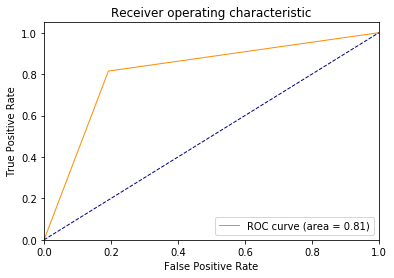

In [56]:
outcome_test = np.argmax(test_labels, 1)
predictions_test = predict_vals

fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [57]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, save_path)
    print("Model restored.") 
    print("Pos review ", new_pos_review)
    print("Neg review ", new_neg_review)
    print(predict_softmax(new_pos_review, vocab))
    print(predict_softmax(new_neg_review, vocab))

Model restored.
Pos review  I think that this is a fantastic movie, it really 
Neg review  Man, this movie really sucked. It was terrible. I could not possibly watch this movie again!
Predict: [[0.03790681 0.9620932 ]]
[1]
Predict: [[9.9920589e-01 7.9418725e-04]]
[0]
